In [1]:
%matplotlib inline

from time import time
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csc_matrix
from tqdm import tqdm
import gudhi
import galois

2024-02-28 01:08:08.477384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 01:08:08.479285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 01:08:08.512340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 01:08:08.513145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 01:08:09.049749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
counts_M = pd.read_csv("peyers_data/counts_M.csv", index_col=0)
normCounts_M = pd.read_csv("peyers_data/normCounts_M.csv", index_col=0)
md_M = pd.read_csv("peyers_data/md_M.txt", index_col=0,
                  sep="\t")

counts_tissue = pd.read_csv("peyers_data/counts_tissue.csv", index_col=0)
normCounts_tissue = pd.read_csv("peyers_data/normCounts_tissue.csv",
                                index_col=0)
md_tissue = pd.read_csv("peyers_data/md_tissue.txt", index_col=0,
                       sep="\t")

In [3]:
X_M = counts_M.to_numpy().T
X_M_norm = normCounts_M.to_numpy().T
X_tissue = counts_tissue.to_numpy().T
X_tissue_norm = normCounts_tissue.to_numpy().T

logX_M = np.log(X_M + 1)
logX_M_norm = np.log(X_M_norm + 1)
logX_tissue = np.log(X_tissue + 1)
logX_tissue_norm = np.log(X_tissue_norm + 1)

dist_mat_M = euclidean_distances(logX_M)
dist_mat_M_norm = euclidean_distances(logX_M_norm)
dist_mat_tissue = euclidean_distances(logX_tissue)
dist_mat_tissue_norm = euclidean_distances(logX_tissue_norm)

In [4]:
def isolate_persistence_pairs(pps, dim=1):
    dp1 = dim + 1
    i_pps = []
    for sower, reaper in pps:
        if len(sower) == dp1:
            i_pps.append((sower, reaper))
    return i_pps

def birth_death_from_persistence_intervals(st, intrv):
    births = []
    deaths = []
    for birth, death in intrv:
        births.append(birth)
        deaths.append(death)
    return births, deaths

In [5]:
def get_most_variable_genes(X, p):
    var_vec = np.var(X, axis=0)
    ind_list = list(range(len(var_vec)))
    ind_list.sort(key=lambda x: var_vec[x], reverse=True)
    top_inds = ind_list[:p]
    return top_inds

In [6]:
p = 10

top_inds_p = get_most_variable_genes(X_tissue_norm, p)
X_tissue_norm_p = X_tissue_norm[:, top_inds_p]
dist_mat_p = euclidean_distances(X_tissue_norm_p, X_tissue_norm_p)

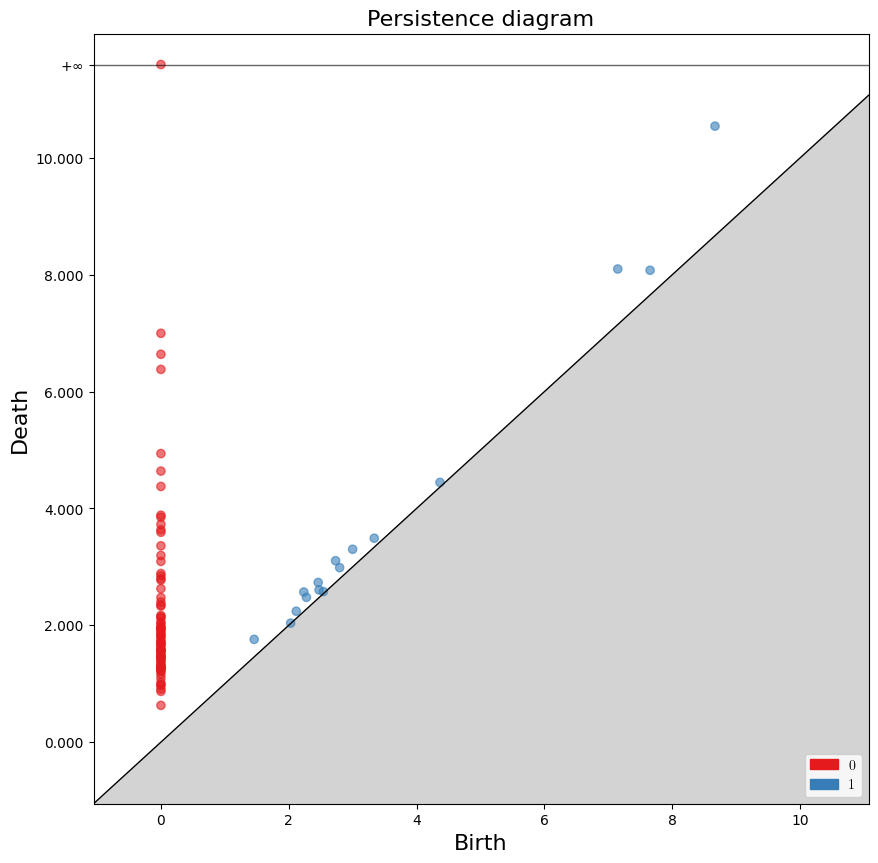

In [7]:
rips_p = gudhi.RipsComplex(points=X_tissue_norm_p)
st_p = rips_p.create_simplex_tree(max_dimension=2)
diag_p = st_p.persistence(homology_coeff_field=2, min_persistence=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
gudhi.plot_persistence_diagram(diag_p, axes=ax)

plt.show()

In [8]:
pps_p = st_p.persistence_pairs()
i_pps_p = isolate_persistence_pairs(pps_p)
intrv_p = st_p.persistence_intervals_in_dimension(1)

# births_p, deaths_p = birth_death_from_persistence_pairs(st_p, i_pps_p)
births_p, deaths_p = birth_death_from_persistence_intervals(st_p, intrv_p)
lifetimes_p = [(death - birth) for birth, death in zip(births_p, deaths_p)]

i_pp_inds_p = list(range(len(i_pps_p)))
i_pp_inds_p.sort(key=lambda x: lifetimes_p[x], reverse=True)

In [9]:
tsne = TSNE(n_components=3)
Y = tsne.fit_transform(X_tissue_norm_p)

# pca = PCA(n_components=3)
# pca.fit(X_tissue_norm_p)

# Y = pca.transform(X_tissue_norm_p)

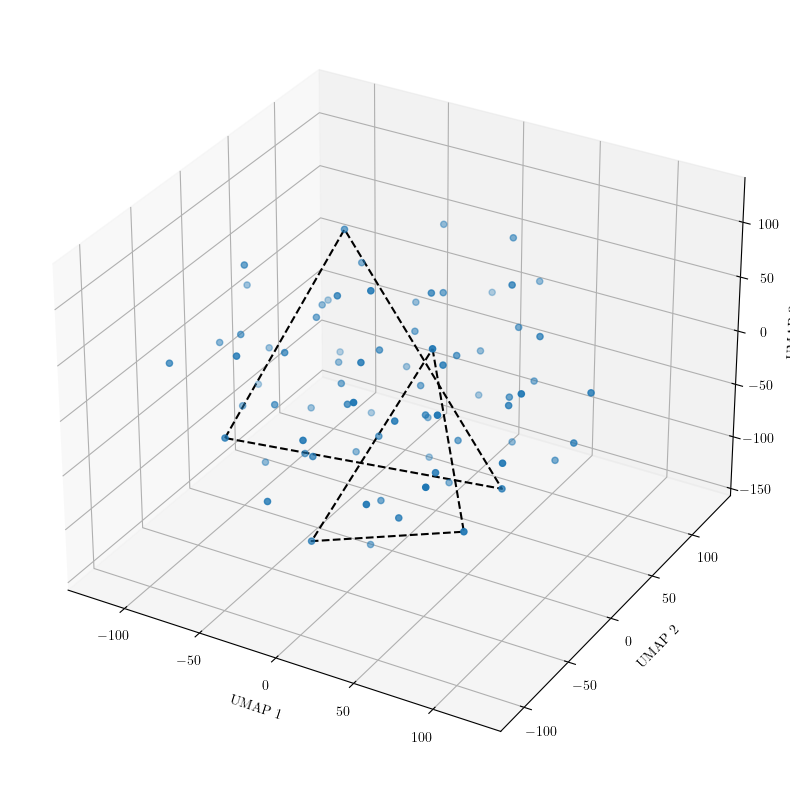

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
for ind in i_pp_inds_p[:2]:
    sower, reaper = i_pps_p[ind]
    xs = [Y[sub_ind, 0] for sub_ind in reaper]
    xs = xs + [Y[reaper[0], 0]]
    ys = [Y[sub_ind, 1] for sub_ind in reaper]
    ys = ys + [Y[reaper[0], 1]]
    zs = [Y[sub_ind, 2] for sub_ind in reaper]
    zs = zs + [Y[reaper[0], 2]]
    ax.plot(xs, ys, zs, color="k", linestyle="dashed")

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.show()

In [11]:
n_verts = st_p.num_vertices()
vertices = list(range(n_verts))
edges_full = []
for j in tqdm(range(n_verts)):
    for k in range(j+1, n_verts):
        edges_full.append((j, k))
tris_full = []
for j in tqdm(range(n_verts)):
    for k in range(j+1, n_verts):
        for l in range(k+1, n_verts):
            tris_full.append((j, k, l))
            
edges_full_dict = dict([(edge, j) for j, edge in enumerate(edges_full)])
tris_full_dict = dict([(tri, j) for j, tri in enumerate(tris_full)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 3820.66it/s]


In [12]:
filt_max = births_p[i_pp_inds_p[1]]
#filt_max += 2.5

edges_filt = []
tris_filt = []
for simp, filt in st_p.get_filtration():
    if filt <= filt_max:
        simp.sort()
        if len(simp) == 2:
            edges_filt.append(tuple(simp))
        if len(simp) == 3:
            tris_filt.append(tuple(simp))

In [13]:
Z2 = galois.GF(2)

d_1_0_full = Z2.Zeros((n_verts, len(edges_full)))
for j, edge in enumerate(edges_full):
    for ind in edge:
        d_1_0_full[ind, j] = 1
        
print("Computing nullspace...")
start = time()
d_1_0_null = d_1_0_full.null_space()
print("Time elapsed: "+str(time() - start))

Computing nullspace...
Time elapsed: 4.997979402542114


In [14]:
d_2_1_full = Z2.Zeros((len(edges_full), len(tris_full)))
for j, tri in enumerate(tris_full):
    for ind in tri:
        edge = tuple([otra for otra in tri if otra != ind])
        d_2_1_full[edges_full_dict[edge], j] = 1

In [15]:
edge_basis = Z2.Zeros((len(edges_full), len(edges_filt)))
for j, edge in enumerate(edges_filt):
    edge_basis[edges_full_dict[edge], j] = 1
    
tri_basis = Z2.Zeros((len(tris_full), len(tris_filt)))
for j, tri in enumerate(tris_filt):
    tri_basis[tris_full_dict[tri], j] = 1

In [16]:
d_1_0_reduced = d_1_0_full @ edge_basis
d_1_0_nullred = d_1_0_reduced.null_space()

print(d_1_0_nullred.shape)

(879, 956)


In [17]:
#Sparsify things
edge_basis_transpose_numpy = edge_basis.transpose().__array__()
left = csc_matrix(edge_basis_transpose_numpy)
del edge_basis_transpose_numpy
middle_pre = d_2_1_full.__array__()
middle = csc_matrix(middle_pre)
del middle_pre
right_pre = tri_basis.__array__()
right = csc_matrix(right_pre)
del right_pre
d_2_1_reduced_pre = left @ middle @ right
d_2_1_reduced = Z2(d_2_1_reduced_pre.toarray())
del d_2_1_reduced_pre
red_space = d_2_1_reduced.column_space()

In [18]:
cols_to_keep = []
for j in tqdm(range(d_1_0_nullred.shape[0])):
    col = d_1_0_nullred[j, :]
    new_mat = np.hstack([col.reshape(-1, 1), d_2_1_reduced])
    if new_mat.column_space().shape[0] != red_space.shape[0]:
        cols_to_keep.append(col)

print(cols_to_keep)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 879/879 [05:45<00:00,  2.54it/s]

[GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:
print(len(cols_to_keep))
print(type(cols_to_keep))
print(type(cols_to_keep[0]))

8
<class 'list'>
<class 'galois.GF(2)'>


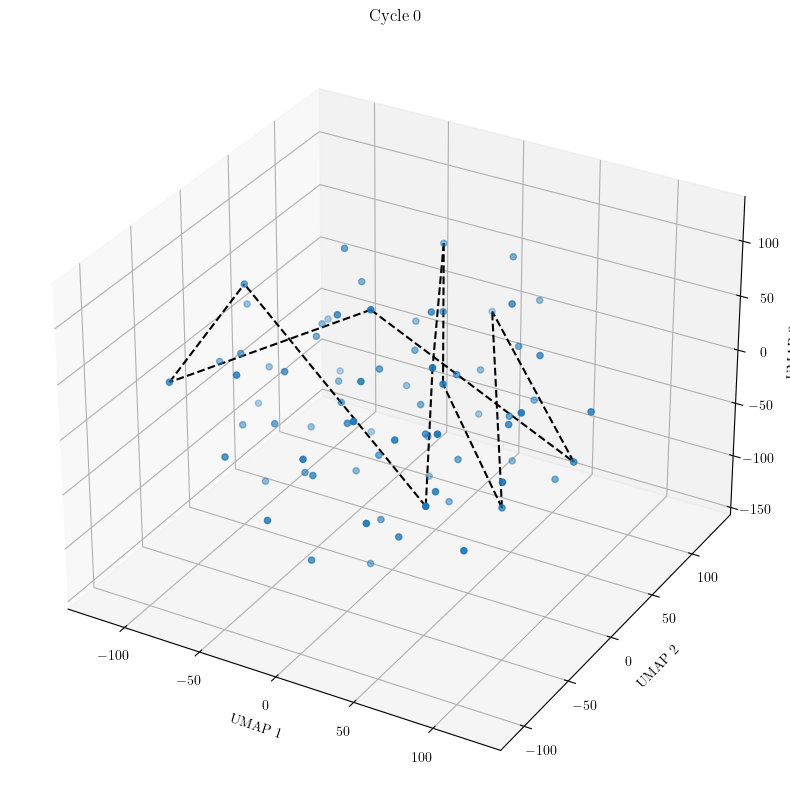

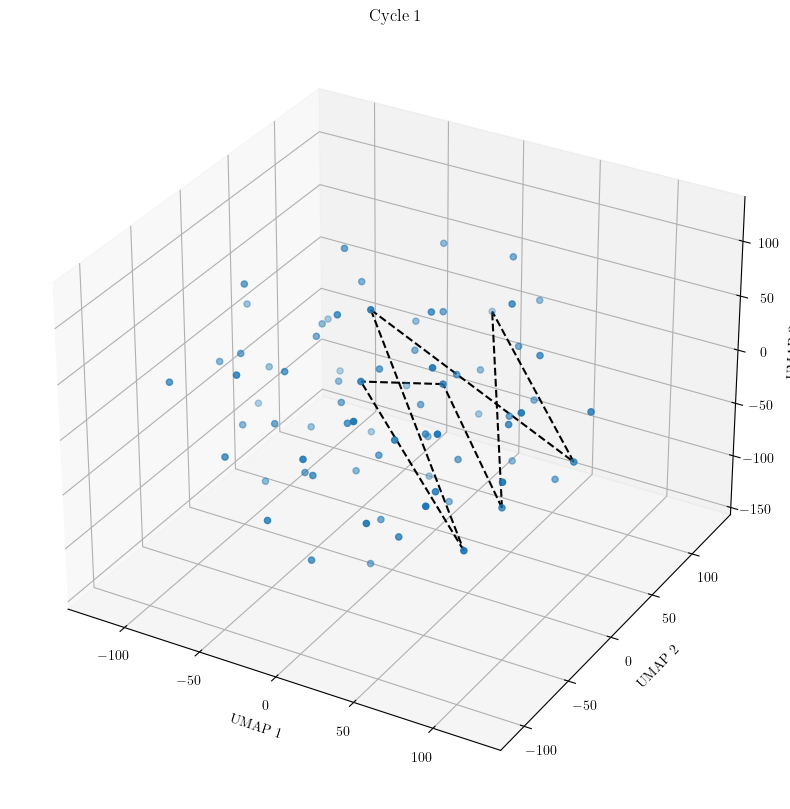

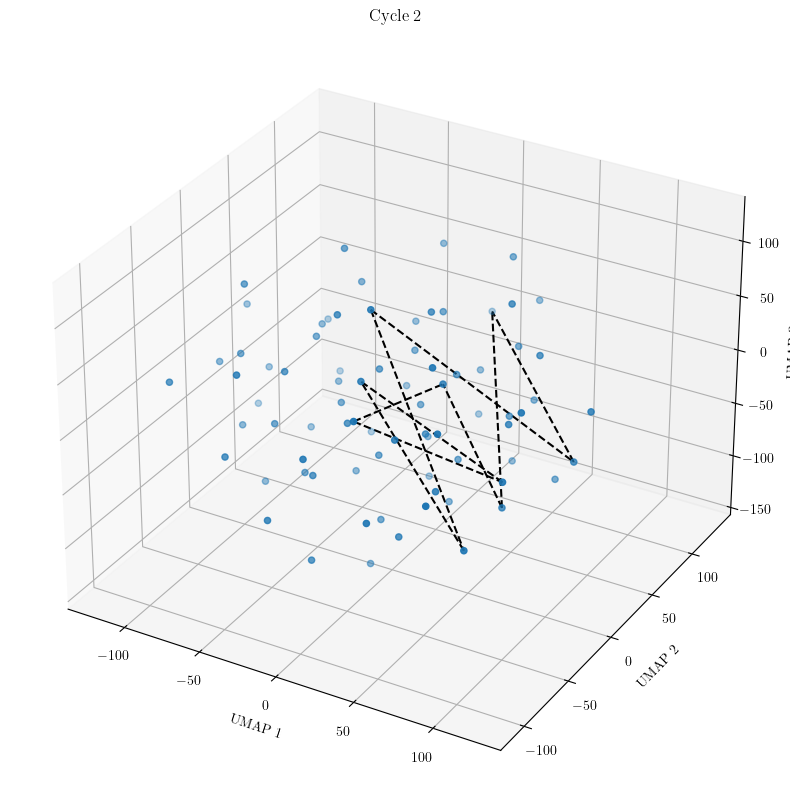

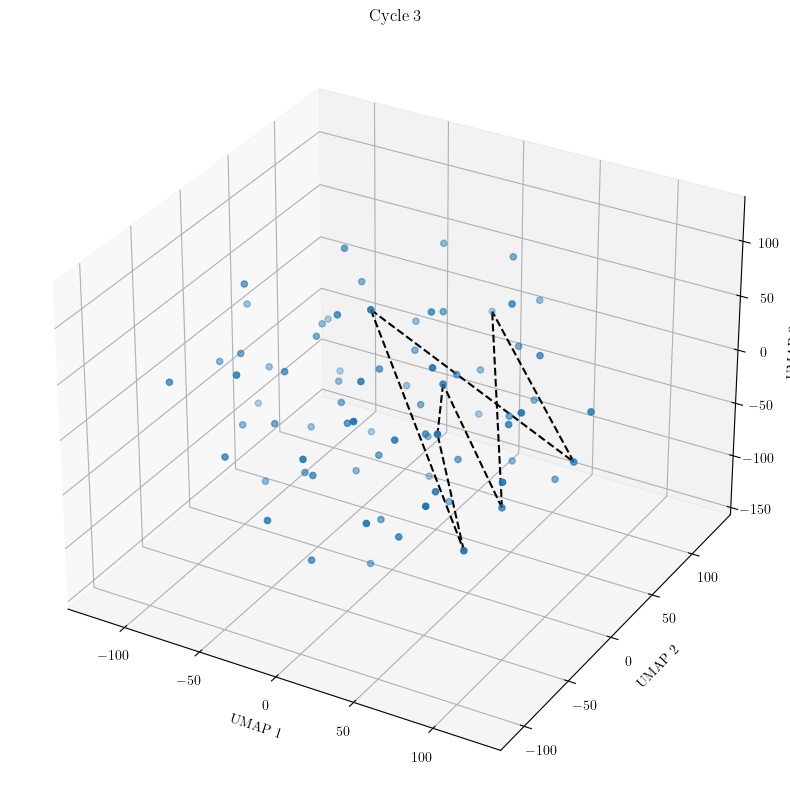

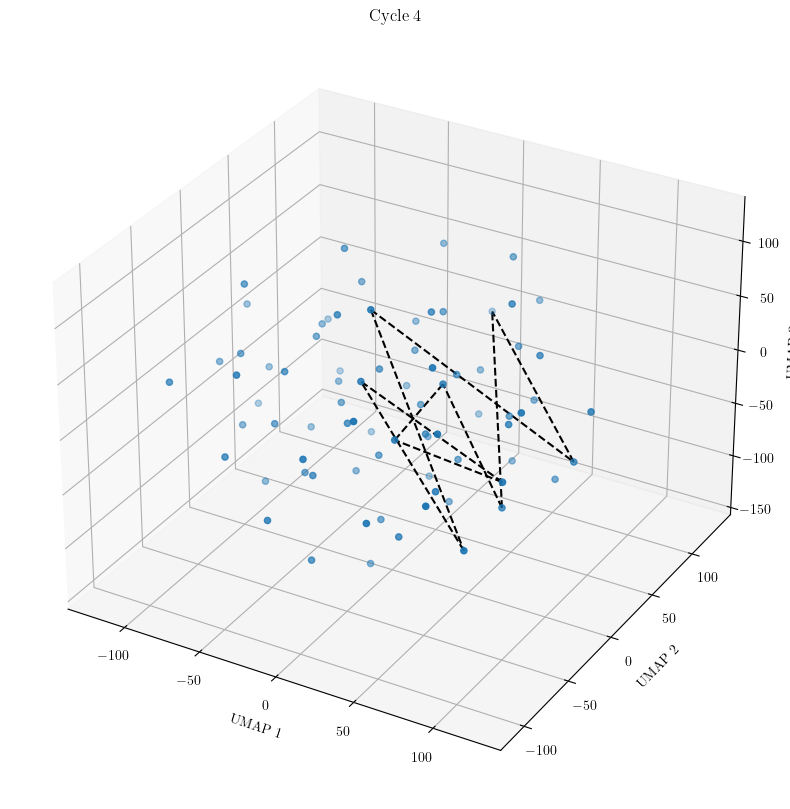

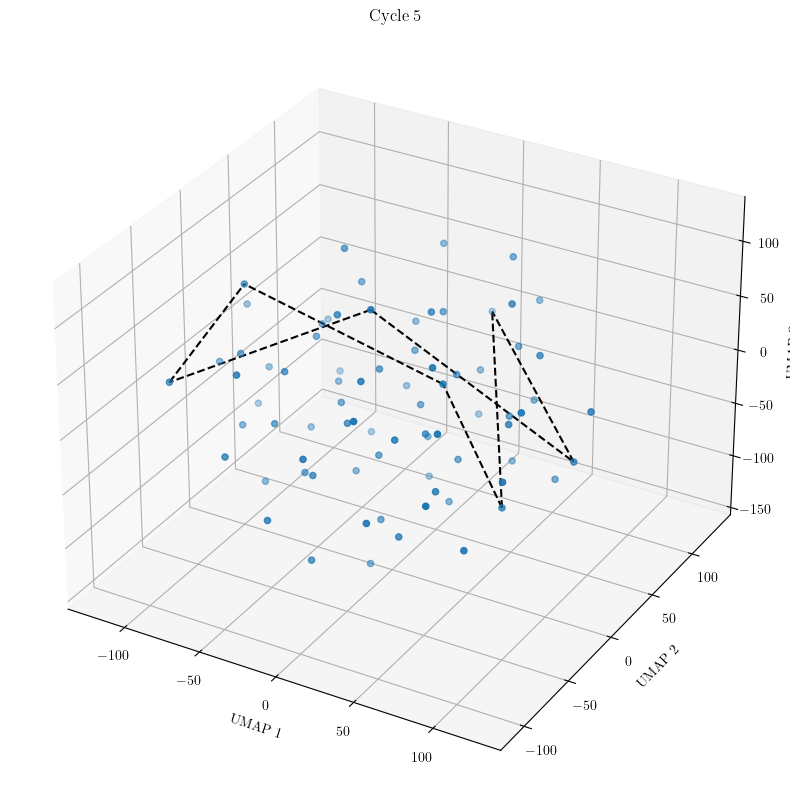

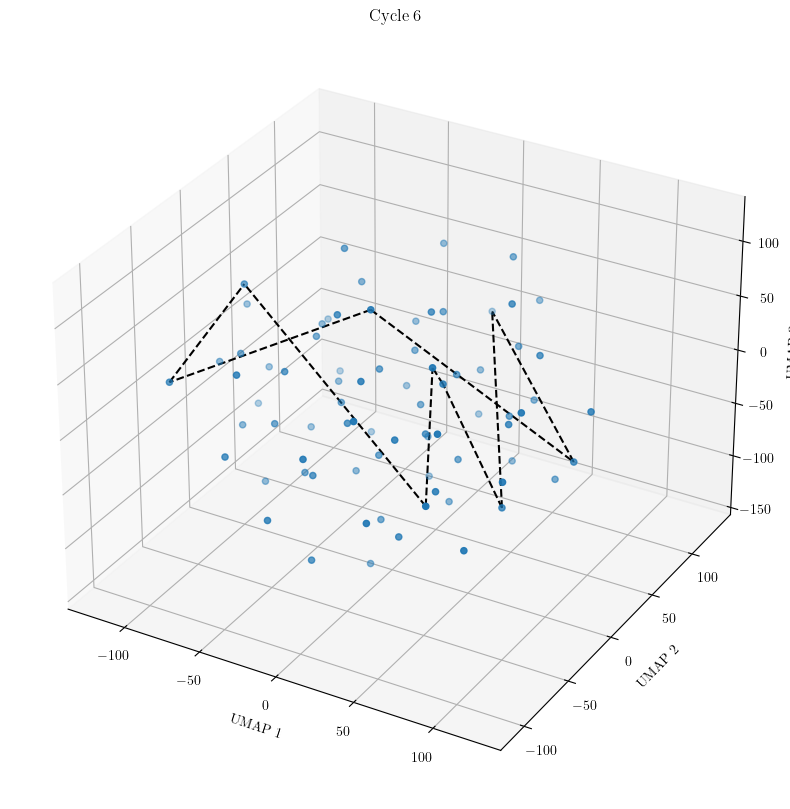

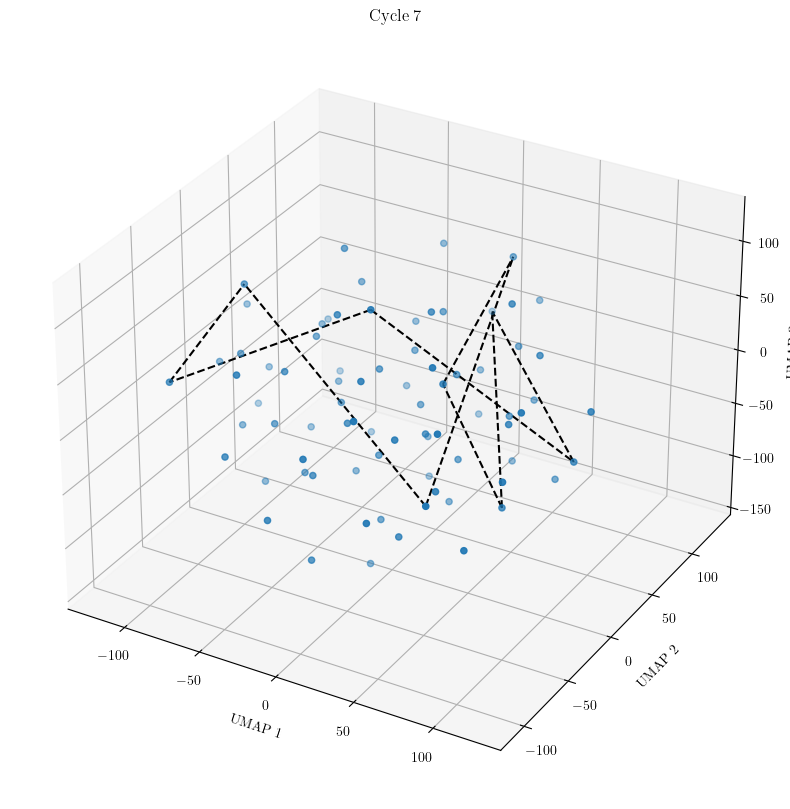

In [20]:
for j, col in enumerate(cols_to_keep):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(col):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_zlabel("UMAP 3")
    
    ax.set_title("Cycle "+str(j))

plt.show()

In [21]:
bitstrings = list(it.product([0, 1], repeat=len(cols_to_keep)))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxYAAAMpCAYAAACZkqXfAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9d5gkZ3kvfn+rc+6enpzD5iRt1s6sAINWGIPhECSEkI2NjQQYE4wFi4Qt8kEBY+GAjfSCwYSVrEXm/Dgcg7QirrK005NzTrs7M90TOneF94+hart7emY6d1XP/bkuLmAnVaeq567nDowgCAIIIYQQQgghJAOqQh8AIYQQQgghRPkosCCEEEIIIYRkjAILQgghhBBCSMYosCCEEEIIIYRkjAILQgghhBBCSMYosCCEEEIIIYRkjAILQgghhBBCSMYosCCEEEIIIYRkTFPoAyCEEJI9Z8+eBQCUlpbC4XDA6XTilltuwdmzZ/HAAw9k/PsvXbqEs2fPYnR0FCMjIxn/PkIIIcWDocnbhBCifJcuXcKdd96JBx54AGfOnJH+fXR0FGfPnsWlS5eyFghcuHABH/zgBzP6fQ8++CAcDgcAYGlpCZ/+9KezcmyEEEIKh1KhCCGkCNx6663rggoAaGlpwQc/+MGs/i2n05nRzz/44IMAgLvuugt33XUXjh49mvVjJIQQkn+0Y0EIIQp39uxZnD9/ftMdhJtvvhlPP/10Vv7epUuXcOutt6a9Y1FSUoKxsTFpxwIAGIYBXY4IIUTZaMeCEEIU7vz58+t2KuKJtRfnz5/HsWPHUFJSggsXLgBYS5fasWMHbr75ZoyOjko/88gjj8T8ZysPPvggzp8/L/13IqOjo1haWooJKkTi8RBCCFEmKt4mhBCFEwODzYiBxy233AKHw4EPfvCD0r+J6VLRdQ4PPvggFhcXpYLv8+fP4/z587jlllsS/v5bb70Vt912m/T1m2++GS0tLTh69Oi6Y03E4XBgaWlp6wdLCCFEtmjHghBCtpkzZ87A7Xbj0qVL0r+1tLRI/3tpaQlnz57FPffcI/3b448/vmFQMDo6ui7ouPXWW/Gtb30r6WNyOp1wu92pPAxCCCEyQzsWhBCicC0tLVvWO4yOjsYED3fddRcef/xxHD16FBcuXIhJpXrllVfgcDhi0pWeeOKJDX/3hQsX4HA4YlKZRkZGNgxEEqGgghBClI8CC0IIUbhbbrllw5oG0YULF3DXXXdJ//+2227DTTfdhAceeACjo6MxgUWqKUlLS0toaWmJ+R0b1XxEBzeJfgchhBDlolQoQghROLEOYqPi56WlpXUtYo8ePQqn04nz588n/Fqi4GKjgOPo0aMJdycSfX9LSwscDkfC79+qAJ0QQoi8UWBBCCFF4IknnsDZs2fXBRdLS0t45JFHEhZdf/CDH8Sdd9657mstLS245ZZbpHkT4u/5r//6r4R/+8yZMzh+/Pi6XZONvv+ee+6JOc7z58/H7KYQQghRJppjQQghRURsK1taWirVSGy0aBencm9UP3H27FmUlpaipaUFbrcbd911Fy5duoSvfvWrOH/+PD796U9LuyXi9+/YsUPaAdmogxSw1nVKTH16+eWXY34PIYQQZaLAghBCtqmlpSW88sorlIJECCEkKygVihBCtpHouof/+q//oqCCEEJI1lBgQQgh28jZs2elKdrxRduEEEJIJigVihBCtpFLly7hlVdeAbBx7QUhhBCSDgosCCGEEEIIIRmjVChCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIQQQgghhGSMAgtCCCGEEEJIxiiwIIRsS4IgFPoQCCGEkKKiKfQBEEJIPvE8j3A4jFAoBK1WC41GA7VaDZVKBYZhCn14hBBCiGIxAt22I4RsA4IggOM4sCwLlmURDofBMAwEQYBKpYJKpYJGo6FAgxBCCEkTBRaEkKInCAIikQg4jov5/yqVCoIgQBAE8DwvfT/DMBRoEEIIISmiwIIQUtQ4jkMkEgHP81JwIP6bSrW+zGyjQEOtVktBhkajAcMwFGgQQgghUajGghBSlARBkNKexHQnMRAQg4dExIBBDDrE72VZFpFIRPq6GGCIwQYFGoQQQrY7CiwIIUWH53mwLCulPmWSxpRKoKHVaqFWq6XUKUIIIWQ7ocCCEFI0xBSmSCQCQRBysouQbKARvZtBgQYhhJDtgAILQkhRiC/Qzldq0kaBRiQSQTgcBoB1heAUaBBCCClGFFgQQhRP3KXgOK7g3Zu2CjRoR4MQQkixosCCEKJY0bMpors+yUmiQEMMhCKRiPQ90YGG2HWKEEIIURJqN0sIUaRMUp/Eegi1Wp3LQ0yKGGiIOxtiEJKo6xQhhBAiZxRYEEIUh+d5hMPhtHcpOI5DOByWRWARb7NAI7rrFAUahBBC5IZSoQghiiGmPoldn+SY+pQpsXUtAGnWhpg6JdZoJCoGL7bngRBCiPLQjgUhRBHiZ1Nk0vWJ53mEQiFZ7lhsJjrQiN/RoECDEEJIoVFgQQiRtVzMplBqYBEvPtAQ/21paQnl5eXQ6XQUaBBCCMkb6m9ICJEtcfBcOBzO+sC7YlhoR0/9FncrAKCrqwt+vx9+vx+rq6tYWVmBz+dDKBQCy7Kg+0mEEEJygWosCCGyFD2bIrpdK9lY9PMkFnqLKVOhUAihUEj6Hq1WKwUjxVirQgghJP8osCCEyIoSZlMoQfwOT3SQIQgCgsEgAFCgQQghJGsosCCEyEb8bApa4GZXsoFG/AwNeh0IIYQkgwILQogsZDqbgqxJ5XnbKNDgeV4KNFQq1bquU/T6EEIISYQCC0JIQW2H2RRKsVGgwXEcOI5DMBikQIMQQsiGKLAghBQMpT7lTjY6P4mBhlgQHh9oxBeDiylU2ezeRQghRDkosCCEFIS4S0GpT8qxWaDBsuy69rfijgYFGoQQsj1QYEEIyStxNgXLsgBolyLb8vlcbhRosCyLSCQSE2iIOxpi6hQhhJDiQ4EFISRvxNkUPM8DAN3JLjIUaBBCyPZGgQUhJOfETkOU+pQ/cpiuvVWgAWBdITgFGoQQolwUWBBCcooKtPNLzs/tRoFGJBJBOByWvk6BBiGEKBMFFoSQnBF3KTiOo4CCrJMo0BDfM+KORnygIXadIoQQIj8UWBBCsi66UxClPhWGHFKhUiXWX4iiA41EOxrRXacIIYQUHgUWhJCsotSnwiuW5zuZQEOlUq0rBi+Wx08IIUpDgQUhJGtoNgXJpWQDjfgaDXofEkJIflBgQQjJWPRsCkEQKKiQASWmQqUqOtAQHy/P8wiHwzFTwSnQIISQ/KDAghCSEZ7nwbIspT6RghLfcxRoEEJI4VAPP0JIWsQC7aWlJTzzzDPSoo0WaYVHr8G1jlNiJymNRgOVSgVBEBAKhbCysoKOjg4sLy/D5/MhFApJO26EEELSQzsWhJCURRdoi/+bFrNEzqKnvKvVanAch+npabS0tCAUCsXsaIiF4GIwQu9tQghJDgUWhJCUxM+mUKvV0qAzWoDJB915T46YCiW+hwVBQDAYBICYQENMnaJAgxBCNkaBBSEkKRvNpogebqakBZeSjpXkjvg+iN/R2CjQiE6tokCDEEJiUWBBCNnSZrMpxP9W4h1ypQVDySrGx5RtW71fNwo0eJ6XAg2VSrWuGJwCDULIdkaBBSFkU2JXnY1mUyg1sCjWoIIkL5XXf7NAIxQKIRgMUqBBCNn2KLAghCQkpj5FIpFNZ1OI/8bzfL4PkWxCaYFevmX6/EQHGuLvEz8zHMdtWAwe/3OEEFJMKLAghKyTymyK6BoLQrYrMWCI/jxE1yUlan8rFo5ToEEIKRYUWBBCJGJqh7hLkcyiR6mpUMWMFqrJyeXztFGgwbKs1J55o2JwQghRKgosCCEAIC16WJYFsD7VYyOUCkWUKN+BcCqBhpg6RYEGIURpKLAghMTMpohe/CRLnAOgFHNzcxgbG4PVaoXT6URJSQl0Ol2hDyurlPR6bEdbBRoA1hWCU6BBCJE7CiwI2cY2mk2RKpVKpYiFLMdx6O3txdWrV9Hc3IxAIICJiQn09PTAbDajpKQEJSUlcDgc0Gq1hT5ckmNyShnbKNCIRCIIh8PS1ynQIITIGQUWhGxTm82mSJUSdixWV1fR0dEBjUaDtrY2aUHGMAwikQg8Hg88Hg9GRkbg9/thtVpRUlICp9MJu90OtVpd4EeQPDktmOVK7u/XRIGGuLMo7mjEBxpi1ylCCCkUCiwI2Ya2mk2RKoZhZFtjIQgCZmZm0NfXh8bGRuzcuRMMwyAcDkvfo9VqUVFRgYqKCgBAKBSSAo2+vj6Ew2HY7XZpR8Nms8n+TrHcF84kNWL9hSg60Ei0oxHddYoQQvKFAgtCtpFkZ1OkSq6pUCzLore3FwsLCzh8+DDKy8sBbL3o1uv1qKqqQlVVFQRBQDAYhMfjgdvtxvT0NDiOg8PhkAINq9VKCzgFUvJrlkygoVKp1hWDK/kxE0LkjwILQraJbKY+xZNjKtTq6ipcLhf0ej3a2tpgMBjS+j0Mw8BoNMJoNKKmpgaCIMDn80k7GhMTEwAQE2iYzeaCLuBo8bg1ub1fM5VsoBFfo0HvFUJINlFgQcg2IO5SZCv1KZ6cAgtBEDA9PY3+/n40NTVJqU/ZwjAMLBYLLBYL6uvrIQgCVldX4fF4sLi4iJGREWg0GinIKCkpgcFgoAWcDBXzaxIdaIifTTEFMnoqOAUahJBsosCCkCIWP5siF0EFIJ8aC5Zl0d3dDY/Hg6NHj6K0tDTnf5NhGNhsNthsNjQ2NoLneaysrMDj8eDy5csYGBiAXq+PCTT0en3Oj0sugZ5cbafnR/zMU6BBCMk1CiwIKVJiGoS44E924F065FBjsbKyApfLBaPRiLa2trws3hNRqVRwOBxwOBxobm4Gx3FYWlqCx+PB1NQUent7YTKZYgINam1L8mmzQCMUCkmNDSjQIISkigILQopMdG51rlKf4hUyFUoQBExOTmJwcBAtLS1oaWmR1eJHrVajtLRU2j2JRCJSoDE2Nobu7m5YLJaYGRoaTWanZjk9fjmj52lNdKChVqulGRqCICAUCiEUCuHy5ctwOp2w2WxSa9t8nFsIIcpCgQUhRSSXBdqbKVRgEYlE0N3djaWlJRw7dgxOpzPvx5AqrVaL8vJyqUNVOByWCsGHhoYQDAZhs9liWtsqaYaGUhR6h03Oonc3xUBjZmYGBoNBmlAvpk5ptVppR4MCDUIIBRaEFAlxl4LjuLxf4AtRY7G8vAyXywWz2YzTp09LCx6l0el0qKysRGVlJQAgEAhgaWkJbrcbs7OzYFk2ZoaG1WpNaoYGLZxJtog3DsTWtdE7GsFgUPoecSeDAg1Cti8KLAhROHE2BcuyeUt9ipfPGgtBEDAxMYGhoSHs2LEDzc3NaT1eOXWyiia2tq2uroYgCPD7/dKOxuTkJARBiGlta7FYaPGWJnrekicIgvR8JdrREFMwKdAgZHujwIIQBStU6lO8fC3Sw+Ewuru7sbKyguPHj6OkpCTnf7OQGIaB2WyG2WxGXV0dBEGA1+uVAo2xsTGoVKqYQnCj0UiLtyTIMaiUs+jAIt5mgUYoFEIwGIRKpVpXDE6BBiHFhwILQhQq17MpUpGPwMLj8aCjowNWqxVtbW2KTX3KBMMwsFqtsFqtaGhoAM/z0gyNq1evYmhoCFqtFpFIBAsLCzAYDGkPBtwOaFGbPEEQkkrBA9Z3oBMDDY7jwHHchu1tC30eI4RkjgILQhQmejaFeLEv9MU4lzUWgiBgbGwMw8PD2L17NxobGwv+eOVCpVLBbrfDbrejqakJHMdheXkZXV1dWFxcxNTUFAwGQ8yOxnYMyBKhHYvUbLZjsRUx0BADk+hAg2VZ6evxqVO5bJFNCMkNCiwIURCe58GybMFTn+LlqsYiHA6js7MTPp8PJ0+ehMPhyPrfKCZqtRpOpxNarRa7d++G1WqVWttOTEygp6cHZrM5JtDItLUt2R4yCSzibRRosCyLSCRCgQYhCkZXFEIUIHo2hXiBl9MFNhepUG63Gx0dHXA4HGhra6MhcikQ3xsajQZlZWUoKysDsBaoiYHGyMgIAoEArFarFGTY7fZt1dpWTp8huctmYBEvlUBDq9VK8zaSTc0ihOQPBRaEyFx8gbbcggogu4GFIAgYHR3F6Ogodu/ejYaGBtk9XiVI9HrodDpUVFSgoqICABAKheDxeOB2u9HX14dwOBzT2tZmsxXt4o1SoVKTy8Ai3laBBpB4KnixvlcJURIKLAiRsULOpkhFtmosQqEQOjs7EQgEcPLkSdjt9iwcHdmIXq9HVVUVqqqqIAgCAoGA1HFqenoaPM+vm6Eh1/dgOorpseRaPgOLeBsFGpFIBOFwGAAFGoTIBQUWhMiQHGZTpCIbOxaLi4vo7OxESUkJjhw5Qrn/GUh3rofJZILJZEJtbS0EQYDP55MCjYmJCQCIqc8wmUyyfl9uhnYsUlPIwCJeokBDvAkj7mgwDEOBBiEFQFduQmRGLrMpUpFJ8bYgCBgeHsb4+Dj27t2Lurq6vD1eOS2Wsi3ThTPDMLBYLLBYLKivrwfP89IMjYWFBQwPD0Oj0ayboUGKj/hekutnRay/ECUTaGg0Gtk+HkKUjAILQmSE53mEw2FF7FJESzcVKhgMorOzE6FQCKdOnYLVas3B0ZFsUKlUsNlssNlsaGxsBM/zWF5ehsfjwdzcHAYGBqDX62MCDb1eX+jD3pRSPl+FJvfAIt5mgUY4HJZ2O+KLwZXy+AiRMwosCJEBQRAQCoUQDoeh0WgUFVQA6aVCLSwsoLOzE2VlZTh69CilPmVRPt470RO/gbWBjWLHqampKfT29sJkMsUEGnLq7EWpUMlTWmARL9lAIz51SqmPl5BCois5IQUmzqYYGhpCKBTCwYMHFXdBSyWw4Hkew8PDmJiYwL59+1BbW6u4x0vWU6vVKC0tRWlpKQAgEolIgcbY2Bi6u7vXtbalYFIZlB5YxIsONMTHJu4WbzQVnAINQpJDZ3VCCiR+NoVYp6DEi5dKpZJqQjYTDAbR0dGBSCRCqU85Vug78lqtFuXl5SgvLwdwrbWtx+PBwMAAQqEQbDZbTKCR7+JaJX7WCqHYAoto4mOiQIOQ7KDAgpACEHuysywLANKFKxstWwshmRqL+fl5dHZ2oqKiAvv3799Wg9hIbGtbADGtbWdnZ8Gy7LrWtrkMNAodeClJMQcW8TYLNMR0VSBxe9vt8PwQshUKLAjJM3GXQlyIi4unTDorFdpmqVA8z2NoaAiTk5PYv38/amtr83x0248SFjhGoxFGoxE1NTUQBAF+v18KNCYnJyEIQkx9htlszvrjUsLzJAfbKbCIFx1oqNVqaYZGdF0csHb+FgvBlVgnR0i2UGBBSJ5sNZtCyTsWGwVFgUAALpcLPM+jtbUVFoulAEe3Hl3w5YVhGJjNZpjNZtTV1UEQBKm1rdvtxujoaEyxuNjaNpPXUalBfCFs58AinjhDA8C6QCMYDMZ8j1qthl6vl2Zo0PNHtgMKLAjJg2RmU2RrenUhJNqxuHLlCrq6ulBdXY29e/fKLvWp2C/ySl44MwwDq9UKq9WKhoYG8DyP1dVVuN1uXLlyBYODg9DpdDGBhsFgKPRhFy2l1n7lw0aBxsrKCjo7O9Ha2iqlumq1Wil1igINUqwosCAkx8TUJ47jNr2YKHnHIjoo4nkeAwMDmJmZwYEDB1BdXV3goyNKp1KpYLfbYbfb0dzcDI7jpBkaMzMz6O/vh8FgQElJCZxOJxwOB3Q63Za/lxZ2yeF5np6rJImBRnTBd6IdDTFligINUmwosCAkR8TUp+iuT5tdOIqhxsLv98PlcgEAWltbYTabC3tg21SxL1DUajWcTiecTicAgGVZqbXt+Pg4vF4vLBaLtJvhcDjWtbZV6metEGjHInXR6a6JdjTEYvBgMAiVSrWuGJwCDaJUFFgQkgPJpD7FU/KOhUqlQjAYxHPPPYeamhrs3bs3761Dyfal0WhQVlaGsrIyAEA4HJYCjeHhYQQCgXUzNEjyKLBInXgzKV50oCF+n3gTiuO4DdvbUqBBlIICC0KyTNylSFSgvRml1lhwHIe5uTmsrq7i+uuvl9qJksLaznfkdTodKioqUFFRAWBtforYcaqvrw/hcBhGo1GaFm6z2SgQ3gQFFqlLNn0sOm0K2DjQEFOnxP+OD1AIkQsKLAjJkvjZFKneYVJiKpTP54PL5QLLsrDZbIoKKuiivH0YDAZUV1ejuroagiAgEAhgYmICCwsL6OrqAs/zcDgc0o6GxWKh90cUCixSJ95YStVGgQbLsohEIjEdp6J3NCjQIHJBgQUhWRA/myKdk7zSUqFmZ2fR09ODuro6WK1WzMzMFPqQUqK0IC4VtMDYGMMwMJlMKCkpgd/vx9GjR+Hz+aQdjbGxMTAME9NxymQybevnlAKL1KUbWMRLJdAQ52iIqVOEFAIFFoRkQCzCSyf1KZ5SUqE4jkNfXx+uXLmC66+/HhUVFZibmyvqhTopPuJimWEYWCwWWCwW1NfXg+d5eL1euN1uzM/PY3h4GBqNZt0Mje2EAovUbVRjkalkA434qeAUaJB8ocCCkDSlU6C9GSWkQnm9XrhcLmg0GrS1tUkLrM0mb5PCoNcjPSqVCjabDTabDU1NTeB5XmptOzc3h4GBAej1+phAQ6/XF/qwcypXi+Rilq8WvRsFGpFIJGYqOAUaJF8osCAkDcnOpkiF3FOhZmZm0Nvbi4aGBuzatSvmwkSBBVGiZD630RO/gbXWtmKgMTU1hd7eXpjN5pjWtlqtNteHnle0Y5G6bKVCpWqrQIN2NEiuUWBBSArEbh0sy2ac+hRPrqlQLMuir68PV69exeHDh1FeXr7ue+QeFG03FOhtLd3nR6PRoLS0FKWlpQCASCQitbYdHR2Fz+eLaW3rcDhkN3U+VRRYpE4uuzyJAg3xxlgkEpG+JzrQELtOEZIOCiwISVK2U5/iyXFxvrq6CpfLBZ1Oh9OnT8NgMCT8PlrIku1Kq9WivLxcCrhDoZBUCD4wMIBQKASbzRYzQ0MOC85UUGCROrlOKxcLvUXRgYa4o6FSqRJ2nSIkGRRYEJKEdGdTpCL6jlKhT+KCIGBmZgZ9fX1oamrCjh07Nl0MKTGwKPRzTAorV58zvV6PqqoqqfVyIBCQAo3Z2VmwLAu73Y6SkhI4nU5YLBbZBxpyOCcpTaFSoVKVSqAR3XWK3g9kIxRYELKJ6NkU4tZ2rk6o4kWI5/mCpk6wLIuenh4sLi7iyJEj0jTjzcg1jWu7oou+fBiNRhiNRtTU1EAQBPj9finQmJychCAIMYXgZrNZdq8fBRapU0pgES860BBvFiUKNOJrNOj9QUQUWBCyAZ7nwbJszlKf4skhsFhZWYHL5YLBYEBbW9uGqU/xlLhjUezo9dhavhdDDMPAbDbDbDajrq4OgiDA6/XC4/HA7XZjdHQ0plhcbG1b6EUbBRapk0uNRSbE1zxRoBEOh6Wp4BRokGgUWBASJ3orOLrXfa6Jf6MQC0JBEDA1NYWBgQE0Nzdjx44dRT81nC5825sc3q8Mw8BqtcJqtaKhoQE8z2NlZQUejwdXrlzB4OAgdDpdTKCRbLCfTRRYpK7QO8+5sFWgsVl7W3r/bB8UWBASJb5AO19BBRC7Y5FPkUgEPT098Hg8OHr0qNTtJhW0Y0FI5lQqFRwOBxwOB5qbm8FxnNTadmZmBv39/TAajTEdp3Q6Xc6PiwKL1PE8X3Rth+MlCjTE/4RCoZhAQ6zP0Gg0Od/9J4VFgQUhv5eL2RSpEIOYfAYWy8vLcLlcMJlMaGtrS3vQF9VYyAtdtJMj9+dJrVbD6XTC6XQCWKt/Elvbjo+Pw+v1wmKxxAQaGk32L+sUWKSuGFKhUhV9I06tVscEGsFgUPoeMdAQdzQo0CguFFiQbS+XsylSla8FuiAImJycxODgIFpaWtDS0pLRY1bqjoUSjzlZxfzYskGJz49Go0FZWZnUUCEcDmNpaQlutxtDQ0MIBoMxMzTsdntW0nEosEidUou3s4kCje2JAguyreV6NkWq8lGrEIlE0N3djaWlJRw/flyaKJwJJdZYKO14SfYpffGi0+lQUVGBiooKAEAwGJQ6TvX19SESiUgzNJxOJ6xWa1qLXQosUifXORaFlEygwfM8fD4fysvLKdBQKAosyLYlFpwVepciWq6H5C0tLcHlcsFqteL06dNZy88WdyxoAUKUohgDS4PBgOrqalRXV0MQhJgZGtPT0+B5Hg6HQ9rRsFgsSX1e6XOdOtqx2FqiQMPn86GzsxOnT58GsHZNjC8Gl8v1miRGgQXZdsTUJ7Hrk5xOUrlKhRIEAePj4xgaGsKuXbvQ1NSU1ccc3dFKLs/ldkavAWEYBiaTCSaTCbW1tdKiTQw0xsbGwDBMTMcpk8mU8L1Dd99Ttx1rLDIl3qASh/GJN6s4jgPHcQgGgxRoKAAFFmRbkVvqU7xc7FiEw2F0dXVhdXUVJ0+ehMPhyOrvB2KnhhN5oNdia3L67OcawzCwWCywWCyor68Hz/NYXV2Fx+PB/Pw8hoeHodFo1s3QAOiGQTooGEtP9E6PuKMRfX2JDjSi52hEd53KZzdHsh4FFmRbKNRsilRlu1bB4/Ggo6MDNpsNp0+fzln7w0LO4CAkHdv9vapSqWC322G329HU1ASO46QZGnNzcxgYGIBer0dJSQkikQjdfU8RpUKlR+zKmMhmgQbLstLXxQBD3NGQ6/W+WFFgQYqeIAhgWRYsywLI72yKVGVrx0IQBIyNjWFkZAS7du1CY2NjTh+z+LuV0nI2Eomgq6sLPp9PaufpcDiKZqCVXN/fRL7UarW0UwGstbYVZ2gsLi4iHA7jxRdfjGltW+xzGjJBqVDpSWWw4EaBBsuyiEQiMYGGuKMhpk6R3KHAghQ1cZdCXPDK/YSSjRqLcDiMzs5O+Hw+nDx5Ena7PUtHtzElpUKJszvMZjMaGhqwvLyMgYEBhEIh2O32jDvoEGWg9J7NaTQalJaWSgMzI5EISktL4fF4MDIyAr/fH9PatpgC82ygHYv0bLZjsRUKNOSBAgtSlKJTn+TU9WkrmaZCud1udHR0wOFwoK2tLW93FJWQCiUIAqampjAwMIAdO3agoaEBkUgE1dXVAIBAIAC32x3TQUdcNDmdzg0LW+VKzq8FURaxoDa6tW0oFJIKwcXAXGxtK87Q2M4LNqqxSE8qOxZb2SrQALCuEJwCjcxRYEGKjtwLtDeTbiqUIAgYGRnB2NgY9uzZg/r6+rw+ZrkHFizLoqenB263G8eOHYPT6ZTeHyKj0Yja2lqpg47X64Xb7cbi4iJGRkag0WjgdDqlQCPdKeWEKE2i3R29Xo+qqipUVVUBQExr29nZWbAsG9Pa1mq1KuY8nA20Y5GeTHYstrJRoBGJRBAOh6WvU6CRGQosSFERdynEk5PSLmTppEKFQiF0dnYiEAjghhtugM1my9HRbU6u07e9Xi/a29uh1+vR1tYmBQSbvTcYhoHVaoXVakVjY6NU2Op2uzEzM4O+vj6YTCYp0CgpKYFGI5/TqdLe94VAqVDJS6ZewGg0wmg0oqamBoIgwO/3S4HGxMQEAMQEGmazuaiff6qxSE8+A7JEgYa4hhB3NOIDDbHrFNmYfK6EhGRAnNwZCARgMBgUGVQAqadCLS4uoqOjA6WlpThy5EhBF7e5Hu6XjtnZWfT09KCxsRG7du1K+z0RX9gaiUSwtLQEt9uNkZERBAIBWK1WKdCQQxqIHIM8okypBmEMw8BsNsNsNqOurg6CIEitbcUdwOjPlNjaVonn7I3QjkV6OI4rWK2OWH8hig40Eu1oRHedItdQYEEUT9zKnJmZwezsLE6ePKnYD3qyi3Oe5zEyMoLx8XHs3bsXdXV1BX/Mctqx4DgO/f39uHz5Mg4fPozy8vKE35fuc6bValFeXi793mAwCI/HA7fbHZMGIgYayU44JvlFr0lyMt3dYRgGNpsNNpsNjY2N4Hleam175coVDA4OQqfTSWmGJSUlik81pBqL9MgpIEsm0FCpVOuKwbf7606BBVE0cYK2WPCl9PSGZFKhgsEgOjo6EA6HcerUKVit1jwd3ebkElj4/X64XC4wDIO2tjZpyFcuGQwGVFdXo7q6OmbCsdvtxtjYGFQqVcyiKdfHpOTPQL7I4b2qFNk+r6pUKjgcDjgcDjQ3N4PjOKm17fT0NHp7e2EymWJ2NJTU2lbM3ZfLAllJslm8nW3JBhrxNRrb7XxMgQVRpPjZFOJdA7ml4qRqqx2L+fl5dHZ2ory8HMeOHZNdXn+hF2tXr15FZ2cnampqsHfv3oJc2BNNOE40eEycn6G0RRPZfnJ9w0atVkufB2Ct2YJYnzE2Nobu7m5YLJaY1rZyOvfFE8+DFFikjuM4xZwPowMN8TXneR7hcDhmKvh2CzTk+8kkZAPxsymiC7CKIbBItDjneR5DQ0OYnJzE/v37UVtbW4Cj21whn//o5+fgwYNSC1k5iL87y7IslpaWYhZN4jwAp9MJu92elTt2hQ7y5E7pu5v5lO+77xqNJibVMBwOS4HG0NAQgsFgzAyNbH1mskUpc5PkSE6pUKkQzyUUaFBgQRRkq9kUKpVqXQtRpUm0OA8EAujo6ADLsmhtbYXFYinQ0W2uUDsWYmpYJBKR9fMj0mg0KCsrQ1lZGYC1RZM4P6Ovrw/hcBh2u126g7vd2nQS+Sl0EKbT6VBZWYnKykoA12qaPB4Pent7wbKsNNxSbG1byMVp9E0vkppCFm9nU6JAQ/xPKBRCOBwGkHiOhtLfNxRYEEVIZjZFMaRCxddYXL16FV1dXaisrMS+fftkfcItRGAhdsUqKyvD8ePHZf38bESn00nzAARBiBnUNzk5CQAxg/qS6Z6j9AtTvtDzlJxCBxbx4muaxBkabrcbU1NT4Hk+prVtvpsnUCpU+pS6Y7EVMbMCgFQPGh1oRO9oaLVaKdBQYodLCiyI7CU7m6JYUqE4jgPP8xgcHMTU1BQOHDiAmpqaQh/altKZwZEuQRAwOjqK0dFR7Nu3D7W1tYo7+SbCMAxMJhNMJlNMm0632435+XkMDw9Dq9UWVfecQqFUseTJLbCIFv2ZiR5uGV2jIaYjioGGyWTK6eMRO0LJ9TmTs2LZsdjKZoFGMBgEAHzlK1+BSqXCQw89VMhDTRkFFkS2BEEAx3FgWTZh6lO8YgksAoEAXnzxRfA8j7a2NpjN5kIfVlLytWMRDofR2dkJv99f0IGA+RDdprOpqUnqniPeme3t7YXZbJaCjOiiVlo4k2yRc2ARL3q4ZUNDA3iel2ZoiMG5RqOJCc4NBkNWj4FazaavWHcstpIo0HC73VLKrJJQYEFkKZnUp3jFEFj4/X5cuXIFdXV12Lt3r6Lu3KQ63C8dS0tLcLlcsNvtaG1tVUz3kGyJ754TiUTWFbXabDZEIhFoNJpte5FOFi3+kqOkwCKeSqWC3W6H3W6XgnOxS9vs7Cz6+/thMBhiWtvqdLqM/iZ97tIn53az+cQwDHw+H5qbmwt9KCmjwILITvRsilTyC8WFrRJP6jzPo7+/H1euXIHNZsOBAwcKfUgpy+WOhSAImJiYwNDQEHbu3ImmpibFLnSySavVoqKiAhUVFQAg5ZqPjY3h8uXLuHLlSsygPrPZTM/b79GOTvKUHFjEi574DSCmS9vExAR6enpgNptjWtumegODZlikT0x5Jms3Gk0mU6EPI2UUWBDZiJ5NIZ6YU7mYiXc5lBZYiAPdAKCpqQk+n6+wB5SmXNVYsCyL7u5ueDweHD9+XFoQkPWMRiOMRiM8Hg9MJhPKy8vhdrvhdrsxMjIipYCIaSDZTgFRmmJZLOdaMQUW8eK7tEXvAo6MjMDv98e0tnU4HFveUVfaNUhOaMfiGq/XK/suh4lQYEFkged5sCybUupTPPFErqR0qLm5OfT09KC2thZ79uzB9PQ0VldXC31YacnFjsXq6ira29thNBpx+vTpjFMUtpPoQX1irrk43Xh2dhYDAwMwGo1SkJHOnVmyPRRzYBEvfhcwFApJgUZ/f7/UDloMNGw227oggmos0kc7Ftf4fD5YrdZCH0bKKLAgBRU9m0K8eKV7QlZSYMFxHPr7+zE3N4dDhw5J/dnz2Vkp27JdYzEzM4Pe3l40Nzdjx44ddKHOkEqlkhZDLS0tUgqI2+3G6OiodBET06bkNnQs27bTYjlT2/m50uv1Me2gxRkabrcb09PT4DgupuOU1WqlHYsM0HN3DaVCEZKi+ALtTNvziT8v94W51+tFR0cHVCoV2traYk4c+SiAzpVsPfccx6Gvrw9XrlzBkSNHFNkVo9CS+RzFp4CEQiFpfkb00DEx0CjGQX3F9nhyZTsHFtEYhpHSDWtqaiAIAnw+n7SjMTExAQAwmUxgWRZer5fqmlIg3mgs5hsayRLfW7RjQUiSkp1NkSq5T9+enZ1FT08P6uvrsXv37nV3ZpTc2SobqVA+nw8ulwtqtRqnT5/e9jUAmUj1tdDr9TFDx/x+v3Rndnx8HAzDxLToTGZQn5wpNYAvBAosEotON6yvr5fmzkxNTcHn8+GVV16BRqOJaaBgMBjoudyAeO2jHYs1Pp+PaiwI2UqqsylSJdfp29F34a+//nopfzeeEnZcNpLpbsvly5fR3d2Nurq6hEEXyR+GYWA2m2E2m1FXVyfNAnC73bhy5QoGBweh1+tjAg2qfyleFFgkR5w743Q6EQqFcPjwYam17eXLlzEwMCB9bsT/0IDLa8RrH+1YrPH7/RRYELKZdGZTpEqOd/y9Xi9cLhc0Gg3a2tpgNBo3/F45Hn+y0t2x4HkeAwMDmJmZwcGDB1FVVZWDoyOZiJ4F0NzcDI7j1rXotFgsMYXgSlgc0GI5OVSMnBrxppk48dvhcKz73IgDLk0mU0ygsZ0bKESvDbY7juPg9/sVMyA3GgUWJC94nkc4HM7JLkU0uS3Mp6en0dfXh8bGRuzcuXPLE6bSayxSPfZAIICOjg5wHIfW1lZFnkTlKNdT0NVqNUpLS1FaWgpgbRq6mDY1MDCAUCgkdc5xOp2wWq2yWywo9XNWCLRjkZqN5ljEf24ikYgUaIyNjaG7u1sK0MXWthrN9lmm5Xp9oCRi23mqsSAkjpj6JHZ9yvVJQy6BBcuy6O3txcLCAg4fPozy8vKkfk4ux5+OVNO45ufn0dnZicrKSuzbt08Rd7hJYjqdDpWVlVJ3s0AgIBWCT01NQRCEmPkZJpOJFg8KQoFFapLd4dFqtSgvL5euD2KA7vF4MDQ0hGAwCJvNFtPatpjPk9QR6hoxsKBUKEKi5CP1KZ4cFuarq6twuVzQ6XRoa2tLqQB5O9RYCIKA4eFhjI+PY//+/aitrc3D0ZF8MhqNqK2tRW1tLQRBgNfrhdvtxsLCgjSoT6zNcDqdBckzp8Vy8ui5Sk26C+REAbrYEnp2dlbq1Bbd2raYFuI0w+Iav98PnU6nyNo1CixI1mVzNkWq1Gp1wbpCCYKA6elp9Pf3o6mpCTt27Ej5JFnsqVDhcBgdHR0IBAI4deqUIrd5lUBOi0CGYWC1WmG1WtHY2AiO47CysgK3242ZmRn09fXBZDJJgUZJScm2Sv9QAgosUpOtO+9ia9v4Tm0ejweTk5MQBCFmhobFYlH060StZq/xer2K3dmlszfJKkEQwLIsWJYFkPlsilQVaseCZVl0d3fD7Xbj6NGjUg5tquSw45KurQILj8cDl8uFkpISHDlyRBaLRyWetJMl1wBVrVZLCyHgWp652+3GyMgIAoHAukF9ubqLWcyvfzZRYJGajWosMhHfqU3cCRQDjbGxsZghmEpsCU07FteIM1CUqPBXdlI0xF2KQvaiLsTCfGVlBS6XC0ajEadPn84orUPJqVAbHbsgCBgfH8fw8DB2796NhoYGWV3saNFUWPF55tGTjcX0j+g5ANm6KyvXwEuO6DOSmnx00YreCWxoaJBaQns8Hly9ehVDQ0PQarUxgYbc5wLRjsU14gwLJX7uKLAgGYtOfSp0V4d8BhaCIGBqagoDAwNoaWlBS0tLxo9byalQiYYTRiIRdHd3Y3l5GSdOnIDD4SjMwW2gWBdMSn5MBoMhZlCfONnY7XbH3JWNHtRHcqtYPye5UogFcnRL6KamJnAch+XlZXg8HszMzKC/vx8GgyEm0JBb/j7tWFzj9/thMpkKfRhpocCCZKQQBdqbyVdgIS6Yl5aWcOzYMTidzqz8XjGwUOKFPD4VStzJMZlMaGtrk91FjMhf/GRjnuelgWNzc3MYGBiQFktioJHKHAClfcYKRYnno0LKRSpUqtRqNZxOp3RtYll23ewZs9kcE2gUOj2Vdiyu8Xq9iuwIBVBgQTIg7lKIdxnkcOHJR/H28vIyXC4XzGYzTp8+ndUFs3gxUuIJVgwsoovYs7WTQ1Kn1J2vzcQPHIteLIlzAKxWqxRo2O32DT9Hxfj85IL4PBV6oawkchwoqNFoUFZWhrKyMgBrjTTEz050bZMYZGz22ckVajd7jc/noxoLsn3kezZFKnK5YyEIAiYmJjA0NIQdO3agubk5649b/H1KDCxUKhVYlkVXVxcWFhYyKmInJBnxi6VQKCQVs/b19SESiawb1CeXc5VSiIEFPW/JU8ICWafToaKiAhUVFQCufXbcbjf6+voQDodjWtvabLacPyZKhbrG7/fTjgXZHuSW+hQvV4FFOBxGd3c3VlZWcPz4camjTbaJJ1Ul3k2NRCJYWFiA1WpNeX4HyS45fSbzSa/Xo6qqClVVVRAEIWZQ3+TkJABIC6VIJFLgo1UGCixSJ4dUqFQl+uyIQfr09DR4nl83QyPb7wkl3lDLFeoKRbYFcZei0AXam1GpVFlfMCwtLcHlckkL5lzWCkSnQinJ3NwcJicnYTQaceLECUVcVOX4/iXZwzAMTCYTTCaT1J5zdXUVbrcb8/Pz8Hg8WFlZQSAQkHY0qA5oPQosUqeEHYvNRH92xCGXYhMFsUYDQEy3tmzMXKAdi2soFYoUtfjZFHINKoDs7liIbVKHhoawa9cuNDU15aWFoJJazvI8j/7+fszOzqK6uhosyyrqwiDX93E2KHHXK5cYhoHNZoPNZkNTUxO6urqg1Wqh0WgwNTWF3t5emM1maaHkcDgKXswqBxRYpE6ONRaZSNREQZyhsbCwgOHhYWg0mnUzNFLF8zx95n7P5/Ohqqqq0IeRFnoFyabiZ1Pke+BdqhK1PE1HOBxGV1cXvF4vTp48mdc2qUoJLAKBAFwuFwRBQFtbG+bn57GwsFDowyIkaSaTCQ0NDQDWUvnEHPOhoSEEg0HYbDYp0MhHjrkcUWCROqXvWGxFpVJJQXpjYyN4npda24rd2vR6fUygkcx8J47jaNfw96jGghQdOc2mSEU2dizcbjc6OjrgcDjQ1taWUvvKbFDCLIv5+Xl0dnaiqqoKe/fuhVqtVsRxbxdK+KzKjVarjSlmFXPM3W63lGMenfphNpu3xfNMgUXqlFhjkYnoid/AWoAgdpwSdwNNJlNMoJHouko1FtdQKhQpKnIv0N6MWq1OO7AQBAGjo6MYHR0t6IToQkwPTxbP8xgeHsbExAQOHDiAmpoa6WvxcywIkbvNPt9GoxFGoxE1NTUQBEFK/VhcXMTIyIiU+iEGGsXarIACi9QV+47FVtRqNUpLS6WugJFIZMO20GJrW41Gs+2ft2g0x4IUDTnOpkhFuovyUCiEzs5OBAIBnDx5Ena7PQdHlxy5pkKFQiF0dHQgFAqhtbV13UlPrse9XVGQt7lUnh+GYWC1WmG1WtHQ0BCT+iFONTYajVKg4XA48r7TmSs0HC91xVZjkSmtVovy8nKUl5cDWLuWLC0twe12Y2BgAKFQCDabDaFQCEajERzHbfudC7/fD6vVWujDSAsFFgTAtdkULMsqKvUpXjqBxeLiIjo7O1FSUoIjR44UvHhMjilFYnqY0+nE0aNHEz5HtGNBlCbdc1x06kdLSwtYlpU65oyMjMDv98NmsxV02Fi2UGCROrrzvjm9Xo/KykpUVlYCuJZ2ODIygrm5OczMzKxrbbvdnk+fzweTyVTow0gLBRYEgiDA7/cDWLtgKjWoAFILLARBwMjICMbGxrBnzx7U19fL4nHLKRVKEASMjY1hZGRky+dIjgHRdkVB3tay+fxoNJp1d2TF+Rm9vb1gWRZ2ux1OpxNOpxMWi0UW55pkUGCRuu1WY5EpMe1wenoaTU1NMJvNUqA+OTkJQRC2VX2T2N6XdiyIIomzKV544QXs3r1bKlxUqmS7QgWDQXR2diIYDOKGG26AzWbLw9ElRy4pRfGdsbZKD6PFrLzQa1E4er0e1dXVqK6ulm7ciIHG+Ph4zI6H0+lMqzVnvlBgkTrasUiP2G7WbDbDbDZL82fE+ia3243R0dGYz4/Y2rbY3qM+n49qLIiyRM+mEAQho6JnOUnmcSwsLKCzsxNlZWUbpvUUkhx2LJaXl9He3g6bzZZ0Zyy5BESEJCsfixGGYaSFkjgDQBzUd+XKFQwODkqtOcU7snJquUmBReqoxiI9iQbkJapviv78DA0NQavVxgQaxdBIgdrNEkXheR4sy8Z0fVKr1VmZ/1Bomy3Kozsa7du3D7W1tbI8+RcypUgQBExNTWFgYAA7d+5MaSgg7VjIhxzf13JTqPeqSqWC3W6H3W5Hc3Oz1JrT7XZjYmICPT09sFgsMYP6ClmfQYFF6igVKj3J7PQk+vzEN1IwGAwxgYacAvVksCyLYDBI7WaJ/EXPphAvFuIFo9gDi2AwiI6ODkQiEZw6dUrWuYuF2rFgWRY9PT1wu904duwYnE5nSj9PNRaEpC6+NWc4HJbSPsSOOWIhq9PpzHshKwUWqRGvsxRYpC6dORZqtVqqXQLWrmNia9voQF0MMhwOh+yyFOJ5vV4AkPU6ZTPyfnZJ1sTPpoifoC2H9JtsSPQ4xGFuFRUV2Ldvn+xPKoVIKfJ6vWhvb4der0dbW1tSU1LjKXHHQonHnKxifVzZItcFs06nkzrmCIIQM6hvamoKgiDEpE2ZTKacPg5K60kNzf1Ij9iZMtOATKPRoKysDGVlZQDWAnUx0BgeHkYgEFg3Q0NuHdt8Ph8AUCoUka9kZlMU444Fz/MYGhrC5OQk9u/fj9ra2gIfXXLyfed/dnYWPT09aGpqws6dO9O+IFKNBSHZxTAMTCYTTCYTamtrpUJWt9uN+fl5DA8PQ6PRSEGG0+lM66bAZuQagMmVeA6kHYvUiNe8bC/ydTodKioqpMY0wWBQ6jjV19eHcDgc09rWZrMV/LXz+/3Q6/Wyvwm6EWUeNUlKKrMpiiWwUKvVUqu2rq4usCybcJibnOVr94jjOPT39+Py5cs4fPiw1CozXZQKJR+0EEyO0p6n6ELWxsbGmPzy6elp9PX1wWw2xwzqy3RxQoFFasRzYKEXp0oTXfOZSwaDIaZjm7gjKH6GeJ6Hw+GQAo1CtIb2er2KbqlLgUWRik992mo2RbJtWuVOPCk9//zzqKqqwr59+2S3zbmVfNz59/v9cLlcYBgGbW1tWWl3WcxpRUpEr8XmiuH5ic4v37FjByKRiFQIHp32Ie5o2O32lBduFFikhnYs0lOI5y3RjqDP55MCjbGxMTAME1MInuvUQ+BaYKFUFFgUIZ7nEQ6HU5qgrVarEYlE8nB0uSOmPgGQhrkpUa7v/F+5cgVdXV2oqanB3r17s3Yip8CCkMLSarUxg/qCwaA0P2NmZgYcx8UskpK5G0uBRWrEBTI9Z6nhOA4MwxQ0IGMYBhaLBRaLRWoNnSj1MH6GRraJrWaV+h6iwKKIiKlPYtenVCZoq9VqBIPBHB9h7vj9fnR0dEgn9UzTegopV6lQ0TUnhw4dQlVVVVZ/P9VYEKVR6oU7WQaDATU1NaipqYm5G+t2uzE2NiYNGhN3NBItkiiwSA11hEqPHJ83lUoFm80Gm82GpqYm8DwvpR7Ozc1hYGBAmkEj/icbNU4+nw8mkykLj6AwKLAoEqmmPsVTcirU5cuX0d3djZqaGuzZswcXLlxQ9AI3F4FFdLvdXNWcKK3GIhAIYHBwEAaDAU6nUxZFe9lCC8GtKem9mg2J7saurKzA7XZLiyTxsyAukrRaLQUWKaIZFulJp9VsvkVP/AbWWtuKgcbU1BR6e3ulGiextW0yw2Xjeb1eRdWFxqPAQuE2m02RCiVO3uY4DgMDA5idncXBgwelO/BKDpKA7N/5X1xcREdHB8rKynD8+PGcnbzFVCglLEQWFxfhcrngdDrh9/sxMzMDnuelu7dOpxNGo1H2j2Mz223hTFKjUqngcDjgcDgAxPb/HxsbQ3d3N6xWK3Q6HTiOA8dxsl/4yQG1501PNlrN5ptGo4mZQSPWOHk8HoyOjsLn861rbZtMMwWfz0c1FqQwBEEAy7JgWRbA+tkUqVBaVyifz4eOjg6p+Dh621CJQVK0bAVGgiBgdHQUo6OjeZk0roSLqSAIGBsbw8jICPbu3SvNCgAQk0s7NDQEvV4vBRni3VtSPJQQAOdTfP//UCgk1Wb4/X787ne/Wzeoj56/9eSY0qMEStix2Ep8jZP4GfJ4PNKwS5vNFhNoJHqviDUWmbp06RLuvPNOvPrqqzH/Pjo6ivPnz6OlpQWjo6O46667pBsMm30tWRRYKJS4S5GtTgpKuss/NzeH7u5u1NXVYc+ePeseu9KH/alUqowL6cPhMDo7O+H3+3HDDTfAZrNl6eg2Jr4Ocr1AsCyLrq4uLC8v4+TJk7DZbDH1SPFtPMXuOtF3b8VAI53uOqRw5paDuOoNQ69WoanUCINWfu9PudHr9aiqqpIWynv27JEKwScnJwFAWiAVww5ftlBgkR4l7lhsRfwMidkU0a1tZ2dnwbIs7HY7rFYrpqen0dbWBp1Ol5UdCzE4uHTp0rqv3XrrrVKwMTo6ijvvvBNPPPHEll9LFgUWChOd+pRK16etKOEuP8dx6Ovrw5UrV3D99ddLA2/iFUNgkcnxLy0tweVywW63o7W1NW932sX3oRxTcFZXV9He3g6TySSdvDc7TrVaHbPFHQqF4Ha74Xa70dPTA47j4HA4pEAjHy0IUyGnYymkCMfjF33z6JhegS/MQcUwqLbp8ceHKgHQ85QMMfAW23LW1dVBEASsrq7G7PDpdLqYQX06na7Qh14QVGORnu0QkBmNRhiNRqmZgt/vh8fjQWdnJz7wgQ+A53kcOXIEDocDNpsto+fklltuSfjvo6OjMf+/paUFFy5c2PJrqaDAQkEyLdDejNxTobxeL1wuF9Rq9ZZzF5QeWKRbYyEIAiYmJjA0NIRdu3ahsbExrwsnuQYW4g5XJpPF9Xp9zFAln88Ht9uNxcVFjIyMQKvVxqRNyWFRJbfXoRBenVzG86MelFl0qLEbEOF4THoC+L9dV3C9TrnniHxKlDLGMExMtxxxUJ/b7Y4pYhU/D9kY1KcUVGORnu1Ww8MwDMxmM8xmM+rq6jA1NYWXXnoJTz31FP7nf/4HQ0NDuHDhAl7/+tfjDW94A97whjekff2KduHCBTidzph/czqduHTpEl555ZUNv3b06NGk/8b2+KQXAXGXQtwuzPaJS86pUDMzM+jt7UVDQwN27dq1ZQQv58eSjHS6K7Esi+7ubng8Hhw/flzqWpFPcgsseJ7HwMAAZmZmNt3hSlV0d52GhoaYRdXExAR6enqkgj1x+nGx34mTI0EQ0D69AoNWDYdxbddOq1ahscSIcXcA5SYBuwt8jEqQTC1K9KA+YC0VU0wlHBoaQjAYhM1mkwKNYurAFm873HnPhe3+vKnVarS2tqK1tRVjY2N497vfjZtvvhnPPPMMHnvsMXzsYx9DRUUF3vCGN+DWW2/FH//xH6f1d5aWlhL+u9vt3vRrqaDAQuYymU2RCjmmQrEsi76+Ply9ehWHDx9OejaFHB9LKlLdcRHTfIxGI06fPl2wu+Xi+1IOz30oFILL5ZLa6+ayw0aiRZWYNtXb2wuWZWPSpsxmM93RzAOWF+ALcTBoVHjxxRfxy1/+EmVlZbjzzjshAAhzVLydjHSK3HU6HSoqKqRgXswtd7vdmJ6eBs/z0meipKSkqD4T232BnK7ttmOxGZ/PB4fDgba2NrS1teHv//7vEQgE8Nxzz+GZZ57ByMhI1v/mRkHFVl9LhAILGctl6lM8uaVCra6uoqOjA1qtFqdPn4bBYEj6Z7dTKtT09DT6+vrQ3NyMHTt2FPTiLJcdC4/HI7WSzWV73Y3odDqUV1TCLZgh6CphVfNwqAJSC0KNRhOTNpWNgUrxaAr62u5EXYkBXTOruHLlCvx+P67Oz8MbYqFXq2AvfLaaImSje1Z8brnX64XH45FSCcVpxuJnIpXzvdxQt7H0UEB2TaLibaPRiJtuugk33XRTRr/b4XCs24Fwu91S6+mNvpYKCixkStylyGaB9mbExXihT4qCIGBmZgZ9fX1obGzEzp07Uz7ZKD2wSCYViuM49Pb24urVqzhy5IjUIrKQxHbHhVrQRteY7N69Gw0NDQV5Ly94w3j02UkMXPUiwgnQqlXYW2nGnaf34ZBRsy4X3WKxxKRN0V277DnZ6MD4oh9uTg+V0QaN1Y7Z5RCONdhRHvbQAjAJ2b4mMAwjdWBraGiImWY8MzOD/v5+GI3GmM+Eklo90wI5PXLtJlgIfr8fVqs1J7/7zJkz+Na3vrXu348fP46WlpYNv5YKCixkJn42RT6CCgDSB7qQH26WZdHT04PFxcWMFsvFEFhsdvw+n08qZE91NyfXsj3cL1nie8ftdiddY5KLz5UgCPjBS9PomFlBrd0Ak04Nf5hDx/QKfvjyDD76uiapReeOHTsQiUSktKn+/n5EIhHY7XZpR8NisdDiNwMtZSa8+2gNfvHENKBSQ8VH8Kb95TjZ5EBX+1ShD08Rcn2zKXqacUtLC1iWlVpyjoyMIBAIxNQsyb3VMwUW6aFUqGu8Xm/MbK5MLS0tSbsOLS0tMV8bHR3F8ePHY4ZlJvpaKiiwkJH42RSZDLxLlfiBLtSHe2VlBS6XCwaDAW1tbRktlpVevL3Z4vzy5cvSDI/du3fL7gJWiB0Ln8+H9vZ2aLVatLW1pZRalO3P1+xyCD2Xvai06mHSrX2OTDo1yi069Myu4spqCFW2a+9trVaLyspKaVCf2H7Q7XZjfHwcKpVKCjKcTmfSj42CkWtaykwQhn+D5c5uOOrr8Lpd9wMofMqeUuR7F1uj0awbMibOz+jp6ZFqlsRAQ27BN7WbTQ/P84ramcoVsetgpjsWFy5cwNNPPw0A+OpXv4oTJ05ILWifeOIJnD17FidOnMDLL78cM6dis68liwILGcjVbIpUiCfCfC/IBUHA1NQUBgYGslYnUAzF2/GLnugORwcPHpQG7shNOh2tMnH16lV0dnbKJtDyhliEWR5OY+wF0qBVYyXEYjXIoWqDWYXx7Qd5nsfKygrcbreUHhjdwrOkpGTTmwC0cL5mZXkZQiQEvTb2kienBalcFTo9Nr7Vs9/vlwINMfiOH9RXSNRuNj20Y3GN3+/PuOHImTNncObMGTzwwAPrvtbS0iL9e/y8i82+liwKLAosnwXam2EYJu8pRNEtUo8ePSoNI8tUsaVCBQIBdHR0gOO4nHc4ylS+diwEQcDQ0BAmJiZw6NAh2QRaVTY9bAYNlgIRVFiv7S4sBSKwGbSosiW/m6JSqaTt6ZaWFkQiEWk3Y3BwEKFQKCZtymq10oJmA8vLywAQ0zGNAq/kFDqwiBYdfNfX14PneWlQ35UrVzA4OAi9Xh8TfOe7Sx6lQqWHnrdrsrFjUUgUWBRQrmdTpCqfnaGWl5fR0dEBo9GYcvrKVoopsJifn0dnZycqKyuxb98+2d/RyUeNRTgcRkdHB4LBIFpbW2GxWHL691JhN2rxhj1leLL9MmaWg7Do1PCGOER4AW85WAGrIf1TrlarjWnhGZ02NTk5CQBSkCHWaJE14vMhh8GFSiOnwCKeSqWC3W6H3W5Hc3MzOI6T5meIM2UsFkvMoL5cn0MpFSo9VLy9JhwOIxwOy+q6lioKLApAnE3BsmzBUp8SyUdgIQgCJicnMTg4iJaWFrS0tORk2F8kEsnq78wnhmHAcRyGhoYwPj6O/fv3o7a2ttCHlZRc71gsLy+jvb0ddrsdra2tGU/zzcXn7q2HKmHUqvHrwUVp5+INe0px057sdu4ymUwwmUyora2NuXM7NzeH5eVlqNVqDA4OSndut8vk40TGx8cRCATW5XDL4bwrd0paKKvVapSWlkq73+FwWAq++/v7EQ6HpV2+kpISWK3WrD82uvOeHvEG63bn8/kAgAILkjy5pD4lkus7/ZFIBN3d3VhaWsKxY8fWjY7PFqXvWIithufm5nDq1ClFbYnmssZiamoK/f392LlzJ5qammTzuYmnUTF40/5y3LSnFL4QB7NeDa06txfM+Du34+PjmJ+fhyAIGB4ejpl8LKZNbaeLOMMw67qsUCpUcuS8Y7EVnU4X0xwhelCfuMsXPajPZDJl/Fjpznt66HlbIwYWck553goFFnmU79kUqcrljsXS0hI6OjpgsVhyPh1absP+UuHxeNDZ2QkAaGtrU9xd5lzsWHAcJ01gz2YtDpDbxaVWrYLDVJjFu1qthl6vx549ewCs1emIBa9TU2ttVsViVzkUvJL84ngBz4958MKYB0sBFi1lJrx2pxM7y9cvZoqlGFkMLsVdPkEQsLq6Co/Hg/n5eQwPD0Or1cYM6ksnRZd2LNJDOxZrfD4fjEajooMsZa1aFCp6NoW4rSzHE3Uu2rQKgoDx8XEMDQ1h165debnTrMQdC/F5Gh4eRmNjI8bGxhQXVADZr7EIBAJob28HwzBobW2lBXCS4j9jRqMRtbW1MQuq6IJXg8EgBRlKG0i2ld/+9re47777EAgEcOutt+Luu+8GoOw78Zn6SedlPNW3ALWKgVGrwvOjHvRd9uIvW+uxtyo2BaNYnyeGYWCz2WCz2dDY2AiO46RBfeLwSrPZHDOoL5lzspJSx+SEArI1Xq8XZrNZ0Z855a1cFIbnebAsK8vUp3jZbtMaDofR1dWF1dVVnDhxIqmhZdmgtMAiEomgq6sLKysrOHHiBHQ6HcbGxgp9WGnJZirUwsICOjo6UFVVhX379tFFJ0uiF1RNTU1gWVYqeI0eSCYGGjabTdHP/dDQEC5dugQAePbZZ6XAYruaWw7i2REP7EYNSs1rO8flFh1GF/x4emABeypjFzXFGljEU6vV0nteHF4pDuobGhqS0gnFQGOjzwUtkNNDqVBrfD6fotOgAAosciZ6NoV4Ypb7yTmbKUQejwcdHR2w2Wxoa2vLazcWJQUWKysraG9vh8VikZ6nYDAIQRAUeUHPRiqUIAgYHR3F6OioogrX5SbZ10Gj0aCsrEyadB8MBqW0qa6uLvA8vy5tSknvy/n5eel/xx+3kh5Htkx5glgNsthRfq3mhGEYOM06TCwG4A1xMd3Ltusd+PgubIk+F9GD+sS7zMWSOpZvlAq1RgwslPweosAiB+ILtJUQVADZCSwEQcDY2BhGRkawa9cuNDY2FmTYn9wDC0EQMD09jf7+/nXdscSTqxLv4GQaWEQiEXR2dsLr9eKGG26AzbbBNDmSMwaDATU1NaipqYEgCPB6vXC73Zifn8fQ0BD0ej1KSkpQWlqKkpIS2adNXb16Vfrf8XfityOdRgWVigHHC9Corz0fEY6HTq2CVh17vlbiDY5ciP9c+Hw+KdAYGxuDSqWC0+lEIBBQbI1fISnxepcLtGNB1pHbbIpUZLogD4fD6OzshM/nw8mTJ2G327N4dMmT++RtlmXR29uLhYWFhMXI4ntGiQufTGosVldX0d7eDrPZjLa2NtkvWOUsW+cdhmFgtVphtVqlPHQxbWpsbAzd3d0xaVN2u112dx2jdyzij01J5+ds2V1hRrVNjylPEA1OI9QqBsEIhyV/BH90oAIGbezijgKL9RiGgcVigcViQUNDA3iex8rKCtxuNxYWFjAyMoLZ2dmYQX10PtsYz/PbdmcsntfrVXSrWYACi6yR62yKVGSyY+F2u9HR0QGHw1HwRaE4B0KOvF4vXC4XtFot2traYDAY1n1P9I6F0qRbYzE7O4uenh40Nzdjx44defvsKO0zWmjxcwJCoRDcbjfcbjd6enrAcZzUvtPpdGalfWemaMcilkmnxm3HavDDl2cwtugHA0ClYnB9nQ1v3Fe+7vspsNiaSqWCw+GAw+GA2+1GbW0ttFptwgC8pKQEdrud7s5HEa919JysDT6lHQsi69kUqUinK1R0PvyePXtQX19f8Mcu1x2Lubk5dHd3o6GhAbt27drw7oySA4tUU6F4nkd/fz/m5uZw+PBhlJevX9iQ9ORj4azX61FdXY3q6uqY9JDFxUWMjIxAq9VKiymn01mQydcbBRbb2b4qC+6+qQU9c6vwhjlU2/TYV2VJOG+FAovU8Dy/rm4pFApJ8zP6+voQiURgt9ulz4XVat3Wz7F4raMdC0qFIlj7QITDYcXuUkRTq9UIh8NJf38oFEJnZycCgYCs8uHlVmMhLp5nZ2dx/fXXS8WAGxFrcuT0GJKVSmARDAbhcrnAcRxaW1vXDTAjyhKfHiK27xSHkfX29sJiscSkTeXjDiXLsjHHGH/M25XDpMXpHVsPKaXAIjWJUnr0ej2qqqpQVVUFQRDg9/vXDeqLnp+htAYJmeI4TjG1qLnm8/koFWq7ElOfxK5PSg8qgNTu9C8uLqKjowOlpaU4cuSIrGYuyCmwCAQCcLlcEAQBbW1tSS+elRpYJPvcu91uuFwulJWV4cCBAwXbAlf6Z3YjuRhUmKro9p3AWg2WmDYl3rWNTpvKVSeUrq4ueL1esCwbk6JZ6OdHKSiwSM1W7WYZhoHZbIbZbEZdXR14npcaJIhzZXQ6XcF3+vKpGG7MZgvVWGxTYurTSy+9hL1798JisRTFByKZGgtBEDA8PIzx8XHs3bsXdXV1snvscgksrl69iq6uLlRXV2Pv3r0pbfNmcx5EPm21oBUEARMTExgaGpJN6hzJD51Ot+6urRhojI6OQqPRxCym0pl6vBGlX6gLiQKL1KQ6x0KlUsXMlREbJEQP6rNYLNLnwm63y+pGXjZQq9lr/H6/4lOCi+vdmWPxsynEu2DFctLdakEeDAbR2dmJUCiEU6dOwWq15vHokpeLCeKp4Hkew8PDmJiYwIEDB1BTU5Py75BLcJSqzQILlmXR3d0Nj8eDEydOwOFw5PfgiGxE37Wtr68Hz/NS2tT09DT6+vpgNptjpoHnYlerWM7duUSBRWoynWMR3yAhHA5LndgGBgYQCoVgs9mkz4bValX8opxazV5DNRbbiCAIYFlWytdlGAYajUa23YfSsdmOxfz8PLq6ulBWVoajR4/K+o6JeIIqxATUUCiEjo4OhEIhtLa2pn2nVKmpUBsFFmI3LJ1Oh7a2tqzejc6UEneGio1KpZLacopTj8XdjP7+fqnYVVxMJbtLfPHiRTz00EOoqqqCRqPBkSNH8IEPfAAAve7JosAiNdlum6rT6WIG9QUCAWl+xvT0tDTAUtzRkEMntlTRjsU1Pp9PtjdtkyXf1aGMiLsU8Z0LsjmpWg4SPR6e5zE0NITJyUns27cPdXV1BTq65EV3VcrnyUpsuet0OjMOvpScChUfEF25cgVdXV2or6/ftBtWISjxOU6GHGosMqHValFZWYnKykoIgiAtptxuN8bHx6VhZOJ/NgpUh4eH8atf/Qr79u1DX18fvF6vFFgAtGORDAosUpPr647RaERtbS1qa2ulzAmPxyN1YtNoNDGF4IlamssN7VhcQ+1mi1x06lOi4qJiCyziU4gCgQA6OjrAsmxGd9/zLd/tWqOnjWerbkCpqVDRAVF0UHro0CFUVVUV+OiIEjEMA5PJBJPJJBW7isPIZmZmpLSp6MWUuEgRW82K5y5aIKeOAovUZJoKlYroAZbioD4xpXBmZgb9/f0wGo3S58LhcMhyUB/tWFzj9Xppx6JYJTObQq1Wx7QyVLrorlBi4XFlZSX27dunqLsJ+QwswuGw1HUmm9PGlZ4Kla2UMELiRQ8ja2lpQSQSkVp3Dg4OIhQKSWlT09PTABIHFkre0cknCiySV+h5DNEphQAQiUSkQvCRkREEAgFYrdaYQnA5LOgLkbYsR+IsIKW3XqfAIgFxl0KMojc6qRbbjoUYKPX392NqairtwuNCE/th5/q1WV5eRnt7O2w2W9anjSs5FSoQCOD555+Hw+GQfT1OsdpOC0GtVhuTgx49I2B4eBjAtQVffLC+nZ6ndFFgkTzxnC2XRbJWq0V5ebnUZSgYDMLj8cDj8aCnpwcsy0otn0tKSgrW4ZJSoa6hGosik+psimIr3g6Hw4hEIlhcXERbW5ui8/xyOX1bEARMTU1hYGAAO3fuRFNTU9ZPxkpMhRLzfd1uN3bv3p2T54UkT4mBaTaIaVO1tbXSZ0i8ULvdbrzwwgtwOp3geb6odpxzhQKL5InvN7k+XwaDAdXV1aiuro5p+ezxeDA2Nhaz4+F0OmE0GvNyXJQKdQ3VWBSRZFKf4hXTjoVYYCsIAk6dOqX4uwe5WphHt0w9duyYNPwr25SWCsVxHHp7e7G0tISysjI0NzcX+pAIwfz8PACgsrJS+u8dO3bA7XZDEARcunSp6Fp3ZhsFFskrdCpUKhK1fF5dXY0Z1KfX62NaPudqUB/tWKwRU6GUnjpMgQUg7VKkOv2xGAILnucxMDCAmZkZ7N69G729vYo4KW4lF4HF6uoqXC4X9Hp9zlumKmnHwu/3o729HWq1GnV1dYr/TJDiIe5IiHcAVSqVlBoyNzeH66+/Xuo4NTU1BQDS3dp83rGVs3wWIyud3HcsNqNSqWC322G329Hc3AyWZaVC8PHxcWkidHQheLaCAdqxWBMOh8GyLKVCKVn8bIpUR8qr1WqEQqFcHV7O+f1+uFwuAEBbWxs0Gg16e3vBcZzi8+KzvTCfnZ1FT08PmpqasHPnzpxfOJRSYzE/P4/Ozk5puvjo6CgikUihDytpSlwAJKNYH1eqOjo6EA6HEQqF8NGPfjTmjqsgCNDr9SgpKUFNTQ0EQUh4x7a0tFRKD5FjR51cox2L5CWTQq0UGo1m3aA+MW2qv78f4XBYapJQUlKS0W4f7Vis8Xq9AEA7FkoVP5tCLPhNhZJ3LC5fvozu7m7U1NRg7969Ma1mlXKnfDPZCiw4jkNfXx+uXLmCw4cPS0VwuSb3HQtBEDAyMoKxsbGYIn+lz08oJvQ6rNHpdNDpdFveBWQYBjabDTabDU1NTWBZVpp4PDo6KnXUEXczbDbbtrjLSoFF8op5d0en06GqqgpVVVXSbBmxScLk5CQAxBSCpzKorxhuZmaDz+eT2msr2bZ7JbeaTZEKJQYWHMehv78fc3NzOHTokJR7DFzLC1XaY0okG6+NuKPDMAza2trymhYh5xqLSCSCzs5O+Hw+nDp1KmbBppSdFlGxLgJIcrZqzlFWVoaysjIAax11xDu2XV1d0sTj6LSpYnw/UWCRvO3SNjV6tow4qG91dRUejwfz8/MYHh6GVquNmS2zWerwdnnetiK2mlX6c7GtAot0CrQ3o7SuUD6fDy6XCyqVCm1tbeuiYoZhFBksJZLpHX+xmL22thZ79uzJ+wddrgv0lZUVtLe3w2KxoLW1dV1qCO1YyAMtBIHnnnsODzzwAE6cOIHW1lb8/Oc/x8mTJ3HrrbcCSH1Hx2AwoKamRkqbEjugiQspnU6HkpISKXWqWNKmKLBInpgKtd1E7/Y1NjaC4zgsLy/D4/FgamoKvb29MUMsHQ5HzA4FpUKt8Xq9MJvNiv+8bZvAItnZFKlQ0iJcrBGor6/H7t27Nzz5yT0FJ1npPg65TIuW4+swMzOD3t5etLS0oKWlJeFnSM47LRuR80mc4wWsBlnotSoYtXThTcXIyAh+9atfQaPRwGAw4Fvf+haCwaAUWADpv/bRE4/FhZSYNjU2Nobu7u6YtCm5DCJLBwUWySvmVKhUqNVq6b2/Y8cOaYilx+PB0NAQgsEgbDabFGiwLKvYz0c2FUOrWWAbBBbibAqWZTNOfYqnhMnb0TUC119/vTREaiNKCpY2k87CPBgMoqOjA5FIpOBzPOQUWPA8L6XPbVVnQjsW2dM5s4JfDy7i8moIOrUKh+tsOLO3DBZ9cqft7f46XL16FQBQUVGxrltPtp8btVodU+gaCoWktKmenh5wHCflnzudzpTyzwtJbgPf5I5SehKLH2Ip1meIaYWRSES68et0Oovirn06aMdCAbKd+hRP7otwr9cLl8sFjUaTdI1AdBG3kqW6MF9cXERHRwfKy8uxf//+gm/LyuXOfzAYRHt7OwRBQGtr65ZFZXJN4VKantlV/OjlWYRYDqVmHUIRDk/1L8DtC+PPTtVDrVL2hScfogML8T0Zf/7P1QVcr9fHDCLz+Xxwu91YXFzEyMhITP650+nM2XyATG30vJHEKLBIjtFohNFolNIKX3zxRVgsFmlQn1qtjhnUZzAYCn3IeeHz+WjHQs7SnU2RCjnXWIhpKw0NDdi1a1fSJ7tcTqzOp2QDJEEQMDo6itHRUezbtw91dXV5OLqtpRrg9c2t4oUxNzz+CFrKzbhxhxNllszmbKQTbNGOReYEQcDvRtwIRDjsKPt9IGfQwKTXoGfOi9EFP3ZVbH7xoYXgtcCivLwcq6urAArzvDAMA4vFAovFgoaGBin/XOym09vbK80HENOmCn1jQ0SBRWq2a41FJsSOnJWVlSgtLQXP81hZWYHb7cbc3BwGBgZgMBikIvBiql+KJ+5YKF3RBRbRsyly3VNajjsWLMuit7cX8/PzabVHleNjSkcyAVI4HEZnZyf8fj9uuOEG2Gy2PB3d1lQqVdLzIH7RewU/eHEK3hAHtYrB74YX8av+edz9xl2oL0m9k5UgCBgfH8fw8DD27t2L+vr6pH9WLjstShbhBMwtB+Ewxp6ezTo1Zjke897wloEFQKlQ4tTtiooKrKysAMhdKlQqovPPgWvzAdxuN/r6+hCJRGLSpgqZGkGBRWqoxiI90QPyVCoVHA4HHA4HAMS0fY6vXyopKZFVIJ4pv9+v+BkWQBEGFrlMfYqnVqul9rVyuEshTobW6XQ4ffp0WtuHxRJYbJUKtbS0BJfLBbvdnrC7UaElu0Bf9IbxX6/OgBeAHeVri02OFzC24MePL83gEzftTOnvsiyLrq4uLC8v4+TJk7Db7Sn9PKVCZU6jZmA1aHB1NRzz7xFubdFi1hfHRTTXolOhhoaGAOQvFSoV8fMB/H6/FGiMjo5Co9FIiyin07lp285so8AiNXJZCyjNZs9bfNvnUCgkzc8QA/H4QX1Kfb9SKpSMpTPsLh1ilFzocfSCIGB6ehr9/f1oamrCjh070j4eORUNZ2KjxyEIAiYmJjA0NIRdu3ahsbFRliehZF+H3sur8PgjaHKaMD42hvqGhrX8VLMWnTMr8IbYpIt9vV4v2tvbYTAY0NbWllbeN6VCZU7FMDjZVILzl2bh9oVRYtIizAmY9ATQ4DRiTxK7FQRSY418FG9nC8MwMJvNMJvNqK+vB8/zUtrU9PQ0+vr6YDabpd0Mh8OR07u1FFikhgKL9KTSblav168LxMVAY2JiAgBi5mcoab6M1+ulHQs5yucdU/GDwLJswe54syyLnp4eLC4u4siRI1JUn65i2rGITyWKvht//PhxlJSUFOjotpbs+5gXBEAAxsfH8eKLL2BgYAA3v/GNkE6jSX4ULl++jK6uLjQ2NmLXrl0ZteGU66JNSVqbHfD4I3hx3IOhBT+0KhWaS0249Wg1DEm0nVXKhTSXLl26hEgkArVajY985CO44447ZJXumAyVSiXllYttO8XdjP7+/pi7tU6nExaLJauvPQUWqaEai/Ske3M2OhCvq6sDz/PSoL4rV65gcHAQer0+JtCQa6MEYC0VKnrgrFIVXWCRzxNgoQfKrayswOVywWg04vTp01nZIi+mrlDRj2N1dRXt7e0wGo1p343Pp2R3LPZXWeEwabEQMsNkMqGmthYAg0VvGDfucMBi2PwjzvM8BgcHMT09jeuuuy5mEns6KLDIDq1ahf91XSVONTlweTUEg0aFljITtOrkL770OkC64RNd0xBNaQtmrVaLyspKVFZWQhAEBAIBKdAYHx+HSqWKSZvKtJsOvYdSQzUWqRMEAYIgZGXnTaVSwW63w263o6mpSZov4/F4MDExgZ6eHlgslphBfXKqz/D5fKiuri70YWSs6AKLfCtEYCEIAqampjAwMIDm5mbs2LEjq7M5iiGwiC7eFlMIsv1c5VKyNRblVj1uOVqDH77EY9/JP4Bep8Hw1VVcGe3F7y4+j7+9+dEN7wSFQiG4XC5EIhG0trZmJbezWFLp5KLSpkelLX859dtFMSyYGYaByWSCyWSS7taK3XRmZ2cxMDAAo9EYkzYVPe04GeJwPCWcM+WAUqFSF10Tm23x82XC4bA0P2NgYAChUAh2u10KNKxWa0FfP5/Pt2VLdyWgwCJD+V6IRyIR9PT0wOPx4NixYwnvwmWi2NrNdnV14erVq1lJE8unZFKhxADzjw7Uo67EiOdH3VjyR6ALuPHFr3wZHe7L+OIX6/H5z39+3c96PB64XC44nU4cO3Ys5QXHRpS2Y8FxHHw+X9ZTSAqtmB5LOl544QX87//9v3H8+HHcd999eOqpp/Dss8+itbUVb3rTmwp9eDkR3U2npaUlZtrx4OCgtIgSA41kilxp6nZqKBUqdeJ6Ix/Pm06nk3b8AEg7fh6PB9PT0+B5PmZ+Rr4HWYrXIqUrusAi3yfBfAYWy8vLcLlcMJvNOH36dE7SedRqNUKhUNZ/b76JuchWqzXtDlmFlMyd/0cffRRnz57Fv/zLv+COO+7AdbXXOjhV+L6Cv/zLv8T999+PQ4cO4V3veheAtQvf5OQkBgcHc1K8rqTAwufz4dKlS/D5fNDpdCgpKUFpaamsB5aR5IyMjODXv/61tFi5ePEiHn74YUQikZjAopgXzfHTjqOLXCcnJwFcSxETi1zjUWCRGtqxSF0udyy2YjQaUVtbi9raWgiCAK/XGzPIMt8d2ajdLAGQn8AiupPRjh070NzcnLOTfTGksly+fBmjo6PQ6XQ4efKkIk/0W6VCvfrqq7j77rsRDoelfv3R7rjjDnR1deHhhx/GnXfeiZ07d+LgwYNSoX+uiteVEljMz8+jo6MDtbW1OHr0qHRBmZqaQm9vr9QnXRxYpsT3kBJeh1yJbjULXHsuxNdxOz43YtpUbW2tVOQaPYTMaDTGFLlqNBoKLFJENRapy+UQ41QwDAOr1Qqr1YrGxsaYjmwzMzPo7++XUgvFXY1s7fSLqN0sAbAWWIhtDXMhEomgq6sLKysreelkpOQaC57nMTAwgJmZGTQ0NMDj8ShyQQhsngrl8Xjw3ve+F+FwGG9729vw8Y9/POH3feUrX0FPTw+efvppvOtd78LDDz+M8vJytLa25mwHR+6BafSk9QMHDqCqqgrhcDim8070wLKenh5wHCctuMTtcSJv8YFFfLtZUaEXM4USXeTa3NwMlmWltKmRkREEAgHYbDaYzWZZzWqSu2wVIW8nqbSazafojmzA2lpMHNQnfkbiB/Vl8hkRBIFSocgajUaTs4W4OMTNarXmrZORUrtCBQIBuFwu8DyPtrY26Q60Um20QOd5Hh/4wAcwMTGB5uZmPPLIIxsujtRqNf7zP/8TbW1tGBsbw0MPPYRf/vKXOT2Jy3nHIrrdsDhpPdFzHD+wTHwvXb16FUNDQzAYDDEpJNm+a5UN23XBLIqeug2sb5sq1/dooWg0GpSXl6O8vBzA2vlUbNnJcRwuXrwYs5tBwXViFIClrtBzwJKl1WpjPiPBYFBKLZydnQXLsnA4HNJnJJ26PZ/PR+1m5agYaiwEQcD4+DiGh4exc+dONDU15e1xKXHHYn5+Hp2dnaisrMS+ffugVqvh9/sV9ziibZQK9Y//+I/42c9+Br1ej3PnzsHhcGz4OwRBwMLCAj71qU/hwQcfxFe/+tWc3xmSa2Dh8/nQ3t4OnU6XUpAevz3Osqx012p4eBjBYFAqiC0tLS26InClEgMLcREQnwpFNmc0GmE0GmE2m9HV1YXrrrsObrc7ZjZAdHBdqDlOckOpUKmT647FVgwGA6qrq1FdXS3tNoi7fmNjY9KOx2Y1TPFox4IAyP5CPBwOo6urC6urqzhx4sSmC8dcUFJXKEEQMDw8jPHxcezfvx+1tbXS1+SekrOVRKlQly5dwn333QcA+PrXv47Dhw9v+PPhcBidnZ3w+/249dZb8Wd/9md5OXkn2yY3n6LrKfbs2ZPR4lKj0aCsrEzqMCZ2FVlcXMTExIQ0R0AOReByDPDyhVKhskO8A2+z2WCz2dDU1BQTXI+NjaGnpyemJslms23bAI52LFKnlB2LzTAMA4vFAovFgvr6+oQ1TFsF42Jwku0ai0uXLgEAjh49itHRUSwtLeHo0aMAgNHRUZw/fx4tLS0YHR3FXXfdlZU1JwUWGcpmjYXH40FHRwdsNhtOnz5dkLtAStmxCIVC6OzsRDAYxKlTp9ZtHxZDYBF//Ndffz3uvvtuzMzM4C/+4i82/Fmxe5jVakVra+u691F3dzdWVlbQ1taWk+OWy4I2vp6ipqYm638juquIOEdgcXFRKgK3WCxSkKHUInAlEs9hlAqVmUTF2/HBdXRKSFdXl9SyU1xEGY3GbRPAUbvZ1BVjMJaohkkc1Dc+Po7u7m5YrVYMDg7CYrHgpptukm7KZTsV6lvf+hYeeeQRAMCZM2fwxBNPSF+79dZb8eqrrwJYCzLuvPPOmK+nq+gCi0KkQoXD4Yx+R/QCaPfu3WhoaCjYiVgJC3JxBkNJSQmOHDmSMMddCY9jM4mOX61W4wtf+MKmnVrEYYAbdQ978cUX8eY3vxlGoxEXL15EU1NTVo87euFWyMVEonqKXIueI1DoInC5pqTly0svvQSWZaX34N/8zd/gfe97n5QaRZKTzOc4PiVErEman5/H8PAwtFqt9J53Op1FnTZVjIvkXOM4TpGpUKmID8bFa8NPfvITPPbYY1haWpJufvX396O8vDxrz8mxY8fg8XgAIGY3YnR0NOb7WlpacOHChaz8zaILLPJNo9EgEAik/fPinXe/34+TJ0/Cbrdv/UM5JOcdi+jak60CMKUHFtEpRf/v//0/3HTTTVIP7USPmed59Pb24sqVK5sOAzx06BB2796N9vZ23Hrrrfj1r3+d1a1XOQQW6dZTZNtGReDz8/OKKQJXsujnU1z4xtsud9LTlernOL4mieM4LC0tYXB6Hp2do2BDPWgpt6CirDh38ajGInXbMRgTrw1f+cpX8KUvfQm9vb04f/48Hn30UbzjHe8AALz+9a/HmTNncObMGezatSuj91Wi9KYLFy6sG7DsdDpx6dIlKVUqXUV5Jcvn3bpMFuKLi4vo7OxESUkJ2traZHEnR66BRXTb3WRqT8THUeg75+kSU4qeeuopvPOd78TRo0dx4cKFhHe5xY5YANDW1rZpkZjJZMJ//dd/4cYbb0RXVxfuvPNO/PCHP8zacyT+nkJdLLJZT5FNiRZcYvqI2LqQisDzZzvv5qQi0/MnJzB4YY5F52UN/BEnwPO4usTjmNqPubk5sCy7bhdPye/77bhIzpRSi7ezRaVS4eDBgwDWht5evXoVLpcLzzzzDJ588kl88pOfREVFBW666SZ87WtfQ2lpaUq/f2lpCefPnwcAvPzyy/jgBz+IlpYWLC0tJfz+bHTTLMrAIp/SWYgLgoCRkRGMjY1hz549qK+vl83JVI7tZsWaAYvFkvQd6OhBWHJ5blOhUqlw9epVfOYznwEAHD9+PGFQsbi4CJfLFdMRayv19fU4d+4c/vAP/xBPPvkkvvrVr+Lee+/N2nED+V+4ZVJPUYj3h1qtTqoIXAw0aBJ48l588UV8+ctfxrFjx/D5z38eAPDzn/8cHR0duPHGG3H69Gnpe5V4bsinTM+fr0wu44WxJVRYdah1GBBmeUx6AhgIGfG+G/YjEgrETDrWarUxgYbS3vdUY5G6Yijezgav1wuz2QyNRoMTJ07gxIkT+MxnPoNAIIBnn30Wv/zlL9NK6Y0uyG5pacHNN9+MkZGRDb9/o4AjFRRYZCjV4u1QKISOjg4Eg8G85X6nQq1WQxAEWSzIBUHA9PQ0+vv70dLSgpaWlqSPSTxRKfUOEsuy+NrXvobFxUUcPXoUDz30UMzXBUHA2NgYRkZGsG/fPtTV1aX0+9va2vBP//RP+PCHP4wvfvGLOHjwIN72trdlfNyFKI6NrqdIN52w0O/3jYrAxZoZi8UiBRnJpI9s5xqL0dFR/OY3v4l5jn7+85/jO9/5Du69916cPn162z43qcrkc8HyAjqml2HRq2E3ru3G6zQqNJQYMb0UxKQniF0Va510GhoawHGcNOl4cnJSan4gBhl2u132d7aVer0ppO2+YyHy+/0J05KNRqOUEpWO0dFRKbVJ7P40OjoKh8OxbnfC7XZTV6iNyDUVamFhAZ2dnSgtLcXRo0dlmVMtfsA5jivo8bEsi97eXiwsLODo0aMpb/9FBxZKdN9992FgYAAOhwM//OEPpfoKIDYtLH4hzfMCRhd8GFvwg4eA+hIjdpZboNOsv9i9//3vR1dXF775zW/iBz/4QVYDi3w979mopyh0UBFPTkXgShQ/wwJY3xUq/n9vJxGOx2+H3HhuzIMwx+NInQ1n9pbDZlh/vs/ksxHheAQiPAza2EWjTqMCJwgIRGKvm2q1WnpPA9cKXD0eD/r6+hCJRKQBZE6nE2azWXavIdVYpI52LNb4fL6spwJeunQJN910k1S8LXI6nThz5gy+9a1vrfuZ48ePZ/x35beyVZhkAgue5zE8PIyJiQns27cPtbW1sj35iIFFIRfkXq8XLpcLWq0WbW1tMBgMKf8OJQcWTz75JL75zW8CWGsV19zcLH1tdXUV7e3tMJlM6xbSPC/glwPzeHHcA5YTwAB4ifHgYI0NbzlUlTC4eOCBB7B792584AMfyMqx53PHQq71FNkWXwTu8/mwuLgoFYHr9XqppS0Vga+fYQFsPMdiu2F5Af/4yzH8enARPH5/jhhfwm+G3PjCW3bDYVrfWz/d58ygUaHCqsfwvA8lUb93NcjCqFWjzLL5TYD4973f75cC7LGxMajV6pgAO/rmS6HQjkXqeJ6XRX1poXm93qwPx2tpacEDDzwg/f8LFy7glltukW5cRRsdHcXx48dpx0IONBrNpoFFMBhER0cHwuFwwnkLciNeRApVZzE3N4fu7m40NDRg165daZ+kGYYBwzCyqxfZSjgcxtmzZwEA73jHO/CHf/iH0tfE56apqQk7d+5cd8GfcPvxysQSSk062H6fehCMcOicXUZzmRmH69enCGm1WnzoQx+K+bdMLo7i857LwCIf8ynkKnoQ02ZF4CaTCTzPy243Jh8SBRbxk7e3ayrUKxNL+M3QImwGDcz6tZtIEY5H/xUvftZzFXecqI35/kzePwzD4ESjHTNLAYwt+FFi0iLI8lgJRnCisQTVtuQDAYZhYDabYTabpQFkYtqUmC5oNpulIMPhcBQkvYZqLFJHqVBrcjF12+Fw4Pjx43jwwQfhcDgwMjISM6fiiSeewNmzZ3HixAm8/PLLWZlhARRpYJHPC+lmOxbz8/Po7OxERUUFjh07pog7iQzDFKQzFM/z6O/vx9zcHK6//vqYRUG6lDRFXKTT6fDUU0/h4Ycfxhvf+EbwPA+e5zEwMICZmZlNn5vppSBCLAeb8VpqjEGrhlalxvC8N2FgES0cDuNv//ZvodVq8fWvfz3tx5DLwCIb9RTFZKMi8CtXriASieDixYvbrghcDCwoFWq9jpkVsJwgBRUAoFWroFUzeGHMkzCwyGShvKfSgrdfX4WXxpdwZTUEk06FU83luKGpJKPnX6VSoaSkBCUlJdixYwcikQg8Hg8WFxcxMDCAUCgUkzaVry5rlAqVOkqFWpOLqdvA2sTtjdrHRu9o3HLLLVn7m/Jf6cpcoramPM9jaGgIk5OT2L9/P2pra7f4LfKS785Qfr8fHR0dEAQBra2tWcsZV+osi+bmZnzjG9/AU089hVAohK6uLrAsi9bW1i1PPIKwwUUtiXX+888/j0cffRTA2ryL97///akeOoDcBRa5mE9RbIsAsQjcYrGgs7MThw4dirmrm2oRuBKJNRaJUqG2+44FAybhqUAQAFWCz0I2drz2VFqwu8KMQISHVs1Aq87+e06r1aKiogIVFRUQBEEKsN1uN8bHx6VARAw00kmvTQalQqWOdizW5CqwKAQKLDIUX+wcCATQ0dEhLQSzvbWVD/m803/16lV0dXWhuroae/fuzepJWUmBxeOPP46SkhK88Y1vlP6NYRhcunQJ5eXlOHDgwJYn3xq7AToNg9UgC+vvCzFDEQ4RjseOiq1PWK973etw33334Ytf/CI+9rGPYc+ePWhra0v5seTied8u9RTp4ngBKuZaoCSmpIm5tC0tLQiHw9JdXbEI3OFwSPUZRqOxKAItjuPAMEzCVKhieHyZOFJvw//XdQXeEAuLfu0cEWZ5sLyA1uaSdd+frVQ6hmFg0uVn8cgwDEwmE0wmE+rq6qQua263G7OzsxgYGIDRaIxJm8pWNgGlQqWOdizW5CIVqlCKMrDI58VDPCFxHAe3242urq6UZgrIUT5SoaIL2nOVJ6+UwKKrqwsf+tCHEAwG8fOf/xyvfe1rMTExAY7j0NDQgN27dyf1nm4uNeFYowOvTCzhymoQKoYBLwg4UGPFvqrkanvuuecedHd348knn8R73vMePPvss6ivr0/p8WRzxyIf9RRKXmx2zqzgP56fgmtmFUatCm/aV44/b038eul0OlRWVqKysrKoi8BfeOEFsCwbs1j59Kc/jb/4i7+Iacus5Nc9Xcca7LhpTyku9C9gKcDi92EoDtVY8eaD61Msi6FGJ7rLWktLCyKRCJaWluB2uzE0NIRgMCgNp3Q6nbBarWk9ZrFNOy2SU0M7Fmt8Ph9KStYH90qkzCuHjIgnoMHBQVy+fLkoiklzHViEQiG4XC5EIpGc7urIcdhfvJWVFdx+++0IBAK4+eab0drais7OTrjdbml7P/nZHQzO7K1Ao9OEsQU/OJ5HQ6kJeyos0GuTO3EzDINHHnkEQ0ND6Orqwrvf/W4888wzKaWnZSuwoHqKzXXPruJvftwLX5iDXq3CSoDFuVdn0TO3iv/9Rw2bvgbJFoFnutgqlPigqKa+EaXV9VJLVaWlQkU4HvPeMDhegNOkhVmf3qVbxTD46B8043iDAy+OexBieVxfZ8Prd5Um/J3FEFjE02q1KC8vl2pwotOmJicnAUAKrsWdvGRQ57H0UPrYGr/fn/JNPLmiwCJDgUAAwNq0wra2tqLIkcvlnX63242Ojg44nc6cF7TLvXhbEAR8+MMfxvDwMGpra/Gv//qveOmll6Q2uy+88ELKCyC1isHeKiv2JrlDkYjFYsETTzyBG2+8Ee3t7firv/orfPe7303657MRWOSinqLYfO/FafhDHBxGze/vlKoR4Xh0za7ihYlVpDJ6c6MicLfbvW4SeKFbe/Zd9uI3Q4tw+yJoLjPhDbtLUblBh6GVIIv/6bmKlyeWEeF41JcY8If7ytFsV85C5vJKEC+OL2F+NQxOEGAzaHBdjRX7q9ML9jQqBq/Z6cRrdjq3/N5iDCzixQ+nXF1dhdvtxuXLlzE4OAiDwSC97zfbyYuv4yHJoVSoNV6vt2hmEhVlYJGvE+Hly5fR3d0NlUqFAwcOFEVQAeRmxyI6pWXPnj2or6/P+esk91Sof/u3f8OPf/xjaDQa/PM//zMGBwdRV1eH3bt3Q6VSFfT4m5qa8KMf/Qi33347brvttpR+NtPjpnqK5LwyvohwKIgZ9zI0Gi04jvv9cDEN+q/6cTK5G60JJZoEnqgIXMxRz9dr9Iu+eTx6cRLeMAc1A/xuxI2n+ubxd2/aiR3lZrz88sv4whe+gCNHjuC+z38B//H8FC5NLSO04kbAt4o5WxkmPUH82bFyRSyY/WEOz4544AlEUG3XQ61i4PZF8OLEMiwGLRqdGbzISdgOgUU0lUoFu90Ou92O5uZmsCwLj8cDj8cj7eTZbLaYnbz4hgB0vkoNpUKt8fv9VGOxnYmtUWdnZ3Hw4EEMDg7KegGbqmynEIXDYXR1dcHr9eY1pUXOgcVLL70kzav45Cc/Ca1Wi4MHD6Kqqkr6HoZhCnr8r33ta9Hf35/y7JV0dywEQcDY2BhGRkYUlVKYz8XX/Pw8fvzjH+Pxxx/H7HXvh9paCj7CgmXXOtNdvnwZJkcZjJrsHU98jnp0EXhvb69UBC52m8pVEfiSP4LvvTC9tvPg0P/+8yFgeimE7704jS+8ZTfGxsbw29/+FgDQf9mL7tlV1DkMeKF7CCMjI7jhhlasWiz47cgSjhV+ntqWZpaCmPeG0VRqXKuZ4nmUGNWYWeEwsuCjwCLHNBrNurQpMWVwamoKAKS2t+KicDs/X+mgHYs1VLy9jfl8PnR0dAAA2traYDKZMDo6Kvtc/lRkM4VoeXkZ7e3tsNlsaGtry+uETTkHFj/72c8QiUTwute9DmfOnMHRo0fXnVRUKlXBc8Gjg4qxsTFEIhHs3r17059JJ7BgWRbd3d1YWlpSRD0Fywv4WfcV/Lx3Hm5fBDvLzXjn4Soca8jdcX/+85/HN77xDelc49DtQEnbu2G2lMNqNsLt8cAXFhD0reL8w3+P6ve/JyfHkagI3O12Y2FhAcPDwzkrAu+cXcWSf+3Ovbh4U6kYOEwa9F32wu2PxMywmFsJgeUFGHVqiG9HlYqBzajBhCeIo1Ub/SX5CLE8GGatNqKnpwc/+tGP8PrXvx7X3fAarAbYnP/97R5YxDMajTAajaipqYEgCFLa1NWrVzE0NAQAGBgYkN77NFF6a7RjsYbazcpcrk6Ec3Nz6OnpWZeiUYiBcrmUjccjCAKmpqYwMDCAnTt3oqmpKe8XKDkXb3/yk5+ESqXCG97wBrS2tiZcfMkpMHr55Zfx9re/HQ6HAxcvXty0e0WqgYXf78elS5cUVU/xrYsT+L9dV8EwgF6jwsuTS+i9vIpPnWlBW8vWuetb4TgOv/nNb3D48OHfpzcBDQ0N4DgOx44dw2233Ya3/K934OvPLeLl8SWshnloTXbYdWFc/sW38Mqr/4OPtT8Hm82Gm266KePj2Uh0Ebh4fEtLS1hcXIxJHREDjYyKwDd4TzFRX46eYWH5/RA4jo/9uWCEQ5VZDSUsl60GDVTMWvF2e3s7pqam8OSTT6J23zHs3FG+9S/IEAUWG2MYBjabDTabDU1NTdJNNJVKhbGxMfT09MBqtUppUzabje7MxxEEgYq3AekGTarZAXJVlIFFtnEch/7+fly+fBmHDh1CZWVlzNcpsIgl3n32eDw4duyYtDDKN7kWb09NTaG/vx/ve9/7Ng24Cp0KFa2xsREmkwkjIyP40z/9U/zkJz/Z8E50KgGROJ2+pqZGMfUUk+4ALvQvwKRTwW5cuyPpMGowtxzCuVdmcaq5JOGwsa0IgoDOzk48/vjjOH/+PC5fvox/+Id/wJ133glgbTLqa17zGuzatUv6ma+9owIvTyyha3YVJp0ar9vlROBddfjTPx1Hb28v3vnOd+J73/se3v72t2flsW9FrVajtLQUpaWlANZ33GEYJu0i8AM1VtiMGrh9EZRb14JPXhDg8UdwvNGBUrNW2rGoqKjAwRobqm16TLgD4H4fRgQFNYycgJMNNjCr7iw/+uyrsevRUGLE6GIAA+MzYPRmBLU2tL94EXec+pOc/30KLJKnUqmgVqulHd1QKCS997u6utbS2H7faaqkpAQmk2nbP7fidYJ2LKjGYlvxer3o6OiASqVCW1tbwtZzxRZYZHKnfHV1FS6XC3q9Hm1tbQXtHiOnO/4A8Ktf/Qpf/vKX8dd//dd47WtfKy2+NiKHVChRRUUFzp8/j9e//vW4cOECPvvZz+KBBx5I+L3J7FhE11MobTr94FUffGEOtfZr722GWUuxmV4KYtEbRrk1+ff91NQUnnjiCTz22GPo7++X/r2kpAShUEj6/+Ld0WhqFYNTzSU4FT3czLELP/3pT/GRj3wEw8PDOd2x2MpGReAzMzMpF4GXmnW440Qt/uP5KUx5gtCoGLC8gAqrHn96shYMw8QEFjaDBn92qg4/eGkGfVortGWN4KDCG/eVo7XRjN4e+S/qtGoVbtzhhN20iseNRjAaHSKLU3j6u18H94G3AJbKrX9JBmguQ/J4no8JFPR6Paqrq1FdXQ1BEOD1euF2uzE/P4/h4WFotdqYIHs7pk1RJ61rqMZim5idnUVPTw8aGhqwa9euDd/8xRZYqNXqmAVNsmZmZtDb24umpibs3Lmz4Hdj5BRYjI6O4r3vfS88Hg8OHz6Md7zjHVv+jJyOHwCuv/56PProo7jjjjvwjW98A4cOHcKf/Mn6u6ZbBRZyr6cQBAFzKyHMLQfBC0C5RYe6EiM0qrX3s1GrgopZS7HRqK+9x1lOgJphkp4ZAqzVIB05cgThcBjA2mLkzW9+M2677TacOXMm7bQwo9GIj3zkIzh8+LC0vS4IAlwuF44cOZLW78xUokFl4h3d3t5esCwr3dHdqAj8rYcqUV9iwK+H3FjwhrGz3IQze8tQ51i74SOmQonFtnsqLbj3TTvR/f89gpEXXsIfHP1LvOdYDZaXl/P74DNg1mtwqqkE1cEJtHddQH11BSavTOLBBx/EP/zDP+T0b9OORfI2S+lhGAZWqxVWq1WaGyMO6ZuYmFiXNmW327fFYltcN22Hx7oZnuepxkLuMj0RchyH3t5eXL16Fddffz0qKtZPJI2m0WjAsrkvpMuXVGsTOI5DX18frly5gsOHD0sX9UKTy8J8bm4Ot912GzweDw4ePIgvfelLSf2cXI4/2rve9S50dXXh/vvvx0c+8hHs3r0bJ0+ejPmezVK45F5PIQgCXp1ahmtqBSFu7TFoVAz2VFhwekcJtGoVjtTbUWHV4+pKCJW2tRagYZbHaojDm/aXS0PY4oVCITz99NNob2/H3//93wMA7HY7zpw5A6/Xi9tuuw1ve9vbshpoRf+ub37zm7j33ntx991345577in4ZG2tVrthEfjIyAh0Op0UZEQXgR+us+NwXeLnSFzcRZ+zjVo1jL45BCc6YNco9waQ1WSAEAnizJkzCIVC+Ju/+Zuc/834u/BkY6nUCsSnDIZCIanbVE9PT0yQXVJSArPZXJSvg/icFeNjS4Xf74cgCFRjIXfptrxcXV1FR0cHtFotTp8+DYPBsOXPFOOORbILWr/fD5fLBYZhNkwVKxSVSoVIJFKwvy/O7vjc5z6Hrq4uWCwW/OhHP0p6CI6caiyi3Xfffejp6cFPf/pTPPjggzh//nzM1zdK4ZJrPUX0ueLySggd0yuwGtSoM6599gNhDn1XvKhxGLC7wgyTTo2P/0Ez/uGZUVxeWdvZUzEM9ldZ8Gc31MX8bkEQ8OKLL+Kxxx7Dk08+iaWlJQDA+973PjQ2NgIAfvCDH2R9kZ/oQj02NgZBEPDQQw/h+eefx7e//W1UV1dn9e8mQxAETC8FcXklBI2KQaPTCKdZl1QRuBhobFQEfvHixYTn4nvvvRd33XVXTH2K0hYzYppEWVkZ/u7v/i4vf5N2LJKXSdqYXq9HVVUVqqqqYoJs8f2v0Whi0qbkdkMmXdRqdo3f7wcASoUqNoIgSHm/jY2N2LlzZ0p3H8RUhmKQbKB05coVdHV1yXaQmVqtRjAYLMjfjkQi6OzsxIULF6SF97//+79v2ao1mpxqLKKpVCp85zvfwUMPPYR77rln3dfjg3ol1VNcWQ0hGOFR67h2Q8GoU0PNAFOeAHZXrG1VH2uw45/ffQDPjXqwHGDR4DTiVJMDOs3aZ2B8fBzf//738cQTT2B8fFz6XdXV1bj11ltj8qlztXMQ/9752te+hhtuuAEf//jHcfHiRZw+fRqPPvpoXmswWF7Ahb55tE+vIBjhAKy1i71pTxmuq71WPxJ/RzcYDGJxcVGaH8AwDEpKSqRuU9G1XIkKQQ8ePBjz/+X4udqKeDfT6/XG/HswGEzqBlg6KLBIXrZ2dxJ1WlteXpYaIPT29sbUJtntdsUWP1Or2TU+nw9qtbqgNanZRIEF1nK+e3t7sbCwgCNHjqCsrCylny/GHYvNHg/P8xgcHMT09PS6oW5yUqhUotXVVbS3t2NlZQUPP/wwAODDH/4wbrnllpR+jxxToURWqxVf/OIXE34teqdF7vUU8QQBSLTkVKkY8HGL0VKzDm89lLh49qWXXsJDDz0EYO25etvb3obbbrsNr3nNawp6Ib311ltx+PBh/Pmf/zm6urrwzne+M6+pUT1zq3hxYgnlZh3qS4xSPcuF/gVU2/QbFr0bDIaYIvDV1VUsLi6mVQQuUtqCWbybKQYWU1NTuPfee7G4uIif/exnOXk8FFgkL1dtU9VqtfTeBtYGzrrdbng8HvT19SESiUgDKp1Op6LSpmjHYo3X64XZbC6a56JoA4tkU6Hiuxilc+en2AKLzRa0wWAQHR0diEQiaG1tlXWxUSEW5mLBf3Nzs5Qfu2PHDtx///0p/y45BxbReJ7HF7/4RTidTnzsYx+TPntyr6cIszxcU0vomPIgEOGwq8KCSqsOWjUDX4iD+fdzEMIsj1CElwqEo/l8Pvzf//t/8fjjj+MP/uAP8LGPfQwA8Ja3vAVve9vb8I53vAN/9Ed/lHT6Wz7s2rULFy5cwD333IPvfOc7+Md//Ee8/e1vx6FDh3L+t/vmvFAzDGy/b9PLMAyqbXoMzfswthhIqpuWSqWC3W6H3W6PKQL/3e9+h4cffhgtLS3427/9W2mhZTKZ8NRTT2F6ehqvec1rsHv3bkXuWPzRH/0RamtrpV1PhmHw85//HKFQCL/4xS/wpje9Ket/kwKL5OWrg5ZOp4tJm/L7/VIThLGxMajVaqk+I9WWzvlGOxZriqkjFFDEgcVWBEHA9PQ0+vv7M+5ipFari6p4e6NAaWFhAZ2dnSgvL8f+/ftlf0LI58Kc53n09/djbm4upoD9+eefh9frTevkLtcai3g/+9nPcP/990OlUmHfvn2oqKiA1+vF6Oio7OopRBwv4Kedl/HimBtqFaBhgLGFedQ7jWgpM2HSHcCCD1AxQIgVsKvcjObStcCCZVn85je/weOPP46f/vSn8Pl8ANaCSjGwMJvN+MEPflCwx7fVucxoNOLhhx/GjTfeiMXFxbwEFQAQiHBSupiIYRgwWBsClw6xCBwAOjs7YTKZUFJSElME/vDDD+PZZ5/FP//zP6eUjignBw8ejEnpqqurw4c+9CF84xvfwOc//3ncfPPNWT8nU2CRvEIMemMYBmazGWazGfX19eB5Xkqbmp6eRl9fH8xmc8xunpyu2zQcb00xdYQCtmlgET3A7ejRo1vOE9iKRqMpqh2L+MBCEASMjIxgbGwM+/btQ11d3SY/LR/5CiyCwSBcLhc4jkNra2vMcyfeWU2HnCeHR/vjP/5jvO9978N//ud/4k//9E/xjW98Aw6HAwcPHpRtPcX4oh/tU0uoshlg0q3tsPACMDzvw85yE27eW4bppSBYXkCt3YDmMhP0GhW++MUv4vvf/z6uXLki/a7m5mbcdtttePe7313AR7ReMnfl49Pzent78ZOf/ARnz57NyQKkucyE0QU/eKsA1e/b9wbCHNQqBhUpzP5IRJxhUV1djYaGhpgicNHw8DBeffVVmEwmCIKg+IXzJz/5SXzve99Db28vHnvsMdxxxx1Z/f1Kf37ySQ4dtFQqFUpKSqSd8kgkInWbGhgYQCgUikmbslgsBT1mSoVa4/P5impg4rZ7RZeXl/Hcc88hEomgra0t46ACKO5UqHA4jFdffRWzs7O44YYbFBNUAPl5XdxuN5577jmYTCacOnUK09PT2Lt3L/793/8943QLpaRCMQyDf/7nf8YNN9yApaUlfPazn4XdbpdtUAEAM0sBhFge1qjWsGoVA5tBg9EFP3aUm/G6XaXYZw1jb5UF+qii7CtXrsDpdOLOO+/EhQsX4HK5cO+992Lnzp2FejhZEQ6H8b73vQ/3338/3vrWt2Jubi7rf+O6GivqSgwYnPfhykoIM0tBTC0FcKDGiuayzNLF4mdYANeKwMUU1507d6K6uhp+vx+hUAgXL15Ed3c35ubm0prdk09utxv/8z//g6eeekr6t5KSEtx9990AgC9/+csIBAJZ/ZsUWCRPjnfftVotKioqsHfvXrS2tuKGG25AeXk5lpeXcenSJen9Pzs7W5BGJ5QKtcbr9RZVKpS8PgVZFH8yFAQBExMTeOmll1BbW4vjx49nLfew2AIL8fEsLS3hueeeg1qtRmtr67qpv3KXy4W52Ono1Vdfxc6dO3Ho0CGEQiHcfvvtWFxcxI9//OOM/7ZSUqGAtTtPf/u3f4vy8nJMT0/jvvvuk/VnQqtWrRVqxwV/LC+Aj4TwH//xH3jTm96EvXv3ore3V/r6Rz/6UTz++OMYGhrCP/zDP+DkyZOyXHilc0w6nQ6f+cxnYLFYpK5Rv/zlL7N6XE6zDu86XI3X7XLCpFOhzKLFmw9U4C0HKqQBhOmKnrodT3yddTodampq0NzcDKPRiOuuuw4mkwkzMzN49tln8eKLL2J4eBhut1t279/BwUHcdttt+PSnPx3z73fddRfq6uowMzODb33rW1n9mxRYJE/uU8oZhoHJZEJdXR2uu+46vOY1r8GhQ4dgMpkwOzuL559/Hi+88AIGBwexsLCQl/Ru2rFY4/f7KRVKaSKRiNSZ5tixY1J3hWwptsBCpVKBZVm8/PLL2LVrFxobGxV5cclVYBHd6ejEiRNwOBwQBAEf+9jH0NPTg6qqKnz/+9/P+E6MXNvNxhPnU+zatQtPPvkkzpw5g9/+9rf43Oc+hy9/+cuFPryEWsrMcJi0uLwSQrlFA47l0NU/CNfQFEYu/ADekUsA1i7GL7zwAvbv3w8ABZtanS+33HILrr/+eqlr1Dve8Q586lOfwj333JO1O4tlFh1u3luOm/dmd5BmMoGFuIgRF8yJisDdbrfUbSe6CLbQqQrxXaFEBoMBn/3sZ/HhD38Y586dw8c+9rGsLdYosEieHFKhUqFSqeBwOOBwOKT3vzgNfGhoCMFgEHa7XXr/bzQ7JhO0Y7Gm2HYsij6wWF5ehsvlgtlsxunTp3PSmaaYirdZlkVfXx8A5CQIy6dcBBZerxft7e3Q6/VobW2Vdr2++93v4gc/+AFUKhW+973vZaUFr9xToTaaT/G5z30OX/jCF7Bv374CH+HGKm16/OH+Cvy85wpeHprBL5/5FcIhP8Iz/fCOd+HAgQN4z3veg1tuuUXWKV2bSTcoje8a9eCDD+L555/HD3/4QzgcjuweZBYlE1hstjDaaBK4OKRMnAQu/iffk8vFO5rxgQUAvOc970EgEMB73/verN4BpsAieXJMhUqFVqtFeXm5lEoYCASkQHtychIAYgLtbAzDpR2LNcVUvO1yuYo7sBgfH8fQ0BB27tyJpqamnJ0g1Wr1WvGnwk8s4vwFMR9ZaalP8bK9ML98+TK6u7tRX1+PXbt2Sa91R0cHPvGJTwAAPv/5z+N1r3tdVv6enFOhNptP8eY3vxnHjh3L2vOQbf39/ZiensaZM2dQ5zCgZ9qCp/9/98MQWcUdN9+I2//98+sGqm03Yteo06dP4+Mf/zgYhpEGtMmVmIoSXWMR/TUgNrDY7HqQaEiZeDd3bGwMPT09SU0Czybx+ff7/eA4LuZOr1qtxgc+8IGs/025p/fISbE9V0ajcd3sGLfbjcuXL2NwcBAGg0EKMkpKStIKtJW+ZsoWv99fFDsWMzMz+NKXvlS8gcXY2BjGx8dx/PhxlJSU5PRviR8oJUffYmu65uZmNDc34+mnnwbHcXm/K5dN2QoseJ7H0NAQpqam1g0EXF1dxe23345QKIQ3velNUiFlNsh1x2Kr+RQMw8QMmRQ7KIktQQthbm4OTzzxBM6dO4f29nY0Njair68PVXYDSk0V+Pl3voaWlpai2ZbP1iJXHKhns9mk5yYUCkGtVsvu3PDb3/52w5TUv/u7v8OHP/xhHD58GEDquzmJJoGLd3OnpqYAQFpklZaW5mR2QPTCw+fzbXjjh+M4vPzyyzh16lTGf5N2LJLH87zsPhPZEj07prm5GSzLSoH2yMgIAoGAFGiLaVPJrIWK+TlLhdfrTXkwsxyNjo7iPe95T/EGFvX19aiqqsrLUC7xgstxHLRabc7/XjZxHIfe3l7Mz89LU8fFi67S60ay0a41FAqho6MD4XAYp06dWndXwWw24/3vfz++853v4Nvf/nZWA0s51liI9RSbzaeIPu7Ozk68853vRF1dHX7xi1/kdViT1+vF//k//wfnzp3DL3/5SylI02g0OHjwIJaWlqSbDjt27FDsTYFc27VrV8z/v+eeezAwMIBvf/vbWUn5y6aNAsMbbrghq3/HYDCgpqYGNTU1MZPAZ2dnMTAwAJPJJAUZdrs9KwGrXq+X6vm8Xm/CwMLv9+Pmm29Gd3c3nn322Yx33iiwSJ7SaiwyodFoUFZWJi2GEwXaYttbsT4pEY7jZDc4tRB8Ph+ampoKfRgZKy8vx3XXXVe8gYVOp8vbh5xhGKngWUl8Ph9cLhfUanXM1HGGYaBWq2V5tzwV4mNI9+K4tLQEl8sFh8OBo0ePJryzolKp8KlPfQp//dd/nZWc0/jfLZfXYKN6ikSip94bjUasrq7ihRdewMc//nH827/9W94+l/feey8eeeQR6f+fOnUKt99+O971rndJF0S5BW7Zlu2F4ezsLB577DF4vV6cPn0ajz76KN7whjdk7ffnU7ael0STwD0eDxYXF6UicIfDgdLS0oyKwMV0tKWlpYR1FgBgMpmwc+dOdHV14XOf+xx+/OMfZ/TYKLBI3nZO64kOtAVBkNKmrl69iqGhIej1+pi0KfEGLBVvrymWrlA6nQ4PPvhg8QYW+aa0zlBivUBdXR1279697oSotMeTSHwHmGQJgoCpqSkMDAxs2BWrv78f9fX10skg20EFIJ8ai83qKRKJDix27dqFH/zgB/hf/+t/4bvf/S6uu+46/NVf/VVWj08QBFy6dAnnzp3De9/7Xhw9ehQA8O53vxvPPPMMbr/9dtx+++3YsWNHVv+unOVqMVhTU4Pf/OY3Oe0alY729nZ89rOfxXXXXYf7779/3deffvppLCws4MYbb0R9fX1OA0pxdkBFRQUEQYDf78fi4qJUBK7VaqUgI3qRlYyvfvWrAJCwjkR033334ac//Smefvpp/Pa3v8VrX/vatB8LBRbJK7Yai3QxDAObzQabzYampiZwHAePxwOPx4OxsTF0d3dLaVNi56ntzufzFUWNRUlJCYaHhymwyBalLMR5nsfAwABmZmZw6NChDfPelTL1eTPiST6VO0kcx6GnpwcLCwsbdsVaWFjAW97yFtjtdjz55JM528KUQyrUVvUUicTvtNx88834yle+gnvuuQef+tSnsHfv3qzc5R4bG8Pjjz+Oc+fOYWBgAMBaECQGFqdPn0Z3dzcYhkGY5dE9u4KVQAQVVj1ayszS5OdilouF4UZdowqZGjU+Po6LFy9ueM566KGH8MILL+D73/8+6uvrAeQu+IrGMAzMZjPMZvOWReBOpxM2m23T40pmsvaOHTvw/ve/H48++ijuu+8+/OpXv0r7sVJgkbztvGOxGbVaHZM2FQqFpLSp1dVVeL1eeDyemLSp7faeK6bA4vHHHy/ewCLfb0yNRiP7hXggEIDL5YIgCGhra9sw7xFAUaRCRQcWyfD7/Whvb1+XGhaN53m8//3vx8zMDEwmU1Ymt2+k0KlQydRTJBK9YyH6xCc+gc7OTpw7dw5/8id/gosXL6KlpSXlYwqHw/je976Hc+fO4bnnnpP+3WAw4K1vfSve+ta3xhwHAMwuBfHd5ycwMu8Hx/PQa9W4rtaGPzvVAIuhaE+BORXfNep3v/sd3vKWt+Cll14qyM7FZq1mgfVzLAolX0XgZ8+exblz53Dp0iX893//N975znem9XsosEjedqqxyIRer0d1dTWqq6vh9/tRXl4OhmGwsLAg7ehFp01thxqMYmo3y3Fc8QYW+Sb3HQtxkVhZWYl9+/ZtefGX++NJRiqBhfj8VFdXY+/evRsuQO6//348/fTTMBqNOHfuXE5bcBYqFSqVeopEEgUWDMPgm9/8JoaGhvDKK6/g3nvvxWOPPZb08YgXbI1Gg/vvvx8zMzNgGAZ/8Ad/gNtvvx1vf/vbExazcryA/3xhEv2XvWhwGqHXqOANcXhxzIMSkxbvPVlPi4EMiF2j3v/+9+Pee+8tWDqUGFhslCIkfo7E17rQO4Gi+Nz0lZUVuN3uDYvA+/r6MD09jf3796OhoWHD31tRUYGPfvSj+OpXv4ovfOELeOtb35pWYxEKLJJHOxapEwQBZrMZ5eXlaGxslHb0PB4PJiYm0NPTA6vVKgUadru96J5jMV1S7u28k6VWqymwyBa5LsQFQcDw8DDGx8dTWiQWQyqUWFS/2eMQBAEjIyMYGxvDgQMHUFNTs+H3PvPMM/jSl74EAPjGN76R81kHhUiFSrWeIpFEgQWwdpf78ccfx+c//3l87Wtf2/R38DyPZ599FufOncPFixdx6dIlaDQaqFQq3H333QgGg3j3u9+95ft5ZN6H0QUf6kqMMGjXFr1WgwbBiBavTCzhbddVQ1+EtYP5XAzu2rULv/nNb2KCihdeeAFNTU15S42an58HkNqOhdwWzNGTwJubmxMWgT/44IO4ePEiHnjgAXzoQx/a9DF89KMfxbe//W2UlZXh6tWraQ16pMAieVRjkbr44u34Hb1QKASPxwO3242enh6wLBvTbcpsNhfF+7NYUqFERRtY5PvNJsfp26FQCJ2dnQgGgzh16lRKEXExpEIBm6cThcNhdHV1wefzbfn8zMzM4M///M8hCAL+/M//HO973/tydciSfKdCifUUWq02Zqp4qjY77traWjz66KMb/mxfXx9+9KMf4bHHHpNSQwDgV7/6FW6++WYAwIc//OGkj8UXZhFmeRi0sRd8g1aN1RALX5iD3li8i4F8BabRi4Pp6Wm85z3vgVqtzlvXqGRToeS2Y7GZREXg4uTz/v5+PPfcc9JuRqIicIvFgmeeeQYNDQ1UY5EHlAqVuq1mf+n1elRVVaGqqgqCIMDn80mpg6Ojo9BoNNJuhtPpVGzaFAUWJCG57Vh4PB64XC6UlJTgyJEjKQ+hkdvjSddGi9yVlRW0t7fDYrGgtbV1yzSBT37yk5ifn8d1112Hf/zHf8zV4cbIZ2CxsLCAjo6OlOspEtloxyKeIAj413/9V9TW1qK0tBSf/vSn4XK5pK/bbDa84x3vwHvf+1685jWvSetYauwGWA0aLPkjcJqvXXQ8/jCq7QaUmLSAoPz3uZyEw2HU1NSgu7s7b12jUg0slEYsAhebbZSXl2Pv3r0xReBWq1XqNiUWgTc2Nmb0dymwSB6lQqUulXazDMPAYrHAYrFIjRCWl5el+qTe3l5YLJaYtCkltLLleb5o2s2KijqwSHaBkw1yKd4WBAHj4+MYHh7G7t27075bVQypUEDixfnMzAx6e3vR0tKClpaWpJ6fr3/96wiFQvja176Wk9ayieTj/ZtpPUUiyRy31+vFj370I9x9990wmUx45JFH4HK5oNFo8KY3vQm333473vzmN2f8XFfaDGhtceKp3qsIRjiYdBosByJgGODMvgpo1QxmZq5AEASUlpbSFNgsaGlpwTPPPIPPfOYz+I//+I+8dI0SF3Ub1Vgk2rFQ4oJZ3FX1+XwpFYGHQiH80z/9E+68884NOwEmotTnqRAoFSp1W+1YbEatVkvvcWDthoaYNiWmDtrtdmlHz2KxyPK97PP5AKAoaizm5ubw1a9+tbgDi3ySwx3+SCSCrq4urKys4MSJE9K2eTqKMRWK53n09fXh8uXL0pTxZNXW1uInP/lJjo4ysVzvWGSjniKRjYrOWZbFM888gx/96Ef46U9/ire//e246aab8Mwzz+Cee+7Bww8/jFtuuSWl1yUZtxythcOoxcWRRXhDHBpLTbhpbzlONNjQ1dWFhYUFqNVq9Pb2Shei0tJSRefvFvq4jUYjvvGNb+D06dP4xCc+gd/97nc5Haj361//etPz73333Qe3243rrrsu6387n8R0CXExItqoCHxubg4DAwP4yle+gpdeegkzMzP4l3/5l6Tv5FJgkTzasUiNIAhZfc50Oh0qKytRWVkppQ6KwfbY2BjUarVUm+F0OtNO9c028bOs9B0LnufxL//yL3jppZcosMgWtVqNSCRSsL+/vLwMl8sFi8WS9LyBzcghUMoG8XEEg0G0t7dDEAS0trZu2mpXNDo6is7OTrz97W/P/YEmIBZv5+Linq16ikSii84FQcCrr76Kc+fO4YknnpBSVoC1eoqf/exneM1rXoORkRH8+Mc/xl/+5V9m7ThEOo0Kbz5UhTP7KhBieZh0akTCIbz88ssAgJMnT0Kj0SAUCmFxcVG6EGk0GinISHWQmVwUupbg3e9+N44cOYI/+7M/Q3d3N/77v/87ZzUXmy2Wb7rpppz8zXwTA4vV1dUNvydREfgnPvEJvPe978W5c+dw44034sCBA9JuxmZzAyiwSB7VWKRGvPmUi3Sl6Pkx9fX14HleSpuamZlBX18fzGazFGQ4HI6CpU35fD5otVrZBDrpikQiWFhYwAsvvFDcgUU+U6HUajUCgUBe/lY0QRAwPT2N/v7+lFJ7tlJMqVDLy8vo7u5GRUVFUq12gbXUgjvuuAPt7e14+P/P3nmHR1Wmbfw+02cymZLee4HQIUASQLGwWBEVaSrq+mF3ERuoa1s7rnVdG7q6iqCC4q5lFZEiRRBJ7430PpMyvZ3z/RHPcSaZJNMzE/K7Li7NlNPmlPd5n+d+7ldfxW233eaDrbXFul2uJ296ntRT2MP6urv66qvx3XffMe+Fh4fjmmuuwbp165CdnQ2CIPDFF19gyZIlOHLkCO677z68/vrrHt0eGh6HBR6Hhb6+PhQUFCA0NBTTpk0DSZKwWCwQCoWIi4tDXFwcSJJEX18fFAqFjZEZHWj4a1rdH0lPT8dPP/2E1157DX/5y1/Ge3MABO6AmS6XUKvVDn+Hy+Xisssuw0UXXYTvv/8e33zzDc455xwoFArU19czvgFDA2hvTWpMVCYzFs5BBxa+OGYsFovpJgWA6bimVCpRVVUFg8EAmUwGuVzu8/u7Wq0O6Oy4NbQ57YQOLHzJeMzwm81mlJeXo6enB3PnzvWoWZs/drlyFoqiYDQaUV9fj6ysLMZx1xEeeOABZvB56aWXenErR8bTHWy8oaewRqFQ4Msvv8Ty5cuZbZ4/fz4OHjyIyy+/HOvXr8cFF1wwbOZ/ypQp+Pe//42rr74a7777LmbMmIGNGzd6dNtoaH1Neno6EhMTRyzbYrFYNvW7er0eCoUCCoUCjY2NTH0vLZb1t2yGvz2khEIhtm7dyvxNkiRuvfVWrFu3zu0MRlFREbZu3YoZM2Zg27Ztdj9z8OBBDAwMIC8vb0QdRiCwYMECbNu2DampqU5/94knnsC+ffvw7bffYvPmzViwYAEjgKUD6NLSMug5QTDzghERIoWF9L9zyV+Z1Fg4hzczFmMxtOOaTqdjyqYaGxuZQIR+Btgzy/UUE8Ucz2KxIDo6GsBkYOExfC3eVqvVKCwsBJfLHdEl2h0CvRTKbDajpKQEBoMBycnJTgUVu3btwvbt20EQBD744AOnvutJnHUOHw1v6Sn0ej2+++477Nq1C99//z1MJhPefvttxlX79ttvx1133TWmMO2SSy7Bk08+iSeeeAJGo9Ej22YNRVGorq5Gc3MzZs+e7fTgUiAQIDY2FrGxsUxanQ4yysvLmY48oaGhCA4OnhyMjcEHH3yAzz77DJ9//rnbXaMaGxtx7NixUUtRH374YZSVleE///kPzjvvPACBOWDOzMxEZmamS9/NysrC+vXrsWPHDjz22GP43//+ZyOA1Zss+ORkM07W92BA1wvS3I1wAQuEuBxZCZFeH2AFOpOlUM5hsVhAEMS4HzOCICASiSASiZhs9VCjSqFQaFM25ckmH3Sr2fE+Du6iVqvxj3/8A319fRM7sPDlD+XLgXh7eztKS0uRkJCA9PR0r8ySBHIplFqtRkFBAQQCAeRyuVMPw4qKCtx5550AgC1btuBPf/qTtzZzTDwVWHhaT0GSJI4cOYJdu3Zh79696O/vZ96bNWsWeDwek7FwpoHAAw88gOXLl2PWrFlubd9QTCYTioqKoNPpkJub6/bs0NC0Oq3NUCgUaG5uBkEQNtmM8eytPt4ai5FYv349iouLPdI1aqxWs8Bwgzx/PS7e5uGHH8aePXtw/PhxfP/997j44ouZ9/ZV9uB4Qz8ipEFIjpRCb7Kg5EwHfmyyIJht6wQ+3nXp/gZdNjaZsXAcT5f4egoWiwWZTAaZTIaUlBSYTCb09fVBqVSipqYGer0eUqmUKZtydyJJo9E4pPn0d1QqFY4ePQqNRjOxAwtf4ovAgiRJVFZWor29HbNmzRr1QeougdoVqqOjAyUlJUhMTER6ejoKCwsd/l3UajXWrVsHrVaLpUuX4tFHH/Xy1o4OfbNy53fwhp7izJkzWL58OfN3XFwc1q5di3Xr1mHatGno7e1FUVGR08slCMImqBgYGACbzXYrENBoNMjPz4dIJEJOTo5XSpb4fD7TkYee7VIoFGhqakJ5eTkkEgkTaND+Amc7nuwa5UhgQV9DgX7sdTodCgoKYDQasXTpUqe/HxcXhzvuuAPt7e2YPn0687rRTOLEmV4ECziQCgevET6HhTAB0GvmQRyXjLlhAqYuvbKyEiaTCTKZzCER+ETHl3qBiYI7rWZ9CZfLRXh4OJPlti6bols7W5dNOdsifaKY44nFYnz//fc499xzJwMLT+HtwEKr1TLmYY52NXKHQCuFIkkS1dXVaGlpwcyZM5le7c4ESN988w0qKysRHR2Nf//7334xm2LdYckZPKWnaGtrw+eff47u7m4888wzAIDU1FQsW7YMcXFxWLduHRYvXmzzgPBE04Ta2lqsWrUK06ZNw44dO1wasHR3d6OoqAjx8fHIyMgYcRmeHAxZz3alpqbCYDBAqVRCoVCgpaUFAJiBWGhoqNeyGf48wOsYMKBBoQWbRWDZZVfisFXXqCuvvBLbtm3Drbfe6vDyuru7AWDU8jZ7Bnn+fIxGor29HRdddBGCgoLQ3t7u0jIef/zxYfuuM1mgN5EQWjnUUxTAIQADSUFjsNh1Ard2QR5JBH42MDQjNsnYBKrYXSgUMmWx1q2dOzo6UF1dDYFAwAQZcrl8zLKpiaKxCAkJwezZswFMaiw8hjfFzl1dXSgpKUF0dDSmTJnik4sxkAILg8GAwsJCmEymYaUuznhBrF27FjweD+Hh4U6ZSHkTV7ws3NVTqFQqfPXVV9i1axcOHjwIiqLA4/Fw//33M+U///3vf0cdqLub7ers7ERdXR0qKysxffp0PPTQQw5/19okctq0aYiJiXFrW9yBz+cjOjoa0dHRzEOIDjIqKioQHBxsk80IxAeto5AUhR/Ku3GoRgGVfvDeEhLExeUzIhhDvZ07dyInJ8ep5bqSsQjUUihrgzxXB2ZDr1uKoiDmcxARzEODQsdkLAAKOgsg5rERKeEPW4Z1O8+hInDaCfxsydRNlIyYL7FYLH4xeecOQ1s7m81mpmyqrq4OOp2OyViHhIQgODh42DXr7cCivr4ee/bsQUpKCurr63HLLbe45XE2ElwulxlrTOjAwpcXuTfE2yRJora2Fo2NjT4fIHnbnM1T9Pb2orCwECEhIZg3b96w2QFn9+Oqq67y9Ca6hbODdK1Wi4KCAnA4HKf1FMePH8dbb72Fb775xqZ1cm5uLtavX28zAznateVqlsWaRYsW4dVXX8Wdd96JJ598EtOnT8fll18+5vcsFgvKysqgUCg8KlL3BNYPoZSUFBiNRiabUVJSAoqimLrd0NBQj/Q196cBdEmbCj9UdCOIx0FaOB8UgPZ+A/YWdiDm3CS89tpr2LRpEyP8BwZn6OlOIyPR2dkJwDmNBRCYg0Drkgm1Wg2JROLysurq6vC3v/0Nc+fOxaZNm3B+Rhg+OtmCRqUOMiEHGr0ZfUZgSZwECfLRdWpDXZCtPWHoTB19bk9EEfhkKZTzBGrGYjQ4HA7CwsIYk1e9Xs9k9VpaWkCSJKRSKQ4cOIDly5dj6tSpUKvVXi2Fuuaaa3D69GkAg0HGxo0bsXv3bq+siw4WJ3Rg4UvoGX5P9f3W6/UoKipiZuF9XYPn7xkLiqLQ1NSE6upqm9ahQxkrsOjr68PmzZvxzDPPjOvM9kiMNkhX6c1o6dVByGMjQS6EUqlAUVGRw5ktiqJgsViYYOz06dPMDSc9PR3r16/HmjVrbAZ6juAp/5ibb74ZJSUlePvtt3HTTTfh559/RlZW1oifp00QgcFgyNHBy3gNMHk8HqKiohAVFQWKoqBSqaBQKNDW1obKykqIxWJmxlcqlQb8Q7iweQBmC4Uw8WD5FwEgRspHTbcG5R1qxMuFNufa6dOncdFFF2HTpk1jdo1is9lnRcZCIBAw9zSNRuNWYHHixAns3bsXBw8exPXXX4/5iYPZyJ+qetClMkDAJbAgAlg3P9bpa8Rad2R9btNO4BNNBE53hArEYHW88FfxticRCATDroPa2lr85z//wdNPP43Q0FCkpaUhODgYSqWSCcw9RX19vc3fKSkp2L9/v0fXYQ39e04GFh6CPqCeuFgUisEBYlhYmN1ZeF/gz4GF9ax0dnY2U55jDxaLNWL7UoqisHHjRnz99deor6/HoUOH/O7BYC8wIkkK35V2YF9FN/p0JnBZBCL4FswW9WHx3LH1FHV1dfj000+xa9cu3H///bjxxhsBDM5sNDQ0YP369Zg7d67Lx8KTxpQvvvgiKioqcPjwYaxatQpHjx61e/MdanoXaA8sgiAgkUggkUgYt2Q6m1FaWgqSJJmBWGho6JhBk7+dxwCgMpjB49gGRwRBgACgMw6/1/zwww8wGAxjdo3av3//mFm9xx9/HAMDA04Hyf4GQRAIDg5Gf3+/UyZ59li7di3eeOMNlJWV4eWXX8bTTz+NBUkyzEuQQqU3gzQbUJzfAyHXvWvJ3rk9kgg8JCQkIM3CJjtCOU+giLc9BX0dzJ07F4cPH8bAwAB+/PFHvPfee/jtt98QHh6O7Oxs/OlPf8KyZcuQk5PjtgZv//79w56XISEhyM/PZ8zsPEV7ezsKCgpQXV09sQMLX7ebBdyrG6QoCvX19aivr8eUKVMQFxc3bjdYfy2F0mg0KCwsZEp9xhpgjSbefvXVV/H111+Dx+PhlVde8cuHmb3f4UidArvz28DnsBAt4aGrpxdF3UZQiRFYGWG/XadCocCePXuwa9cunDhxgnn9iy++YAKLqKgovPTSS25vsyc0FjRcLheffPIJFi1ahPr6etx///3417/+ZfMZe6Z3gQ6Xy0VkZCQiIyNBURTUajUUCgUjEBSJRExZiUwmG/EB7U8z88mhQpS1qUBSFFi//0Ymy+BMb7R0eNnXww8/jLS0NIe6Ro01QLnyyiuHvRao54lYLEZ/fz9UKpVby2Gz2XjyySexatUqvPPOO7j11lsRHx8PNouATMSFRmP02DEiKQotvXoAQJxc4JAInP4XCCLwSQ8L5zkbMhajIZFIcPXVV+Pbb7/F8uXL8ec//xn79+/Hvn37cM011zDdKW+55RaHyoDt0dfXZ/d1pVLpxpbbp7m5GZs2bUJdXd3EDix8Cf1gM5vNLkWZRqMRJSUlUKvVflEb7o8Zi66uLhQXFyM2Ntbh1qkjBUjHjh3DX//6VwDA3//+d49H755i6CCdoigcrOoBAIQFcaDo6QGfxcL0xAi0DhhR0jaA7MQ/MjgWiwXr1q3Dd999xzQXYLFYOP/887Fu3TqsWLHC49ts7RXgiYdtWFgYvvjiC2zduhXPPvss8zpFUaiqqkJLS4tLpnfW+NMAfCj0LHVwcDCSkpKYGV+FQoHy8nJYLBam3WFoaKjT7Q59xYJEGQqaB1DbpUFIEA8WikKf1oSpUWLMiLFf0rN69WrMGdI1yl1DPcC/f++xoIWeGo3G7WUtW7YMS5YswZEjR/D000/jnXfeYd7z1PVb3DqAD08MajcAIDFEiJty4jAjVjKiCFypVKKhoYExn6TPbXviV39gIuoFvM3ZlrEYCa1Wi6CgIMTGxuKGG27ADTfcAJIkUVxcjB9//HFU409XGSngcIc5c+bg9ddfR39//2Rg4SkIgnB5MN7f34+CggJIJBLk5eX5xQwNm80GRVF+ccOkKAq1tbVoaGjA9OnTxxRzWmMvsOjq6sL1118Pi8WC1atXY+PGjZ7eZI8xVGNhslDoURvAJSzo7OyESCSCXCYDCAIkZUCPerBDFt32jc1mQ61Ww2w2Y/bs2Vi3bh1Wr17t1DF0Fus6dk/N4k2fPh3ffPMN87cnTe8CbZA5tO2nWq2GUqlEV1cXampqGJdYwDOu7Z4iPJiPP+fF43CNAuXtanDZLFyUFY6l6aEQ8UYOEtLT05muUbShXnp6OtasWYPi4mI8+OCDmDZt2qjZtiNHjkCv19tM2gTqDPOmTZugUqmQlJTk9rIIgsDf/vY3nHfeefj0009x9913M/4Wnrh+m3t12PZjPXq1RoQEDU64VXWqsW1/PZ5dkYl4uW0QbC0CT0tLs2nX3NraatPgwJ9E4P7wnAw0Jo/ZIPbE2ywWC7Nnz2ae464ik8mGZSeUSqXXukLRhpsTOrDw9YPD2c5Q1gLktLQ0JCUl+c3Dztr1eTwvfqPRiOLiYmi1WuTk5DDtFh1laGBhsVhwww03oK2tDZmZmXjzzTf95pjbY+j2c1iAkDKgQdGPKTFyiH4fUHd2K9DY0I47330Y7SXHUFtby4jRn376aQgEglGFz57E2wJZtVqNv//970hKSsK1117rF4H4eGGdzUhMTITZbEZvby96egazWidPnrQZiI23w2uMVIB12bEwWQbPaS7bsXuLtaHed999h2uuuQYA0NTUhOPHj8NgMIz6/dtuuw3Nzc04ePAg5s2b595OjDPXX3+9R5c3b948XHXVVfjyyy/x2muvYfv27QA8E1j8VNUDpdaIeJmAWZaIK0Bznx4HqnpwQ078qN8f2q55qAhcKBTalASOV2nNpMbCec72UigajUbj9LjGUS688EKbLCRNdna2V9ZHO9BP6MDC1ziTsaC9Bnp7ezFv3jyPdwNwF2vNyHiIxwHbTE5ubq5LA0gWi2Xzm3R3d6OjowMikQi7du3ye8dL61Io+pxJ4avRLpWiQ2VCf20J6ptaoLawYeysR2/pL5AGB6OsrIwJLHxd5mUdlHr6wdHd3Y1XX30VL730EiIjI3HhhRciLi7Oo+sIZDgcDsLDwxEWFob29nbMnDkTarUa3d3dqKmpgUAgYAZicrl83B7sjgYUQ1m9ejVWr17N/E07345VBjfUIC/QslTe5tFHH8W0adNwxx13MK95IrBoVOrAHtItiSAIsAkCjUq9U8saKgI3m82MNqOqqgpGoxFSqZQ5v30pAp/UWDjPRPCx8AQajcZrEz5Dm1XU19cjOzvbKxkLAExntMnAwoM4GlioVCoUFhaCz+cjLy/PI/3qPQ2LxQJBEOOms6ANxFJTU5GcnOzyTXuoeDsqKgpHjx5FQUGBz2bw3YEuhbL2p7jpkjyovziEV/ceAVskBWUxw9J9BjlhRmzY8TEuvvjicS0R8Mbgzdr07sYbb8S+fftQUlKC1atX46effvJbXcF4Q7f1TEhIYLIZSqUS1dXVMBqNkMlkNtmMQBsc7dixAwBQWFiIjo4Ou12jgInjYwEMZmlaW1sRHR3tkXIoAEhNTcUDDzxg85onAovIYD4sv89iWt8XLCSFSIl7HW84HI7fiMDHO7MfiJAk6XbXo0CHPm+9lbEAgN27d2PLli2YP38+Tp065TUPC+CP++yEDix8/eBwxH2b7mCTlJSEtLQ0v364DZ3t9wUWiwUVFRXo7OzE3LlzERoa6tby6FIi69mRoKAgLF682BOb6zAqvRndagOCeGxEShwf9LNYLCgUCnz88ccICwvDzTffDBaLhY2X5uCZTRswY+E5uPLyS3DDNbe6faw8hacDC3umd59//jkWL16M/Px83Hbbbfjwww/9+lryNfaOBZ3NCA8PtxmIKRQK1NXVgcfjMeZ8Mpls3DKVzkCf8x0dHVi0aBHee+89nHfeecM+N1F8LADglVdewfvvv48tW7bgkUce8fjySZJEa2srxGKx29fUeRmhOFCtQPuAAeG/+5d0q40IFnBwXkaYJzYXwHAncJIkGQfkxsZGr4vAJ0uhnGdSvD2IRqPxauVESkoKXnjhBQDAqlWrvLaeM2fOIDk5GcAEDyx8zWgZC+sBs7sdbHzFaK1avYFOp0NBQQEIgkBeXp5HZqFpH4vly5fj4osvxubNm316M7OQFH6q7MbxOgUGDGbwOSxMiQzGFbOiIRONPINGURROnjyJV155BQcPHsTAwACys7MZoblMJkNtZTnj8OlPeHLwNpLpXXJyMnbu3IlLL70Un332GWbMmIH777/f7fVNNEb6Dex146GzGTU1NdDr9TbZDH/1FqCF2NHR0Whvb8fKlSvx4IMPYuvWrTZlFkNLoQIZehDiia5QQ6EzggMDA9i3b5/bxyszUow7z0nEhyda0KUe9BMKF/Nw48I4ZES43nBhLFgs1jAncHsicEd9YcZishTKeSY1FoNoNBq3mo/4C3fffTe2bt0KFos18QMLT5p1jcVI4m2tVovCwkKPDph9gS9bzvb09KCoqAhRUVGYOnWqxwb/LBYL27dvx9GjR1FSUoK1a9eOaSDnSY7XK/FtaQckfA7ipELoTBb82tALo5nEzYsSwWLZPozq6uqwa9cu7Nq1C3V1dczrkZGRyM3NhdlsZmaS/TGoAP6os3Q3KB3L9O7cc8/FSy+9hE2bNjE14nRXCme392yHzWYjLCyMOae0Wi0UCoVNWQmdzZDL5X6Tzejq6gIAPPnkk/jll1/wwQcf4IUXXmAM9SIjIwFMrFIoOrBw1yDPHlFRUejo6EBXVxd27tyJRYsWub3Mc9NDMT9RhsrOwe2dEiketQuYNxhJBE77wtCd1OhsnbMD3slSKOeZzFgMHgO9Xu/3Ws+xoCgKhw4dgkKhQEhIyMQPLHyJvYF4Z2cnSkpKnPJe8Bd8UQplbQo4depUjwtxv//+e3z55ZcAgO3bt/s0qDBZSByvU0DI+aP8icdhgcMiUNWlRoNSi5Qw25mKhx56CP/9738BAAKBAOeeey6uvPJKXHfddX4zmHMEdwN6R03vbrnlFhQXF+P9999HUVGRS4HFRMWdgbNIJIJIJGKyGXRZSV1dHXQ6HSOSDQ0NHfdsBofDQVxcHNM16p577kF5eblNYDuRSqHoQYi7BnkjLfuhhx7C5s2b8Y9//ANz5szxyHJFPDbmxo+vNxONPRE47Qvjqgh8shTKeSaDsT8mB7ypsfAVr732GthsNiQSyWRg4UmsNRYkSaK6uhotLS2YPn36iKJCf8bbpVAmkwklJSVQqVReMQWsq6vDpk2bAAD33HOPV8zgRkNntEClNyNYYHuZBfE5aFRq8NW3+3Dsvzuwbds2pKamAgBWrFiBlpYWXHnllbj11lvR1NQEPp8fUEEF4Hpg4azpHUEQeOWVV7By5UosW7bM1c2dZBTYbDYTRKSnp0On0zHZjIaGBpv35XK5T9v//vDDDzb3KNpQr7u728ar5bHHHoNWqw3I+/BQ6EGINzIWALBhwwb885//RG1tLXbv3m1XszKRGKo9sj6/6+vrweFwmCBjJBH45CDZeSZLof4oZwz0jAVBELj55pthsVhQVFQ08QMLX5ZC0RkLvV6PwsJCWCwWt827xhNvlkKpVCoUFBRAJBIhNzfX490h9Ho9rr32WqhUKkydOhVPPfWUR5fvCCIeG1IhFz1qI6RCLkiKRGNjIwpKK1DX2gXF4R0w97Zhzpw5eOSRR9DQ0IDIyEh8/vnnTOZmJOdwf8eV685V0zsej2cTVOj1enC5XIcfWoFaEuMI3rj3CYVCxMXFIS4ujhHJKhQKnDlzBmVlZZBIJEyg4QkB8FgMHdClp6cjPT2d+fs///kPdu/ejffee48Re3vSvNHXeNJ52x5cLhePP/44rr/+euzZswePP/44U1I20SEIwiZbN1QETp/fdJAhkUiYe3Sgnk/jxWQp1OA1HIgTh/agA8W5c+dO/MDCl7DZbKhUKhw/fhzh4eHIysoK6IjcW6VQbW1tKCsr82pnrPvuuw+FhYUIDQ3FfffdNy4XLofNwqLUEOz4pQH/zf8N9RUl0BiMYItDYWitQUwwF2s3PoirrroKRUVF6OvrG5a58YRWwRMYzSRK2gZQ3jYAnYlESpgIs+OlCBPbb5XsbECkVquRn5+PoKAg5OTkuDzr3dbWhjVr1mDx4sV47rnnXFrGJI4zVCSr1+uZ2d7GxkbGSZme8fW1maHBYMCWLVvQ1tY2ateoQMKbGguaFStWYNasWSgqKsLzzz+PV155xWvr8mdGEoErlUqUlJQwIvDJjIXzTGYs/hBuT4SglB6rnBXibV9BURQzszFt2rQJYdrl6VIokiRRVVWF1tZWzJo1CxERER5btjUURWHGjBkQCAR47733mNlzX168er0eAoEAOckhUGl12PjFTlhYfPBFfMyMEeGuW+/AhecuYroecTgc5ObmDvM0GY+Wv0MhSQr7K7pwuqkPQi4bXDaBY3VKnOnR4so50XaDC2cyFt3d3SgqKkJ8fDwyMjLc+p1OnjyJU6dO4dSpU5g+fTquvfZah743EW7sQxmPfRIIBIiNjUVsbCxIkkR/fz8UCoVNy086mxEcHOzyNv5Y2Y3th2pQ1d4HMWHElqtycfmMiGHL4/P5+Prrr3HNNdegvr6e6Rq1Zs2agP3NMzMz8cgjj3j1GUMQBB544AFcd911KCsrs2kacTZjTwSuVCrR2toKg8GAEydOuCUCP5uYzFgMTg4EakXLUOimLWeF87YvHh5GoxHFxcVQqVSQyWQTIqgAPFsKpdfrUVRUBLPZjLy8PK85TQKDv/ltt92GlStXIjQ0FD/99JNPZpQGBgawd+9e7Nq1C52dncjPzweLRWD5jDg8+KdMiEKjcNGF5yEmZLBGmu6EFR0djSlTptjdPhaLBZPJ5NXtHovmXh1K2gYQLRVAzB+8ZYQHU6jp0qCouR8XTB0eIDoSWFib3k2bNo1xCneHK6+8Eg8++CC2bduGO+64AxkZGZg/f77byw1kGpU6/FKvRJfKiGgpH4tSQxAj9b6BIovFglwuh1wuBzA426tQKKBQKNDc3AyCIGyyGY6WQ35+ug0v/VQPk9kCM8XCAEuMp76vQafKgI2LEoZ9Pj09HT09PQAGz7kXXngBBw4cwBNPPOGxffUlSUlJ2LJli9fXk52djddffx033HBDwAZh3sRaBG4ymUCSJEJCQvzCCTwQmMxY/OFhEejnBa2NLC0tRUNDw8QPLLxNb28vioqKIJVKkZaWho6OjvHeJI/hqdlypVKJoqKiEduGegq1Wg2LxcKUEkVFRTEZF2+VExmNRvz444/YtWsXvvnmG+j1eua96upqZGZmAgDuuv0W5nXrAfVYnbD8oRSqW22AwUwyQQUAsAgCUiEHDQqt3e+Mtd32TO88xRNPPIGysjJ8++23WLNmDY4dO2Yj5D2bKGhR4aPTXVBqjOCwWbCQJA7VKHHnOYnIivZtJxI+n4+YmBjExMSAJEkMDAxAoVCgqalpWDZDIpHYfdjqTBa8c6wJJAVwCBJ6sxFsFkAA+OhkC1bNiYZ8FH+Yp59+Gs899xxOnTqF66+/HqdPnx4XY8n6Hi3K21Xo0RgRGczHjNhgxMn8qw05RVGYPXt2wA96fAE9SB5LBD6eZYH+BEVRk+VjGAwsvDnJ6iva29tx1VVXYWBgAGlpaZOBhatQFIXGxkbU1NQwLTE7OzvHdN4OJNwthbI+RpmZmYiPj/faQ4qiKNx+++04ffo0Pv30U8ycORPAHxkrb5QT7dixA1u2bIFCoWBey8zMxPr167F27VokJiYO+47ZbEZpaaldPYU9WCzWuLfG5LIHb/4kRYFl9fuZLBQEI/Sjt7fdRjOJbrUBPFhQW1ECwNb0zlOwWCx88MEHOPfcc1FRUYE1a9Zg3759Hl8PjZmk0NqnR2ufHhaSRLRUgHi5EHzO+D40TSTwVWEXVHozUsJETBapQaHDp6fb8PglGWCzxmfQyGKxIJPJIJPJkJqaamNg1tLSAgDMICw0NJTJZlR3aaDSDxpNGg0U2Gw2WGwW+BwWdCYSJW0qnJMWMmx99Ll46aWX4uKLL8batWsxb968cQkqSloH8F1ZF7RGC0Q8Nup6tCjvUGPFjEikO2AaZ7FYUFlZCbVajfnz53ttcGbdQnVgYABffPEFbrzxxslAww4kSdoECo6IwOlA2loEfrZAURQoiprMWHjZddtXdHZ2gs1m45NPPkF0dPTEDyy8cRM0m80oKSlBf38/srOzmVS/Lw3lfIE7+0MPoHt7e22Okbd49913sXv3bnA4HBtRI0EQHuusVFtbC4FAwGQYIiMjoVAoEBkZiTVr1mDdunWjzvBptdpR9RT28IeuUAkhQoQE8dDWp0eMTAAWQUClN0Nvsow4621dCkVRFP5X1omvCtvRNaCDSadFdnwQNl86FwLB2MfAFSQSCfbs2YPFixfj119/xUMPPeQVASpJUchv6kNlhxoEQYDNIlDbrUVSqAh5KfJxDS46dQQ61UZESgTMOUkQBCKCeWhSDgZCCSH+MUs+tHadzma0tLSgoqICwcHBCAkJgRkiEBg87haShMViAY/ggaQAggCEXPvHm76GWCwWUlNT8dFHH9lcV+3t7SAIwuvtaPUmC47UKUFSQJpVEHFGocWROiWSw0TgjBHsGQwG5ObmAhj0e/FWD3xal2Y0GpGbm4vm5mZERUVNesXYYSwfC0dF4PRnAsVE11Wsr8ezmYniuh0ZGYn33nsPCxcuhEajwdn9q7rAwMAAjh8/DovFgry8PJsB80jO24GKq6VQGo0GJ06cgNFoHHaMvMHp06fxwAMPAACeeeYZ5OXl2bzvzuC8u7sbb731Fs455xxMnz4db7zxBvPe+eefj2+++QZ1dXXYtm0b5syZM2JQ0dPTg19++QVyuRzz5893KKgA/KMUSi7i4cIp4RDw2Kjr1qCmS4NenQnZiXJMi5bY/Y51YPFDeRfe+bkBLQo1zHoNODw+TnZQeOPwGa9mY1JTU7Fjxw7MmjULd999t1fW0TlgQHWXBmFiPuLlQsRIBYiTCdCg0KJJqfPKOp2Csj+5QoGCv1rEEQQBqVSKlJQUzJ8/H4sXL0Z8fDz0ej00rTUI55MwmCyw0NcFQcBgtiAymI/ZcfbPR/o8o4+FQCBgsiBmsxk33XQTFi1ahIMHD3p137pURvSoTYgIttWTRATz0aUyoFdjHHMZQqGQGZB5q+Us8EdgwePxcM011wAYLDOcSM84T+Fsu1k6kJ42bRoWL16M2bNnIzg4GJ2dnThx4gROnDiB6upq9PT0TMjjTe/TZGAxMQILgUCAlJQUAIPtsCd8xsKT0LNnycnJSE1NHXYjmYgZC2cHtbTTeFxcHDIyMrx+4+jt7cX69ethNBpxxRVX4C9/+cuwzzgbWGi1WnzzzTfYtWsX9u3bZ3MTtC57YrPZuPDCC0ddljN6Cnv4QykUAEyJCkaURIAmpRYmkkKEmIdYmRCsEWZX6YDIbCHxn6J26A16BLPMkIZIwePxoDaYcbqpH1WdakyJ8l6t/wUXXIDjx497LeWu1JhgslAQWZWEcX8vzWnr1ztU2uItIoVAuJiLzgED4uUCJtjrVhuRFhaEOJn3BdyegMfjISoqClFRUaAoCqLYTjz43zr0mNgguHyYKRYkHAL3nxMN9ghju6GBhfU1pVAo0N/fj+7ubqZr1NatW2GwAF0qA8R8DsLEnvHZYbMIsFmAZcg1bSEHywxHup6sIQgCwcHB6O/vh0ql8lqWxbqT3j333IMPPvgAFRUV2LlzJ66//nqvrDNQcUcvYC0CT0pKYpzAlUolqqurYTAYIJPJmNLAiSACpwOxycBiYpRClZWVobCwEFdccQVMJtPEDyw8cQFaLBaUl5eju7sbc+bMQVhYmN3PTcTAwtH9oSgKNTU1aGxsxIwZM3zicEuSJP7v//4PjY2NSE5OxjvvvGP393YmsKAoCtnZ2aivr2demzdvHtatW4dVq1Y5tV8Wi4UpB3NVoExve7fKgH3lXWjp0yFSIsCfpkYgxscDQ5mIC5nIsX2gA6IelQ6Nnb3ggURIiJwZ4Afx2OhRG9HSp/NqYAHAJqj44YcfkJqairS0NM8sfITbC0kB4yRfYOCxgatmhuOT/G6c6dGCy2HBaCYRGsTDmnnR46avcAeCIJCdGoUvbw3F6ge2oaqtF8vy5uKm82aC6m3AkSN1TDlJaGgoo6sZrfQiMjISP/30E7Zs2YJ///vfeOGFbfixug8ZF66FnmKDx2ZhbrwU67NjIBtFGO4IkRI+YqUCNCh1SA4dDMwtJIWOAQNmRAcjxMHli8Vi9Pf3e9XLwjqwkMlkeOCBB/Dwww/jmWeewapVqyZ8uY4zjFUK5Qz2nMBp/RHtdE+f4850U/MnJlvNDjJRMhY1NTUoLS3FlClT0N/fP/EDC3fRaDRMXXxeXt6oAlB6hn+idDtwNLAwGo0oKiqCXq9Hbm6uzyLwt99+G99++y34fD527doFmUxm93MjlXRRFIWSkhL85z//wSOPPAIWiwWCIHDRRRfh22+/xbp167Bu3Tqms5MzuKKnGGnbz/Sa8PTHBehWGUBhcCz76W8teHrFVGQnerfMzFUIgoBOp0N9ZTUEHALgBtkM8I0WEhwWCzKh7x6Kn376KW666SZkZmbi559/hkRiv2zGGSLEPAi4LPTrTJAKBweFOpMFZpJC7Dh3+SEIAvPigxEfJsGx+l50qgyIlQqwJC0E8fLAHhTKRFwImk+i99Ah/Gnde1g0dzooioJarYZCoUBHRweqq6shEokQEhLCmGQONZ+kEYlE+Mc//oHFixfjwdd3oi0oHV0n8zEnKx1seSgOVPdgQG/Cg8tSbRoYOAuHReCCKWH4uqQTdT1/dFRLkAmwNCPU4YkwejDiq8ACADZu3Ii3334bTU1NePvtt7F582avrTvQ8NYz31oETjvd094wQ7upBZIIfLLV7CAajQaxsbHjvRluk5mZiQsuuIBpWDMZWIxCR0cHSktLHS7roS+UiRKNOzLT39/fj4KCAkilUuTm5vrUROmaa67Bd999h5UrV2L27Nkjfm5oSVdzczM+++wz7Nq1C2VlZQCAc845B+eeey4A4KmnnsLf//53l39DR/wpHIUC8FmVAV06NsLEPLAIAiRFQaE24oUfavDJn7PBG+fuQ/YwmUyora1FYmIiVgoE+PS3VvTrTJAIONCbSXT0G5AZJcbMWPcH946ydOlSxMTEoLKyEjfeeCN2797t9sMtTMzD9JhglLapoNSawCIGBwNTIoMQLx//UiOKopAaLkZqeODPig2FxWKBz+cz4mW6RCg4OBhJSUkwmUzo7e2FQqHA4sWLYbFY0NDQgJCQEJhMJru//VWrrsFBQzKOF1ZA1dGA8hIN/rR8OXhsAmXtalR1ajA1yr2Jk3i5ENctiENNlwZqgxlSIQfp4UEI4jt+7/SF+/bQwILP5+ORRx7BrbfeipdffhkbNmwYl65a/oizGgtXsecNYy0Cp700/F0EPlHGSO4yUTIWeXl5TKcvYDKwsIu1Q/SMGTMQGRnp0PesA4uJ0KN6tIwFRVFoaWlBZWUl0tLSkJSU5PO6z/DwcPz3v/8dc70sFgv9/f349ttvsWvXLhw5coS5AHg8Hi699FKbziquXuju6ins0dxvQpuaRHAQn5kpHfSQ4KK9X4/StgHMTZC5vR5PQR8DtVqN2NhYZGZmItFkgVJrwtE6JRqVOvDYLEyNDsbmC1J9GhRFRUXh888/xwUXXIDvvvsOTz75JP72t7+5tUyCIDA9OhiRwXx0q4ywUBRCg3iIkvADstQokPjqq68AYEQNEpfLRUREBCIiIkBRFDQaDRQKBbq6utDX1wcOh8OY9NEuyRqDBWa2ALnzZqG+ioP0tDQQBIEgPgddKiO6VQa3AwsAkAg4mJfguncLfb9SqVRub8tIDA0sAGDNmjV48803MXXq1AlV9usu41WlMJITeGdnJ6qrqyEUCpkgQy6X+02WYKJUdbiLVqv1Wlc3X2IwGMDhcMDhcCadt+2h0+lQWFgIiqKcdohmsVgeM5XzB0baF2vNydy5c306a2WxWPDjjz/ioosuYrZxLFgsFiorK3H77bczry1ZsgTr1q3DlVde6ZGuVbSeQqlUetTwzUIBFIVh5RcsYrCO32Ae345R1lib3slkMuYYCLhs3HNBGq6crUVTrw5SIQfToiXjMvCeN28e3nrrLdx0003Ytm0bZsyYgauvvtqtZQ62cOUjItg7rXMnGR1H7vGFhYUAgOnTpyMxMRFVVVXQ6/WMJ4TJZIJcLkewVA4hBxgwDJ4rNHqTBcqebtRXDuCc9KVe2hPHWbNmDfLy8pCVleW1ddgLLFgsFn788UevecIEKp7UWLhKIInAJ0uhBlGr1RMiY/Hbb79h8eLFAAbPwwkfWDhDd3c3iouLERkZialTp7p04k8kAbe9rlBarRaFhYUgCGJMzYk3+Nvf/oYXXngBd999N1588cVh71MUhRMnTmDXrl2QSCR4+umnwWKxMHv2bFx00UXIy8vDmjVr7JrXuYq1niIvL89lPYU9kkOEkPAAld4EXhCPeRAM6M2/D9D9Y7ZDr9ejoKAAwKDpXXl5+bCZ5MRQERJDx99ldN26dSgpKcHLL7+MW265BSkpKZg2bdp4b5bHCfTOMZ5k6dKlTIOJyMhIpnY9PT2dyWbQAtk49OPnPhbMBh1CxUKQLDbOdPahNv9nbHr+LbTefx+2bt06rgOj6667zuvrsBdYAJgMKuzgq1IoZ7AWgQODzym6bGq8ReCTpVCDaLXaCdEV6sMPP8S3336LhIQEiESiycACGLyB1tbWoqGhAVlZWW6JaSZaYGG9L3Tg5QntgCv88MMPeOGFFwAA2dnZNu/V1NRg165d2LVrF86cOQMAkMvlePTRRxmtCF064Uk8qaewh4DHwUWJLHzdMthFictmwUSS4LJYuCk3ERLh+Jfc9fX1oaCgAGFhYcjKygKbzbbxsfBHnnrqKZSVleGHH37A119/7XJgYbKQOKPQQakxQshjIzVMBLETtfKjYTCTqO3WgMMikBYe5FKGx59/A3egKApXXHEFhEIh3nrrLcZ4bLTPA7bBlrVpoFgshlgsRkJCAqZkGSE/fgaHantxpnsAbFBIlbIhC+7D1xYzXnjhBfzyyy947733fNL9brwYaxa+rq4OTz31FO69917MnDnTh1vmfwRCaY89EbhSqbQRgdPZDG+LwCczFoNMFI1FTU0NfvvtN3C5XKjV6okfWIw1i2AwGFBcXAy9Xo+cnBy3693YbDbMZrNby/AX6MCCoijU19ejvr7e7cDLGdR6M040KKFUm8A2DuDu/7sFAHDLLbdgzZo1AIBdu3bhzTffxKlTp5jvBQUFYeXKlVi3bh04HI5Lfhxj4Q09hT1YLBbmhAGL52fhi4J2nOnRIE4mxMo50TgnbfyFk62trSgvL0d6ejoSExNtBmvjbew3Gmw2G//+97+Z7l9G49jGZENRG8z4b0knajo1MP8+cI0K5uOyGZFIdNPR+sfKbrxztAk9aiMIEEgIEeDeC1Iwy4did3/GYDDg0KFDADDmAMU6uHJksCTk83DLeZm4av5gO2QOZYKE0kI5ayPS48Lx5ptv4ueff0ZeXh62b9+OCy64wK19cQWlUomOjg4mGPIGI2UsaJ599ll8+eWX6O/vx969e72yDYFCIAQW1liLwFNTU2E0GqFQKGxE4HK5nOk25WkR+GTGAkymdCJoLG6++WZs2LCB+XvCBxaj0dvbi8LCQsjlcsyZM8cjHY0mkvs2rbHIz8+HWq3GwoULPdKi0xGqO9V4YV81Wvv0AEWhqakJrLybMKvzFzz33HPM5yoqKnDq1Cmw2WwsW7YM69atw2WXXWYzC+CO87Y9vKWnsAe97QuTQ7AwefRZWV9CURSqqqrQ0tJi19vFX4z9RkMmk+Haa69lzg36YedoScPx+l6UtamQGCKEgMuGhaTQqNThf2VduCk3HnwXhen5zf14YV8djGYSYj4HFIC6bi3++nUVtq+fgSiJY6Uo/laa4UmsHafHmvGzPg/tGeSNRJiYZ2OMl5CQgBkzZuDiiy/Gbbfdhrq6Olx11VW4+eabcc899yAkJMRndevbt2/HM888g5tuugmvvfaaV9YxVmDxyCOPYO/evfjpp59w6NAhLF261CvbEQj4g8bCHXg8no0InG7bTIvABQIBE2R4QgQeaIGYt5goGQtap3hWdYUaWpZhPduckZGBhIQEjz0MJlIplE6nAwBGyO6rTldmC4l/HKxDS68OcTIhqqsqoepqAS8yBW0GFQ4fPoxLLrkEALBhwwZERkZi1apVI3bv8mRg4U09hT38saTIZDKhqKgIOp0Oubm5dm+M/rjdo9HX14ebbroJl156KW655ZYxP683WVDerkJIEA8C7uBDls0iECcXoKVXj+ZeHdJcbPG6t7ADBjOJEBGXuS9xg7hQak34vrwbN+bEu7TciQTdDUkoFI46IURSFE6c6YV0yXUgAJxqVmOZfDBAd+Wez2azsXDhQhw7dowx1IuKikJvby/q6+vB5XIRGhqK0NBQyOVyr7Xfpuuyfd0VypqUlBT8+c9/xrvvvovHH38cBw8ePGsHi/6osXCVoW2brUXgNTU10Ov1jAg8JCQEYrHY6X23WCyTpVCYOM7b9BiAPg/OisDCGpPJhJKSEgwMDHhltnmiBBZtbW2Mx8PMmTN92j63okONBsWgw7Rep0FDQwMAwKLpAzsiFf/Z90dgkZaWNqaLsqcCC2/rKezh6WyLu6jVauTn5yMoKAg5OTkjnheBFljs3bsXBw8exM8//4wpU6bgnHPOGfXzZpKCmaSGtcvlsghYKAomi+v7fkahBZtF2DysWQQBigJaevVOLWs8fgOThYTWaIGAy3Y5azMWtH/DaA9lM0nhxR/r8FNVD8Qzl4MAhW2HWvFbhxErE0i4M+anDfVWr16NxYsXgyAIWCwWdHR0QKvVoq6uDjqdDlKplJnpdWUANhLj4WNhjy1btmDnzp0oKCjAl19+iVWrVnlte/yZiTwD7w0R+EQ+Xo5iMplgNBonRCnUUM6qwKK/vx+FhYUQi8XIy8vzSheEQA8sSJJEZWUl2tvbMXPmTBQUFPh8YDvoXEyCy2ZBKA5GXFwc2tvbERURjuDQSDx4w4axF2KFu4NzX+kp7EGXFDnykPc23d3dKCoqQnx8PDIyMkbdHn8LiMbixhtvxIkTJ/DZZ59hw4YNOHToEJKSkkb8fBCPjVipAJVdasisBPQKzaAJYGSw6/eWOLkQjUqdzWuDvz8QJfXflrYkRaG8XY2C5n4M6M0QcFmYFh2MeQlScNmeHUTQpVCjlREcrlFgf1UPhBwWLKoeAIAwLhoHqxSI5QhwTrL79/8lS5Yw/69Wq3HZZZfhmmuuwZYtW2zq1ukBmHU2w53JGjqwsC4J8zSO3HPCw8OxadMmPPPMM/jb3/6GFStW+LS7kD9A35/PloGyoyLwkJAQSKVSu8dlUrzt2ORIoHLWBBbNzc2orKxEamoqkpOTvTZIC2Txtl6vR2FhIUiSRG5uLkQi0biIcFPDgiARcNCnNSJMzEdWVhamT5+O9gEDoiQCxMuda1nKZrNhMBhc2hZf6insQd+UxzOwsA6spk2bhpiYmDG/E2gZC4Ig8Prrr6O6uhoFBQVYt24dfvzxxxFv+gRBYGGyHK39etR0aSARcqA3kSBJCkszQhES5PrgauXMSPza0IderQnBfDZIDLYXDuZzsHxquFP75EvK2lTYV9kDLouAVMiB1mjB4RoFdCYLzssIG3sBTkCXAI0223esrhcWkoKIz0ZUVBQsFgtEPDa0JhPyOww4N8WzerG9e/eirq4Ozz//PI4fP473338fcXFxzACsr68PSqUSZ86cQVlZGSQSCRNoOJvN8JeMBQDcdddd2L59OxoaGvDxxx/j5ptv9to2+SP0fe5sCSyssScCp9s2l5aWMiJwutsULQK3WCxeKxMMFByZHAlUzopftrS0FJ2dnT4xcwvUjIVSqURhYSHCw8OZlqHA+OxPqJiHy2dGYdepVrT06iDisaE2GMHjsHDNvBin3ZpdnT33tZ7CHvSDfbxSx9amd84EVoEWWACD9fq7du3Cueeei7KyMtx66634+OOPRzzuKWEirJkXg/zmAbT06hAt4WNmrATTY9xLbecky7HpvCS8d7wZ/TozCAAxUgHuuyAZ8XLPdmfxFCYLiYKWAfDYBGKkg+JyMZ8DHoeF8nY1ZsVK3Aq2hmI0GsHj8UZ9KBvMFhAACAyWKfX09Ax+niOC0Qu3tBtvvBECgQCbN2/Gzz//jEWLFuG9997D0qVLwWKxmFnctLQ06PV6JpvR2NjIlJPQZVNjZTN84bztqG4gKCgITz75JFpbW7F27VqvbY+/Qj9bxjuj7A/weDxERUUhKirKRgTe1dWFmpoaRgSu0+nOej8UjUYDoVA4ITM3Z0VgERERgdTUVJ+cyBwOByaTyevr8RTWs9GZmZmIj4+3re0ep5KW9fPjESrm43+lnehWGTAjVoLLZ0ZjcarznZFc2Yfx0FPYg17vePwGQ03vnLl+/L3d7FDocz4mJgaffPIJLrnkEnz99dd48cUXsWXLlhG/Fy8XemWwf8XMKFyYGYbyDjW4bALTooNdKifyVXCnMVgwoDdDIrB9pEgEHCg0OvTrzR4NLC655BL09PSMmh2eGy/FsfpemCwkOFwOKIpCR1c3QmMSkRXG9cpAcO3atZg7dy42bNiA8vJyXHHFFdiyZQu2bNliM4AQCASIjY1FbGwsU06iUCjQ2Ng4LJsRHBw8bFvpgGq8S6Forr32Wq9th79D3+fOxozFaIwmAh8YGEBfXx96e3u9okEKBOiOUBNxn8+KwIJOg/sCNpsNvd45geV4YTabUVpair6+PsyfPx8ymWzYZ8YrA8NiEbh4WiQunhYJkqTAcsEc7I9lOR5YjKeewh7jFVjYM71zBhaLFVABNvDHQGrBggV47bXX8NxzzzFNAsaDID4H8xNl47Z+ZxBwWRBwWNCZSIitEns6owUCDgtCrndm5UYrp1ieFY4fK3tQ2akGWyQDR2yAiWBBztIhN9Z7gsmMjAwcOHCA6Rr1/PPPw2w247HHHrP7eetyEmDQo0OhUEChUKC5uRkEQdhkM3g8HmJiYnDXXXcNa/PsSVwtvyRJEjqdbkKWeNjjbC6FcgZrETjd2IDL5fqFE/h4MFFazdrjrAgsfEmglEKp1WoUFBSAz+ePKmT3h/1xJ6gY/L5jgYW1nmKkQMvXWJdC+YqRTO+cIdBKoYYOoq699lqsXLkyoG/8vvwNBFw2pkWLcbhGCS6bgFTAgdZEorXfgGnRwW6J2V1FzOfghZVT8FVRJ36uUwAqAtWH94IMMUF84SNeXTfdNWrRokV48cUXcccddzj8XT6fj5iYGMTExIAkSQwMDDBBBi2ODQ0NxZYtW7zqK+RKYPHrr7/ivvvuw7x58/Dqq696Z8P8DLpkbCLOPHsLi8UCoVCIqKioYSJw6/N8LBF4IKNWqyczFpM4RiCItzs6OlBSUoKEhASkp6ePesHSJnmBjCP74A96ipHwldncWKZ3zhBIgYXJZEJnZyekUilEoj8aA1gHFb/++itSU1O9rtEKZOYlyKA1kajsUEOh0YLPYSMrWoylGaEef3h+9NFH+O6777BixQqsX79+xM9JhVzckBOHG3Li0NUVjc/lLbjpppvQ2Njokwf62rVrsWrVKpvMyjfffIOLL77YoSwgi8WCTCaDTCZDamoqDAYDI45taWkBAJtshifvW64EFmazGUVFRSgtLcWdd96J9PR0j22PvzKRPCx8xVDNoKsi8EBGq9UG9MTVaJwVgYUvL3p/mOEfCZIkUVNTg+bmZsycOXNEQzlr2Gx2QNXK22OsffAXPcVI+ELn4ojpnTMEisZCo9Hg9OnToCgKer0eQqGQqW2XyWRgsVjYu3cvNm7ciIULF+Krr77yqadLIMHjsHBBZhhmx0nQrzNDxGMhIpgPlhfuvyUlJfjuu++QlZXl8HciIiJw1113AfCtv4d1ULFz507cdtttOOecc/D+++87dA+2hs/nMw7Jzc3NaG9vB5fLRUtLCyoqKiAWi5nzVyKRuHUvcyWwyMvLw8UXX4z//e9/eOKJJ/DJJ5+4vP5AYdKTwXnGajfriAicDjJkMllAdphSq9UTstUscJYEFr6Ew+H4ZWBhMBhQVFQEo9GInJwch09ofw6UHGWkgbm/6SlGwtuDdEdN75zBV1kWd1AoFCgsLERsbCwSExOZlqA9PT0oLy+HxWJhUvFcLhdHjhzB1q1b8dJLL433pvs1oUE8hHpQqG0Pd3vAUxTl1Y5KI0F3shraNcoVcnNzMTAwgNOnT2P+/Pk2s7wlJSWgKApyuZwJNJzNZrjqzfDkk0/ihx9+wNdff42TJ09i4cKFTi8jkDibPCw8hcVicfiY2ROB9/X1QaFQME7gUqmUCTQCRQQ+qbGYxGH8cSBOC3Hlcjnmzp3rVHTvj/vjLPYCC3/UU4yENwfpzpjeOYO/l0I1NTWhqqoKU6dORWxsLAwGg4240HqWzGg0YtOmTXjuueewfft2pKam4rbbbvP7wYS//wbu4E4P+JMnT+L2229HYmIi9u7d6+lNG5VVq1Zh5syZNl2jtm7digcffNDpBglisRgDAwPMsRg6y6tSqaBQKNDW1oaqqioEBQUxgy9HatZdFW9PmTIF1113HT766CM89thj+P777wNioOcqk6VQzuOOQR6Hw0FYWBhTqqvT6ey2bvZ3EfhkYBHgnK2lUBRFobm5GVVVVS4LcQPNQdkeQ/fBn/UU9vDGb+CK6Z0z+OugliRJVFVVoa2tDdnZ2ZDL5Xa3c+gs2cyZM6HT6fDKK6/gr3/9KwiCwJIlS5jZYH99eE1U6GyDKxkLmUyGuro61NbWorKyElOmTPH05o3K0K5Rzz33HI4fP4733nvPqdIoelBizySPIAhIJBJIJBIkJyfDZDIx2YyysjJYLBabbIa9VtLumHI+9NBD+Pzzz/HLL7/gf//737h2V/M2k6VQzuNMxmIshEKhjRFloIjAtVrtZCnUJI7hL+Jt2tisp6cH8+bNQ0iI8/4PgH8FSq5iPTD3dz2FPTxdCuWq6Z0z+KPGgtaR6PV6xlmeZqwBFJfLxRNPPIHGxkZ8+eWX2LZtGxNsVFRUjOk7MIlnoWfpXXkwZ2Zm4txzz8WhQ4fw8ssv49133/X05o2JddeozZs34/DhwygtLXUqsKD33ZGSLi6Xi8jISERGRtpk4zo6OlBdXQ2RSGRTs05nSV09j2NjY3HHHXfg5ZdfxpdffjmhA4vJUijn8VYwNpIIXKlU2gTUdKBh/QzwNZMai0kchh6Iu3NTdhd6Rp7NZiMvL88tY8CJ0BWKDvbOnDnj93oKe3iyFMod0ztn8DeNhVarxenTpyESiZCTk+OS2I8gCPzzn/9EbW0tiouLsX//fjz++OM2nXqampqYVHxYWBjkcvm4ib0ncnDjrsbi+uuvx6FDh7B79248/PDDSEpK8uDWOQ5tqHf48GFccMEFTn2Xdt+2l7EYjaHZOJPJhN7eXigUCkZbJJfLYTQaYTQanVq2Nffccw9mzZqFlStXuryMQGAyY+EcJEmCoiifOE7bE4ErlcphIvCQkBDI5XKfisA1Gs2E7TJ4VgQWvnzA0iemOzWE7kDXzMfGxiIzM9PtG95EyFhQFAWLxYKGhga/11PYw1OlUNamd9OmTfPqw9CfSqGUSiUKCgqYa2Lo/YA+P+iH3WjHJSgoCLt27cIXX3yBv/zlLwBsO/VYuyifOXMGZWVlkEqlTDbD133L/eU38DS0CamrgcWUKVOwaNEiHDt2DK+99hpeeeUVT26eU2RkZCAjI4P5u6GhAY888ghefvnlUTMY9L67677N5XIRERGBiIgIUBQFjUbD1KxXVFSgsbHRJpvh6HNNJpPhyiuvdGvbAoFJjYVzjJdTuXVAnZiYyIjAlUolamtrfS4CnyyFmsRh6JuuxWLxaWBBURRqa2vR0NDg0Zp5Npvt1qzVeKPValFcXAzAuzP03sQTgYUnTO+cwV8CC7oN55QpUxAfHz/sfYqibI4tXcZIEARYLBbzX2vi4+Nxzz332F2fdSo+LS0Ner2ecVE+c+YMuFwuE2T4eoZsInH69GkYjUa3jt/GjRtx7Ngx7NixA1u2bEFUVJQHt9B17rrrLvz88884efIk3n//fZx77rl2P0cPSpzNWIwGQRAQi8UQi8VobW1FZmYmSJKEQqFAZWUlTCaTjZ+AdSkJSVGo6dKguksDk4VCUqgQ06ODweOwoFKpUFJSgry8PI9tq78wmbFwDvp+Ox4Tr9aMJQJnsVjDHO89iUajYbKOE43Jp5qHoW8wvpzlNxqNKC4uhlarRU5OjkdP1kDOWNDtRCMiIqBWqwNWYOuOXsGTpnfOMN4aC3q/W1tbMXfu3GEpZ4qimKCCJEnweDybv0mStDnvWSwW888arVaLu+++G1dffbXdOnKBQIDY2FjExsbCYrEwbRLpGTJrAa2n630n8iwqQRBuNV2gKArZ2dlYuHAhTp48ic8//5zJQI03L7/8MtM1asWKFSN2jVq2bBnCw8Mxa9Ysr2wHRVHgcDiQSqVMpzStVguFQoGenh7U1tZCIBAwQfKJdgsO1/ZCb7IABMAiCMyKDcZCuR4rLr0IJpMJhYWFE678Y1Jj4Rz0fdXf7k9jicBpjxhPicAnu0JN4jAEQfhUwD0wMICCggKIxWLk5uZ6vJ47ELtCDfWniIyMRGtra8DOLLmqV/C06Z0zjKfGgnb/pQPtofttHUAAYDIT1tkJug6YLpGiKMpuNuOdd97B7t278b///Q8/7t+PoMgkaI0WREsFkItsr0U2m80EEQCYQRodaNCDNGdLTiZxDRaLhaeeegoDAwNYtmzZeG8Og6Ndo9asWYM1a9Z4bTuG6gQJgkBQUBCCgoKQkJBg4yfwc2E1/ltvhkTARZQ8CAKBEBawUNAygLSwKERHR6OkpAR///vf8dxzz3ltm8eDQH2ujBd0mbi/BRbW+EIEPineDnB8fQL7yiSPLm9JSUlBSkqKV/Yz0DIW9vwp6AFkoAVINK4Ed46a3hnNJFr7dDCYSQQLOIiSCMBmuX8ejVcplFarRX5+PgQCgd39tg4WgJHrfOnX6cE9ncGggxL6mrjlllvw448/4peiCqx9difyLroaYHMg4bOxODUEl86IBGeE4ykSiSASiRAfHw+z2cwIaOmSEzoNP1I7UEfwh3I0T6NWq7Fx40aIxWK89dZbbpVD5eTkeHDLPIe9rlGLFi3CN99847P2uGM1ILEuJWkkQyDsbkWkmIBOq0Nvbx/YbBaMFh5+revCY489hmuuuQbbt2/HbbfdhsTERJ/sgy+Y1Fg4hydbzfoKT4vA6ezfZMYiwPHlQMfbg3GSJFFRUYGOjg6vl7cEUleokfwp6Jt+oOzHUJwNLBw1vetRG3CkVoH2fgNIigKXTSA5NAiL00Ih4rk3Wz4egUVvby/y8/MRExNjt3EBHVTQM4zODAasy6CssxkEQeDtd9/DJVvfhk4YhqJfj+GS5cvQr7fg27IuSIRcnJcxdunHUHM+WkDb2dnJtAOlgwx/6sXuSfQmC3q1JgTxOZAIRn409ff349tvvwWHw3G5Vay9c1OlUoHNZo9rC8qh0F2jNmzYAD6fj+TkZOY9Wr/DYrEQHR3t8XU709mQpAAOmwNJcBAkwRKQFAW9Xo/+bhV6FEpwY7iYN28eTp8+jSeeeAL/+te/JsxgfDJj4RyBfrw8JQL3hcYiPz8fADB37lzU19ejr68Pc+fOBQDU19djz549SElJQX19PW655RaPNbY5awILX+LNwEKn06GwsBAURSEvLw9CodAr66Fhs9kBMdNP6yns+VPQpSuBsB/2cHSQ7ozpnYWk8EudEu39esTLheCwWdCbLKjqVEMiYCMnxb06aF9rLGiRdmZmJhISEoa9b52pcDaoGMrQbIaKLcGscy7CyQP/Q3uPFr+e/AV5eXnQm8z4uaYHi1Nk4HIcD9SsBbSJiYlMO9Cenh4mDU+3sw0JCRlRaxAoAzeSonCoWoHDtUr060zgc1iYGy/FZdMjEMQf/oiybjXrzj5af/f999/Hk08+iQcffBB33XWXy8v0BnRpVH9/P/Nbm81mbN++HY888gguvvhifPbZZx5frzOBRXKoEHwOCwN6MyQCDlgEAQ6PD46AxPLZUciJF2Hr1q245ppr8OWXX+K8887DggULJkQTg0mNhXOMV8dMb2FPBE63H7cWgZtMJoSFhTGt7n2hsXjnnXeYyZcLL7wQu3fvZt675pprcPr0aQCDQcbGjRtt3neHwL2a/RhvBRb04DkyMhJTp071ycXp76VQQ/UUI/lTBHJg4ci2O2t6160yoH3AgBjZYFABAAIuGyFBXNR1azE7XgYB1/Xzy1caC4qiUF1djZaWFodE2u4GFfZQGSwIEgfjgvPOwffff4+SkhKEhoYiMiEF/ToT1HojgnjsEQXgYzG0HahKpYJCoUBraysqKioQHBzMZDMkEknABBQ0R2uV2FPQDh6bBamIC53Rgh8re6AxWnBTTtyw/XHXwwIYnrHgcrno6+vD66+/jo0bN7olDPcGdNkczXPPPYd33nkHgGe7QlnjTGCRFh6EnGQZjtX3okttAIcgYLRQmBolRnaiDCIBB8uXL8fVV1+NL774Ap9//jlyc3NRV1cHnU7HtGQOCQnxeptPTzNZCuUcgVgK5QxCoZBp2EGSJAYGBqBQKPDhhx9i+/btSE5OxpIlSxAcHOz1hjLz5s1Db28vANhkI+rr620+l5KSgv3793tsvWdNYBHIpVAUReHMmTOoq6sbsW2mt/DnwMKenmIkJnJg4YrpnclCwkSS4LJtH4g8NgsaowVmCwW40QfAF9eb2WxGcXEx1Gq1UyJtTxMm5oHLIRAen4T52fNRWloKuVwOjZFCvFyIYCEPGEUA7sxDliAISCQSSCQSJCcnM6JChUKBoqIiEATBpODpoMqfMVlIHKpRgMNmIUY2eN4G8djgsQkUtw6guVePhBDbrKwnAouhrF27Fs899xxaW1uxc+dO3HTTTR5btqcxGAz4/vvvMTAwAACoqanxSntzZwILNovAlbOjkRoehLJ2FQxmEhkRYsyNl0BslXV67LHH8M033yA6OhoJCQlIT0+3afPZ0NBg0+RgPA0mHSXQS3t8zUTLWIwGi8WCTCaDTCbDiy++iM2bN+Pbb7/F/v370d3djZycHJx//vlYvnw5LrroIqSlpXl8G+yNi/bv34+QkBCb10JCQpCfn8+USrnDWRNY+BJPdoUym80oKSlBf3+/QzPRnsZfB+Qj6SlGwl/3wxFGKyty1fROLuJBIuCgV2NCqPiPWROl1ohYmdDvNRY6nQ75+fng8Xh2u6E5KtL2BGnhQciKCkZBcz9Sp81CSuZU6CkOQFI4LzMM/N9npaxb2TraznYsrEWF1rNjTU1N0Gg0qKurYxxe/XEmeEBvRp/ODOkQTUWwgINOtRE9GuOwwII2hHM3Y2F9LHg8Hu6++25s3boVr7zyCq6//nq/Lc/h8/n48ccfsWHDBuzbtw8dHR1YuXLlsK5R7kAHpc6cLxwWgbnxUsyNH/kZlZycjJKSEhvPkKFtPul6ddpgUiKRMIGGP57Dk6VQzjHRMxajERMTg40bN+Kqq65CcnIyjh49imPHjmHv3r247777EBcXh+XLlzOBhruZ076+PuzZswcAcOrUKdx6661ISUlBX1+f3c8rlUq31kfjn3fOAMdTXaHozj5CoRB5eXnj4sPgjxmL0fQUIxFIIvShjFRW5I7pnVjAwfRoCU429EJnskDIZUOlN0HI42BmrAQsNztDebMUqre3FwUFBYiKirL7+3u79GkobBaBDTnxkAo5KGwegJHiICSIhwszwxBi7IJOJ4RQKLQrAKe30xPZDOvZsdTUVJw8eRIymQwqlQqNjY3MTHBYWJjf1LUH8dgI4rGhMVoQbBVc6Ewk+ByWXRG3SqUC4NmMBQDccMMNePHFF9HQ0IAvv/wSq1ev9ujyPYlIJMJf//pX7Nu3DwRBMF2jRjPUcwb62vXGtTOaESFdjx4SEmJjMEmblrHZbBvTMn/IZpAk6RfXUqBwNmUsRoLOui5cuBCLFi3Cgw8+CI1Gg0OHDuGHH37AI488ggsuuMDtwMJakJ2SkoJly5ahrq5uxM+PFHA4y+TV4AU8MRhvb29HaWkpEhMTkZ6ePm6zNPSA3NnZK2/gqJ7CHoEiQrfH0KDIU6Z3s+KkEAs4qOpUQ603IyNSjMzIYMTJ3W8I4C3xdltbG8rKypCRkWG3ZaU7nZ/cQSbk4oacBKyYaYTWaEGYmIcDP+7DuTfeiEsvvRTvv/++zbY42s6W/qwr2Qy6F3tERAQzE6xQKJi6dplMZmPONx7Xt4DLRm6yDF8Vd0KhISATcqEzWdDWb8CMmGCkhA3v0OSJjAUwfNAcFBSEO+64A0899RRefvllrFq1yq9nVun9F4lESExMRHl5OdatW4fS0tJhZQ7O4s3Agqa+vh5vvvkmnnnmmREHUNYGk7RpGS2KHZrNCA4OHpdzeFJj4RyTpWNgWs1aH4egoCBceumluPTSS0f97rvvvjtqcLBs2TJceOGFAAavMbq0ie7+VF9fD5lMNiw7oVQqJ7tCOYsvL3x3AguSJBkx6qxZsxAREeHhrXMOeuAz3oGFM3oKewRyKRSLxYLJZALgWdM7FotAeoQY6RFikCTldpbCGk+XQlEUhZqaGjQ1NY0YTFmXGfkyqLBGLuJB/vtYWCgUQqfT4bPPPsOMGTOwefPmEb83UjtbR8z8HMF6Jti6rl2hUKC+vh48Hs+mrt2XM4oXTgmH2mjBrw19aFBqIeCwMSdOgjXzYsCy8xvedNNNWLdunVvlpiOdmxs3bsSrr76KiooKFBQUYN68eS6vw9vQrSq1Wi1++uknbNmyBTk5OW4HFYD3AwuLxYLLL78czc3NSE1Nxe233z7md6xNy4BBrQmdzWhubrbRF4WEhPgswz85UHaOs7kUikatViMoKMil6+uWW25x6HP5+fm44IILGPE2TUhICC688EKm+YM12dnZTm+PPc6awMKXsNlsGAwGp79nMBhQWFgIk8nkc6fkkaAHGON5M3BWT2GPQA4s6Nl/R03vXMGTQQXg2cCC1hmpVCrk5OQMm6mm68HpYH68goqhLF26FNu2bcN9992HRx99FFlZWVi+fPmY3xsrm0Gfx66WTAG2de0Wi4Ux56uurobRaIRcLmcCDW+3tOZxWFg9NwbnpYeiS2WEWMBBglww4m9IEITXtkkmk+Gtt97C1KlTkZ6e7pV1eAqJRIINGzZALBaDx+PhjTfesHn/5MmT0Ov1LpVGeTuwYLPZuO+++3DPPfdg27ZtuPbaayGRSJxaBp/PR0xMDGJiYmz0Rc3NzSgvL/dKt7R+nQl7CjpwqEYBkqSQlyLHDJEFUunZPVB2hslSKN+0mk1JScELL7zA/L1//36sWrWKKZe1pr6+HtnZ2ZMZC3/GFfF2b28vCgsLERISgnnz5vlNzSY9YLFYLONSz+qKnsIegRxYsFgs6HQ6nDhxYkzTO3+B1li4m+miRdpcLhc5OTnDZiF9KdJ2hVtvvRUlJSX48MMPcdNNN+HQoUPIyMhwahkjZTPslUxZZzMc7ujDZjN92GlHWIVCge7ubtTU1EAoFDIDNJlM5rVjHB7MR3iw79q8jnR8VqxY4bNtcAehUDgsmKBRKBS48cYb0dbWhq1bt+LBBx90ajBntpD4pZPAv3aUQKExYUZsMDYsiMP0GM8Zem3YsAH//Oc/UVNTg1dffRWPPfaYy8saqi8yGo1MRq6lpQUAbLIZrkxOaQxmbPmqEhUdanBYBAgC+Cy/HT/xSTyxTArf9WoMbCYzFoMZC2+Xn8pkMmRnZ2Pbtm2QyWSoq6uz8anYvXs3tmzZgvnz5+PUqVMe87AAzqLAwl9LoSiKQlNTE6qrq5GRkYGEhAS/GjTSAxRfD8rd0VPYI1DF2xRFobe3F319fZgxY8aopnf+BH0OuxNY0B2vwsPDkZWVNe4ibVcgCAKvvPIKqqqq8Msvv2D16tU4dOiQyzNDI2UzrMXg9Hqt/3Zme4OCghAUFISEhASYzWbGnK+8vBwWiwVyuRxhYWEIDQ0dF7+Hf/3rXzh58iSuvvpq/OlPf3JpGY5m09ra2jx6zWmNFpxRaNGjNkLEZSEhRIRIieePoVAoxAUXXICPPvoIzz33HI4fP+5U16i/H2jA3gYWWCw1WASBA1UKHKvrxStXZ2FBkswj28jhcPDEE0/g2muvxT//+U/ccsstowq7nYHH4yE6OhrR0dGgKIrJZtDeL2Kx2Cab4chAd39VDyo71ZCLOOD+7v1jISl09GtxsF6Dmf6d4PIbSJIcl0Y0/oRWq/V48wl7zJ07d8T2sdYZjVWrVnl0vWd32OglHO0KRffhp9NQznb28RW+7gxlsVhQXFyMhoYGzJ8/3+2gAghM8bbFYkFJSQl6e3shlUoDJqgAbAMLV2hra8OpU6eQnJxst40uPWtPz37543VDw+Px8MknnyAuLg41NTV4/fXXPbZsFosFLpcLPp8PHo8HHo8HNpsNjUYDnU4HADAajTCbzS6d/xwOB+Hh4Zg6dSoWLVqEuXPnQiKRoL29HcePH8evv/6Kuro69PX1+ez6Onr0KHbt2oWamhqvrYOiKNx6663IysrCqVOnPLLMfp0J/yvrwr6KHhS1DuBofR/+W9KJyg7XDe5UKhXa2tqg1+ttXheJRHjjjTfwzjvvQCQSMV2jDh8+POYy67o1+Ka0GwQAEZcNAZcNIZcFvcmC1w+d8ah26rLLLsOCBQug0+nw3HPPeWy51hAEAalUipSUFGRnZ2Px4sVISEiAXq9HSUkJjh49ipKSErS1tY1awlzUMgCSAhNUAIMd4VggUNypH/F7k9gymbH4Q2MxUTm7f10v4chAXKPR4MSJE9Dr9cjLy2MEaf6ILwMLrVaLEydOQKfTIS8vz2M1f4FWCqXX6/Hrr79Co9EgJSXFb0rjHMXVwIIWaZeXl2P27NlISkoaFjRYz9L7e1BBExkZiU8//RR33303HnroIa+sg8Vigc1mY2BgAEVFRUhISEB4eDhTlmY2m2E0GmEymZjj5wwEQSA4OBhJSUmYN28eFi9ejMTERJsBWmlpKdrb22E0Gr2yj4D3ukINfY++Z7z88sturYempE2FRqUOSaFCJIeKkBYuAkVRONHQC43BNSH60qVLMWXKFJw+fdru++vWrcPhw4eRlZUFhcaEtQ9uw83P/gvH6hTQmezf00819sNCUeAQAH4/RgRBgMtmobZbC6XW5NK22oMgCDz11FMAgI8++gjV1dUeW/ZI0N4v06ZNw+LFizF79myIxWK0tbUxwXJtbS16e3ttrhEBlw17ZwwFCkLO5FDKUSY1FoP3MF9kLMaLwBqtuIE/lUJ1dXWhuLgYsbGxyMzM9Pvo3VdlRLSeIioqClOnTvXocQmkwGKo6V17e3vAbDuNtSbAUegMTX9/f0CJtB1lzpw5mDNnjlfX0dLSgqqqKmRlZSE6Opp53RvmfFwuF5GRkYiMjLQpN2lpaUFlZaWNeNaTrUA94bztSMC7efNm7Ny5E99++y3Ky8uRlZXl8vpMFhJ1PVqEiLjgWDVKiJTwcaZHh44BA1LDnX8c08eA9vawR2ZmJl7++D946KODaO9Vo0QjwRs/NyIzQoG7lyYhNMi2LIXH+T2YGLIc6vfXrGfsPUFubi5Wr16NtLQ0n2dlhzrZm0wmxsm+rKyMKf0LDQ3FgngxfijvhtpgRhCPDYIgoDMOXkd5SZ7Tnkx0Jrto/dFudqJy1gQWvmQk8TZFUaitrUVDQwOmT59u8+D3Z7xdRuRpPYU9AiWwsGd6Nx4aF3dxNmOh1+uRn58PNpuN3NzcMUXa9HEJVEwmEx5++GGsXbvWIy1N6UxPW1sb5s6dOywD6m1zPrrchC45MRgMzACNbgVKBxnuGpvRgYW7D+axzp+MjAxcccUV+Oqrr/Dyyy/jvffec2t9ADV8tP77664WF9GBBX1M7KE2mPFZYQ/iUzMRp+pGdHQUKBYH5e1q7C3swP8tSrD5/DlpoXhpfz10RhLc3zVSJEXBQlJYkhpi17TQXdw/tp5haLCsVquhUCjQ0dEBS/8A5oVx8WvnoJCbIFhgswjMCmPh/LSR3cYnsWWyFGrwep3MWEziFPYyFkajkfEfyMnJYXqQBwLeLIVy15/CUfxdvD2a6Z03Xay9hTOBRX9/P/Lz85kMTSCKtJ3l+eefx5tvvom9e/fiyJEjbk0y0NeQWq3G/Pnzxxxw+8Kcj8/nM+JZa2OzhoYGlJeXQyqVMoGGs/3c6UG0O/dQR6+ne++9F1999RX27NmDRx55BMnJyS6tj8tmISlEhNNN/ZAJuWD/nrXoVhshE3IR6WI3LEcCi7J2FbrURsTLBeCE/BFESIUcfPjtEbQfbsHDW+5nzocwMQ93L4nDSwcboTeToEgKIAhEBPNw7wWu7b8z0IZz432d06V/dPmfyWTCdKUSx2s68WtDPyykGbNjxYjhGAHSf58t/sZkKdRgKVQgjQGd5awJLMazFKq/vx8FBQWQSqXIy8sLuHp5b8320/4UbDbbZX8KR3GlBbCvGMv0LlCyLdbQ19tY293R0YGSkhKkpaXZ1VOMl5O2t9m0aRO++uorVFZWYv369fjf//4HgUDg9HJo7xsWi4X58+e71G1ltHa2njLno43N0tLSoNfrmVagZ86cAZfLtTHnG+v+6KmMhSPMnj0bF154Ifbv34/XX38dr7zyisvLmhkrQeeAAfU9WvA5LJjIwdr8nFQ5gl3MAjgSWBjNFCiSAnvIpaPq70NHVzde2v4qfv3lqE3XqEuzQoDeRrTzYqHUGDElSozLpkdAKvRuy/HDhw/j0UcfxdatW3HJJZd4dV3OQmczroyMxMpFFDQaze8GkwMoLy9HQ0MD09JWJpOd9YPnkZjMWAwGFp7qgOaPBNYIN0DgcDjMA5pub5eamork5OSAHBh5I2PhTT2FPfx1cG5tepebm2t3UOWv2z4Wo2VaKIpCXV0dGhoaRnSY9wcnbW8hkUjw2WefYenFK1HUrsUt9z6Cf//z707P3BcUFEAmk9nN9LiCM+1sXTXnEwgEiI2NRWxsLCwWC/r6+qBQKFBbWwu9Xg+ZTMa0sxWJRMO+7wvxtjX3338/9u/fj2+++QbPPfecSwEgAMhFXFwyPQJ1PVp0qQwQctlIDhUhVuba8oA/sjajBRZp4SKIBRwotSZGT0FRFCAQY8msdPzvG4rpGvX+++/j3HPPBUVRiBOzsHax9zMU1hw8eBCFhYV4/PHH8ac//clvJ+EIgoBYLIZYLEZTUxOmT58Os9kMhUKByspKmEwmyOVyJtCwdx6frUxmLCY1FpO4AH3RlJaWoqurC3PnzkVoaOg4b5XreDKwoCgKjY2NqKmp8Zqewh7+ODjv7u5GUVHRmKZ3nnSx9iUjbbe1SHvhwoXDUsKBLtJ2BJ3JgvdLTQjZ8DqCzRacoihc8vzX2LnpIshFY2cdFAoFiouLkZCQgJSUFK8dH2fM+ejPORNosNlsJlsBgDHnowMNgUBgY87HZrNRVVUFjUaDkJAQl/fLmespLy8Pb7/9Ni677DKXgwoaMZ+DWbHOOUyPBj04GS2wiJYKcEFmKL4p6YLaoIOAw4LaYEFIEBd3XXwOtv7pMG644QaUl5djxYoV2Lp1K2699dZxuebuuecefPDBB6iqqsLOnTuxYcMGn2+Ds5AkCS6XC7lcjvDwcBuTyZ6eHpvzOCQkBHK5/KweWE9mLCa7Qk0YfHmTpFstDgwMIC8vD0Kh0Gfr9gae0if4Sk9hD38KLKzF6tOmTRuzE4o/bbs9KIqCxmABj8MCz6rtor3AQq/Xo6CgAARBICcnZ1j5m3WdP112E+hBhd5kQX5TP5RaE6KlfMyKk+DZ72vwXWknCIIFDpuCyWxGg16Am7YfxVebzh91ea2traisrMTUqVN92kVnrGyGuwJwYNB/QSQSIT4+HhaLBb29vTazwPQMcGhoqNuz2c6cV+vXr3drXd5i/vz5uP7660c0waJZPTcGsVIBjtb1QqE1Yn6iDBdOCUNaeBAQnYkDBw7gwQcfZAz1Kisrceutt/poL/5AJpPhgQcewMMPP4xnnnkGq1at8vvZfoqibM5zeyaTdFauuroaZ2qPyQABAABJREFURqMRMpnMJpsR6Pc4Z5jMWEwGFpM4SU9PD4qKigAAM2fODPigAvBMVyidToeCggKwWCyv6yns4S/ibYvFgrKyMigUCixYsABS6djdRBwJLNxxuHaH3xr78G1JB5p7dRBy2ViSFoLLZkZD9Hs7RuvtHhgYQH5+PkJCQjB9+vQRTe9o8eZEmNVqUGix7cdaNCp0ICkKXDaBlLAgHK5RAAA4bAJgc0CRJCwkiboBoLxdhazo4cI+uqscLfB3Z8beEwzNZni6nS2bzUZYWBjCwsKQkZHB1LR3dnaiuroaIpGICTKkUqlPzhc645qUlOT1dTnCypUrsXLlyjE/x2YRmBMvRaSEPygWH+L2TRvqLVq0CA888ADWrl07boPdjRs34u2330ZTUxPeeust3HfffeOyHY5AT4SMdqw4HA5zHtPZDLpjWn19PXg8nk02w1/LvzzFZLvZyVKoCYU3S0ooikJ9fT3q6+sxdepUVFVVBWT5ij3cLYXytZ7CHv7gvE3P1gODvdsdLasYLbCo69bgl3olGhQaSIU8zE+SYX6inOk6401ON/Xhn4fqoTWaIRfxoDaY8PnpVrT1G7Dp/BQbjQUt0h5JazQRRdoWksJrB+tR36NFtIQPHocFncmCopYBmCwkuFZqWh6fB9JCwgICjUrtsMCCDkgHBgawYMECv3so+aKdrVgshlqtxrvvvouQkBDcc8896OnpYfwGrLMZY01cuHJvbm9vx9q1a3HmzBmUlZUFTFcXC0lh56lW/LekE2qDBVw2gfmJMtx5TiJChnhYrFu3DhdffDFIkmTM6kpKSpCVleWzWWY+n4+//vWvuOWWW/DKK6/gxhtv9NtSYvo8cvRcts5m0Fk5exojOtBwtmOav0PfF87mwIKiqMmMxSRjYzKZUFJSApVKxcxC19bW+sUMuSdwdbZ/vPQU9hjvcqKhpnfODqrsDYSqOtX45GQz+nUmSEVcNCm1qO/RoEdtxGUzvNtxgqIofFvSAY3RjNQwepDLRRDPjNNNfajqVDMZi7q6OtTX12PmzJlM15mhy5poQQUAVHaoUd+jRYSYx5SICblsyIM46FIZYCEB1u9jNQIACAIEBcTKhGhvb0dkZCRYLBaMRiMKCwsBAAsWLHCp85MvsVcy5alsRldXF3bu3InIyEg8++yziIiIAEVRUKlUUCgUaGtrQ1VVFcRiMRNkSCQSu+eUs+dZREQEVCoV+vr68OGHH+Luu+926vvegCRJaDQapkzMHl8UtOPjX1vBZRMIFnBgNJM4VK3AgN6MF1ZOAWvIcZDJZFAoFCAIAtXV1fjTn/6E+fPn47333rPbZMEbrF69Gm+88QaKi4vxySef4C9/+YtP1uss1h3TXMGexsg6m0F3TAsJCUFISEjAZzPo43W2l0Kp1eqAmZhwhcA+S/0AlUqFgoICiEQiG2Mvb3o/+Bo2m83oRhxlPPUU9hjPwMKe6Z0z2Nt2iqJwuLobA3oT0iP/mPlQqI04Ua/E/ET5sHIHT6I1WtDcq4NcZNt+Usxno1NlQEufDhwAdXV10Gg0WLhwISQSW9GqN0TaRjOJkrYBlLerYDCTSA0Lwsw4yTB3YV+gNphhspA2uhMAEPM4CBawoTWSMP/eBpSkBp2Np8cEo6+uEJdffz3+/Oc/4/7770dBQQEkEgmmTZsWkA/kkQTg9O/vTDbDnuv2UPdko9HIDM6KiopAEIRNNsNVcz42m417770Xd9xxB/7xj39g48aNbou53WXfvn1YvXo15syZg8OHDw9732gm8Z/iTrBZBJOd4HNY4LAIlLapUNamwgw7YnK6tLK2thYUReHQoUNM16hzzjnH6/vFYrHwwgsvoKOjA1deeaXX1+cqzmYsxoLWGMXFxTHZDKVSifr6epSVlUEqlTLnslgsDrhJGOt7/dmMRqPxu6yzJzmrAgtPl0K1tbWhrKwMSUlJSEtLs7nI/dk3wVmcDZLGW09hj/EILOhyAnumd85AlxRZ6yjUBgtaevUIFdsOmEOCuKjp0qC9X+/VwILPYSGIx0af1mTzupmkwCII8AkKOqORcdIeSaRt3b7U3YekhaSwr6ILBc39EHDZ4LIJ/FyrQF2PBlfNjh5W9uFtkkJFEPM4GNCZILdad7/ejCmRwRDz2ThSp4SJBFjEoM/BS1dPw0/ffImenh5s27YNBEFg/fr1SE1NDbhBhD3cNedzxByPx+MhKioKUVFRIEkSKpUKPT09aGpqQkVFBSQSCYxGI7RaLUJCQpw6rqtXr8azzz6LlpYW7Ny5E3/+85+d2n9PM5aPRa/WhH69GSKebUAq4LLQpzOhtd+AGbHDv0ffay655BIcPnwYGzZsQEVFBdM16oEHHvB6kLto0SKvLt8TWN+/PI11NiM9PR06nY4JmBsbG23el8vlbrnZ+wp3MzwTAVpnM5FLoc7eX9cNSJJERUUFysvLMWvWLKSnpw+7sUykjIUzpVAKhQLHjx+HVCrFggUL/CKoAHwfWJhMJuTn56O7uxu5ubkuBxWAfRdrHpsAh03AZLENlE0WCmzW4MDfm3DYLCxJC4XaaEG/zgSKomCykGjq1SEiiA1tSzlYLBYyMjLsBhV06RPguXayzb06lLapECMVIF4uRJREgPSIILT26VHSNuD28p0lUsLHhVPDoDZa0DFgQL/OhNY+PSiKwtVzo/HG2pn4z20L8No10/HZzdn4+Ma5iAjmY926dbj55psBAK+99hrUavWECCrswWKxwOVywePxmH9s9h/Cf7PZDKPRCLPZDIvFApVKBcBxczwWiwWpVIrU1FQsWLAAeXl5jBt4XV0djh07hoqKCnR1dTk0EcTj8ZiynFdffXXcJ4/owQnt7TEUiZCDIB4bepPt/dtoocBhEQgX2w+2rScxMjMzcfDgQWzYsAEkSeLZZ5/FlVdeia6uLg/uyeioVCq0tLT4bH2O4suBslAoRGxsLGbOnIklS5YgKysLXC4XZ86cwdGjR3H69Gk0NDRgYGDAb/WddKvZiXo/cwS9Xg+LxTKhS6EmAwsn0ev1+PXXX6FUKpGXlzdizSmHw5kwgYUjwme6hWp+fj4yMzM9ZtjlKXwp3lar1fjll19AEIRdJ21nsS4joeFz2ZgTL4VSbYTOOHieWUgKTUotYmVCpIR5v0XjpTOisDR9MLio69GiuVePcCGBeSIF0pISIBAIRhVpe7rzU5fKAKOFRBD/j0QsiyAgEXBQ16312Hqc4abcBNycl4CIYB5IajCLcdfSZFw2fVBrkhQqwvmZYZgSNThApI0DV6xYgaVLl0Kv12PNmjU+HcSNFywWC2w2GzweDwKBAHw+HxwOh8nYWSwWDAwMBohBQUEuXc98Ph8xMTHg8XiYPn06srKywOFwUF9fjyNHjiA/Px9NTU3QaDQjDs42bNiAsLAwNDQ04IsvvnBrn91lrIyFkMvGRVnhMJop9OtMsJAUtEYLFGojUsODMCvOvqfG0E5HdNeot99+GyKRCIcOHcK//vUvz++QHQ4cOIDZs2fjzjvv9Mn6nGG8hMgsFgshISFIS0vDwoULkZubi6ioKKY0++jRoygvL0dHRwdMJtPYC/QRZ7twG/Ccwac/c9aVQrmDUqlEUVERQkNDx6x3nkgZi7H2xd/0FPbwVbtZR03vnMFeYAEA52WEo2vAgPIOFUwWCgQBREsEuHJ2DPhc79fiC7hs3Lk0BRd1a9Ck1GFA2QXOQBuyZ89AVFQUOjs7bQZn3hZpc1gEQA1vvWuyUBByx+dhxmWzcPWcGFwxKwp6EwkRjz1MLEtDkiTKysrQ19eHnJwcfPLJJ1i6dClqampw7bXX4ttvvx1RuE1SFMyWwXa2E2U20J42Q6fTARgc6NLZAlfb2dKDs5CQEKbUhDbns24DSpea0Pd7kUiEO++8E08++SS++eYbrFmzxoN77RzWztsjtZy+dn4sBvRm/FTVg261EVw2gVlxEtx/YcrgNWOHkZa1fv16zJs3D//4xz981gY2JSUFfX19OHjwIA4cOIDzzx/d58WXDPWwGC+s3exJkkR/fz+USiWamppQXl4OiUTCnMvBwcHjdo+Y9LAAk4GeCFYEI3FWBRauYt3dKDMzE/Hx8WNemBMtsBhpdtAf9RT28HYplLOmd84wUmAhFnBwQ24Cars16FIZIOJxMCVSDLHAd5c1QRBICRNB21EPwqDA3Nw/vDloTRP9j9ZUeCsVnhQqgkzERVu/ATFSPgiCgNpghtFMYmrU+KadOSwWxPyRByBGoxFFRUUgSdKmhPDzzz/Hueeei+PHj+O1117DAw88YPM9M0miqkODyk4VtEYLQsU8TIsORmKIf5uKOQt9DdCBhVQqBYfDcbmdrb2Bs1AoRFxcnI1w1trUTC6XM4Oz//u//0NmZiYuueQSL+2xY9DZUJIkR+yNz+OwsOm8ZKyZF41GpQ4yIRfpEUEjBrjA6L44mZmZeOONN5i/jUYjHn/8cWzevNkrXaOSkpLwf//3f3jrrbfw+OOPY+nSpX4xmAeGZ3b8ARaLBblcDrlcjtTUVBgMBigUCiiVSjQ3N9s0MwgJCfFpl7lJ120w+gp/O288yWRgMQZmsxmlpaXo7e1FdnY25HK5Q9+bSIHFSLP9/uBP4Sh0YOENIzlXTO+cwZ7GgobDZmFKVDCmjNPA2Wg0Ij8/HxRFDfPmoM8ba5G2N+trQ4J4uCAzHD9VdaOmWwsCFHhsFuYlSjEtxn/rWTUaDQoKChAcHIzp06fbzOhlZGTgww8/xOeff4677rpr2Hd/a+zHb419EHJZEHLZaFRo0d6nxwVTwpEUOrGCCwD4y1/+gg0bNoDD4TBiVW+Z81kLZ7VaLRQKBbq7u1FTUwOhUIjMzEz09fVBJpON272P9jmgKApqtXrUsssoiQBREse6WDlzn3z66afxz3/+E3v27PFa16gHHngAO3bsQFFREfbs2YPVq1d7fB2uEAilPXT5X0xMDEiSxMDAABQKBZqbm1FeXo7g4OAxWzN7ismMBZjrdDKwOEuhH/g8Hs/p2fiJ3BXKn/wpHIW++Xs6sLA2vfNmxma8fTjsoVKpkJ+fD6lUihkzZgx7YBAEMUyk7W2mxQQjRsZHo0IHM0khIpiPOLlg1NnZ8aS3txdFRUWIiYmx2wQCAJYvX47ly5cPe71PZ0JFhwohIi5kv7f9lYm4aFLqUNI2gIQQod/utyM0KXU4XNOD1n49oiV8nJsehqRQEaKibD1a6MChV2vE18VdaO3TI14mwPKpoQjmE3azGfTfjmBtapaQkACz2Yze3l709PSgvLwcGo0GBEFg2rRpCAsL82nWliAIrF69GhwOx6MDNmfuk9deey327duH8vJyr3WNCgsLwz333IOnnnoKTz31FK644gq/yI77SymUo7BYLMhkMshkMqSmpsJoNDLZjKKiIgCwyWZ4+hhPZiwmfqtZ4CwLLJwZUHZ2dqKkpATx8fFIT093+mLgcDgwGAzObqJfYp2xsJ6d91c9hT2sy4k8dWNzx/TOWfwtsOjq6kJRURGSk5PttkKlByYtLS2gKAphYWE+6/kvF/EgF/m3iRww6ORcXl6OzMxMh4NzkiTx0ksvYfXq1aDE4dAYzIgYkpmQi7hQqE3QGS02QvZAorC5Hy/9VAeFxgg2i/i9lXAPNp+fguxE2bDPF7X0485PS6AymMEiCJAkhXePN+OttdORES6yaWdr/f+u3A84HA7Cw8MRHh6On376CbfddhtSU1PxwgsvoLq6GkFBQTYzwN4eSG3fvt3jy3QmsMjMzMSBAwfw4IMP4qOPPsKzzz6L48ePe9xQ74477sD27dvR2NiI999/H3fccYfHlu0qgZCxGA0ej4fo6GhER0eDoigmm9Ha2oqKiophRpPu7utkxmIwsBCJRJMZi7MJkiRRU1ODpqYmzJgxY9jsmKNMpFIoWmMRKHoKe9A3M4vF4hH3UndN75yFbr853lhrSUa6PmiRdmZmJrq6utDe3o7KykqIxWKEh4cjLCzM6yl3f4aiKJw5cwaNjY2YNWuWU62I//a3v+HFF1/Enj178Mne78BhsWC0UOBz/jiWBjMJHocAlx2YAx4zSeJfvzShV2tCUohwMPNFUmhQ6vDXXUcxtecw1q9Zjfnz5wMY7Ia29asKqPRmcH4Xr7MIoF9nwiP/rcLeW+cz1w9JkqiqqgIwWCLirDZjKJmZmejv78evv/4Ki8WCxYsXM14DJSUloCjKxpzP313TaZzN7NJdo/Ly8nDvvfcyhno7duzAwoULPbJNQUFBeOihh7Bp0ybU19d7ZJnu4o8aC1chCAJSqRRSqRQpKSk2RpP0uWytM3Ll+T+ZsRgMLCZyRyhgMrCwgRZQ6vV65ObmuvXjT7TAwmKx4Pjx4wGhp7AHffN3d3DuKdM7Z6Fbbo4nJEmivLwc3d3dI2pJrGvdRSIRkpOTGTdkuka9qakJLBYLYWFhCA8PR0hIiEeCvUCAPoa0ZsvZXuYbN27Ev//9b5SWluKxBzZhzYMvoqlXjwS5AFw2CxqDGb06ExalyIc5fgcKZ3p0aO3TI0LMA0EQUOkt6NEYoDNaoNCwUFppQFp5PRNYFLX0o61fDxaLsClzYhHAGYUWFR1qZEUHg6IolJaWQqvVMgJ5e+Z8tFmjI9qMuLg4rF27Fjt27MDLL7+MTz/9FJGRkYiMjARFUYw5X0tLC2PO5+nuPLThFu0H4glcLRmlu0Zt2LABLS0tHr8/Xn/99cjOzsaMGTM8ulxXCbRSKGewNpqkz2WFQoG2tjZUVVVBJBIx57JUKnXoOAR6hscTqNXqycBiIjHajbKvrw+FhYWQSqXIzc11e6AzUQILiqLQ1tYGAEhPT0dCQsI4b5Fr0AMFdwILk8mEoqIi6HQ6j/hTOMN4l0IZjUYUFBTAYrEME2kDw520h4q0rVPuJEmir68PPT09qK2tZRyQw8LCEBYWBpFo4omOgT/OH7PZ7LJ5ZGxsLHbt2oWLL74Y//lqL9KmzcLcS65Da58eJDXYAWhmjAQzYu37EwQCg13EABCAzkSifUAPs4UEl02AIi3ghMajTCdDn84EmZALjdECigKIIeMVggBAAhrDoMleYWEhCILA/PnzGeH30Ha21s0Ghp7LI2UzNm/ejE8++QTfffcdysrKMG3atN/XT0AikUAikTAzwHQ7W7o7Dz0wCwkJcdk5+fLLL8fPP/+MDz74AFdffbVLyxiKO1o02lCvrKwMqampzOt6vd7tckgOh+M3QQVw9gyUrc/l5ORkmEwmJptRVlYGi8Vik80Y6Xe2WCyTpVC/l0JNZM6qwMIeFEWhpaUFlZWVSEtLQ1JSkkdmkSaCeNtaTwEA0dHR47xF7uHO4FytViM/Px9BQUEeCTydZTxLodRqNU6fPg2JRIKZM2cOezDQAzI6ozLWg9baPyAjIwNarRY9PT3o7u5GdXU1RCIRk81wdCbM39FqtSgoKEBQUBDmzJnj1sM1JycHr776Ku644w689MwT2DEtE5ctWQaDmYREwEFEMC+gyzOSwkSIlvLRpNSByyZgspAI4rExoDcDRi0MrZVQkfNQ0a5CbkoIpscEg89hwWghwWL/sd9mCwURj40kGQenTp2CWCwe1nWLhj7H6PesNRh00AzYL5lKT0/HypUrsXfvXrz88st4//337e7X0OC6v78fCoUCDQ0NKC8vh1QqZQZmznSNoQcpI5nkuYK7TS5EIhGTUQKAQ4cO4bbbbsO7777rsa5RtOP09ddf75HlucJEKoVyBi6Xa5OZU6vVUCgU6OjoYO7hdAmgdde0syUQGw263exE5qwOLCwWC1PaMXfuXISGhnps2YGesbDWU+Tm5uLQoUOwWCwuz6r5A64GFt4wvXOW8SqFovc9MTERaWlpdkXa7vpTiEQiJCQkMB13FAoFenp6UFRUxAi/6X+BeP7R2dDo6GiPnT833HADSkpK8NZbb+HWjf+HAwcOYPr06R7YWlv6dCb8r7QL1V1qSAQcLJsajukx3s2G8Ngs3JATj1cP1KNRqYOFpGCyUOBzWCC7agFq8D7Upx10FJaLeNiQE4/3jjbCaCbBIgCSGsxYXDcvEuVF+YiMjERmZqbDx96eOR8daNhrZ3vvvfdi7969+OKLL/DII48gJSVlzOXTXgNpaWnQ6/VMNuPMmTPgcrk25nyjTWTQgxSVSuXQvjmCp7vnvfLKK2hra/NY16impiZkZ2eDJEksXLgQGRkZHttWZ5gcKA8G28HBwQgODkZSUhJMJhN6e3uhUChQUVEBk8nEZDOMRuNZU/Y6EpOlUBMM6xulVqtlUuN5eXke71jD4XACNrCw509Btw4NZJx136ZFtnV1dR43vXMWX5dCWbcUHmnfveGkzeFwbGbCBgYG0N3djcbGRpSVlUEqlTIC8EDoBd7R0cGI/OPj4z267Oeffx4VFRU4fvw4qqurPR5YtPbpcc/uUjT36piB5t6iDtx5bhLWzIv16LqGsiBJjqcun4J/Hj6DsnYV4uVCpIYF4b2fWgEQYLHZkAr/CDLvOjcJEcE87DjZgtZ+PRLlQlw9XY44YwsSE5PdarBgnc2gr0HrbIbZbMbUqVNx4YUXYv/+/fjpp5/GDCyGMtQ5mTbnq62thV6vh0wmQ1hYGEJDQ4eVUdA6HY1G49L+2cPT2oFdu3Z5tGtUQkICli1bhu+++w5PPPEEdu7c6bFtdYaJrLFwFS6Xi4iICERERICiKGg0GigUCnR1daGvrw8cDgcURTHZjLOtNEqj0TjshxaonFWBBU13dzeKi4sRHR2NKVOmeOXGEIgZC+vB5JQpU2wGQqO5bwcKzuyDxWJBaWkplEqlV0zvnMWXgYW1SHuklsLWdejeMr2z7lJCz+rSJVN1dXXg8/lMJkMul/vVA4runnXmzBnMmDED4eHhHl8Hh8PBxx9/jPr6emRnZ3t8+W8faUBTrw4yIQds1qAJ24DejLd/bsSStFDESL3bPjg1PAh/OS8FH51shsFEIojPhpEEuGFxiJEJMTX6j1k/giCwZl4sE/C0tbWhoqICU7OyPFrCST8rrLMZ9L8nn3wSTzzxBKZMmQKj0eiyOZ91qaC1OZ9CoWDOezqbIZPJmNlPfyqFGspIXaPcMdR74okn8P333+Obb77ByZMnPdZ9yhkmMxajQxAExGIxxGIxEhMTUVpaCmDwuFVWVjLZDLpsaqJrD4DBapBA8P5yh7MqsKAoCrW1tThz5gyysrIQG+u9WTc6sPCG07M3GMufIhADpaE4OjjX6/XIz8/3q7a6tLuut6FFriaTCTk5ORAKhTbvDwprKeZc8KaT9lAEAgHi4uIQFxcHi8UCpVKJnp4eJt0eEhLCZDPG8zcjSRIVFRXMteRs5ydnoAegNJ5Ks+tNFhyrU4LPIcBm/dFpKVjAQZ/WjON1Sqya6/0MXlKoCFfOisZPVT1o69MBAglMPS1YNSfarlcJHdA1NDRg9uzZHi1vtYd14DBz5kyb0kA6mwG43s4WGByUi0QixMfHw2KxMGUm9MCMzlT09fV5bL+89dxav3495s6diw0bNqCyshIrVqzAzz//jJkzZzq9rClTpuC6667DRx99hEcffRQ//PCDz5+1Z6vGwlUoioJUKkVCQgLTzYwufa2trYVAIGCCDH+bLPIUtPP2ROasCiwMBgO6u7uxcOFCSCTerRNms9nMIMzfbzxD9RT2ysLOlsDCl6Z3zuCLjAUtUA8ODsbcuXOH1cI6K9L2Jmw2mzEpo8WDPT09jLFTcHAwIwD3VFtPRzCZTCguLobJZMKCBQt8ZgoIAEVFRVizZg22bNmCm266ya1lWSgKJEWBgO1xo/8yWXyn95kRK0FmpBht/TqszrodIhiQkTi8hIaiKFRVVaGzs9OlVr7uYl0y1djYCLFYDIlEMqydLf1ZV7IZbDabydJlZGRAo9Hg559/BgA0NDTg5MmTTrcAtYc3S3ymTJmCgwcP4oEHHoDJZHKry9PDDz+M3bt348SJE/juu+9w6aWXenBLx2YyY+Ec1sfLnqM9XQJYXV0No9Fo09BgopjKTfpYTDCEQiFycnJ8cnLSkbbZbPZrUyR7egp7jHe7U08w1j742vTOGbx9/Ht6elBYWIiEhASkp6d7RaTtLazFg7RnRk9PD3p6enzqmUEH6EKhENnZ2T4XKe7btw/Nzc3YvHkzMjMzkZeX5/KygngczIqV4MSZXoh4f/zeWiMJHptl1/3am/A4LCSFBiEp1P5MH126qNFosGDBgmGZNl/ywgsv4JlnnsGDDz6Iv/71rwDca2c7EnSZycKFC7FixQrk5OQgOTnZpgWotTmfM1k8b0+IBQUF4c0334TZbGbWo1QqUV5ejsWLFzu8nJiYmMHuaC+9hCeeeALLly/36XU3qbFwjtHazXI4HCZopigKOp2OKQGsr68Hj8djWjOP1dDAn5kMLCYgvuquY+307I+Mpqewx0TOWNCmd62trT41vXMGbwYWjY2NqK6uHrE80BsibW/C4/EQExODmJgYRgjb3d2Nmpoa6HQ6xjMjPDzcYwPQ/v5+FBYWIjIyEhkZGeMy2Lj//vtRXFyML7/8EuvXr8eRI0fcEozfsjgJlZ1q9GrNYLMACwmwCODK2dFIj/CfVL7JZEJBQcEwj4rxIiMjAxaLBW+99RY2bdqE4OBgt9rZjsXy5cuxfPly5m9aNDvU0EwsFjNBhkQiGfU69lWmnR4cUhSF22+/HT/88IPTXaPuuece7N69G1dddRXMZrNPB5yTpVDO4WiGhyCIYSWA9hoa0IFzIDTyoNFqtZOlUJO4BkEQfjsYH0tPYQ9/3RdnsLcP1qZ3OTk5fnvBe0NjQQvoOjo6kJ2dbbdThS9E2t7EWgibmZkJjUYzzDOD1mW4WjrS2dmJsrIypKWlIT4+ftyOEUEQePvtt1FbW4vi4mKsWbMG+/fvd1kQOS0mGG+unYnP89tQ1DKA0CAuLpkeiYuyXOvk4y5nzpzBm2++iYSEBNx9990A/sgSBQUFjehR4WtWrFiBjIwMVFdX47333sPmzZuHfcbZdrb0/zvKUEMzo9HIGJoVFRWBIAibbMbQYMzXJbwmkwlhYWEgSdLprlFSqRQFBQXjElCSJDnugWwgQZKkS9com81mzlVgcHBOn890e2b6fPZmVtpd6C5Zvi7T9DUENR7N8ccRo9HoMz+AAwcOYN68eePeUcgaaz3F7NmzHa4B/+233xARERGwztsAGGf15ORkALamd7NmzfLbmxEAFBcXIygoyMbJ1h1MJhMKCwthMBgwb968MUXadKnGRIJ2j+3u7kZPTw8AIDQ01GHPDDrrV19fj+nTp7vcOtPTNDU1YcmSJejp6cGqVavw4YcfTojf7sCBA7j88ssxbdo0/Prrr1CpVMjPd96jwhd89NFHuP322xEREYGKigqntDZDsxn082q0bAZFUTAYDA6th27j3NPTA4VCAY1GA4lEwgzcxGIxKioqIBKJkJSU5NR+u8vOnTtx7733QqvVIjIy0q2uUb6gvLwcQqGQeaZMMjq//PILMjMzbRpOuIvFYmHMJhUKBXQ6HaRSKRNoiMViv7k3UBSFjIwMfPnll26Vqvo7Z11xoC9PMH9z31YoFDh+/DikUqnTwtKJ0G7Wupyou7sbJ06cQGRkpF2hsr/hyVIojUaDX375BWw2e8TOTxaLZUIHFcAf7rHTp0/Hueeei9mzZ0MoFKKhoQGHDx/GqVOn0NDQALVaPWwygu781NjYiOzsbL8JKoDBHv+ffPIJOBwO9uzZg+3bt4/3JnkEuvuRWCyGQqHAb7/9hoSEBL8LKgBg7dq1iIuLQ1dXFz7++GOnvstiscDlcsHn88Hj8cDlcm1Ka81mM4xGI8xmM0iSRHFxMeRyOWbPnu3Q8uk2zqmpqViwYAHy8vIQHR3NBGrHjh1DX18fNBqNz59f69evx6FDhzBlyhR0dnZixYoVeP755x3Olh8+fBiXX345FAqFl7d0kEBozuJPuJqxGA02m820Zs7JyUFOTg4iIyMxMDDAnM8VFRXo7OyEyWTy6LpdQaPR+G1lhKc46wILX+Iv5UN0C8b8/HxkZGS41O3IX/bFHWiDvPr6ehQWFiIrK8svByX2IAjCI4GFQqFgAqo5c+aM2PmJrh0OxPInVyAIAjKZDGlpacjNzcXixYsRFRWF3t5enDx5EseOHUNlZSUUCgXTkre/vx8LFizweoc5V1i8eDFeeuklLFu2DKtXrx7vzfEItLM0l8tFYWEhMjMzkZyc7JfnJ4/Hwz333ANg0HXa1QENi8UCh8MBj8dj/nE4HEYrSGsKSJKESqVy6R7B5/MRExODGTNmYMmSJczzQalU4siRI8jPz0dTUxM0Go1Psv1016jrrrsOJElix44dDrmKUxSFv/71rzh8+DBefPFFr28nMNkVylksFovXj5dQKERsbCxmzpyJJUuWICsrC1wuFw0NDTh69ChOnz6NM2fOYGBgwGfVKzR0KdSkeHsSl/GHwbgregp7TISuUMBgPbzZbPYL0ztn8ETTgaamJlRVVWHq1Kl2DXoCTaTtTQQCAeLj4xnhIF0yVVpaCqPRCB6Ph5SUFL8eVPzf//0f/vznP/v1NjoDbQBHkqRPPCrc5YYbbsDzzz8PpVKJsrIyhzMKI2FPAE6SJBPYajQamEwmZkLAVXM+uVyOoKAgxu3bXmceb/sM0F2jFi9ejPT0dIeeWwRB4Mknn8TKlSuxfft23HbbbV4v5ZoMLJzD18fLWmNHm6wqFAoolUqmYyCty7CnNfI0Wq0WFEVNeI3FWRdY+HKwxOFwxjWwcMSfwlH8IUhyB71ej66uLgDAokWL/ML0zhnobIsrkCSJqqoqtLW1TViRtjehPTP4fD66uroYb4z29nZUVVWNm2eGI9APcYqisGPHDlx66aUerW/2FRRF4cyZMwCAuLg4vw8qgEFju08//RRTpkyxe825Cx040L8nSZIwGo0QCoVum/PRJT5CodDGlHKozwAdfISGhnqlxe/69ett/v73v/+Njo4O3H///XaDmvPPPx/nnXceDh48iKeeegrvv/++x7fJmsnAwnHo7mfj2WBBIBAgNjYWsbGxIEkS/f39TJBRXl5uozXyxr3cupxzInPWBRa+ZDwH4476UzgKm832i/pEV6BN7/h8PiQSScAFFcDgIMKV4093vdLr9cjNzR3WIWg8nbQDia6uLpSWliIlJYXxOElNTWU8M7q7u9HY2GjTiz00NNQvuhQBwNNPP43nn38e559/Pvbu3ev3miJraI8KWmDvjUG6t8jNzfX6OqzrtQ0GA2QyGSMAd9Wcz552wLozT3p6OuOaTLdyFgqFzPsymczjA+6Wlhbcf//9MBgMOH78OLZv325X2/Tkk0/i4MGD2L17N/7yl79g1qxZHt0OayY1Fo5j7dviD9DZOblcjtTUVBgMBiab0dzcbNM5LSQkxCN+ZBqNBmw2OyDHIM7gH7/wBGU8xNue0FPYw50Z8/GktbUVp06dQnJyMiIjI31eU+kpXGk3q9VqceLECRAEgZycHLtBhfWgY6KKtN2Boig0NTWhtLQU06ZNQ1JSks0xoj0zZs2ahaVLl2LatGlgs9morq7GoUOHkJ+fj+bmZuh0unHcC+CKK66ASCTCgQMH8Mgjj4zrtjiDyWRCfn4+DAYDU7oYiMJHiqLw66+/euX+w2KxmGNCl4vRAnBrbQabzWa0WtYCcLr80Zqx/Blo1+SEhATMmTMHS5YsQWpqKiwWCyoqKnDkyBEUFxejtbUVer3eI/sZFxeHV199FSKRCAcPHsSiRYsY13FrZs+ejWuuuQYA8Nhjj3lk3SMxmbFwHPoc85fJlqHQWqPp06dj8eLFmDFjBgQCAZqbm3H06FGcOnUK9fX16O/vd/k6poXbE/2cCZxpKw/h665QvhyMW+spRip5cZVA6wplz/TuzJkzAbUP1jircVEqlSgoKEBsbKxdgbo9kfYkttDnUGdnp0Nto+l63dDQUGRkZECr1aK7uxudnZ2oqqpCUFAQUzIllUp9ci+ykBTK21VoQATufvED/H3rHXjjjTcwY8YMXHfddV5fvzvQpZwikQgzZsxAWloaNm7c6Jdi+dGgKAqXXnopDh8+jK+//hrnn3++x9chFouh0WiYwMIaV8z5nJ2J53A4CA8PR3h4OCiKglqthkKhQEdHB6qrqxEUFGRjzufq/ebaa6/FvHnzsGHDBlRWVmLFihV46KGHhpVGPfroo/jqq69w8OBBHD9+3GutPScDC8exzor7OywWCzKZDDKZjMlM09mMoqIiALDJZjiagVCr1RO+DAo4CwMLX+LLwMKTegp7BJLGYiTTu0AWoDuz7S0tLaioqJgUabuB2WxGSUkJdDodFixY4HT9OD2jGxQUhKSkJJhMJigUCvT09KCwsBAAbEqmvCEa1JssePdoI35t6IPJQoJCFObf8QoKd7+Ou+++GxkZGViwYIHH1+sJ6NanERERmDJlClOWEIj6EIIgkJWVxXQr8kZgceGFF2JgYMCh89QRcz7rMir6O45CEASCg4MRHBzMnPu0mVlJSQkoirIx53O2xITuGvXAAw9gx44deOaZZ3DixAns2bOHCS6SkpLw6KOPIi4uDjk5OU4t3xkoigqIgbI/EMjPGx6Ph+joaERHRzM+MAqFAq2traioqBjmaj/SOaHRaFw2LA0kJgMLL8LhcGAwGLy+Hk/rKewRKINya9O73Nxcm1pyfyrnMppJHKruwa8NvQCA7EQZzssIA59rP03sSLtZiqJQVVWF1tZWzJs3z+4gbDKoGBu9Xo/CwkJwuVzMnz/fI4N+LpeLqKgoREVFgaIo9Pf3o7u7G2fOnEFpaSkjgg0PD4dIJPLI73KgqgfH6pSIlPAh5nNAURQEnGSoL/ozKj5+DGvXrsXRo0cRExPj9ro8iUKhQHFxMZKSkoaVngUq99xzD7Zv346ff/4ZJ0+exMKFCz26/Hfffdel7w3NZtDtuHU6HcRisVsCcBraL4YuRVWpVOjp6UFLSwsqKysRHBzstGCW7hq1aNEi3HfffVi4cOGwEhu63a83GatkbJI/mCjZHdoHRiqVIiUlxcbVvqSkBCRJ2mQzrCd5tVotgoKCvHLO5OfnY+PGjTh9+rTN6/X19dizZw9SUlJQX1+PW265hemyNtp77jAZWHgRb8/y086/NTU1mDJlCuLj4722rkDIWHR3d6OoqAgJCQlIT0+3Kz70h+DIaCbx9HdVOFanAAkAFHCwqhs/1yjw+KWZdoOLsdrNms1mFBUVQavVjirSnuz8NDoqlQoFBQUIDQ31WpBOe2bIZDKkp6dDp9MxAvC6ujrw+XyEh4cjLCwMcrnc5W04VqcEn8OCmM9h1hsrE0CbNgWGBReg7uBuHDlyBGvWrPHk7rlFe3s7ysvLMXXq1GEBz9tvv43u7m6sWbMGGRkZ47SFrhEXF4f169fjo48+wt///nfs3r17vDdpGBRFoaamBl1dXZg/fz5EIpFNtzhnBeD2IAgCEokEEomEGZTR7WxpwSwdZISEhIwZ1F977bXIzc1FYmIi81p3dzdCQkJsAg21Ws2YDnqSiTJY9gW+8LAYD3g8ns2kkUqlgkKhYLoGvvrqq0hISMDFF1+Mvr4+r5RC0cFBfn7+sPeuueYaJtior6/Hxo0bmfvPaO+5w1kXWEwU521v6ins4c+BBd2Ksq6uDtOmTRtxBtZfsi6HqntwvF4JuYgHIW/w4ac3WXDyjBI/VXXjkulRw74z2rZrtVrk5+dDIBAgJydn2MPYOqCglxXIQYVSY8SvjX0AgAWJMoQEud+tAxgckJSUlCA5OdmnM+VCodDGM4MumSorK4PZbEZoaCgTaDhTNqIxWsBl2z7ICYIAm83GnX/ZjKS712HZsmWe3h2XoCdJ6uvrR/So+Oijj1BUVIQFCxb4LLAwWUg0KHSgKAqJoULwOa4LT++99158/PHH+O6771BSUoIZM2Z4cEv/mDxwZfBGkiTKysowMDCA+fPnMyVVQ0um6PuIu+1saaxLTEiSxMDAAHp6etDQ0GDT/jMsLGzEmd6UlBTm/3U6HVauXImwsDCma9Rnn32GRx55BPfeey/uuOMOp4/NaEwGFo4z3q1mfYF14JycnAyTyYTGxkb88MMPuP3226HX6xESEoJ3330XF110ERISEjyy3lWrVtl9vb6+3ubvlJQU7N+/f8z33OWsCyx8ibcG497WU9jDn8qIrKFbUSqVyjFN7/wlsPi1QQmSopigAgAEXDYoAL/UK+0GFiOVQvX29iI/Px8xMTHIzMwc9pCjS5/obEegPwQ/P92GNw+fgcY4eC6KeGzccW4S1syLdWu5zc3NqKmpQVZWFqKihh9/X8FmsxEREYGIiAibspHm5mZmoEWXTInF4lGDn2kxwdhX3o3wYB5Yv39OYzCDyyawYEoCZsX9MbC1WCzj9tCnS/g6OzuRnZ09ojib7gHvK3Op0rYBfPpbG9r69KBAIVIiwKo50chOlLm0vPT0dFx11VX44osv8NJLL+HDDz/02LbecccdjN7g7rvvduq7FosFRUVFMBqNyM7OtjurP5IA3NV2tvawFsxam5kpFAqmlbO1OZ+9lsnFxcWoq6tDSUkJFi1ahH/961/Q6XTo6urCtm3bcO2113rUGHVSY+E4EzVjMRpcLhc33ngjbrzxRlgsFjz55JP48ccfsWPHDtxxxx3IzMzExRdfjIsuughLlizxeEZt//79w0qiQ0JCkJ+fj99++23E9+bOnevWes+uX9nHeMMgT6FQ4JdffoFUKsWCBQt8ElQA/lNGZI1er8fJkyeh0+mQl5fnUNcef9gHkgLgZLc6e6VQLS0t+O2335Cenm63bGeidX76rbEPrx6og85EIljAQbCAA72JxGsH6vHb7xkMZ6EHtXV1dZg7d+64BhVDoWe/UlJSsHDhQixZsgSxsbFQqVQ4deoUjhw5gvLycnR3d9u9zyyfGoFoKR913Vp0DhjQ0qtDx4AB2YlyTIv5Y3BeV1eH3Nxc7Nu3z5e7B2BwsFFcXAyFQoEFCxaM2vFJpVIB8I25VFu/HtuPNqFRqUWYmIuIYB7a+3V4/3gT6ro1Li/3vvvuAwCUlJR4rA0r8MfEDx18jYbRQiK/qQ+f/NqC7UfO4MMffoXKYMG8efMcHtiM1M6Wvk/R7WxNJpPddraOQJuZzZw5E0uWLMHUqVPBZrNRV1eHI0eOoKCgAE1NTYybMQAsXLgQhw4dwpQpU9DZ2YnLL78c/8/eeYe3dZ5n/8bgBkkAJMFNiZuiuACSsrwS25Isy0OS69UMJ02T2LWbpIlj13HTrDaxW8fpiNO4cZ00Tb7ESSXLS7EjS7Hklbi2CIB7iXtjA8Qe53x/yO8xQIIiQGIcAOd3Xb2u1ICAQ+DgnPd+n+e57+XlZTQ0NMBgMODf//3fwz6OS8HNWIROKlQsLgXJr1AoFHjzzTeh1+vxD//wDzCZTPiLv/gLFBQU4B//8R8j+p4mkynofzcYDJd8bLukXMUiUe1mYzlPEQy2tUKR0LvCwsKQszrYUnXp2iHBG2M6OD0+ZH4wT+HyXDyuPTuDu974iyKapjE2Nob5+XkoFIqgbSP+lYpEb30ivNy/DC9FIzdDyPw9ogwBLC4vXu5fDnsn2efzob+/HzabDXv27GG9W0dGRkZAaqzRaIROp8Po6ChcLhekUinjNJWVlYUqaRa+ur8Wp4a0GFi0ICstHVfWSnFgVxGEfr+X//zP/8Tg4CD+4i/+Am+88Qbq6+tj8vd4PB6o1WrQNI3u7u5N27ximVr73pQRWqsLdUUfDtLvkGbhgtaOP00ZUFu0tSyN9vZ2/P73v8cVV1wR0UUW+UyI+NoIH0Xjd/0rF00jaBpGgw4+COARlUDuA7biUxCragZxBfMP59Pr9ZicnERGRkZAeJ+/a9Sjjz6KlpYW8DJy8NM/DMDT2guZJA+X10jQWbk922euFSp0UrFisRabzcb8VvPz83HbbbfhtttuA03TGBgYiFkI8UaiYrPHQiXlhEUsidRiPNbzFMFgy6IcuBh6NzQ0hPr6eiYFORTYUnW5rrEQb47r8P60MaBw0Vklxv6moqD/xj/Yqq+vD1arNcBKl5DMQ9pLZhdoOnBzgMfjAfTFx8LB5XJBpVJBKBRiz549UbF7jSahZGaQuYzPX1l1yXPgu9/9LpRKJd59913ceeedOHfuXETbRYKxNqNis0U2RVFMRkMshIXO5oaAz1t3rmUI+WGfa2u5+uqrt3t46yDtYcFyLPyZ1NnRM2uCNEsAs24ZVZIsSAsKMaGzQz1nwUfq129ShMul7GyDzXptpZqanZ2N7OxsZi7JaDRCr9djZGQEHo8HEokEf/d3f4c9e/bga1/7Goam5lF69GFAXIbf9y1AWuDE6REdbpeX4u495Vu6RrItSZrtpHrFArj4+ywsLFz333k83rqZq6effhoTExMbvtaBAwewf//+S76fWCxeV4EwGAxMy+FGj20XTlhEkUgIi3jMUwSDLMrDDU6KJMFC78KBLa1QmWkCfPvmJpwZ0eLdSQNoGrisRoIDTbKAuQt/iLB79913kZGRgcsvvzzph7TX0lQsgmrOHHAOkhaIxuLQd5BXV1ehVqshkUjQ3Nyc8AuDjTIztFptQGZGUVFRUKedjIwM/PrXv8bVV1+NsbExfOYzn8GxY8eitgggzltFRUVMRsVm2O125n/HQljIcjPgo2hQNM3Mp9A0DaeXQpk4MtdgYmsciZyFtcnbG7FgcsDmdIM2G5Gbl4vCwkLwAIjSBRhZsUZEWPizlXC+cH+PAoGAqdQ1NDTAZrNBr9dDo9Fgx44d+OEPf4jvvzKA9No2rEyNwGReQV2pFG4eH8/3LuPyagnqZeFXoJJlbi1WcNWdi9exUK9f99xzz7bfb//+/fjJT36y7r93dXWhpqZmw8e2S8oJi0RyhdLr9ejt7UVxcXHUrC9Dxf/GEI9dB9I24XQ6g+7UhwJbhAVwUVzc3FqCm1tD6+m32WxwOp2oqqpCU1NT0g9pB+PP5KU4ObACi9OLzLSLf5/zg3mLP+sILYtBp9Ohv78fO3bsQHV1dVIJL4J/ZgZFUTCbzdDpdJicnER/fz/EYjFTzSC/o+LiYvz2t7/F/v37cerUKXz729+OeL8vACa5NtyMCtLiw+fzww4r3AqX7ZTg7KgOkzo7SvMywOPxsGxxoSA7HVfWbD+kb25uDh/96EexurqK4eHhsDdJ1hJqxcJus8GgN6CsUgKJRALy6ftoGumC6P8WQgnn83/eVuxsRSIRRCIRduzYAa/XC71ej/81VMDi8CI/NwdmswVarQaVlZVYsrihmjNvSVj4iyKOzeFaoT7MsYgmJpOJqTr4O6YBF52gurq6mIrFRo9tl5QTFrFEKBRuaZc/3vMUwSAXhHi4x1wq9C4ciLCIZ9VlKywsLGBkZAQCgQDNzc3rHk/W1qe17CzIxr/cthv/8ocJXPhggHZXiQgP7KtFdeHm8xHz8/MYHR1Fc3MzSktLo324rIDP50MiubiIXJuZMT4+jqysLKaa0d7ejqeeegqf+cxn8C//8i/o6OjAbbfdFrFjuVRGxWYUFhbi/PnzcDgcMTm/i/MycO/VO/G/ygXMGhyg6Yvn3+3yUuws2P4sTkVFBUpLS7GysoKnnnoK3/jGN7b1eqHMWGi1WliXJlBcIIZPmM2ICrvbB7ePxu7S2LhtETarZkTCzlYoFEImkyEzcwlengfS+no4nU6kp6fDbLbA5eFDq9PBbM5BXl5eWOcW1woVHlwr1MW1TDQqrmfOnMHp06cBAI899hi6u7sZC9pjx47h4YcfRnd3N95///2AnIpLPbYdePSlUreSFLfbfcmwsUjh8Xjwhz/8Afv37w95Mew/T9HR0RGXeYpg0DSNU6dO4ZprrolpO9ZmoXfh4HK5cPbsWVx//fUJcTMggVWzs7NobGzE2NgY9u3bt+45qZakTdM0Fs0XHXXK8jM3/ZvJ57i4uIj29nbW/KbijdfrhcFgYIQGRVEoKCjAz3/+cyiVSjz77LMREWD+GRVtbW3b3p2PJT6KxrzporCokGQGDL1vlxdeeAGf+MQnIBaLMTw8fElHrM1455138L3vfQ8dHR149NFH1z2+uLiIkZER7N69G6MWAc6N6WF1XVy4pwn4aK/Iw9H2UqQL2XFd9J/HIEKDsJVqxn+8MY0X+1dQnp8JAf/i9cJkd8Ph9uL+jizk+szg8XhMYnJBQcGmc1dOpxN//OMfce2116bEdXe7jI+Pg6bphAu3jCT79+/HF77wBdx9993xPpSowlUsoghR5z6fLyRhwZZ5imCQ3aJYDXCHGnoXDv47Y2wXFl6vF/39/VhdXWV6sNe2cfnfeFNFVAAkQTq0dhiSc7K6uoru7u6ol6ETCbKb65+ZodVqcfvtt+PAgQOYm5uDw+EIKTNjI4iD2fLy8iUzKtiKgM/DDml03MIOHz6MxsZGjI6O4plnnsEDDzyw5de68sor8corrwR9bHZ2FhMTE+jo6IBUKkVxMbCzIAdTOhs8FI0KcRZqi7LXhSnGk2AtU9sJ5/uzjhL0LlgwY3BAyOfBR1/8bm9qLcWNV1wMKSPhfLOzsxgeHkZubi4Tzhfs/E+16+52oShqy90GyYK/K1Qyk9rfcpQhF51QFuNknkImk7F2oDRWlrNkMWg0GjcNvQsH/3YuNl/gHA4HlEol0tLSsHfvXqSnp8NutwfYzZJKBZB8Q9qRwuVyQa1Wg8/nY8+ePWGlVqca/omxtbW1cLlc0Ol00Ol0OH78OBQKBcrLy1FYWAipVBpSSwOpvhJRtx073+HhYTz33HOora3Fxz72sS2/Dpvg8/l44IEHcO+99+LJJ5/EfffdF9H5EZqmMTExwdhS+19Hq6QX7YgTgUjY2ZbmZ+LRw014bViLvsVV5GYIcHWtFFfWSplrZ35+PvLz85nzn9jZzs7OQiAQMJUMqVTKtDlz193Q8fl8KX0NpmkaNpstZgGf8YS9q6sowuPxYtIKBWy+GGfjPMVGxGL42el0QqlUMlWbSCZRkpsAWwa4g2EymaBUKtcJTBI8tbY1gI0ClA1YrVaoVCqIxeKQc07iDXEhYsPOMcnM+PWvf43vfOc7uPPOO/G3f/u3GBkZgdvthlQqZQbAg1VWw82o2IyBgQE89thj+MhHPpI0wgIA7rrrLnz3u9/F3NwcfvnLX0bECQa4eF8ZGRmBVqtNukrdVu1sC0Xp+Hh3OT4ewntkZGSgrKwMZWVljAGCXq/H1NQUBgcHkZ+fz1QxEm1mL15wMxZcxYIjQlzKGYoN+RThEO2KxVZC78KB3GDYKiwWFxcxODgYNJ+D/O9kC72LBnq9Hn19faiqqkJNTQ3rPyery4t3JgzoX7DAS9Gol+XgihopSvPj3wopl8vB5/Pxv//7v+ju7sZ9990Hm80GnU6HpaUljIyMQCQSMXaf+fn5cLlcUCqVIWdUhEIsw/FiSVpaGr7yla/ggQcewMDAwJZfZ2VlBV1dXXA4HFhZWcHg4CCsViv27NnDqpbaSBMLO1t/A4S6ujo4HA7o9XqsrKzA6/XiT3/6E1PNkEgkKb943ohEaEGONrFwhWIDnLCIMkKhMOhinM3zFBsRTWGx1dC7cGGjsKBpGhcuXMDMzAw6OjpQVLQ+JI98HjMzMyguLmZ9SnQs8FIU5o1O8HhAufjiYC1x0NqK81A8cHl9+N+eBQwsriI/UwiBgIe3JwyY0tvx6csqUZQbuYrdVti/fz++973v4ZFHHsHXvvY17Nq1C9deey1EIhGTmUFaplQqFYCLCwixWIzm5uaILbKI21Ey3pQ/9alPYe/evWhvb9/ya2RnZzNhV++99x74fD66urpSrvUkXDtb8r/DISsrCxUVFcjJycHQ0BAaGxuh1+sxNjYGt9sNsVjMCA3uOv0hqW43S1EUV7FIZmKdZbF2MW4wGKBWq1k9TxGMaCzKtxt6Fy5sSd8m+Hw+9PX1wWKxYO/evUEvOqSXt7GxEVqtFhMTE0yyclFRUdg2iclA34IFz6kWGWFRIc7E5UU+pNs1kMvlkEq3nzUQC0ZXbBhetmJnQTYyPnDkKchJx7jGBuWcGQebZXE+QuCLX/wi+vr68Oyzz+Luu+/Gm2++yfijp6WlobS0FKWlpcycWF5eHlwuF958801IJBLGznY7iyySz5CM/clZWVnbEhVAoOCy2Wy45pprWD1HFguibWdLWnuIiKivr4fdboder4dOp8OFCxeQlZXFPC4WixPmXh8NUr0VilRdk/EatpbUvvLEAH9hkUjzFMGIdMUiEqF34RLqMH0sIPMkAoEAl19++brdxbVD2pWVlaiqqgpIVibzKGTxVlBQkPQX71mDA//19gxMDg9K8jLg81HondZifM6HfzjanjCiAgA0qy7QNM2ICgDg83jISRdgUmeL45F9CI/Hw49+9COMj4/j/PnzuPPOO3H27NmAG+Ty8jIGBwcDKkV2u52pZpDMDDKXEe4iiwiLZKxY+LOwsACdThe20HC73cjMzITT6cTOnTtTXlQEY201w///thLOR1pSCTweDzk5OcjJyUFVVRW8Xi+MRiP0ej2Gh4fh9XohkUgYoZEIXQqRJNUrFkRYJPs1DOCERdQhMxaJNk8RjEgKi0iF3oULWyoWZrMZSqVyw3mStUnaZAgRWJ+sbDKZoNVqMTY2BpfLtelgbaLz7pQBepsbdUXZoCgaepMJxVk0TLQIfSsu1H4QveD0+DCtdyAzjY8d0ixWVnXSBXxQ9PoBULePRm4Gey7PmZmZ+M1vfoOrrroKw8PDOHnyJDNEPTMzg4mJCbS3twdUHLOzs1FVVcUssgwGA7RaLfr7+5nMDDKbsVnLTjJXLAgvv/wy7r77brS0tOCtt94K+Xy12WzMtdTpdDILGI6NWSsyAIRdzdhsZkAoFDJVZeIIpNPpsLy8jLGxMeTk5DAiIy8vL+kX3alesbDb7UhLS4uoIQ1bYc+dK4bEuhXK6XTi//7v/xJqniIYkWqFimToXbiwYcZiaWkJAwMDqKurw86dO9f9/eEkafP5fEilUkilUjQ0NMBut0Or1TKDtbm5uczNbatZBGxjweREuoAHr9cHvV6HtLR0SCQS2A0OrHxQAXhtWIvfnF+AzuaGgMdDvSwH931kJ2oK2bVb1FgsgiQ7DfMmJ8rzM8HjAQa7BwDQWs6uzIfS0lL85je/wdTUFO68886AjIrOzs5L2kKvzczwzwwYGhpCXl4eI4aDnadWqxX8bDGsmTKcnzGhUJSOSkkWE3aWDFx++eVIS0uDSqViglU3w2KxQKlUory8HBKJBHq9nhFhHKGxdtYi1GpGOHazPB4PIpEoYDbJYDBAr9ejv78fNE0HhPMl42xMqlcsrFYrcnJykuIevBkpKSxiidfrxczMDEpLSxNqniIY261YRCP0LlziKSyIr/z09DTa29shk63vn99OkrZ/KX7nzp1wu91MqvL09DTS0tKYlimpVJqw52JJXgb+5PJAozFDJMr5IHSNhoeiIROl490pI556cxo+ioYkOw0+ikbfggWP/n4cP7htN/KzLp2oG0uK8zJwS2sxXhnUYEJnBw0gN0OI6xoLWScsAKC7uxvd3d2gKCogeDCc+QkejxeQGeB0OpmWqcnJSaSnpzPnKXHZ+fgXvoaSfZ8BP1OEP4xqIeTzsbtUhOsai1iTFr1dCgsL8ZnPfAb/8R//gSeeeGJTYWEwGNDb24vq6mrs3LmTmc8ig+4cW2OjAXDSmkqqGR6PBzweb0tuR2lpaSguLkZxcTETTqnT6TA/P78unC83NzcpFqOp7gpFhEUqwAmLKEHmKQwGA6RSKVpaWuJ9SNtmO8IiWqF34RIvYeHz+dDf3w+z2YzLLrssaEtHpJO009PTA7zYDQYDdDodhoeH4fF4UFBQwOwSJ9IOWa3IC7hssGZkoyA7B06vD0tmFwpz0rFnpwQ/eXsGLi+FSsmHAWAZaQLMm5z446QBh3YXx/Ho19NRmY/qwmxM6uzwUTQqJJkoyWNvVdPj8aC3txdarRZPPvkkHnvssW0NH2dmZqKiogIVFRXw+XwwGo3Meep2uyHIEeO8VghZcTHKJRd3/OxuH3oXLCjNz0R7RXyuJdHgb/7mb/D000/jrbfewrvvvou9e/cGfZ5Go8HAwACampqYDRqFQsGEHHJEho0GwL1eL7RaLdLT0xmhEepsxlr8wylramrgdruZcD61Wg0ejxcQzpeWxp6NkXDgWqHsXMUimYn2F+s/T1FSUpKwF4K18Pn8LQmLaIbehctW/4bt4HQ6oVKpwOPxsHfv3nV/fyyStMmAd2FhIRobG2G1WqHVajE3N4ehoSHk5+czIoOtFz+apjE5OQnb8izuu7YOpydsWDI7wQMPVdIs3NVZjgpJFmYNDmSlBd7AhB+0zKxYXPE49E3Jz0qDvJL9C2TyW87KysKJEyfwxhtv4K677sKbb74ZtAIXLgKBIOA8tdlseGtoHstGHSRmHdymDIhEIuTm5iJTyMeoxpZUwqK8vByf+MQn8POf/xxPPPEEjh8/vu45CwsLGB0dRUtLS8Bn/uSTT8byUGOGye7BmMYKigbqinJQKIrfJgjZmBocHAQANDU1MVWLS4XzhUN6ejrjtEZRFCwWC/R6PWZmZpi2QVLNYOu1ei3k/pbKFQubzcZVLDi2Bsmn4PF4uPzyyzE/Pw+73R7vw4oIAoEAHo8nrH8T7dC7cIn18LbFYkFPTw8KCgrQ0tISdEjb/4bkP6QdLXg8HnJzc5Gbm4uamhqmFYVY2WZkZDBzGWyxSCQ3c5PJhO7ubohEIlzZRGHG4AAA7CzIYhKry8WZUM2ZA/69j7o4BB/vXIhEZnV1lfktNzU14fHHH8d7772HCxcu4JOf/CROnjwZ0coX6UsvLimB5s1B2H2r2LVrF9xuN2ZmZmFyA+5VEVbKL1p+JosT0le+8hX84he/wKuvvoq+vj60tbUxj01PT2NqagodHR0J5X62Vd6+oMfz6mXobW7QACTZabhxtwwHdhXFZUHt8XigUqkgEAggl8sDduCjFc4nFoshFouZtkFSzZiZmYFQKAwI52Prb4CYkKRyxcJqtaZEhgXACYuIEiyfItpp1bGEDKKHSqxC78Ihlq1Qy8vL6O/vR21tLaqrq4MOaZMb0VZuOpFibSsK8WFX9vZhYZVGWk4eKosLoKgtRU5W7Bfmbrcbvb29oCgKe/bsYSo+6UI+6mXrd4Bu3C3D4OIqViwuZsZCY3WhLD8TV9Yk/2IsGpB+/h07djDnskQiwW9/+1tcc801eOedd/DQQw/h3//93yP+3rLcDPS89y6MywtoamxC5Y4qeH0+DC0YsUNycW6pv78fEomEqbolcjBZXV0d/uzP/gyvvPIKBgcH0dbWxoRoLi4uorOzMyXanaZ0dvymZxFeikJ1YTZ4vIv2zCfUSygXZ2F3WWwdwtxuN3p6epCVlRU0UT4W4XyZmZkoLy9HeXk54wio1+sxMTEBh8OxLpyPDfdcAAHV+FSFq1hwhMWl8imSSViEuiiPdehdOMRCWJCWncnJSbS1taG4eH1P/3aGtKOJQCC46NyTmY9z2ixMOM1wmFxwT87g5PkJ3NCQh5py2bYDz0LFZrNBrVZDJBKhpaUlpB2vK2ulMNg9+N+eRWitbgj5PDQWi/DXH62GODs52hJjyfLyMpMwXF5eHvBYU1MTfv7zn+P222/HM888g9bWVnzuc5+L6PuXiTPhXBiFUFwFvVsAodkJq8uLhlIJrm8thjgrjcnMILbL2dnZTEsVW6pu4fDoo4/iBz/4AQoLC0FRFIaHh2EwGNDV1bXh4uSf/umf8OP/+hmu+9RX0PnRG1CWn4nrdxUhNzMxb/OqORMsDg/qZR+2+5TkZeKCxor3Z4wxFRakBZBchzY7n6IdzkfegzgC+ofz6fV6TE5OIiMjIyCcL57VAv8WsVSFExZJTiQXcZvlUwiFwqQRFqGIpHiE3oVDtIWF/5D6ZZddFnRnka2igkDTNF4dXMG03oG6knykCfhweSlcWFnFsJWHvA8Cz7Kzs5mWqfz8/Ij/HUajEb29vSgrKwvLlpjH4+FwWwmuayzEhNaGDKEA9bKcpLImjRUko6KtrW3DDYIbbrgB3/72t/Gtb30LX/3qV9HY2Iirr746YsfAA2Aceht8SQVqZPcjS5SGrqp87CrNhfgDh6+1mRmk6uafmUECJBPBqIAIOHI9sdls6O7uvqRVud6ThoxbvoXzkGHg3TlQNI3/fGsaP7yzBbtKEi//w+LyQsBf3xqaJuTD5PDG7DgcDgd6enogkUjQ3Ny8petcpMP5gpGdnY3s7GxUVlYyJgh6vR4jIyPweDwB4XxZWVmbv2AE8fl8ca3KswGbzca1QnFsztp5imAX/WSqWGz2t8Qr9C4cojm87XK5oFQqmfMhHkPakWDJ4sK03o4ycQYzt5Ah5KNcmg29m8LOpka0Z/CZ9G+1Wg0AjMiQSqXb/u6XlpYwNDSEhoaGLSfUizKESTXYG0tIRsXS0tKmGRUA8NWvfhUDAwMYGBiIuI202+2G1+0CViZwm7x802MRCoUBVp4WiwVarRYzMzMYHBxEfn4+Y2fL5uFXr9cLtVqN3t5eHDhw4JKigqZpvM9rhCBXAD7lQVZa1sXwSKsbX39xBMfv6QKfpX/nRlSIs+CjAS9FM+YLFEXD5aFQXRCbhbHNZkNPTw9kMhkaGxsjcq4Ea5kiIiNS1Qx/EwSSb6TX66HRaJhNISIy8vPzo77gT3WrWYCrWHCEQLB5imCQ5O1k4FKL8niG3oVDtIQeCaqSSCRBW3biMaS9VdxeCh4fjXRB4DmdIeDD4vPC7aUgzElnFm8URcFsNkOr1WJ8fBxOp5Ppdy8qKgorEJJknczMzKxLcuaIDSSjwmKxYM+ePSG1vPF4PPz4xz+G1+uNeP+/fy5DuDdm/8yMurq6AKMCkplB5jJIZgYbcLvdUCqVePrpp/Hb3/4Wf/3Xf43HH398w+ePaWww0lmgvTbgA0c0Pp+HdCEPswYH+hcsCSeyu3eI8dYFPSa0NhTkpIPHA/RWN8rFWbg8BrNSVqsVPT09KCsrQ11dXVSu18FapiJdzfDPNyIVPRLONzg4CJ/PFxDOFw3XxlS3mgUu2s0WFRXF+zBiQkoKi+1cIGiaxuzsLMbGxtbNUwQj2SoWa9uI2BB6Fw58Pj9sZ6vNWFlZQV9fH2pqalBTU7PhkDZxxmD7zk1Rbjok2WnQ2dwoy/9QFOhsbhSK0lGQE9hKwufzIZFIIJFI0NDQAJvNBq1Wi+XlZYyOjkIkEjEi41JhTxRFYWhoCEajEV1dXUGzPjiiC8mo8Pl82LNnT1htQ2sFiEqlQnt7+7bPd5IknZWVte1KWLDMDK1Wy2RmEBvPwsLCsARxJHE4HFAqlcjNzcXHP/5x/Pa3v8V///d/46GHHtpwYbLq/GDziqZA0R9+3gIeD25QsLoS7x6Un5WG+z6yE78bWMHAwipo+uL81KHdxZBF2d2NbBRVVVUFNd6IFqGG822nmiEUCiGTyS7O0tE0rFYrdDodFhcXMTo6ipycHOZ3kJeXF5G/PdWtZoGL17Gampp4H0ZMSElhAVz8YZKFXqhsNk8RjGSesWBL6F04RHLGwl9Utba2oqSkJOhz2DxPEYycdCGurJXidwMrmNTZkZshwKrTizQhH1fXFWyadOyf/u3xeJgd4tnZWaZET1qmyC4WWdB6vd5Ne8k5ogPJW8nMzFxnpRku//Ef/4Gvfe1r+PrXv46vfe1r2zouIiwi3Ubg3y6ydoE1MjLCCOJILrA2g7STFhUVoampCcDF4DulUomnnnoK3/zmN4P+u4biHGQIeHAJ00HTH16jXT4KmUIBdpUkZm93SV4mPnvFDtjdFxfXORnRX7IQi/Samhrs2LEj6u+3ERsNgJPqd6SqGcR6vLq6Gm63m6lm9Pb2AkBAON9W55O4isWHAXmpQMoKi3AJZZ4iGMlUsfBvhWJT6F04REpYkHYRg8GQsEPal2JvtQQ5GUL0zJigs7nRVJqLrioxmkvDqyKkpaUFhD2RHeKRkRFmhzg/Px8LCwsQiUTbXtBybA2yoCUZFdvdXRSJRKAoCv/4j/+I3bt345Zbbtnya9XU1OD111+PaktpsAWWTqeDTqfD7OwsEzAZqRmiYJjNZqhUKlRWVgZUPh988EF8/OMfx3/+53/iy1/+ctBrTV5mGvZX8nFilAeanw6Xl4LXR4PHAz7WVQZpDvsH1i9FdnpsrglkQd3Q0ICKioqYvGeoXMrONpLhfCUlJSgpKWHmk/R6Pebm5jA8PIzc3FymmiESiUK+p3EVCy7HgmMNoc5TBEMgEDA7DIn+wyKtUGwLvQuHSAxvu1wuqFQq0DSNvXv3rhOZpGxNLvaJJiqAiwuttvI8tJXngabpiA0tkt0vkv49NzeHiYkJ0DSN9PR0zM7Osn6oNtkgGRVVVVVBW/m2wqc//Wn09/fjqaeewuc+9zm8/vrr2L1795ZeKzs7G5dddtm2jykc0tPTUVZWhrKyMuaap/vADc3hcEAqlTLVjkjYLpMFbV1dHaqqqgIeu+WWW9DY2IjR0VH813/9F7761a8GfY2Pywvx2sn/Al33EfCQjXJxBj7eXYG7utjdnsoWtFot+vv70dTUlBAtvcDGdraRCOfzn0+qqamBy+Vi7GxJ9dm/mnEpsZ0M65/tYrfbU0ZY8Ohw+4GSBI/Hs+nOtf88RWNj47oLfih4vV6cOXMG+/btQ1paYnvo22w2vP322+Dz+awKvQuH+fl5LC0tobu7e0v/fnV1FT09PRCLxUFDkhJpSDvekHyEuro6FBcXMy1Ter2eGaotKiqCRCJJ+ZtStFhZWcHAwACamprWZVRsF4/HgyNHjuCNN97Azp078eabb6KgoCCi7xEPbDYbU80wGo2M7XJhYeGWHHbId9Dc3IzS0tKgz/nVr36Fe+65B0VFRRgeHt7ULtTjoxhHN47NId9BS0tL0NyhRGJtNcN/ibcdO9u172E2mxmhYbfbkZ+fzwiNtRtDCwsL0Gq16Ojo2Nb7JjKXXXYZHnvsMRw5ciTehxJ1uIrFBmxlniIYZOHp9XoTWlhQFIWpqSnQNM260Ltw2E4rlEajQW9vL6qrq1FbW5vwQ9rxgqZpTE9PY2pqCq2trcxAKkmU9fl8MBgM0Gq1jGsJySEoLCxM6N8Rm5idncWFCxfQ1tYWFbeStLQ0/PKXv8RHPvIRTE9P4+6778aLL74Y9vfX19eHN954A42Njbj++uuDPsdH0XB4fMhKE0Q9r4TMEO3YsQMej4c5V3t7e0HTNFPJCOVcnZ+fx9jY2KbfwZ133onvfve74PP5mJyc3LT6w4mK0CEzNdH6HcSaWIXzEcOOuro6OBwORmRMTU0hPT2dERkSiSTlKxY0TcNms6WMIQknLIKw1XmKYPB4vISfs/APvQOwZZHFBrYiLMhC+MKFC0k1pB0PSIqwXq9Hd3d30AutQCBgqhU0TWN1dTUgh0AsFgfkEHCEB03TGB8fx+LiYkgZFduhoKAAv/3tb3HdddfhjTfewAsvvIA77rgjrNf44x//iK997Wu49dZb1wkLiqZxQrWE3/YsQm9zQ5yVhtsVpbirszwmgYhpaWkBmRlmsxk6nS4gM4MIYv9dXHJNmZ6ehkKhgFgs3vR9Xn75ZezcuZOV+UCJytzcHMbHx9HR0QGpNPoWtvEgFuF8WVlZAW5rJpMJer0eY2NjcLvdyMjIgFAohN1uj0jrYCLCBeSlMNuZp9iIRBYW/qF3e/bswdmzZ+Hz+RJ2wDZcYUFRFAYHB6HT6TZ0vvKvVHCiYmM8Hg/6+vrgdruxZ8+ekAQ7j8dDXl4e8vLyUFtbC6fTCa1WC61WiwsXLiArKysg/TuVd8VCYSsZFdulpaUFP/3pT7GwsIDbb7897H9PXKGC3ZT/5905PPPOLICLIY4rqy78x7lpGGwefOGa6u0deJjweDyIxWKIxeJ1mRkTExPIyMhgKhk6nQ4rKyth2SrX1dVd8nGKotDW1obV1VWcP38+KXbfowmpmoYi7JKFWIXzkWpFfX09HA4HRkdHYbPZ8H//93/IyspiHheLxSlzzeZcoVKAYG0s252n2IhEFRZrQ+8Iifi3EMIRFm63GyqVCj6fb8PKlf/uDycqNoZUAbOystDd3b3lXdfMzExUVlaisrISXq8Xer0eOp2OsUYklYyCggJuZ3cN28mo2C7bcYXaSFisOr347flF8HkXMw+Ai+5Bq04vXuhdwp93laNQFD83pLWZGf4tUxRFQSqVwmKxID09PSxXPbfbjRdeeAG33XZbwAYPn8/HysoK7HY7rFYrJyw2gKZpTE5OYm5uDp2dnREPdEwUYmVnm52djdzcXOTk5KCmpgZGoxF6vR7Dw8Pwer2QSCSM0EhWm3GfzweHw8FVLFKJSM1TbESiCYtLhd5FMgciHoT6XZDU1by8PLS1tW06pM2Jio0xm81Qq9UoLi5GQ0NDxHaohELhujYUsjvc39/POPcUFRVtOuya7PhnVHR0dMRVdJlMJjz44IP49re/HZKl50bCYlJng9XlRU5G4G8zO10As8OLcY0VhSJ2tLcIBAJIpVLMz88jKysLjY2NMJvNWFhYYGw8ybl6qRBJmqZx9dVXY2BgAOnp6Th69GjA4yKRCHa7PSCtnONDaJrGhQsXsLi4iK6urpRZ6IXCpcL5tmtnS7ochEJhQJsrMUJYXl7G2NgYsrOzUVhYiIKCAuTl5SVNNYNcw7gZixQhkvMUG5FIwmKz0LtE+luCEYowIruKO3bsQF1dHTekvQ1WVlYwODiI2tpaVFVVRU18+beh1NfXw263Q6vVQqPRYGxsDDk5OcwNLVZhZ2zBarVCpVJBKpVi165dcT9fv/CFL+D555/H8PAwTp8+vWk71kbCIj8rDQI+D16KRpqftvBSNIR8HlPFYANkTg0Auru7kZaWhoKCAtTU1ATNzCBzGQUFBQGbGjweDzfffDMGBgbw/e9/H0eOHAk4l3Nzc6HRaJjPjONDaJrG6OgotFoturq6UqYtZStsVs1Y63q4WTWDoqh1RgY8Hg8ikQgikYgJUyXhfP39/aBpGlKplKlmxLLCGmnsdjuA4O2cyUjKCgsejxeVeYpgCASCqIY7RYpQQu+SWVjQNI2ZmRmMj4+jpaUlqPVjoudTxAryWU5OTqKlpQUymSym75+dnY0dO3Ywzj1k4UbObyIy/NO/kxGj0Qi1Wh3RjIrt8uijj+Ktt96CWq3Gfffdh5///OeXPC6bzQZg/U15hzQLreW56JkxQ8jnIU3Ah9dHYdXpxa6SXDSxJG2a5N5kZGQErX4Gy8zQarUYGxuDy+WCRCJhhEZWVhbuu+8+/PCHP4RarcaZM2dw4MAB5rXIYpkTFoHQNI2hoSEYjUZ0dXWlfAUzXLYbzhfKXOZaI4TV1VXo9XosLCxgZGQEIpGICee7VFWPjdhsNmaAPRVIjb8yCAsLC+jr64v4PEUwhEIh6xfjoYbeJXor1EbHT1EUhoaGoNVq0d3dHXSYj3N+Cg2KojA6OgqNRhN116FQWJv+TRZuo6OjcLlckEqljNBIlAT5UCDVIralCFdVVeFXv/oVbrrpJhw/fhytra148MEHN3w+aetZKyx4PB6+dn09Hn5+CNN6B8DzgaaBKmkWvnljA/gs+H06HA4m9yaUzSs+nw+pVAqpVIrGxkamVWRlZQWjo6NMZsYnPvEJ/Nd//ReeeOKJAGFBWi04YfEhxLDAarWiq6srafv4Y8VWwvnCtZv1N+2orq6G2+1m7GzVajV4PF5AOB/bLcitVmtKhb6mrLDIz8+PyjxFMNi+yz8/P4/h4eGQQu/Y/rdsBhEW/mnSbrcbarUaHo8He/fuDbqbxQ1ph4bX60VfXx9cLhf27NnDup1B/4VbQ0MDbDYbtFotlpaWMDIygtzcXEZkiESihP2eSUaFf04Im7jqqqvwgx/8AH/zN3+Db3/729i9ezcOHToU9Lnf/e538dd//ddobm5e91iFJAv//Sk5/jhpwLzJiZK8DFxVK0VmWvyrUGROq6SkBA0NDVs6lzbKzLjqqqvw3//933j77bdx8uRJHDx4EGlpaYz44mYsLuLz+ZjrUVdXV0K307CVS1UzyFrB4/Ewj2+lMyQ9PT1gc8hisUCv12NmZgZDQ0PIy8tjqhlsXMATYZEqpKywyM3NjdnOBVsX42RneXFxMeTQOz6fz8q/JVTIRY0IC2Knm5ubC4VCsa5USdM0c6Ek/55tFy22QAaEMzIytuX8FCv8e3zJrhixB52enkZaWlrCpX/HMqNiu3zuc59Df38/nnnmGXzmM5/BuXPn0NTUtO55LS0taGlp2fB10oV8XNPArsBOUgHesWMHqqurI3LN8G8V2b17N1577TX86le/wg9+8ANkZmZCLBZDJpOhtbU1ZYZEL4XP54NarYbP50NnZyfrd7WTAf9qBqlczM3NwWq1ora2NmLhfGSejliQk2rGzMwMhEJhQDgfG+5DxGo2VdYO8f/EUwA2zliQYUKXy4W9e/eGrKb9LxiJCCnfEvtH0n9eX1/PDWlvA4vFApVKhaKiIjQ1NSXkZ+Xf6+7z+WA0Gpn0b6/XG5D+zcadT5K5Yjab0d3dnRA7ZN///vcxPDyMmZkZuN3umL//qtMLH00jP1MYsZu+TqdDX18f6uvrUVlZGZHXXAuPx8PDDz+MZ599FiKRCJ2dnbBarbj33nthMBiQkZGBkZGRhBLFkcTr9TKmLME2jDiiD5/Px/z8PCYmJiCXy5Gfnx+VcL7MzEyUl5ejvLycaXXV6/WYmJiAw+GAWCxmhEZ2dnZcFvc2my0hrseRgvu1xQCBQBCXm+ZG+Ife7d27N6yLLlurL6FCLlyzs7OYnJxcZ6dL4Ia0Q0ej0WBgYAA1NTWbttIlCgKBgAkza2pqgtVqhUajwdzcHIaGhphE5aKiorjdrPwh4YNerxfd3d0JMyuSnp6OX/3qV6BpesMB/5/97GcQCAQ4evRoxCowmlUXXhvSYGTFCooGdkqzsX9XIWoKt3fzX1pawtDQEHbv3o2SkpKIHOtG1NbWoq+vD9XVF4MAJRIJKisrAzIz/EUxOZ8T5dzYKh6PB0qlEmlpaWhvb09qcwY2Mz8/j7GxMcjlcqblPNrhfP6trsQdkFQzJicnkZ6ezriticXimJ0bVqs1ZRyhgBQWFrFcCLBpMa7RaNDX17fhLv1msOlv2Qqk+jA9Pb3hjA03pB06pJd/9+7dKC4ujvfhRAUej4fc3Fzk5uYypfe1icpEZMQjSda/Ba2zszPhdmfXzoDMz88HDJv/7d/+LRwOB6655pqICAury4tf/t88JnQ2yETp4PN46Fu0YMnixOev2oGy/K21yM7NzWF8fBwdHR0oKCjY9nGGAhEV/ggEgoCsAKvVCq1WG5CZQSpvieausxkulwtKpRLZ2dlobW1NuUoNW5ibm8OFCxc2TDWPRTgfcNEdMDs7mxHcJJxvdHQUbrc7IJwvmvOAqZS6DaSwsIglbHCF8g+928hKNRQS2RXK30u+o6MjqKjghrRDg6IojI2NYWVlhfW9/JFmbaKyXq+HVqtFf38/KIoKSP+Odl832zIqtsv/+3//D1/60pfw5JNP4hOf+ASTWAsgYjfmvgULpvR21BVmQyi4+HnlZwkxprHh/IwJh9vCqzT4JzlvtJCKNsvLy/jjH/8Iu92Of/qnf8LBgwfxgx/8IEAU19TUwOVyMefr9PQ0hEIhU8lYm5mRaDidTibU9FLOhhzRhYgKuVwe8m9hu3a2oeBfhaZpmqlmaDQajI+PIysri/kd5OfnR/T84VqhOCJOvHf5Nwu9C4d4/y1bxWazoaenByKRCAKBYF2PPDekHTperxf9/f1wOBysdH6KJQKBADKZDDKZDDRNw2KxQKvVYmpqCgMDAwEZBJsFwYULyaiorKxEbW1tUpyvk5OTcLlc+OIXv4jGxkbU19czj0VqIFm36gJAM6ICuFiVyk4XYNbgCOu1SOiaRqOJW5Lz3Nwc2tvb4fP58PWvfx1TU1NYWFgI+tyMjIyAzAyj0QidTrdhZkaiYLfb0dPTg4KCAuzatSspfguJyOzsLDNTsVWBvRU723BFAI/HYxzXqqqq4PV6mXC+wcFB+Hy+gHC+7bYPcq1QHBEnnsPboYTehUMiukIR7+uKigo0NDTg3LlzAX/D2iFtsiPCsR6n0wm1Wo20tDQmQZjjIjweD/n5+cjPz0ddXR0cDge0Wi0TdkYyCIqKipCfn7+tc4ytGRXb5e///u8xODiIkydP4q677sK3n3oW+ZffBXjssHqASIwH5GQKQVEIsJwGAKeHQkFO6OczGZa3WCzo7u6O20K8srISl112Gd588028/fbbAEKzm+Xz+czCqaGhgUmrJ5kZOTk5TPVtu+drNCGbRsXFxVu29eXYPkRUKBSKiFawQ7GzXfu8cIWGUCgM2CCyWq3Q6/VYXFxkfgtkTikvLy/sc4yrWKQIqTBjEWroXTgIBALGkzoRmJ2dxejoKHbt2sUswPzbubh5itBZXV2FSqVidgW5VoNLk5WVhaqqKlRVVcHj8UCv10On00GlUoHP5we0TIXTgsL2jIrtwOfz8cwzz+Ca/QdhbP1zPPauDflXfRzg8XDdv/8Jj9/ajIPN20txbynNwxu5ekwbHKgQZ4LP42Fl1YXMND46KkNbEPl8PvT29sLtdqO7uzvuLmEPPfQQ3nzzTbz11lsAPkwrDxX/HdydO3cGnK+kfdS/ZYotGwqrq6vo6elBRUVF0lTtEpFoiYq1bFbNiMQAuH/74M6dO+F2u5lqRl9fH2iaDgjnC+W3b7fbt9x+noikrLAALp5AZJc6msRDWIQTehcOAoEATqczIq8VTSiKwsjICJaWltYNafuH5HGiIjTIDEF1dTV27tzJfVZhkpaWhpKSEpSUlICiKJjNZmi1WoyPj6O/vx9SqZQRGhvl69A0jQsXLmBhYSFuvfyxIDc3F/sf+CFeGjYBAHj8i4sIr4/GQyeGIK/Mhyx366WL4rwM3Kkow0t9K5gxOEDTgDQnHQeaCtFUvHm7gsfjYcRhV1cXK4blr732Wsgv/ygmaBnEOzugy87Cf/9pFre2l0KcHb4I8D9faZpmzlfS4icWi5nzNV6uaGazGUqlEjt37gw6xM4RG2ZmZjA5ORl1URGMtdWMaNjZpqenB/wWSDjf3NwcY4ZAqhkbharabLaotEIplUp8/vOfR09Pz7r/DgAKhQKTk5MwmUxQKBQALrabHj9+HDU1NZicnMQ999wT8XtJ/K+IKUAsh7e3EnoXDokwY+Gf0XH55Zev623n8/nwer2cqAgR4nbT3NwcdQvNVIDP50MikUAikQSkfy8vL2N0dBQikYhpmSKuPYmYUbFVKJrGmUkbIygI9AePnexfwV9eUbWt92gpy0NtUQ6mdHZQNI0qaRbyMjdfgBMHrqysLLS2trJm2Nlg96Dgpq9AM28A7XHBm5aG//fePFSzZjx2dBdyMrZ+q+fxeEwgWX19PRwOR1BXtMLCwphlZpD5otraWlRVbe9c4Ng68RQVawnWMhVpO1v/dld/MwS9Xo/Z2VkIBAJm+DszMxNSqRRAdIQFEQdERPjzk5/8BE8//TQAYP/+/Th27Bjz2B133MEIkcnJSXz+858PeDwScMIiBsRqMb7V0LtwYLsrlM1mY+wGg2V00DQNPp8Pu93OiYpNoGkaY2NjWFpaSuod8njj34JC0r91Ol1AiqzFYgGAhMqo2CoeHwWHJ/g1hs/jwWiPTCtmVpoAzaWhD4Tb7XYolUpIJBLWtQL+flADGz8HQvcMnHYbaD4fxbkNGF6x4vUxHW5pjdyGQFZWFiorKxkLT9IyNTAwAJ/PF/UgSb1ej97e3qSbL0o0pqenMTU1hc7OTuTl5cX7cAII1jIVjWrGWjMEs9kMvV6P06dP48tf/jJaWlqwb98+uFyuiK/Hbr/99g0f6+zshNFoBICA+/bk5GTA82pqanDmzJmIHheQ4sIi1q1Qa4cFI8l2Qu/Cgc0VCzKkXV5ejsbGxqBJ2hRFoaCgABMTE5iZmUFRURFkMllKptNeCp/Ph/7+fthsNuzZsyfijkYcwfFP/6Yoihmk9fl84PF4GBkZYVpQ4t3XHy0yhALUFGZjSmfH2quzl6LRWh4Zd6hwWF1dhVKpRGlp6Zbyf6KNet4MAZ+H8rISTExMQCgUIl3AB03TGFhcjaiw8GetK9rq6iq0Wi0TJJmXl8ecrxu1iYSDRqNBf38/mpubU6pnnW1MT09jenqalaIiGBsNgBM3yEiF85FKdF1dHS6//HK89NJLOHPmDN5//3309/dDqVTixhtvxHXXXRf1qnOwjcAzZ84wVRSCVCqFUqlkWqUiQUoLi1hBVLPP54vKgn+7oXfhwFZhMTc3h5GRkYAhbX/85ymqq6tRXV0dkE5LdtpkMhmrhhPjgcvlgkqlglAoxJ49e1L6s4gndrsdFy5cQFFREZqamhjXHjI/lZeXx7RM5eTksG6xux2+eE01vnJ8MOC/CXhAdWEOrm2IbHvnZpC2GzJfxEay0wWgaKCstOyi6Ez7UHRmCmOzYcLj8ZCXl4e8vDzU1tbC5XIx1Tf/zIyioiJIpdKw28iWl5cxNDSE1tbWDVPaOaLP1NQUZmZm0NnZGTEL6FgSq3C+hoYGPPjgg3jwwQfR2dmJT3ziEzAYDPjKV76C+fl5XHPNNbjxxhtx4403oq6uLjJ/3AeYTCYcP34cAPD+++/j3nvvRU1NDUwmU9DnGwyGiL4/JyxiABETkRYWkQq9Cwe22c3SNI2RkREsLi6is7NznRonzwk2T0FcTpqamoLmD8hksksO0yYjq6urUKvVkEgkaG5u5qo4cYI4uvlnVKwNOtNqtdDpdJicnIx7+nekOdgsww9uo/Gvr09i3uiEkM/DDbtleORgHdIEsfvbiGkB29turqotwLtTRtjcPogy0i8OmTq9SBfwcWXt+mtiLMjIyEB5eTnKy8uZzAytVovR0VG4XK6QDAsICwsLGB0dRVtbW8TnBjlCJ9FFRTCiHc5H0zQcDgc++tGP4pprrsG//du/YXx8HK+88gpOnjyJhx56CO+++y7kcnnE/ib/geyamhocOHAAExMTGz5/I8GxVVJaWMRqh4+cjJFckEcy9C4cBAIBa2YsvF4vent7Ybfbgw5pA6HZya7NH1jr506GaWUyWUTK+WxFp9Ohv78fO3bsQHV1ddL+nWxHo9FgYGDgkovZjIyMgPRvUn0j6d/+fe6JWnE6tLsYNzTLYHJ4kJUmQGZabAelFxcXMTIygt27d6O4uDim7x0u1zYWoHfBjNdHdDA5Ls6gZKYJcKS9BN07xPE9OARmZtA0DZvNBp1OxxgW5OTkMOfr2swMYq/c0dERdOOIIzZMTk5idnY2qUTFWqIVzme325n1CY/HQ0NDAxoaGvDlL38ZVquVeezpp5++pAA4cOAA9u/fv+n7kYF6AIz70+TkJMRi8brqhMFgiPj8JI+OxZABSyHOQLHgzJkzuOyyyyLyg/QPvZPL5TEd5iQ7qddee23M3jMYZJAyMzMT7e3t6xZPpHeS7DhsdUibDNOS3eH09HSmkpEMO8OE+fl5jI6Ocr3LcYY4cLW0tGyp3cM//Vun08FqtUIsFjPVDG5WJjRmZmYwMTGRUItZiqbRO2+Bet4MPo+HrioxmkvZvxHi8XiYlimdTgcej8dUMlZXVzE3N7etJGeO7ZMKomIz1lYz/JfOl2qZomkaMpkMKpUKu3btivhxrZ0VViqV2LdvHzO8bTKZIJFIYDQaYTAYAlyhAEAikWBqaiqiv6+UrljEkkjNJpCFfVFRUVxaVdhQsTAYDFCpVCgrK0NjY+O6z8BfUADYsqgAAodpg+0MkwVbQUEBK/zsw4WmaYyPj2NxcREKhSIg74MjdkQqoyJY+jcRxuPj4xFN/05GaJrGxMQE5ufn0dnZGXcLzXDg83iQV+ZDHmLIH1tIS0tDaWkpSktLAzJehoeH4fF4kJeXB7PZjLS0tKS2WWYrExMTmJubQ1dXV1SyGBKFrYbzeTweuFyuqH52JpMpoPXpn//5n5nHzpw5g9tvv52xjPZncnISXV1dXI5FoiIQCJgTb6uQoc2GhgZUVVXFZVEQ7xkL8hk0NjYG9S/3d3sAEFHhJRAImEWZf2jUxMQEBgYGIJVKmccTwRKUtNOtrq4mfTYCm6EoCkNDQzAajRH/HvytQb1eL/R6PbRabUCaciIL40hC0zSGh4eh1+u530Oc4PP5EIvF0Gg04PF4kMvlsNvt0Ol0GB8fR1ZWFnPOJlPFmI3QNI3JyUnMz8+nvKgIRqjhfMQqPNKVnjNnzuD06dMAgMceewzd3d2MgOjq6sLjjz8OsViMiYmJgJyKY8eO4eGHH0Z3dzfef//9iGdYACneCuXz+ba92A+VP/7xj6itrd1Sr65/6F17e3tch9ecTifOnTuHgwcPxlTYkEyF+fl5dHR0oKCgIOhz4hV6R0LONBoNLBYL6x17XC4Xent7wePx0N7enrTWpWyHzAl5PJ6YtjX6C2OtVgu73c4I48LCQmRlZcXkONgCRVEYGBiA1WqFQqFIKcMGNuEv7jo7OwNa97xeL1Mx1ul0zCwRMeHgrmGRg1TuFhYW0NnZyYmKMFgbznfs2DHce++90Ol0QdctyUhqb1HFkK22QsUi9C4ciEKPlnVuMMjiy2azbfgZ+Fcq4hF65x9yRmwWNRoNJicnkZmZGeDYE2+RYbVaoVKpIBaL0dzczJr04FSD2Pqmp6ejq6sr6r8nj4/CgskJPo+HCklmQJryWsMCMkxbVFSEvLy8uJ+z0YRcX7xeL7q6urgFapwglTuz2Yyurq514lYoFG6amUGEcTKbbEQbTlRsD/+WqTfeeANf+cpX8Oijj6aMqAC4ikXMKhbnz59HcXExKisrQ/43/qF37e3trGhV8Pl8OH36NK677rqY3IAdDgd6enqQkZGBjo6OqA1pRwuSTEt2hgEEzGXEelGv1+vR19cXYGMaCgsmB5YtLpTkZaJczO3mbheSEB8rW9+eWRNeUC9jyXJRWOwoyMJdneWoK1ov0skwrVarhV6vB5/PZ87ZreQPsBm3281ktrDlGpuKUBSF/v5+2O12KBSKsCt3ZDNHq9XCYDAgLS2NqWQk2zkbTfxFRVdXV9w3MhOZt99+G7fddhv+9V//FZ/97GdZtS6JNiktLCiKgsfjicl7qVQqSCSSkAOWYhl6Fw40TePUqVP46Ec/GvV2CaPRCJVKhZKSEjQ1NW06pE1sfdkKGUzUaDTQarVwuVyMLWgskpQXFhaYEMGysrKQ/s2q04sfnJnAHycNcHkpZAj5uKpWigf210KUwS3CtoLJZIJarUZFRUVY4m6rXNDa8K9/mIDN7YMsNwMUTWPF4kJxXga+dn09CkUbn3cURcFkMjHCmJyzpM89EWaJNoK46+Xk5KC1tZXr148TPp8PfX19cLlcUCgU274O+nw+GI1GRmi43e6ANj+uzS04xEBicXGRExXb5P/+7/9w9OhRPProo7j//vtZvS6JBpywiJGw6OvrQ3Z29qYJi/EIvQuX06dP4/LLL49qiXRhYQFDQ0NoaGjAjh071j0ezSHtWEC83MlcxurqKvLz8wPmMiL5XsTZo729PSz7zO/8bhRnRrTIyRAgU8iH00PB5vbhwK4ifPPGxogdY6pAMirq6+vDql5uh/95dw6nhzWoLfpw1oeiaUxo7bj7sgrc0Byara3/OavVamGxWJCbm8ucs4nUfkIqRgUFBdi1a1fCHHey4fV6oVarQVEU5HJ5xDNX/DMztFotzGYzRCIRI4yTvc0vVIioWFpaQmdnJycqtkFPTw8OHz6Mb33rW/ibv/mblDy/uC3HGBHKjEW8Qu/Chc/nR81yltifzs7OQi6XBx1UZ3PrU6jweDyIRCKIRCJUV1fD6XQyC7YLFy4wtqAymWxbNz+fz4fBwUFYLBbs2bMnrBvGgsmJdyYMyEkXMNUJkYAPGsDbFwxYNDtRls/t/oXKdjMqgA+GW5et0K66UCfLQbl486rhosmJzDRBwDnE5/HAA6CzukJ+77XnrNvtZgZpp6amkJ6ezogMiUTCWrFvsVigVCpjVjHiCI7H44FKpYJAIEBnZ2dU2pX8z9mdO3cGZGaQLCjSMpWqzmjknru8vMyJim3S29uLI0eO4JFHHklZUQGkuLCI5ZcuFAovKSz8Q+8uv/xyVrcYRCqTYy1erxd9fX2wWq3Yu3dv0IpIPJ2foklmZuY6W1CNRsOcE1vpcXe73Yyt6J49e8JuMVixOOH2UhBnB14mstL4MDm8WLG4OGERApHKqJg3OvDwC0MYXbbBR9MQ8nm4vrkI37yxARnCjc+JkrwMDC6tgqbpgIoFTdMoyNl620l6ejrKy8tRXl7OtJ9otVoMDg7C6/UyCzY2OfYYDAb09vaipqYmaCWUIza43W4olUpkZGSgra0tZjMQG2VmTExMoL+/HxKJhKlmpEKYJHFbXFlZQVdXV0r8zdFicHAQt9xyCx544AE89NBDSbM22QopLSxiiUAggNvtDvoYmSWQyWRxCb0Ll2hkWTgcDiiVSqSlpWHv3r1BFyL+PtHJJCrWIhQKUVxcjOLiYlAUxSzYRkZG4PF4UFBQAJlMhsLCwg1bB2w2G1QqFfLy8rB79+4t3biL8zKR/kH7k0jw4Tnp8FBIF/JRksde8csWIpVR4aNofPn4ACa1dqQJeEjn8+Hx0Xh1QANxVhoeOrBxi+WVtVK8N2PCnNHxwYwFsGR2oiQvE11V4i3+ZYEIBAJGRDQ1NTGOPbOzsxgaGopam184kDa0pqamkGeMOCKPy+VCT09P3Gdb+Hw+JBIJJBIJGhoamLwM/8wMMpeRjJkZRFRoNBpOVGyTkZER3Hzzzbjvvvvw9a9/PWnXJqGS0jMWNE1vuNiPNFNTUzCbzejo6Aj472wIvQuXd955B/X19Vtu51iLyWSCUqncUFgR5yciZtg+pB0taJqG1Wplhr+tVivEYjFkMhmKioqYYXqyK1tRUYG6urptfVb/8MooTg9rkZ0uQGbaRZFhd/twsFmGvz/UEKk/LSkhFTi3273tjIo/TRrwhd/2I03Ah5D/4ffp9PiQkSbAa1/ci5xLDNO/O2XEC71L0Ky6wecBlZKLrlBNJdG3kiRtfjqdDgaDIcB+OT8/PyYLtoWFBYyOjm6rDY1j+xCXP2J1zdbF+kaZGcTNjy0VuK3iLyrW5oVwhMf4+DgOHTqET37yk/inf/on1p7TsSSlKxaxXJyubR/yD71TKBQJ5XEcyVaoxcVFDA4Oor6+Hjt27Fj3nST6kHYk4fF4yM3NRW5uLmpra+FwOJi5jLGxMeTk5CArKws6nQ5NTU2oqKjY9ns+sK8WfB4Pb17Qw+zwIl3Ixw3NMnz5upoI/EXJC8moSEtLi0hGxaLZCYoGBGsuWQI+Dy4vBa3VfUlhsbdaAnllHmYNDsZuVhij35J/m5+//XJfXx8oigpI/4708C4ATE9PY2pqCh0dHWEZF3BEFrvdjp6eHqaqxebNobWZGRaLBTqdDjMzMxgcHER+fj5ToUsk0wLg4j11dHQUWq02aF4IR+hMTU3h5ptvxp133smJCj9SumIBXFwAxIKFhQXMz8/jsssuCwi9UygUCbdb8P7776O0tHRbC1fSdz4zM4P29nYUFRUFfQ5FUfD5fEnd+hQJ3G43hoeHodVqwePxkJaWxlQyIjFIu2R2YsXiQkl+BkryuLmKSxGNjIrzMybc++tepPF5EAa0pfmQky7E77+4F9npieXV75/+rdPpYLPZIJFImGrGdhc8/vaZcrkceXl5ETpyjnCxWq3o6elBaWkpq+zTt4LT6WRapvR6PdLT0xlxLJFIWJ2ZwYmKyDE7O4uDBw/ipptuwo9+9CNOVPiR0hUL4OIucCy0FRne9g+927t3b0K6UGzXFcrr9aK/vx8WiyXlhrSjAal+kc8zOzubKeMPDg7C5/Mxcxlb3RUuzc9EKTeovSkko6K8vHzbbWj+KKrysaskF0NLq6BoCgI+Dx4fBRrAHYrShBMVwMVr79r0b2ILSipwpMc9Pz8/rM+SoigMDw/DYDBwnvxxhrhwVVZWoqamJuGv5ZmZmaioqEBFRUVAZsbw8DDcbjeT88K2zAyapjEyMgKdTseJim2yuLiIm266Cddffz0nKoKQ8hULt9sdE2Gh0+nQ398Pn8/HutC7cFGr1cjPz0d1dXXY/5a4XwkEAsjl8pQe0o4Ebrcbvb29oCgKHR0d6/r4SRmftEyRXWFSzWDTjS/RiXZGhXbVhW+dHMX7Myb4aBoZQj5u7SjFl6+rQboguW5sHo+HaZnS6XSMLWgoifXEtttut0Mul3PneBwxmUxQqVSorq4OORw2UfHPedHpdExmBhHH8czMIKJCr9ejs7OTExXbYHl5GYcOHcLevXvxs5/9jNUVqnjBCYsYCAuapjE0NMQElLEx9C4cQg37W4vZbIZSqURRURE3pB0B7HY7VCoVRCIRWlpaQrrA2e12JpSP3PiIyEi0XmE2EYmMilCZNTigs7pQXZgNSXZiD5GGQrD0742SlKMduMYROgaDAWq1OqZhkGzC7XYz4liv18ctM4OmaaZ6x4mK7aHRaHDjjTeivb0dv/zlLxOy4yQWpLyw8Hg8UQt7Az7cPdPr9aAoCvv374/ae8WKwcFBpKWloaEhdFegpaUlZjc3lCFtTlRcGqPRiN7eXpSVlW25+uV2u5nWE51Oh4yMDKa/PRntFaMBSTWfn59HR0fHljMqOEKDpmlGHPsnKZNzdmxsDBkZGWhvb+d2EuOITqdDX18fZ+37AUQck9kMu93OzBMVFhZGbc7SX1R0dXVx1bttoNfrcdNNN6G+vh6/+c1vuE2LS8AJiygKC//Qu8bGRrz33ns4ePBgVN4rloyMjICmaezatWvT55KF19TUFNrb24Pu5nJD2uGxtLSEoaEhNDQ0RGwn0OfzMXMZWq0WNE0HtJ5wOzPr8c+okMvlQWeFOKILEcfLy8vMrnBpaSlkMhmkUiknjuOARqNBf38/du/ejZKSkngfDivxnycyGo3Izs5mrreRsmAmnRJGo5ETFdvEaDTilltuQUVFBY4fP57wdsPRhhMWURIWa0Pv3G43zp07h+uvvz7hb3bj4+NwuVxoaWm55PN8Ph/6+/thNpuhUCiQm5u77jnckHbo0DSNqakpzMzMoLW1FYWFhVF7H+LWo9Fo4HQ6mdaToqIiVqfCx4pIZlRwbA9iiEHOT7JgI2GSZFeYWwxEn6WlJQwPD6O1tTWo0x/HerxeL/R6PXPe0jS97cwMIipMJhM6Ozs5UbENLBYLDh8+jIKCArzwwgvctT4EUl5YeL3eiKdIBwu983q9OHPmDPbt25fwJbSJiQnYbDa0tbVt+Byn0wmVSgU+n88NaUcA4nKj1+shl8uDirRoQQYSNRoNLBYL8vLyAlKUU+1788+oaG9v56o5ccRsNkOlUq1zHCJhkqQCt7q6mvLnbbSZn5/H2NgY2tvbEyqXiU34m23odDpYrVYmMyPU85YTFZHDarXi6NGjyM7Oxssvv8zNp4QIJywiKCz8Q+86OjoCLq40TePUqVO45pprEv6HPj09zbR/BIMMaRcUFKClpYUb0t4mHo8Hvb298Hq96OjoiOv543K5oNPpoNFo1qUoi8XipP8ebTYbVCoV65ODUwG9Xo/e3l7U1dWhqqrqks91uVyMyDAYDNw8UYSZmZnB5OQkOjo6IJFI4n04SQPJzCDnbXp6OlOBC5aZQdM0BgcHYTabOVGxTWw2G2677TbweDy88sornGV1GHDCIkLCgth+Xir07rXXXsMVV1yR8L3Ys7Oz0Gg06OrqWvfY8vIy+vv7UVdXh507d3JD2tvEbrdDrVYjKysLbW1trBpIJSnKGo0GOp0OAJjF2maWoIlItDIqEolFsxO/619B34IFeZlCXNtYiGsbCiHgx/azWFlZwcDAAJqbm8N22Vs7T0TSv8n/JXpFOdZMTk5idnYWcrkc+fn58T6cpIWct2QA3OPxQCqVMtWM9PR0DA4OwmKxoLOzk2vZ2QYOhwN33nknnE4nfv/738e0QyAZ4Gr4ESDU0DuBQBDxtqt4EOzvoGkak5OTmJycvOSQNpmn4PF43C7hJpCFbGlpKRoaGli3kBUIBJDJZJDJZKAoCmazGRqNBmNjY3C5XEyfMLnpJTIkoyKU3fFkZVpvx9+9OIwlswtpAh58FI33Z0wYWlrFF6+pjtn5SVpu2trattTHLxAImPPSv/Vkenoag4ODEIvFzOPRcutJBvyTzTs7O7nFV5RZe95arVbodDosLi5iZGQEAoEAPB4PLS0tCX+9jSculwuf+MQnYLVa8dprr3Hn9RZIeWGx3ZuhRqNBX19fSKF3ySQs/AfeiaWu0WjE3r17uSHtCLCysoLBwcGEWcjy+XxIJBJIJBI0NDTAZrNBo9Ew80b5+fkoKiqCTCZLuMUaWcju3r0bxcXF8T6cuPGb8wtYMjtRmpcJ/gcVCovTg98PaXD9LhmaSqJbiaVpGtPT05ienoZCoYiItS+Px0N+fj7y8/NRV1cHh8PBtJ6Mj48jOzubWcyFm/6dzNA0jdHRUaZyzbWJxBYej4fc3Fzk5uZix44d6O/vh8lkQn5+Pvr7+wMCJaVSKTcHFiJutxuf+tSnoNFocObMGa4Ct0W4s22LEIeeiYkJtLS0hFSOFwqFSSMsyN/hcrmgVCrB4/Fw+eWXBy2/cqIidMjiaWpqKmGdVXg8HkQiEUQiEWpqauB0Opm2kwsXLjCLNZlMFtc02s0gVslzc3OQy+Up3Tvuo2i8N21CdrqQERUAkJshxJLFBfW8OarCgqZpjI2NYXl5GV1dXVHbRczKykJlZSUqKysZtx6tVgu1Wg0AnAUzArMRuru7uYHWOEJRFAYGBmCz2XD55ZcjPT09IFByfHwcDocjoGWK+76C4/F48Jd/+ZeYmZnB66+/DqlUGu9DSlhS88q4Tfx36Pfs2ROyqk2WigWfzwdFUbBYLFAqlZBKpdi9e3fQQTL/IW1OVFwaiqIwMjICnU6Hrq4u5OXlxfuQIkJmZmbAYo3sCJOMF7IjLJVKWTOXQVy4yOIp0eeitguPB/D5wEYjecIozliQvBCTyYTu7u6YVbyEQiGKi4tRXFzMtPoRcdzf3x9gwZwqQ7IURTF9/Fw2QnzxFxVdXV1M+xOfz4dUKoVUKkVjYyNsNhtzzR0bG2M2dgoLCyOWmZHoeL1e3HPPPRgZGcG5c+eiZuWeKqT88DZFUfB4PCE/3z/0Llz/+vfeew9lZWWoqKjYyqGyBpPJhPPnz4OmadTU1ATYPBJI6B1pmeKGtC+Nx+MJyEVIhRs2RVEwGo1MNYPkDshksrgO0ZKMCpfLlTLfRSj88Owknlcvozg3HUIBHzRNw2j3gM/n4Ud3tWJnQeQX/D6fD319fXA6nVAoFKwZSPVfrJlMJib9u7CwkNVVuO1AURT6+vrgcDhY9V2kIv6iorOzM+SZCo/HwxgX6HQ6Jgg1lY0LfD4f7r//frz33ns4d+5c2GYQHOvhhEUYwmJt6F24Sr+npweFhYXYsWPHVg6VFdA0jZGREczMzKCjoyNosupa5yduR+TSOBwOqFQqZGVlobW1NSVbLMgwokajgVarhdVqhVgshkwmi2n53j+joq2tLSVvtBuhtbrw9RdHcEFrAw0ANJCVzsfdeyrxse7yiL+fx+NhWpA6OjpY+114PB5GZOj1eggEgoD+drZU4baDz+dDb28vPB4PFAoFa7+LVICiKPT398Nut4clKtZCglDJuWuz2ZhZuMLCwpTIeqEoCl/60pfw5ptv4uzZs6isrIz3ISUFnLAIUVgEC70LF7Vajby8PNTU1GzlUOMO2SXR6XRwu9244YYb1j2Hm6cID7PZDLVaDZlMhsbGRk6EfYDD4WAqGUajETk5OYzIyM3Njcp5RTIq8vPzsXv3bu67CMKq04vXR3UYXl5FboYQV9VJ0VYe+R16MruVmZnJOpvlS7G2Cud2uwPSvxNxl9/r9UKtVoOmacjl8pTc+GALRFSQqlEk3Z/ILJxOp2OyXohAlkgkSXc9pCgKDz74IE6dOoWzZ89i586d8T6kpCHlhQVN03C73Rs+fqnQu3AZGBhARkYG6uvrt/wa8YLs5NI0jebmZvzpT3/CwYMHAxYUnKgID2JhWltbu2Wxmgr47wjrdDqkpaUxve2RuuGRBOdUzqhgCw6HAz09PQkfQkjTNJNar9VqA1LrCwsLIRKJWH+eeTweqFQqCIVCtLe3J4zAS0aiKSrW4p+ZodVq4fV6UVBQwLRMJaJA9oeiKDzyyCN44YUXcO7cOdTW1sb7kJIKTlhcQliEEnoXDsPDw+DxeGhqatrW68Sa1dVV5kbf2toKiqLwhz/8Afv374dQKGSGtMlMBScqLg1N00xSbUtLS9DMD47gUBQVEG7m8/mYXbXCwsIt7aZqtVom1DERrH2TmdXVVSiVSpSUlLAyu2U7kNR60jJFUpTZuiPsdrvR09PDhHOy7fhSCTLf4nQ60dnZGdNWNNKmSjZ2LBYLcnNzmetutCrI0YKiKHz729/Gr3/9a5w9exaNjY3xPqSkgxMWGwgL/9C79vb2iJR/x8bG4PF4sHv37m2/VqzQaDTo7e1FdXU1amtrwePxQFEUXnvtNVx33XVIS0vjhrTDgFTANBoNOjo6OJ/sbeAfbkZ6hMN16uEyKtiDyWSCSqXCjh07UF0du8C9eOCf/q3T6eDz+QJapuI9w0BMSkQiEVpaWjhREUcoimI2OGMtKoLhdrsDBLJQKGQqGQUFBayuatE0jUcffRTPPPMMzp49i+bm5ngfUlKS8sICuLiT5E84oXfhMDExAavVivb29oi8XjQheQoXLlxAa2trwJA2TdM4deoUPvKRjyA9PZ0b0g4Rf7ehjo4Ozk88wtjtdmi1Wmg0GpjNZohEImYuY23biX9GRUdHR0pnVLABnU6Hvr4+1NfXp9wAJU3TWF1dZQSy1WplhmiLiopiHj5HWtEkEgmam5uTWuCxHSIq3G43K4fmyUwRERoulwsSiYQRyGy6x9E0jSeeeAJPPvkkXn/9dbS1tcX7kJIWTljgQ2GxldC7cJienobBYIBCoYjo60Ya4lWu0+mgUCiC7qqfPn0ae/bsQVZWFtf6FAJOpxMqlQoZGRlobW1l3Q0i2fDfVdPpdMjIyGAWanl5eRgdHYXBYIBcLk/5jIp4s7S0hOHhYTQ3Nwd1mUs1/AMlDQYDsrKyAtK/o7mBY7PZ0NPTw5hJcNf1+MF2URGMtTbMOTk5TMtUPJPraZrGD3/4Q3z/+9/H6dOn0dnZGZfjSBU4YYGLixCv18uE3snl8qi0qMzPz2NpaQnd3d0Rf+1I4Xa7oVKp4PP5oFAograT0DSNc+fOIS8vD6WlpSgsLGR1+TPeWCwWqFQqFBUVoampiavsxBjSdkKsbL1eLwQCAerr61FSUsK53MSR2dlZXLhwAe3t7dsyxogHVpcXQj4PmWnRu/Z5vd6AmSIgeunfVqsVPT09KCsr4wwM4gzJb/F4PJDL5QkhKtbi8Xig1+uh0+mg0+kAIKBlKlZ/E03TeOqpp/Dd734Xp06dwmWXXRaT901lOGGBi44wWw29C4elpSXMzMxg7969UXn97UJuLPn5+WhtbQ0qFsg8hcViwcrKCjQaDVwuF3OzKyoqSsiLYLQgg8E1NTXYsWMHd7OOI263G0qlEgAgFouh1+vhdDoD5jIS3e0kUaBpGpOTk5ibm4vaRk60OD9jwpPnpjC0tAoBn4drGgrwN9fWoDQ/ukGKJHeAiAy73c60nWw368VisUCpVKKqqirp51vYDskM8Xq9CSsq1uJ/7up0OthsNojFYmbdkJ2dHZVzjqZp/PSnP8U3vvENvPLKK7jyyisj/h4c60l5YUFRFF5//XWmnzSau8kajQbj4+OsPLm1Wi16e3uxY8eOoLtVGyVpE0tFjUYDjUYDq9UKiUTC9Lancmox2Y3lBoPjj91uh1KpXJdRQc7dtXagMpks5r3tqQJN04yBgUKhSKhWtP4FCz7/q164vBSEfB5oAD6KRqUkC7/+SwVEGbGrfpGZIp1Ox2S9+Lf7hbpQI0PzZPODI374iwqFQpG01VSHw8FUMkhmBpnLiJRDGk3T+OUvf4mHHnoIL7/8Mq655prtHzhHSKS8sAAuViwyMjKivkuj1+sxODiIj3zkI1F9n3Ag1qfj4+MbzpWEk6TtcDiYhZrJZEJubi5kMllKLdTIwmllZYVzfmIBJKOirKzskmYMLpcroLc9MzOTERnx7A9OJsj8lsVigUKhYNVwZyg8cHwAZ8f0yEr7cK6Momg4vRT+7oZ63KEoi8txkbYTIjT4fH5Ay9RGrap6vR69vb1oaGhARUVFjI+awx+fzwe1Ws20ISerqFjLWoc0kplBzt2tVJFpmsazzz6LL3/5y3jxxRexb9++KBw5x0ZwwgIXL8pkJz6amEwmKJVKXHfddVF/r1CgKApDQ0PQarWQy+UQi8XrnkMqFT6fL+whbbfbzbj0kCFEUskIZ0ctkfB6vUyIkVwuT7iFU7Kx1YwKn88HvV4PjUbD9AeT3WC2WyqyFbIbS4ZRoxnwFS32/fsfYbJ71s1V2N0+HG4rwXdujr8nPkVRMJlMjEh2uVxMu19hYSFTRSa/jaamJpSVxUcQcVyEiAqKolI63Zw4pJEB8NXVVeTm5jLnbqiZGcePH8f999+PY8eO4dChQzE4cg5/OGGB2AkLq9WKP/3pTzhw4EDU32sz3G431Go1U3LdaEg7UknaXq83YKEmEAiYSoZYLE6KgWan0wm1Wo20tDS0tbUlRW9sIjM/P4/R0VG0tLRsqxUt2EKtoKAAMpkMhYWFCblAjjUkwZnP56OjoyNhF063/9f7mNDakZ3+obCgaRpOD4W7L6vAV/axK8GXtKqShZrZbEZubi6ysrKg0WjQ0tLCOXHFGU5UbAwJldTpdAGZGUVFRZBKpUE3eF566SV89rOfxbPPPovDhw/H4ag5OGGBi4ten88X9fdxOBx44403cPDgwbju1pPwv9zcXLS2tga9kJF5imgkaZP0ZNIyRdM0CgsLIZPJEnY3eHV1FSqVCgUFBdi1a1dSCKVEhQwGz87Oor29HVKpNKKv7T+Xsbq6ymQOyGQyZGdnR+y9kgVitZyVlbWhKUSi8P/em8e/nJmAgM9DmuDiNdHpoSDg8/CrzyjQUMzueRG3240LFy5gYWEBfD4f6enpAQs17roVW3w+H1QqFWia5kTFJgTLzPj5z3+O1tZW3Hrrraivr8crr7yCT3/60/jFL36B2267Ld6HnLJwwgKxExZutxuvv/46Dhw4ELebq06ng1qt3jD8j6ZpplIBRD9Jm7hFkOHvRHSYIi0F1dXV2LlzZ1K2eCUKFEVheHgYer0+JoPBazMHsrOzGZGRrO1+4WC329HT0wOpVJoUgtvjo/DNl0fx2rAWNGjQNJAu4OOhA7W4PU7zFeEwNzeH8fFxdHR0QCwWB/S2ezyegPRvrhIXXYioAAC5XJ7QgjvW0DQNq9WKJ554AmfOnGECjQ0GAx544AH8/d//Pfd5xhFOWCB2wsLn8+H06dO47rrrYn7Rpmkas7OzGBsbw+7du4P21IYzpB2tY0w0hylyo+bCveIP8X53Op2Qy+UxP1+8Xm9AKB+fz2dERiruBpP8ltLS0ksOzScaNE1jYHEV52dNyBQKcE1DQdStZiPB9PQ0pqamgs7TkYUaEcn+lbjCwkLk5OQkzffHBrxeL1QqFXg8HicqIsDLL7+Mf/zHf2TCT/l8Pg4dOoSbb74ZBw8e5AxUYgwnLHBxQeL1eqP+PjRN49SpU/jIRz4S05YJsou7srICuVwOiUQS9Ni2OqQdLYjDlEajYXqD2eIwRdM0xsbGsLS0xOz+ccQPEuwoEAjQ3t4e90oXKduThRrZDSZzGfE+vmhjNBqhVquZKh5H/PDPDFEoFMjLy9v03zidTkYk+9uBFhUVJc1MXLwgooLMG3GiYnu8/fbbuO222/Cv//qv+OxnPwufz4d3330XJ0+exO9+9zuMjIzg6quvxl/91V/hzjvvjPfhpgScsEDshAUAnD59Gnv37kVubm5M3s/j8UCtVjNOLMFciiI5pB0t2OQw5fP50N/fD5vNBrlczvXVxxmSUZGXl4eWlhZY3T68M2HAotkFaXYarqqTokgUv+A74nRCRAapxEUi2IyNkNbAxsZGlJeXx/twUhqapjE+Po6lpSV0dnZuqTWQOKSRShxFUQFWtskukiMJJyoiy7vvvotbb70Vjz76KO6///6g64Dp6Wn87ne/g0wmwx133BGHo0w9OGGB2AqLs2fPbmjtGmlsNht6enogEonQ1tYW8yHtaBFPhymXywW1Ws3cGLibanxZm1Exa3Tg0d+PY9bgAA8ADaBQlI4H99eivYId5XCHw8GIDBJsRkRyqHaKbGVxcREjIyNoaWmBTCaL9+GkNCRPR6vVQqFQRKTKS9M0LBYLc/7abDZGJBcWFnKbLJeAExWRpaenB7fccgu+853v4Etf+lJCXzeTDU5Y4OLi2uPxxOS93nzzTezevRsFBQVRfR+9Xg+1Wo2Kigo0NDTEfUg7WsTSYcpqtUKlUsUkpZ1jc8jOeG1tLXbs2AGapvHNk6N4f9qEckkmhHweKJrGgsmJSkkWnryrFekCdn1nHo8nYC4jLS2NqWREKoE2VszMzGBycjLiTlwc4UPTNIaGhmA0GtHZ2Rm1qthakUzMC4qKirhQST+8Xi+USiWEQiHa29s5UbFNent7cdNNN+GRRx7Bgw8+yJ1nLIMTFoitsHjnnXdQX18f1d282dlZjI6Oorm5OWgrwtoh7UQVFWuJpsOUXq9nnCdqamqS4vNKZBYWFjAyMoLdu3czQ/NLZie++Nt+pAv5yM38sDrn8lLQ29z47i1NrKlaBIOIZNLy599yUlhYuKEV5arTC6Pdg7xMIcTZsa+g0TSNiYkJzM/PQy6Xc4OScYaiKAwMDMBqtW6YURQNSCWZiGTgw1BJqVSaslaqJMOFExWRYWBgADfeeCO+/OUv4+tf/zp3L2YhqflLjyMCgSBqbVcURWFkZATLy8vo6uracEib7fMUW4XH40EsFkMsFqO+vh5WqxUajQazs7MYGhrassMUCVprbm5GaWlpFP8Cjs3wz6iQy+UBO+MuLwUfTUPADzynBXweKOri42yGz+ejsLAQhYWFaGpqYlpOJicnMTAwwKQnk/PX7aNwekiLd6eNsLq8yEoTQF6Zj5taigMC3KIJTdOMvW93d3fcTRVSHeKM5nK50NXVFVP3QaFQiOLiYhQXF4OiKJjNZmi1WoyPj8PpdAbMFbHR4S8acKIisgwPD+OWW27B/fffz4kKFsNVLBDbisX777+PkpISVFZWRvR1yZC2y+WCQqEI2uuazKJiM9Y6TOXl5TFWoBsthmiaZsKk2tvbgwo1jthBhLNOpwuaUeHxUfib/x3AjMGOcnEmc35rVl3IShPgx3/eFpcd/Uhgt9uZSgZxSBuxZ+OPCx4UiDKRl5UGm9sHndWFj9QV4GPdFVE/JoqiGBODWO6McwSHJDj7fD7I5XJWzX/ZbDamZcpsNkMkEjEiI9HnijbC4/FAqVQiPT0d7e3tCdXWyEbGx8dxww034FOf+hQee+wx7vNkMZywwMUFpNvtjsl7kR79SFow2mw2KJVKZGdno729PWmGtKNFKA5TPp8PAwMDWF1dhVwu53Zi40yoGRVvX9Dj385OwubyISuND5eXgpDPx6f2VuI2eXJUm9xuN2YXNfi3N2ZgtbtQkC1AdnY2srOz4aAEcHkpPLCvFsV50XPC8nq96O3thdfrhVwu58LU4ox/LkJHRwer247cbndAy5RQKAxI/06GXX1OVESWqakp3HDDDbj99tvxgx/8gPs8WQ4nLBBbYdHX14ecnBzU1tZG5PXIkHZ5eTkaGxuTdkg7Wqx1mBIKhSgoKIDJZIJQKERHRwe3aIoz4WZU9M6b8cqABhM6G0rzM3FwVxGurJUm1Xm/aHbiX85MQJIlBI/ywGazweGww0cBJl867r2yApc1VkRlkUa+D9LeweZFbCpAFrFpaWkJ126zNu/F7XYHpH9nZMTPJnqrcKIisszOzuLgwYO4+eab8eSTT3KfZwLACQvEVlgMDg5CKBSisbFx2681NzeHkZER7Nq1CxUV61sfSOgdRV3sLedExaWhKAoLCwsYHx8HTdMBycmRdpjiCI21GRXcTeUiVpcXj792AV6Khiz3g8UXTUNjtsG4aseNFV5kwxUwlxGJRZrT6YRSqUROTg5aW1u57yPOuFwuplqd6N8HSf8mLmkWi4VpWS0qKkqI9G+Px4Oenh5kZmaira0tob8PNrC4uIjrr78e+/btw09+8hPu80wQOGHxAS6XKybvMzIyAoqi0NzcvOXXoGkaIyMjWFxcXDfA6v8cMk/B4/G4H2QIEOenyspK1NTUwGKxrHOYSpXkZDZAMipKS0uDWianOif7l/HKoAbS7HTkZQphc/ugWXXhyhoJPrGnAna7nbFh9l+kbTW5nrRcFhQUYNeuXdz3EWecTid6enqQl5eH3bt3J9013uVyMSJDr9cjIyODaZlioxUzJyoiy/LyMm644QZcfvnl+NnPfsZt7CUQnLD4ALfbjVh8FMQho7W1dUv/3uv1Qq1Ww+FwoLOzkxvSjhDEvnTXrl0oKysLeIzspJFFGklO3orDFEdo6HQ69PX1MRkVHOtxeyn8bmAF52dMsLl9yEzjo608D4fbSiDKCGxPcrlcTLuJwWBAZmYmIzJCyRuwWCxQKpWoqKhAbW0td02JM3a7HT09PSkj8nw+H2PFrNVqQVFUQMtUvDd63G43lEolsrKyEr5yxAY0Gg1uvPFGdHR04Be/+AXXbplgcMLiA2IlLKampmA2m9HR0RH2vyVtIZmZmRv2mnOiIjyIB//c3FzIwV5bcZjiCJ1gGRUcG2Oye6C3uZGXJUSRaPN2p7V5Azwej6nGBRueNRgM6O3tRU1NDSfyWIDNZkNPTw+Ki4tTspJH0r9JNcNqtUIsFjMiI9bXYLfbjZ6enqRoR2MDer0eN910ExoaGvDss8/GXTRyhA8nLD4gVsJidnYWWq0WnZ2dYf07g8EAlUqFsrIyNDY2rrt4kSFtzvkpdHw+HwYHB2GxWNDR0bHOvjQU/B2m9Ho9srOz1zlMcYQGTdOYmprCzMwMl94cIyiKgslkYnaCXS4XCgoKmJY/o9GIwcFBNDU1ravkccSe1dVV9PT0cJUjPxwOByMyDAYDsrOzmZYpsVgc1c+IExWRxWg04pZbbkFlZSWOHTvGGackKJyw+IBYCYuFhQUsLCxgz549If+b+fl5DA8Po7GxEVVVVese54a0w8ftdkOtVgNAxJyfgjlMkUqGWCzmbjqXwD+jQi6XIzc3N96HlHKQlj8iMiwWCwCgrKwM1dXVQdsuOWKH2WyGUqnEzp07UV1dHe/DYSXB0r+JyCgoKIhoSw0RFTk5OZyxRAQwm804cuQICgoK8MILLySkIxjHRThh8QEej4dZmEeT5eVlTE5O4oorrtj0uTRNY3R0FAsLC+jo6EBBQUHQ5/h8PkYUcRe3zbHZbFCpVMzQYzSGwiiKgsFgYOYyaJpm2k04h6lASEaFw+HggtZYwvT0NCYnJ1FeXg6bzcbsBHPVuPhgNBqhVqtRW1sbdHOJYz00TTPp31qtFna7nXFJKywsRFZW1pZfmxMVkWV1dRW33norsrOz8fLLL2/ru+GIP5yw+IBYCQutVouRkRFcffXVl3weCaCy2+1QKBRB+0a5eYrwIf3iFRUVqKuri8lnRm5wnMPUekjliAR7pfJnwQZomsb4+DiWlpagUCiYypHH4wnYCRYIBAFzGdzCKnro9Xr09vaioaEhqK04R2iQ9HqtVguTyYScnBzGyjYcoexyudDT04Pc3NykdOOKNTabDbfddhv4fD5+97vfcXOKSQAnLD4gVsLCaDSit7cX11xzzYbPIUPaGRkZGy62/CsVXOtTaCwuLjItZfG6QXMOUx9it9uhUqmYGzRXxYkvFEVheHgYBoNhQ8c58jz/UDOPx8O0m6S6UI40Go0G/f39aG5uRmlpciTHswGPxxNgZUsyizZL/+ZERWRxOBy444474Ha78eqrr0a1BVapVOLzn/88enp6Av775OQkjh8/jpqaGkxOTuKee+6BWCze9DGOjeGExQd4vV4mnTqaWCwWvP/++9i3b1/Qx41GI1QqFUpKStDU1MQNaUcAmqYxOTmJ2dlZtLW1BW0pixep6jBlsViY8zwVnW3Yhs/nQ39/PxwOB+RyecgCl6ZprK6uMgYGNpsNEomEWaRxLQ1bZ3l5GUNDQ2hpaYFMJov34SQtwQwMggVLElFBWmi5a9b2cLlc+NjHPgaTyYRTp04hPz8/au9FxEFnZ+e6WdrOzk5GbExOTuLhhx/GsWPHNn2MY2M4YfEBsRIWNpsN77zzDq6//vp1jy0sLGBoaIgb0o4gFEVhaGgIRqMRcrl8S85PscLfYcpgMCArKyspe9q5jAp2QbJxKIqCXC7fVsXB4XAwCzSj0QiRSMQs0HJzc5PmHI42CwsLGB0dRVtbGwoLC+N9OCkDTdOw2WwBBga5ubmQSCRYWVmBWCxGS0sLdx5vE7fbjbvvvhuLi4s4c+YMJBJJTN6Xx+MFCIvJyUnccccdAVUMiUQCo9F4ycc4Lg2XOhJjBAJBQLUBuHgxGxsbw9zcHORyedAbCTekHT4ej4dZMO3Zs4f1LhPp6ekoLy9HeXk5vF4vdDodNBoNenp6kJaWlhQOU6QdjcuoYAck2Cs9PR1yuXzb7WhZWVmoqqpCVVUV026i0WgwMzPDnMNsTU5mC7Ozs7hw4QI6Ojo4y+UYw+PxIBKJIBKJUF1dDbfbjaWlJUxMTDCVjdHRUe4c3gYejwef+cxnMDs7iz/84Q8xExXBOHPmzLrfmFQqhVKpxPnz5zd8TKFQxPIwEw5OWHxArHYgyI3b5/OBz+fD6/Wir68PVqsVe/fuDbqjzrU+hQ/p3xeJRGhpaUm4/n2hUIiSkhKUlJQEOEz19/eDpmlmgZYoDlP+GRVyuZxbMLEAh8MBpVLJtHZEepGUlpaG0tJSlJaWBpzDAwMDoCgqYC6DS9a9yNTUFKanp6FQKLhebhZAURTm5+dRXFyMxsZGpmVqcHAQXq83IP2by1zYHK/Xi3vuuQdjY2M4e/Zs3KtxJpMp6H83GAyXfIzj0nBX8xjjLyy8Xi+USiXS0tKwd+/eoBcmzvkpfEwmE9RqNcrKylBfX5/wnxmfz0dhYSEKCwsDHKbGxsYSwmHKP6Oiq6uLy6hgAVarFUqlEjKZDI2NjVH/jaw9hy0WC7RaLSYnJzEwMBDQ055KBgYEmqYxMTGB+fl57jfCEpxOJ86fPw+JRILm5mYmob6wsBBNTU3MbNHs7CyGhoaQn5/PnMPZ2dkJf9+JND6fD/fffz/UajXOnTvH6rmhjUTFZo9xXIQTFjGGz+eDz+fDaDRieHgYxcXF2LVrV9DdQlKl4ERF6CwtLWF4eBj19fWorKyM9+FEHB6PB7FYDLFYjPr6esZhamZmBoODg6xzmCJDwXa7Hd3d3dwwLwswm81QqVSorKxETU1NzK8rPB4P+fn5yM/PR11dHex2OzQaDZaXlzE6Oorc3FxmgSYSiZL+ukdaYZeXl9HV1cXqObBUgYgKqVSKXbt2rTsHeTwe8vLykJeXh9raWjidTsZlamJiApmZmQHp36neMkVRFL70pS/h3XffxdmzZ1njcCYWi9dVIAwGA3OP3egxjkvDDW9/AEVR8Hg8MXmv06dPg6ZpZkh77UWLOD+RYXJuSHtzSKvN9PR0yg48ss1hisuoYB8kE6Guro6VQWtut5uZy9Dr9cjIyGBERjIu0GiaxvDwMPR6/SUtfjlih8PhQE9Pz4aiYjN8Pl9A5ot/219BQUHKXQcpisJXv/pVvPbaazh79ix27twZt2MJdXh7amoKBoNhw8c4cXFpuIpFDKFpGhcuXIDP50NjY2NQRxxuSDt8iP++Xq9Hd3d3yrYRZGVlYceOHdixY0eAw9TExASTmiyTyWLizkP69xN1xiUZWV5exuDgIKszEdLT01FWVoaysrKABVpfXx8ABMxlJPo5RRzrzGYzuru7WVFhTHW2KyqAi+3O5FpLWld1Oh2mpqYwMDCQUnbMFEXhkUcewSuvvIJz587FVVQQTCYTIwxqamoCHpucnERXVxdTsdjoMY5Lw1UsPiDaFQuv14v+/n5YLBYAQHNzM4qKigKeQ4a0yWA3V6XYHI/Hg97eXni9XnR0dHA35yD4O0zpdLqoO0yRjAoy8Midx/Fnbm4O4+PjCVvN858t0mq1cDqdQbMGEgWKopgWQYVCkXDHn4wQUVFQUICmpqaoXLfW2jHn5OQwYjk/Pz+prpUUReFb3/oWnn32WZw7dw4NDQ1xO5YzZ87g9OnTePzxx/G3f/u36O7uxu233w7gomD4yU9+gu7ubrz//vt45JFHAgLyNnqMY2M4YfEBNE3D7XZH5bWdTieUSiUEAgHkcjnOnz+PmpqaALtNbkg7fOx2O9RqNbKystDa2so5y4SAvzuPVquNuMMUyaioqanBjh07uPM4zqx140qWm6LNZmPOYYvFEve2v3Dw+Xzo6+uDy+WCQqHg3IRYgMPhwPnz51FUVBSzzRCPxxPQMkUMDhLJ7W8jaJrG9773Pfz0pz/F2bNn0dzcHO9D4oghnLD4gGgJC7PZDKVSiaKiIjQ3N4PP5+O9995j8goAbkh7KxDnp5KSEm5XfIv47wJrNJptO0yRjAo2t9qkEv5DwQqFImlbBF0uF7MLbDAYkJmZyRgYsG0XOJJhhByRIR6iYi0kI4MMgPtX5AoLCxOqEk/TNL7//e/jRz/6EV5//XW0tbXF+5A4YgwnLD4gGsJiaWkJAwMDqK+vD9i97enpQVFRESorK7kh7S2wsrKCwcFB1g6gJiI0TTMOU1qtFlarNWSHKZqmMT09jenpabS3t3MZFSyA9O+bTCYoFIqUGQr2er0Bu8DEIlQmk0EqlcZ1F9jj8UClUkEgEKCjoyOhd6STBbvdztyP2bRB5Z/+bTabEybBnqZp/PCHP8T3v/99nD59Gp2dnfE+JI44wAmLD4iksCBD2jMzM2hra1vn16xWq5GXl4eqqipmSJsTFZtDFrBTU1NobW1dN6PCETlCdZiiaRojIyPQaDRJvSueSJBWG6fTmdL9+2QXmCzQSEUuHoFmJOE8IyMDbW1tnKhgAURUyGQyNDQ0sPb+S5zStFot9Ho9hEJhQII9W84lmqbx1FNP4Xvf+x5OnTqFPXv2xPuQOOIEJyz8cLlc234N4ttvNps3XGj19/cjPT0d1dXVXOtTiPiHrHV0dCAvLy/eh5QyuN1uppKh1+sZh6mCggJMT0/D4XBALpcnvcNJIuDxeKBWqwGAs/j1g1TkiMhYXV1Ffn4+U5GLZkXH5XKhp6cHOTk5aG1t5Zz+WIDdbsf58+dRXFzMalGxFoqiYDQamfPY4/GwIv2bpmn89Kc/xTe+8Q288soruPLKK+NyHBzsgBMWfrjdbmzn43A6nVCpVODz+ZDL5RsmaZNqRlFREYqLi+Neomc7Ho8HfX19cLvdkMvlCdVvmmwQh6nl5WVotVrweDyUlZWhpKQkKXMGEgmXywWlUonMzExuV3wTnE5nwFwGEctFRUXIy8uL2EKTOA2JxWJmxo4jvhBRUVJSgvr6+oQRFWsJJpZJZbmoqAg5OTkx+dtomsYvfvELPPzww3jppZdwzTXXRP09OdgNJyz82I6wIEPahYWF2L179yWTtH0+H1ZXV6HVarGysgKPx4PCwkIUFxejoKCAczfyw+FwQKVSMYsl7rOJPySjIicnB2VlZUyZPtIOUxyhY7fboVQquQXsFljrziMQCJjzWCqVbvmzJK02hYWFUbMv5QgPm82Gnp6ehBcVwVhrYhCLcEmapvHss8/iy1/+Ml588UXs27cv4u/BkXhwwsKPrQqL5eVl9Pf3o66uDjt37gwrSZumaayurjL97A6HAwUFBczuWSq3MpjNZqjVashkMjQ2NnKLJRawUUbFWocpt9vNnMdbcZjiCJ3V1VUolUqUlJQkVFsHG/FvNdFoNPB6vQFzGaGex1arFT09PSgtLU26BWyiYrPZcP78eZSVlaGuri6pvxOfzweDwcAIDYqiAlqmInU9Pn78OO6//34cO3YMhw4dishrciQ+nLDww+PxgKKokJ9P0zQmJycxOTmJ9vb2dUPa5Dn+SdqbDWkTZx6NRgOr1QqpVMqkeKaS37lGo8HAwABqa2tRVVWV1DeBREGv16O3t3fTjAp/hymNRgObzRaywxRHeJhMJqhUKuzcuTPopgbH1iGbPkRkkPN4s9Rki8UCpVKJyspK1NTUcN8JC0glUbEWmqZhsVgYkWGz2SAWi5nzeKvzRS+++CI+97nP4dlnn8Xhw4cjfNQciQwnLPwIR1j4fD4MDAzAaDSis7Mz6JC2f+gdj8cLe8fdbrczizOLxQKxWMyIjGRdnNE0jdnZWUxMTKClpSWoWOOIPdvJqAjmMEVEBtvDzNiMVqtFf38/GhoaUFFREe/DSXpIarJGo4HJZApqAUqEXnV1NXbu3BnvQ+bAh9Wj8vJy1NbWppSoCIbD4WDaV8l8ETmPQ819+d3vfoe/+Iu/wC9+8QvcdtttMThqjkSCExZ+hCosyJAkj8eDXC4PaucY6SRtp9PJLM5MJhOzOJPJZEnjUU9RFEZHR6HRaNDR0YH8/Px4H1LK459R0dbWhoKCgm293kYOUzKZjNX+7GxjaWkJw8PD2L17N4qLi+N9OCmHx+OBTqeDRqOBXq9HWloacnNzodfrUV9fz+XrsAROVFyatbkvAALSv4PNNL722mv45Cc/iWeeeQZ//ud/HutD5kgAOGHhRyjCgpS5pVIpdu/eHXRANdKiYi1kcabRaGAwGJCTk4Pi4mImYyARL55er5fx3uesS9lBtDMqiMOURqOBTqdDWloak5XBOUxtzOzsLC5cuID29vZtCz2O7ePz+Zh8HXI/8J/L4Awn4gMRFRUVFVxLWgjQNB2Q/m232/Gzn/0M7e3tuP3221FbW4uzZ8/irrvuwo9//GPcfffd3GfKERROWPjh9XqZAetgrKysoK+vDzU1NUEvVJca0o4W/jtnOp0OmZmZjMhIlB1gYtObnp6OtrY2btCXBZA8FrvdHhOhR1EUDAYDU83gHKbWQ2a65ubmIJfLuYoeS1hZWcHAwABTPbJYLMx5bLfbIZVKmXM5WVtY2Ya/qKitrY334SQkq6ur+Jd/+Re89tpr6O/vR1VVFYxGI77whS/g29/+NndN5tgQTlj4sZGwoGkaU1NTmJiYQFtbW9DWA5qmGTtZID5J2j6fjxEZWq0WaWlpkMlkKC4uDrl3MtZYLBao1WrGkpHbpY4/brcbarUaPB4vLiFrnMPUekj1SKvVQqFQQCQSxfuQOPBhS1prayuKiorWPU7m5LRaLcxmM3JzcwMS7Nl4TU50VldX0dPTg8rKSk5URIhTp07hW9/6FtLT0zE+Pg6RSISbb74Zt9xyC/bt28d1GHAEwAkLP4IJC4qiMDAwAIPBAIVCETTxea3zExsWx8RujtzUeDweIzLY0mZChk83cxniiB0ko0IkEqGlpSXuu1Kcw9SH16DV1VUoFAruJs4S5ufnMTY2FnJLmtvtZpx59Ho9kzMgk8mQn5/PimtyokNERVVVFWpqauJ9OEnB+fPncfjwYXznO9/Bl770JXg8Hrz11lt46aWX8PLLL2N5eRkHDhzAJz7xCdx5553xPlwOFsAJCz98Ph+8Xi/z/7tcLqhUKtA0vWHic7TnKSIB8WYnizPSZiKTyVBQUBCXGxrpE+eGT9kDyUNYm1HBJlLNYcrn86G3txdutxsKhSKlLKfZzMzMDCYnJ9HR0QGJRBL2v/f5fMzQrFarBXBxLoNck+Mt6BMRTlREHrVajZtuugl/93d/hwcffDBo+/fg4CBefvllCIVCPPTQQ3E6Ug42wQkLP/yFBblISSSSDXduE0FUrIUMaJHFGQmAIm0m0b6h0TSN0dFRLC8vo6OjA2KxOKrvxxEaer0efX19CZWHkOwOUx6PByqVCnw+Hx0dHdwQMEuYnJzE7OxsxOZcyDWZiAyn0xkwlxHMdZAjEHK/3rFjB6qrq+N9OEnBwMAAbrzxRnzlK1/B3/3d3yX89ZQjdnDCwg8iLDQaDRMEdqkhbTJTkSiiYi0kAGplZQUajQZOpzNAZES6l93r9aK/vx8Oh4NzfmIRS0tLGBoawq5du1BWVhbvw9kSyeYw5XQ6oVQqkZ2djdbWVm4HmwXQNI0LFy5gcXExKi5p5D1sNhsjMiwWS9JX5bYLcWrkREXkGB4exqFDh/BXf/VX+M53vpOQ6xuO+MEJCz98Ph/Gx8dx4cIFtLa2oqSkZN1z2DCkHQ3IDY2IDJvNxgzMFhUVbbsFw+l0Qq1WIy0tjXN+YgmRzqhgC4nuMGWz2RhL6127diWcKEpGSKVVo9Ggs7MzZgt8l8vFiAyDwYDMzEzmmsxWQ45YYrFY0NPTwwUSRpCxsTEcOnQIn/70p/Hoo49y1x+OsOGEhR8LCwvo7++HQqEIWuJm45B2tCBuJisrK1hdXd3WwOzq6ipUKhUKCgq4hRJLIAullZUVyOXyoKYEyYB/659Wq2W9w5TFYoFKpUJZWRnq6upSfuHIBmiaxvDwMAwGAzo7O+NWafUPM9NqteDz+UyFWSqVsl4wRxpOVESeyclJ3HDDDbjjjjvwgx/8gLtXc2wJTlj44fP5YLfbg+7OJ+I8RaQgqd8rKysBA7PFxcWb3mR1Oh36+vqYi38qfW5sxefzYWBgAFarNaVchoI5TJFedplMFvdedqPRCLVazS2UWARFURgcHITFYkFnZydrXMgoimLmMogls38oX7IP+ZvNZiiVSsZRkGP7zMzM4IYbbsDNN9+MJ598khMVHFuGExZ+0DQNt9sd9L+TSkWytD5tFVKaJ6nfIpGIERlr2wPm5uYwNjaG3bt3B20r44g9Ho8HarUaNE2jo6Mj6Rcgl8JutzPncrwdpjQaDQYGBtDY2Ijy8vKYvjdHcCiKQl9fHxwOBxQKRdyF50YQwUzOZavVivz8fOZczs7OjvchRhROVESehYUFHDx4EPv378d//ud/cqKCY1twwsKPYMKCzFOkYqViMzweD3Mz0+v1yMrKYlx5FhcXOecnluFwOKBSqbiB4CDE02FqcXERIyMjaGlpgUwmi9r7cIQOsfn1eDxQKBSsa5m7FE6nM2AuIycnh5kxysvLS+h7GBEVtbW1qKqqivfhJAXLy8u44YYbcMUVV+CnP/0pd1/g2DacsPDDX1gk65B2tCCuPGT4m8fjobS0FOXl5dyQIQsgGRUymQxNTU3c93EJYukwRfIQ2tvbIZVKI/a6HFvH6/UyVT25XJ7QNr8ejwd6vZ7Z/BEIBIzIkEqlCbUzbTKZoFKpOFERQTQaDQ4dOgSFQoH/+Z//SehznYM9cMJiDS6XK6WGtCOJy+WCWq0Gj8dDZWUlM2goEAiY3d9EtP5MdBIxo4ItbOQwtd2BWWJdurCwAIVCkbTD84kGyQ4RCoVob29Pqt1bEpRKqswkw4jMZbC5KkNERV1dHSorK+N9OEmBXq/HTTfdhMbGRvz6179m9ffPkVhwwmINTqcTFEXB5/NxrU9hYLVaoVKpIJFI0NzczIgHcjNbWVlhFmZEZCTajlkikgwZFWwhUg5TxGVIr9dDoVBw2QQswe12o6enB1lZWWhra0vqaxPJMCIiw2azQSKRMNUMNhk6cKIi8hiNRtxyyy2orKzEsWPHUnrWjiPycMLCj4GBAajVauzbty/he1FjCdkRr6qqChooSAiW+k12fxMhXyCRoGk6oM0mWTIq2MJWHaYoikJ/fz9sNhsUCgVrXIZSHRJIKBKJ0NLSktSiIhgOh4MRGSaTCSKRiDmXRSJR3O6FRqMRKpUKDQ0NqKioiMsxJBtmsxmHDx9GUVERnn/+edaaEnAkLpyw8OPkyZP4yle+goWFBRw4cABHjhzBoUOHgmZacFxkfn4eo6OjaG5uRmlpacj/jqZpWCwWxsbW5XIxnuxFRUVcr+c2SJWMCjYRisOU1+tFb28vvF4v5HI5t0vIEhwOB3p6ephqa6pvKHk8HmbGSK/XMzNGRUVFkEgkMRNdnKiIPKurq7j11luRk5ODl156iVWVKY7kgRMWayAWg8ePH8fzzz+PiYkJXHfddThy5AhuuukmSCSSlL/xAIE94u3t7ZBIJNt6rbW7v5FM/U4lUjWjgk34pyUTh6mCggLo9Xqkp6ejo6ODE84swWazoaenBzKZDI2Njdy1fQ0+nw8Gg4E5nymKYjaACgoKonYec6Ii8thsNtx2223g8/n43e9+x7VgckQNTlhcAtILffz4cZw4cQJDQ0P46Ec/iqNHj+Lmm29GYWFhSt6IyOJ1dXUVcrk84hcom83GiAz/1G82hJixGS6jgn14vV4sLS1hfHwcFEUhIyMjag5THOFhtVrR09PDpZyHiH+VWavVwm63M+1/RUVFEWvrMxgMUKvVXKZLBHE4HLjjjjvgdrvx6quvIjc3N96HxJHEcMIiRMgOPREZarUaV155JY4cOYLDhw+jpKQkJW5MbrebcX5qb2+P+uLV4XAwIsNsNjPBTzKZjNuN94PLqGAnNpsNSqUSBQUFaGxsZHZ/NRoNAETEYYojfCwWC5RKJaqqqlBdXZ0S1+5IY7PZmEqG2WxGbm5uQPvfVj5TTlREHqfTiY997GMwm804deoU19rNEXU4YbEFaJrG9PQ0nnvuOZw4cQLvvfce9u7di8OHD+PIkSOoqKhIyhuV1WqFWq1GXl4edu/eHfOFkMvlYkSG0WiESCRCcXExZDJZSpd1V1dXoVKpUFRUxGVUsAiz2QyVSoWKigrU1tYGfC+RcpjiCB/iMsQlN0cOt9sd0P63tjIXyjWJiIqmpibOwS5CuN1ufPKTn8TS0hLOnDmzrZblcFEqlQAAhUKByclJmEwmKBQKAMDk5CSOHz+OmpoaTE5O4p577uGCdJMITlhsE5qmMT8/jxMnTuDEiRN455130NnZiSNHjuDIkSNJkxtgMBjQ29uLysrKdYukeEBSv1dWVpg+diIy4uliEmvI98JlVLAL8r2EsnjdqsMUR/jo9Xr09vZyvftRxOfzMRlGWq0WAALmMoJtSJHvhRMVkcPj8eDTn/40pqam8Prrr8fcGfDee+/F008/DQDYv38/jh07xoiHzs5O9PT0ALgoMh5++GEcO3YspsfHET04YRFBaJrG8vIynn/+eZw4cQJvvPEGWltbGZFRX1+fkAu/hYUFjIyMoKmpiZXlaf/Ub51Oh4yMDEZkJLNtMJdRwU5WVlYwODi45UVSKA5THOGj1WrR39/PLV5jCKnMEZHhdDohlUoDjDmIqNi1a1dYzoIcG+P1evG5z30Og4ODOHv2LGQyWcyP4emnn8add94JAAHViMnJSdxxxx2MsAAAiUQCo9EY60PkiBKcsIgSNE1Dr9fjxRdfxPHjx/H666+joaEBR44cwdGjR7Fr1y7WL3hpmsbExATm5ubQ3t4OqVQa70PaFLJbRlpMSOp3cXFxyCV5tuOfUdHW1obCwsJ4HxLHB8zPz2NsbAytra0oKira9usFc5giM0a5ublJcT7HgpWVFQwMDKClpQXFxcXxPpyUhKbpgLkMi8WC7Oxs2O121NXVYefOnfE+xKTA5/Phvvvuw/nz53Hu3DmUlJTE5Tiefvpp3HPPPUH/+7Fjx3D69Gnmv9XW1uLYsWNMqxRHYsMJixhAdm1eeuklPPfcczh9+jR27NjBiIzW1lbWucP4fD4MDQ3BZDJBLpdDJBLF+5DChqIoGAwGpsWEx+OhqKgIxcXFMfVjjyRcRgV7mZqawvT0NDo6OqLSy0wqcxqNBjqdDmlpaczOL+cwtTGLi4sYGRmJmNjjiAxLS0sYHBxETk4O7HY7srKyGIep/Px8TjRvAYqi8MUvfhFvvfUWzp07F9d2v8cffxw1NTUAgPfffx/33nsvampq8Pjjj+P06dPrhMVPfvIT7N+/P16HyxFBODP1GMDj8SCRSPDpT38an/70p2GxWHDy5Ek899xz2L9/P0pKSnD48GHceuutUCgUcV8guN1u9Pb2gqZpXHbZZQlrW8rn81FYWIjCwkI0NTUxw7KDg4Pw+XwJl/rtn1HR3d2N7OzseB8SBy6KvfHxcSwtLaGrqytqVo5CoRAlJSUoKSkBRVFMH3tfXx8AzmEqGHNzcxgfH0dHR0dCVFxTBZ1Oh+HhYbS0tKCkpARer5c5n1UqFfh8PiMyuPM5NCiKwle/+lWcO3cOZ8+ejfsMkf9Adk1NDQ4cOICJiYkNn28ymWJzYBxRh6tYxBmr1YpXX30Vzz33HF555RVIJBIcPnwYR48exZ49e2J+QbXZbFCpVHFzfooFNE3DbDYzlQy3280MFxYWFrIyvIzLqGAnFEVheHgYBoMBnZ2dcRF7nMNUcKanpzE1NQW5XM45zrAIMuvS3NwctE2HoihmLsP/+lxUVITCwkLu2hcEiqLwyCOP4MUXX8TZs2dRW1sb70OCUqlkWptMJhMkEgkmJiZw5swZ/OQnP1k3Y3Hs2DGuYpEkcMKCRTgcDpw6dQonTpzAyy+/jOzsbNxyyy04evQorrjiiqgveI1GI3p7e1FeXp4ygVHEkWdlZQUajQYOhyMg9ZsNizKn0wmlUsllVLAMn8+H/v5+OBwOyOXyiAWEbQfOYeriZzA5OYm5uTkoFAquXZBFkApbqLMu5HwmIsNqtUIsFjPVDK5qe1FUfPOb38RvfvMbnDt3Dg0NDfE+JCiVSuzbt48ZyCbCwmg0wmAwBB3enpqa4jYAkgROWLAUp9OJP/zhDzhx4gRefPFFCAQC3Hzzzbj11ltx9dVXR3zBSxyGGhsb415CjSck9XtlZQVWqzXAwSQeizKSUUHaueLdJsdxEY/Hg97eXlAUBblczgoBGoyNHKZkMllSLsr829I6OzsTcjYsWQlXVATD6XQy57PRaEROTg4jMpLZAXAjaJrGd7/7XfzsZz/D2bNn0dzcHO9DAnBRSPzv//4vM7x9/Phx/Pa3v2UsZdfazd57770BMxcciQ0nLBIAj8eDN954A8ePH8cLL7wAj8eDm2++GUeOHMG11167rQUv2d2bnZ1FW1tbzL2u2QxJ/V5ZWYHFYkF+fj5jYxuL3WmShbBjxw4uHZhFuN1uKJVKpKeno729PWEqSMRhSqPRwGAwMIuyZHGYIsYGWq0WCoWCs+ZlERqNBv39/RF15fJ4PIwDoF6vh0AgCJjLSPZNGJqm8fjjj+PHP/4xXn/9dbS2tsb7kAJQKpU4c+YMxGIxJiYm8M///M/MY5OTk/jJT36C7u5uvP/++3jkkUe4akUSwQmLBMPr9eLtt99mRIbVasWNN96II0eOYP/+/cjKygr5tSiKwtDQEIxGY8I6P8WKtTtlubm5jI1tNHZ+l5eXmSwENmaHpCoOhwNKpZKZQUrUxUuyOUzRNM1cyzo7O8O6DnJEFyIqWltbo5anQFEUjEYjM2fk9XoD5jLYWlHcKjRN49///d/xxBNP4MyZM5xNKwer4IRFAuPz+fDuu+8yIkOn0+HgwYM4evQoDh48eMkdO4fDgYGBAVAUhY6OjpTovY4UbrebERl6vR45OTmMyMjJydn2zu/09DSXUcFCrFYrlEolZDIZGhsbE36Hn+DvMKXRaAAklsMURVGMW5pCoWDFrAvHRWIhKtZC0zRWV1cZkWGz2SCRSJhqRqKLTpqm8eMf/xiPPvooTp06hT179sT7kDg4AuCERZJAURTOnz+P48eP4/nnn8fi4iL279+Po0eP4tChQwEDjIODg7jjjjvw93//97jrrrtYv3BgMx6PJ2DnNzMzk+lhD7fnl6ZpjI2NYXl5GR0dHcjPz4/ikXOEg8lkglqtRmVlJWpqapJGVKwl0RymfD4f+vr64HK5oFAoOMcgFkFCCdva2uKaH0JaWrVaLUwmE0QiESOcRSJRQv2WaZrGM888g29+85t49dVXccUVV8T7kDg41sEJiySEoij09vbiueeew4kTJzA5OYl9+/bhyJEjEIlEuO+++3DkyBH86Ec/YqW1aqLi8/kCRIZQKGRExmap3z6fD4ODg1hdXYVcLk/KwdpERafToa+vD/X19aisrIz34cQMtjtM+Xw+qNVq+Hw+Vg/QpyJsERVr8Xg8AUn2aWlpzPnM9hZAmqbxi1/8Ag8//DBefvllfPSjH433IXFwBIUTFkkO6T0+fvw4fvazn2FxcRFXX301br/9dtx8880oKChIqB2bRIG0l5CdMh6Px4iMtanfJKOCOAxxu67sgcy6NDc3o7S0NN6HE1fY5DDl9XqhUqnA4/HQ0dHBbZCwCPKbYZuoWIvP54PBYGCEBkVRTJ5RQUEBq84pmqbx61//Gg888ABefPFFXHfddfE+JA6ODeGERQpA0zQeffRRPP7443jiiSeg1Wpx4sQJ9Pb24qqrrsKRI0dw+PBhFBcXcyIjCpDAJ5KVQdM0s0uWk5MDtVqNrKwstLW1cW1pLIKkNnOzLuuJp8OUx+OBUqlEWlpaQrlypQLLy8sYGhpKuN8MCU0lIsNutzNW44WFhXGf2zl27Bj++q//GsePH8cNN9wQ12Ph4NgMTlgkOW63G/feey/OnDmDkydPor29HcDFC+nU1BSee+45PP/883jvvfdw+eWX4/Dhwzhy5AjKy8s5kREFyA1sZWUFKysrcLlcyMrKQm1tLYqKili1S5aqkN/GzMwMl9ocApdymJJIJBG9jrhcroCwSDa3rqQaS0tLGB4eTjhREQybzcaIDLPZzLgAFhUVRcSgIxxeeOEF3HPPPXj22Wdxyy23xOx9OTi2Cicskhij0YjbbrsNJpMJJ0+eRFlZWdDn0TSNubk5nDhxAs8//zzeeecddHZ24ujRozhy5Ah27NjBiYwIYzAYoFarUVpaCqFQCI1GA6fTybrU71TDf4BeoVAgNzc33oeUUETTYcrpdKKnpyfhrX6TESIq2tvbky4LibgAkrmMjIyMgLmMaN4bT548ic985jP45S9/iT/7sz+L2vtwcEQSTlgkMU899RReeeUVPPvssyFnVNA0jaWlJTz//PM4ceIE3nzzTbS2tjIio66ujhMZ22SjjAr/QVn/1G+ZTMbNXcQAkutiMpm4LIQI4O8wpdFo4PF4tuwwZbfb0dPTg4KCAuzatYu7BrGIZBYVa/H5fIxw1mq1AMDY2BYUFES0Le/UqVO4++678dOf/hR33XVXxF6XgyPacMIiiaFpGhRFbfliR9M0dDodXnjhBTz33HN4/fXX0dTUhCNHjuDIkSPcDX4LzMzMYGJiYtN2AbvdzizILBYLxGIxIzLi3e+bjBDbUqfTCYVCEXfHo2RjI4cpUp271Odts9nQ09OD4uJiNDQ0cNccFrG4uIiRkZGUEBVrIcKZVOdcLlfAOb2dzaCzZ8/irrvuwlNPPYVPfvKT3DnPkVBwwoIjJGiahtFoxEsvvYTnnnsOp0+fRnV1NY4cOYKjR4+ipaWFa024BKTFZmlpCXK5PKyMCqfTySzITCZTXN14khHiygUAHR0dXAtaDCDCmfSwb3ROr66uoqenBxUVFaitreUWWCwilUXFWmiaDpjLsFgsyM/PZ6oZlwqrXctbb72F22+/Hf/2b/+Gv/zLv+TOeY6EgxMWHFvCbDbj5MmTOHHiBH7/+9+jtLQUhw8fxq233gq5XM6JDD9IMrDFYoFCodiWGHC73YzIMBgMEIlEzIIs1HY3jg8hw8CZmZmcK1ec2MhhKjs7GyMjI6iurkZ1dXW8D5PDj4WFBYyOjqKjowNSqTTeh8M61p7T2dnZjMjIz8/fUCz86U9/wq233op//ud/xl/91V9xooIjIeGEBce2sVqteOWVV3DixAm88sorkEqluOWWW3Drrbeiu7s7pRdrHo8Hvb29TIhXJGclSOr3ysoK9Ho9srKyGJERbcvPZMBut0OpVEIsFqO5uZkTwyyAOEzNz8/DaDRCKBSirKwsKg5THFuDExXh4fV6A+Yy+Hw+srKyMDU1hZtvvpmpZpw/fx6HDx/GP/zDP+CLX/wid65zJCycsOCIKHa7HadOncKJEydw8uRJZGdn4/Dhwzh69Cguv/zylLJTdTqdUKlUMdkNJ6nfKysrAZafxcXFl9whS1VWV1ehVCpRUlLC9e2zDL1ej97eXtTV1SErKysqDlMcW2N+fh5jY2OQy+WQSCTxPpyEg2Qavfnmm3jggQdgNpuxd+9eXHbZZXjqqafwjW98A1/96le56xFHQsMJC46o4XQ6cebMGZw4cQIvvvgihEIhU8m46qqrkrqX3Wq1QqlUorCwEE1NTTHdDSeJsqRlis/nMyJDLBan/M680WiEWq3Gzp07sXPnTu4mziI0Gg36+/vXJZ1H0mGKY2twoiKyUBSF999/H7/4xS/w6quvQqvV4uqrr2bMUWpqauJ9iBwcW4ITFhwxwePx4Ny5czh+/DheeOEF+Hw+3HTTTTh69CiuueaapHLhMRgM6O3tRVVVFWpqauK6cKUoCkajkVmQ+ad+FxQUpJzI0Gq16O/vR0NDAyoqKuJ9OBx+kNTmlpYWyGSyDZ+3HYcpjq3BiYroMDw8jEOHDuG+++7DZz/7Wbz88st48cUXce7cOTQ2NjI2752dndwGCEfCwAkLjpjj9Xrx9ttv49ixY3jhhRdgs9lw00034ciRI9i3b19C5wdslFHBBtbu+nq9XhQWFjK7vsneWrK0tMQsXIuLi+N9OBx+kL79raQ2h+owxbE15ubmcOHCBS6FPsKMjY3h0KFD+PSnP43HHnssQDiYzWa8+uqrePHFF/HKK6/ggQcewLe+9a04Hi0HR+hwwoIjrvh8PvzpT3/Cc889h+effx4GgwEHDx7E0aNHcf3114dl0xdvSEZFa2srioqK4n04l4SmaVgsFkZkOJ3OAJGRbK0ls7OzuHDhAmeNyULIdxOJYeCNHKY4Q4OtwYmK6DA5OYkbbrgBd955J5544olLVo7dbjfsdjv3+XMkDJyw4GANpOeUiIzFxUUcOHAAR48exQ033IC8vLx4H2JQaJrG+Pg4FhcXw86oYAPEg31lZYVpLSH969sNeoo3NE1jYmIC8/PzCfndJDtTU1OYnp6OysKVOExpNJoAQwPOYSo0ZmdnMTExwYmKCDMzM4MbbrgBt9xyC374wx+mXDsqR/LDCQsOVkJRFHp7e3H8+HGcOHECU1NT2L9/P44cOYKbbrqJNU5HkcyoYAs2m42pZKyurkIikTALskRK/aZpGiMjI9BqtVAoFFzOB4vwF3ydnZ3Izc2N6vv5GxpotVoAnMPUpSCiQqFQcGI8giwsLODgwYM4cOAAnnrqKU5UcCQlnLDgYD00TWNwcJARGSMjI7j22mtx9OhR3HTTTSgoKIiLyIhmRgVbIKnfKysrTP96cXExZDIZq2dhiOBbXV2FQqFg9bGmGiSFfnl5GZ2dnTEXfMEcpgoLC1FUVJSUbYDhMjMzg8nJSU5URJjl5WUcPHgQV111FZ555hlOzOLib5ENG4QckYUTFhwJBVmUPPfcczhx4gR6e3sZi77Dhw9DJpPF5ELln1HR2tqaEvkca/vXSep3cXExq2ZhfD4fent74Xa7oVAoklLwJSo0TWN4eBh6vR6dnZ1xr/BxDlOBcKIiOmg0Ghw6dAgKhQL/8z//kxL3i1BwuVwp9xtLBThhwZGw0DSNyclJZibj/fffxxVXXIHDhw/jyJEjKCsri4rIsFqtUKlUkEql2LVrV0qWsz0eDyMy/FO/i4uLIRKJ4rYL5fF4oFKpwOfz0dHx/9u7z4Aor7xt4NeI2GjD0OxSLKgo0uxdLEiZIaspm2TXuIlssjHZZLNrTPLGTWLW1VR3YyLEPGbzuFkjM4OgRqUolmgUGVTAzmCXoSO9zNzvB5+5V1SMSpnC9fsU50bmD05mznWfc/5nDD/AzYjBYMCpU6dQUVGBoKAgs1xW15k7TF28eBH5+fkMFW2suLgY4eHh8PX1xffff9/pZ8QA4NChQ/jyyy9x6tQpPPnkk/jLX/5i6pKoDTFYkFUQBAFXrlyBWq2GWq3GoUOHEBwcDLlcDoVCgYEDB7bJYNd4uJo5nFFhLu7cJNutWzdxMNaRe2Hq6uqg0WhgZ2cHPz8/LjUwIwaDAdnZ2aipqUFgYKBF3KXsTB2mjKEiKCjIbJtkWKKysjJERERg0KBB2LJlC2dPAeTm5uLYsWPw9fWFRqPBH/7wB3zyySd47bXXTF0atREGC7I6giDgxo0bSEhIgEqlwoEDBzB69GjxsCEfH59HGhTodDrk5ORg2LBhPFytBXq9HiUlJeJdXxsbGzFktGcnnurqamg0mk49i2Su9Ho9Tp48ifr6eotdmtZShyl3d3dIpVKLDhkXL17ExYsXERgYyFDRhioqKhAZGQkPDw+o1WqLCNPtrbGxEVu3bsXChQvFx9avX49//OMfOHDgAGQymUX/v0S3MFiQVRMEAcXFxWLI2Lt3L3x9fcWQ4evr+0BvZMZe+5ZwRoW5MJ76rdPpUFRUBEEQxMGYTCZrs8H/zZs3odFo0K9fPwwePJgfTGakqakJx48fh8FgQEBAgFUsA7GmDlP5+fm4dOlSh3Tm6kwqKyuhUCjg4OCApKQks1z2Zyr/+c9/cPDgQaxbtw7ArdPHn3zySezbtw9SqZT7LqwAgwV1GoIgoKysDImJiVCpVEhNTYW3t7e4XGrkyJF3DXb1ej3+9re/YezYsRg/fjzXHj8iYyce41kZer1eHIy5uLg88mCstLQUJ06cgJeXFzw9Pdu2aGoV434XGxsbjBkzxqIG3A/KkjtMMVS0j+rqavzqV7+CjY0Ntm/fblaNLcxBXl4eXnnlFaxYsQJjx44FALzxxht47bXX0LdvXxQUFKBPnz4mrpJag8HCQmk0GrzwwgvIzMxs9rhWq4VSqYS3tze0Wi2WLFkiHm50v2udUUVFBbZt2wa1Wo1du3ahX79+YsgYM2YM6uvr8etf/xrZ2dnYsWMHhg0bZuqSrcLtp37rdDrU19fD1dUVHh4ecHV1feAN14WFheLStH79+rVz1fQwGhoaoNFo0L17d4wePdoqQ8WdLKnDlFarxeXLlxkq2lhtbS0WLlyIhoYG7Ny5k7/b+2hqahLf61euXIn58+cjMDAQa9euRY8ePRATE2PiCulRMVhYIGM4CAoKwp3/fEFBQWLY0Gq1WLZsGeLj43/xWmdXWVmJH3/8EWq1Gj/++CNkMhl69uwJvV6PpKQkDBo0yNQlWqU7B2M1NTWQyWRiyGhpPf7169dx5swZ+Pn5wd3dvYOrpvupr69HZmYm7O3t4efn12n3u5hrh6m8vDxcuXKFoaKN1dXV4amnnkJFRQV2797N2e0HYDzHIj4+HqGhoXB2doarqyvi4uLw2GOPmbo8ekQMFhZMIpE0CxZarRYLFy5sNovh7OyMsrKy+16j5i5cuIDQ0FAYDAbU1taie/fuiIqKgkKhwIQJEzrF3VdTaenUb3d3d/GOr7GDjb+/P2QymYkrptvV1tYiMzMTUqkUI0aM6LSh4k7m0mHKGCqCg4N5En0bamhowDPPPIOCggKkpKTA2dnZ1CWZnfsdhpeTk4OCggK8+OKLePfdd/Hss892cHXUltjk3YqkpqbeNdCSyWTQaDQ4duxYi9cCAwM7skyzdurUKcybNw+zZ8/G+vXrodfrkZqaCpVKhaeeegq2traIjIyEQqHA5MmTzXoNtSWys7ODl5cXvLy8UFtbi8LCQhQUFODs2bNi69rKykq2xTRDNTU1yMzMhKur6wM3Regsunfvjv79+6N///5obGwUO6cdO3asQzpMGc/8uXr1KkNFG2tsbMSiRYtw5coV7Nmzh6ECt2aUd+/ejevXr2Pu3LkIDg6+7+u6rq4Oc+bMwYYNGxgqrABvJ1mR8vLyez5eWlp632t0y4EDBzB58mQsWrQIGzZsgK2tLXr06IGIiAhs3LgRBQUF+O677yCRSLB48WL4+PjgpZdeQnJyMhoaGkxdvtXp2bMnBg0ahJCQEEyePBnArX0xer0ep0+fRn5+Pqqrq01cJQG3Do3MyMiAh4cHQ8UvsLW1Re/evTF69GhMmzYNvr6+aGpqwokTJ7Bv3z7k5uaiqKgIer2+TZ5PEATk5eXh6tWrCAoKYqhoQ01NTXj++edx4cIFpKSkwMXFxdQlmVxRURHefvtt9OjRA5988glefPFFHDly5L5/Z9iwYdi9ezcWL17cQVVSe+KMRSfQUqj4pWudyY4dO/DEE0/g008/xZIlS+75Nba2tpgzZw7mzJmDL7/8EgcOHIBSqcQf/vAH1NTUYP78+ZDL5QgNDWV7wTZkMBhw9uxZNDY2YtKkSejSpQuKi4uh0+mQl5cHOzs78Y6vKU/97qyM7X4HDBjAQyMfko2NDdzc3ODm5tasw9SZM2fapMOUMVRcu3aNoaKN6fV6vPjii8jJycHevXu51wu3xhNJSUlYuXIl+vXrh0mTJmHKlCnIzMzEuHHjWvx7Dg4OmD17dgdWSu2JwcJMxMXFIS8vr8Xrs2fPRmho6H2/h1QqvWsGorS0FFKp9L7X6NYdk82bNyMiIuKBvr5r166YMWMGZsyYgX/84x84dOgQVCoV/vznP6O8vBxz586FQqHAnDlzTLpR09IZ7+Tq9XoEBweLm7n79u2Lvn37igeX6XQ6XLx4Ed27d4eHhwfc3d3h6OjIQW47Ky8vR1ZWFtv9tgGJRAJnZ2c4Oztj6NChYlODixcvIjc396E7TAmCgAsXLuD69esIDg5m29M2pNfr8corr+Do0aNIT09H7969TVqPOXR8vH79OmJiYqBSqdCtWzfU19dj4MCBeOaZZ1BfX9+htZBpcfO2BXvQzdv5+fkoLS1t8RrDRdsxGAw4evQoVCoVEhISUFBQgNmzZ0OhUGDevHnswvIQGhoakJWVha5du8Lf3/8X29Deeep3165dreZ0ZHNUWlqK48ePY8iQIRgwYICpy7Fqxg5ThYWFuHnz5i92mGKoaD8GgwGvv/46UlNTsXfvXrPoGGjqjo9VVVWIiopCeno6vvvuOzzzzDPiZu3ExERMnTqVe086Ec5YWLjy8nIxGHh7eze7ptVqERwcLM5YtHSN2k6XLl0wfvx4jB8/HqtXr8bx48ehVCqxatUq/P73v0doaCjkcjnmz58vbkamu9XW1kKj0cDBweGBW5ba2NiIgy2DwSCejnzixAlIJBK4ubnBw8MDzs7O7FbUSsXFxTh58iR8fX3Rt29fU5dj9Xr16gVPT094eno26zB14cIFcSmgm5ubeOPiwoULuHHjBkNFGzMYDHjzzTexa9cupKenm0Wo0Gq1zf7s7e2N1NTUDq3hxo0b2LFjBw4ePIiwsDCUlpbilVdeweXLl1FfX99i23CyTpyxsECpqalISUnBmjVr8Je//AUhISFYsGABgFtvMrGxsQgJCUFGRgaWL1/e7IC8lq5R+xIEATk5OVAqlUhISMDZs2cxY8YMyOVyREREQCaTMWT8n+rqamRmZsLNza1NNgIbDIZmpyO31anfnZVOp0NOTg5Gjhxp8iUgnV1jYyOKi4tRVFSE4uJi2NrawtbWFnV1dez+1MYMBgPeffdd/PDDD9i7dy+GDh1q6pIA3FpGHR8fj5SUFPExHx8fxMfHm6TjY1JSEh577DH88Y9/xNixYzF9+nTuP+lkGCyIOpggCDh79ixUKhXUajVOnjyJKVOmQKFQIDIyEu7u7p02ZFRUVCArKwv9+/eHj49Pm/8eBEFARUWFGDIaGhrg6uoKd3f3hzr1u7O6ceMGTp8+jVGjRsHNzc3U5dBtmpqakJOTg5KSEjEsGwO0TCZjgG4FQRCwcuVKbNy4EXv37sXw4cNNXZJozZo1SElJuStYxMbG/uK+zLZgMBjEGWDj8qfk5GQoFAq8+OKL+OSTT9q9BjIv/BQl6mASiQS+vr54++238dZbb0Gr1UKlUuH777/H66+/jokTJ0IulyMqKgp9+/btNCGjpKQEJ06cgI+PT7stMZBIJOLSwCFDhqCqqgo6nQ5arRa5ublwcXERl5XwjJLmrl69inPnzsHf359tNc2MsftTZWUlJkyYgJ49e7Z5h6nOShAErFmzBhs2bMCePXvMKlTcT3t2fGxoaEB2djaCgoLEUGEMGIIgYM6cOdi+fTvCwsLg5OSEd999F/n5+RgwYABv3nQCnLEgMhOCIODy5ctQq9VQq9U4fPgwQkJCIJfLIZfLMXDgQKsNGcblNcOHDzfZmn1jF57CwkJUVVU9dBcea3bp0iVotVqMGTOGmzDNjHEGtKioCEFBQXdt5hYEAZWVleK+jOrqar62H5AgCPj888/xySefIC0tDQEBAaYu6S5xcXGIjY29qzFLfHx8u81Y7N27F88//zxeeuklKBQK+Pj4ALjVQMPGxkYMGYcOHcK8efMwePBgvPfee4iMjGyXesi8MFgQmSFBEHD9+nUkJCRApVLh4MGD8Pf3h0KhgFwut6rzAox3ws1peU1tbS10Op3YhcfJyUlsY9vZzijRarW4fPkyAgIC4OTkZOpy6Da3h4rg4GD07NnzF//Ow3aY6qwEQcC6deuwatUq7N69G2PHjjV1Sfd0v26Q7bWH8sSJE4iJicGxY8cwY8YMeHt74+OPPxbPETIYDABuNTNZsWIFbty4gbi4uHaphcwPgwWRmRMEAYWFhdi6dStUKhXS09MxfPhwMWQMGzbMIkOGIAi4ePEiLl68aNZ3wuvq6sS7vWVlZXBwcBBDhjUPxG5vWRoYGMhWyWbmUULFnW7vMFVaWsrDJv+PIAj4+uuvsWLFCuzcuRMTJ040dUn3dWe72ZiYmGZ7LtrDiRMncPr0aVy7dg0qlQpnzpzBq6++innz5omH4V2+fBk6nQ4hISHtWguZFwYLIgsiCAJKS0uRmJgItVqN1NRU+Pj4ICoqCtHR0RgxYoRFtFIVBAHnz5/HjRs3LGrQ2tDQIA7ESkpKxIGYh4cH7OzsrGYgZhy0FhYWIigoiC1LzYwgCDhz5gyKi4sfOVTc6V4dpjrjOTCCIOBf//oX3nzzTWzfvh1Tp041dUm/qCM7Pho3aJ89exY6nU78/URGRqK4uBi5ublYunQppFIpRo0ahXnz5rVLHWS+GCyILFh5eTm2bdsGtVqN3bt3o1+/flAoFFAoFPD39zfLkGEwGHD69GmUlZUhMDDQYu/6GwdihYWFKC4uRo8ePcSBmCWf+i0IAk6fPo3S0lIEBQW1yaCV2o4xVJSUlLTbv49erxfPgSkqKgLQOTpMCYIgNtFITEzEzJkzTV2Syen1ely6dOmuc7L0ej02bNiAPn36QCqVorq6GhMmTMDp06cxadIkLFy4EJs3b7bY90F6dAwWRFaisrISP/74I1QqFXbu3AlXV1dxJiM4ONgsQoZer0d2djZqa2sRGBhoNRtH9Xq9GDKKioos9m6vwWBAbm4ubt68iaCgoE63n8Tc3R76goODO+TfRxCEZufAWGuHKUEQEB8fj5dffhlKpZJ32nHrfW3u3Ll48cUX8atf/apZa1mjt956C56enliyZAmAW+8hcXFxWLJkiVl85lDHY7AgskI1NTXYtWsXVCoVduzYAQcHB0RFRUGhUGD8+PEmuePY2NiIEydOwGAwICAgwGoGJHcyGAwoKSkRQ4ZEIhFDhjmf+m0wGHDy5EmrC33WwhSh4l41VFZWiq9ta+owtXXrVixZsgSbN29GRESEqcsxC5s2bcIbb7yBsLAwvP/++xgwYECztrISiQSbN29GcHAwBg8eLD5GnRuDBZGVq6urQ0pKClQqFZKSktC9e3dERkZCoVBg0qRJHTLAb2hogEajQbdu3eDv72+1SynuZDz129hhShCEZqd+m0vI0Ov1OHHiBBobGxEYGGi1oc9SCYKAU6dOoayszGSh4l7u7DDl5OQkvr4taYnj9u3b8dxzz2HTpk2Ijo42dTlmQ6/XY+PGjcjMzMT169exdu1aeHp6Npu5uHDhApKTkzFo0CBMmTIFjo6OJq6aTI3BgqgTaWhowN69e6FUKpGYmAhBEBAeHo7o6GhMmzYN3bp1a/PnrK2thUajgaOjI0aOHGk2g+mOZjz12xgyjEtKPDw84OrqarKw1dTUhKysLABAQEAAD7AyM8ZQUV5ebtbL0yy1w9Tu3bvx7LPP4ptvvsETTzxh6nLMhjE8pKeno6SkBCkpKbhx4wY++eQTDB48GAaDARKJBBKJBGvWrMGRI0cQHx/fad/f6b8YLIg6qaamJuzfvx9KpRJbt25FbW0twsPDoVAoMHPmzDYZwFRVVUGj0cDd3d1i2+K2h9uXlOh0OtTV1cHFxUUMGR01Y9DY2IisrCx07dq1U80kWQpLCRV3spQOU3v37sUTTzyB9evX4+mnnzabukzt9iVNlZWV0Gq1qKmpwTfffIOCggJ89NFHGD58OAwGA4qKirBx40b86U9/4kwnAWCwICLcmvL+6aefoFKpkJCQgIqKCsybNw8KhQKzZ89+pGUN5eXlyMrKwsCBA63qQL/20NKp3+7u7u0yiwTcmr3KzMxEz549MXr0aN5pNDOCICA3NxcVFRUIDg622P0L5tph6sCBA1iwYAHWrl2L5557rtO/PwmCgMzMTAwYMAAeHh7i43V1dbhw4QL8/Pxw4sQJrFu3DlevXsX69esxYMAASCQS7q2gZhgsiKgZg8GAo0ePQqlUIiEhATqdDnPmzIFCocDcuXMf6MyJ4uJinDx5EkOGDMGAAQM6oGrrcee6dalUKoaMtrpjXVdXB41GA3t7e/j5+TFUmBljqDB257LUUHGnljpMubu7w9XVtcOW4R0+fBjR0dFYvXo1fv/733NQDODZZ5/F1q1bMWjQIPz1r3/F2LFjMXDgQABATk4OiouLMX36dGRkZCA+Ph4JCQlYuHAhVq5cyfcPaobBgohaZDAYkJWVBaVSCbVajcuXLyM0NBQKhQLz58+/53kNGzZsQGVlJZ566in07t3bRJVbh7q6OnEQVl5eDkdHRzFkPOrm2NraWmRmZsLZ2RkjRozgoMrMGFv+VlZWWlWouJOpOkxlZGRALpfj/fffx9KlS/n6B3Dq1CkcOXIEvXr1QnJyMs6dOwcvLy/Y29vj448/Rq9evVBYWAh3d3cAt7pFffXVV0hNTeU5N3QXBgvqVDQaDQAgMDAQWq0W5eXlCAwMBHDr9FKlUglvb29otVosWbKk3U4vtUSCICAnJ0e8W3Xu3DnMnDkTcrkc4eHhkMlk+Oijj7BmzRqsX78eCxYsMHXJVqWhoUEMGaWlpbC3t2+2OfZBVFdXIzMzk3tezFRnCRX30hEdprKyshAREYG3334bf/rTn/j6B5CYmIiAgAAMHDgQdXV1uH79Oo4fPw5vb2+88cYb6NatG3r37o0pU6YgJCQEfn5+2LNnDyZNmtSpXp/04BgsqFOJiYlBXFwcACA0NBTx8fFieAgKCkJmZiaAWyFj2bJliI+PN1WpZs14+q9xuVR2djZGjx6Nc+fO4auvvkJ0dDQ/tNtRY2Oj2IGnpKQEPXv2FEOGg4PDPX/3VVVVyMzMRN++fTF48GD++5gZg8GAnJwcVFVVITg4uN321liC9ugwlZ2djfnz5+NPf/oTli9fztc/gL/+9a9ITU3Fzp074eDgAL1ej7q6Opw6dQqOjo4YNmwYdu3ahYMHD+Krr76CQqHA3//+d7i5uZm6dDJjDBbUqcTFxeHxxx8HgGazEVqtFgsXLhSDBQA4OzujrKyso0u0OHq9HosXL0ZCQgL8/PyQkZGBCRMmQKFQICoqCn369OGHeDtqampCSUkJdDpdsw48Hh4ecHJygkQiwc2bN6HRaDBw4EB4eXnx38PMGENFdXU1goKCOnWouFNbdJg6deoU5s+fj5deegkrVqzg6x9ASUkJ9uzZg1GjRuHnn39GWFiYuGm7pqYGx48fR69eveDv7w+JRIIDBw7g7NmzWLRoEVtS030xWFCnEhcXhyVLltzz8fj4eKSkpIiP+fj4ID4+XlwqRXdrbGzEc889h59//hkpKSnw9PTE5cuXoVKpoFar8fPPP2Ps2LGQy+WQy+ViFxFqH7d34CksLISNjQ2cnJxQXFwMHx8feHp6mrpEugNDxYN7lA5T586dQ1hYGBYtWoS//e1vfP/BrWWVt7/OsrOzceTIEURERIj74mpqapCdnS0Gud69e8PGxoa/P/pFDBbUqaxZswbe3t4Abm3ii4mJgbe3N9asWYOUlJS7gkVsbCxCQ0NNVa5Zq6mpwcKFC3Ht2jXs3r27WYtC4NZyqevXr0OtVkOtVuPgwYMYM2YMFAoF5HI575y3M4PBgEuXLiEvLw9dunRBly5dzPLU787MYDAgOzsbNTU1DBUPyXiqvXHJVGNjI/7zn/8gJCQECxYsgEwmQ15eHsLCwvDEE0/go48+4msewP79++Hm5gZfX99m779nzpzB4cOHERoaigEDBogtZNevX4+kpCSoVCpu1KYHwvks6lRu35Dt7e2N2bNnIy8vr8WvLy8v75jCLEx1dTXmzp0LGxsb7Nu3D05OTnd9jUQiQb9+/bB06VK8/PLL0Ol02Lp1K9RqNd577z2MGDECcrkcCoUCQ4cOZchoYyUlJcjPz8eIESPQp08fsc3nmTNn0NTU1KzNJw/G63jGUFFbW8tQ8Qi6dOkCmUwGmUyGoUOHory8HNu2bcPatWvx5z//GWPGjEFRURHmzJnDUPF//vnPf+Ljjz/GpUuXAPz3dG0AYtDYsmULnn32Wbi7u6OyshK5ubnYuHEjQwU9MM5YkMWLi4u7bziYPXu2OOug0WjEpU3l5eVwdnZGXl4eUlNTERsbe9cei/j4eM5Y3IMgCPjyyy+xePHih/7AEQQBpaWlSExMhEqlQmpqKoYMGYKoqChER0dj+PDhHAS0kk6nQ05ODvz8/O45k3Tz5k1xuVRdXZ0YMtzc3Lh+ugMYDAacPHkSdXV1CAwMZKhoY/v27cO7776Lq1evoqioCOPHj0d0dDSio6PFGevO5vz584iLi8OWLVsQGBiIhIQEAM3DBQDk5uZCKpWiX79+qK2thUQisZgT38k8MFhQp6HRaDBr1ixxQ7YxWJSVlaG0tPSem7fz8/PZcrYdCYKAiooKJCUlQa1WIzk5Gf3794dcLkd0dDRPhH4E169fx5kzZzBq1Khf7N4iCAKqq6uh0+lQWFiI6upquLi4iCGDA962d3uoCAoKgq2tralLsioFBQWYO3cuJk+ejA0bNqCwsBBJSUlISEjAnj17MHz4cERHR0OhUIgbkzuDqqoq2Nvb4+bNmwgJCYGXlxd27doFAOKyJ+Pp21qtVmxyQvSwGCyo0ygvL8eWLVvEzdtKpRI//PCD2FL2znazMTExzfZcUPurrKzEjh07oFKpsHPnTri5uYnLpYKDgxkyfsGVK1dw/vx5jBkzBjKZ7KH/fnV1tTiTUVlZCWdnZ7EDD3vWt57BYMCJEydQX1/PUNEOCgsLERYWhsDAQHz33Xd3LfGrqKjAjh07sHXrVmRmZuLcuXOdchlgRUUFJk6ciN69eyM5ObnZ76CqqgpHjx7FzJkzTVghWTIGC+pUNBoNUlNTIZVKkZeXh9WrV4vXtFotYmNjERISgoyMDCxfvpyzFSZUXV2NXbt2QaVSYceOHXByckJUVBTkcjnGjx/fKQcE93Px4kXk5+cjICCgTV63tbW1KCoqgk6nQ0VFBRwdHeHh4QF3d3eut34ExlDR0NCAwMBAhoo2VlxcjPDwcAwfPhzff//9Ly7pu3MJUGdhnJ2orq7GxIkT0b17d/z73/+Gj48PBEHAt99+i4iIiLuWUBI9KAYLIjJ7tbW1SElJgVqtRlJSErp3746oqCgoFApMmjSpU+8LEAQBWq0WV65cQWBgIBwdHdv8Oe48sMze3l4MGXZ2dm3+fNZGr9fj5MmTDBXtpKysDBERERg0aBC2bNnCJXy/wBgu6urqEBoaCltbW/j6+kIqleKVV15Bnz59TF0iWTAGCyKyKA0NDdizZw9UKhW2bt0KiUSC8PBwREdHY+rUqZ1qUCEIAs6fP48bN24gKCgI9vb27f6cLZ367eHh8cinIlszvV6PEydOoKmpCQEBAQwVbayiogKRkZHw8PCAWq3mkr0HZAwXwK1zLGxsbNC7d+9HWkJJdDsGCyKyWE1NTdi/fz/i4+OxdetW1NfXIzw8HAqFAjNmzLDqbiaCIODs2bMoKipCYGCgSWYOmpqaUFxcjMLCQhQXF6Nbt27ingzjqd+dGUNF+6qsrIRcLoejoyOSkpKs+v/39tBZl4NR+2KwICKroNfr8dNPP0GpVCIhIQE3b95EWFgYFAoFQkND0atXL1OX2GYEQcCpU6dQVlaGoKAgs9jzoNfrUVJSIp6KbGNjI4YMZ2fnThcybg8VgYGBnXq5Xnuorq7GY489hq5du2L79u1ckkdkJhgsiMjqGAwGHDlyRAwZhYWFmDt3LuRyOebNm9chS4bai8FgQE5ODqqqqhAYGGiWd2kNBgNKS0vFkCEIghgyZDKZ1d8l1ev1OH78OAwGAwICAhgq2lhtbS0WLFiApqYm7Ny506L/fyayNgwWRGTVDAYDNBoNlEol1Go1rl69itDQUMjlcsyfPx+Ojo4WczfduAm4vr7eYg5WEwQB5eXl4lkZer0ebm5ucHd3h4uLi9V192KoaF91dXV48sknUVlZiV27dsHJycnUJRHRbRgsiKjTMN7tN4aM8+fPY+bMmZDL5YiIiDDrJTvGAater7fY9fq3n/qt0+lQX18PV1dXeHh4wNXV1eIH4QwV7au+vh7PPPMMdDodUlJS4OzsbOqSiOgODBZE1CkJgoAzZ86IISM3NxdTp06FQqFAZGQkXF1dzSZkNDU1ISsrCxKJBGPGjLGKAasgCKiqqhJDRm1tLWQyGTw8PODm5mZxwUmv1yMrKwuCIDBUtIPGxkb85je/waVLl5CWlgYXFxdTl0RE98BgQUSdniAIyMvLE0NGVlYWJk6cCIVCgaioKPTu3dtkIaOxsREajQa2trbw9/e3uqVDRsZTv3U6Haqqqizq1G9jqACAgIAAq/03MpWmpib87ne/w+nTp7Fnzx64u7ubuiQiagGDBRHRbQRBwKVLl6BSqaBWq3HkyBGMGzcOcrkccrkc/fv377CQUV9fD41Gg169emHUqFFWv+nZqLa2FoWFhSgsLERFRQWcnJzEkGEOHbBud/tsEkNF29Pr9fj9738PjUaDvXv3onfv3qYuiYjug8GCiKgFgiDg2rVrUKvVUKvV+OmnnxAQECCGDC8vr3YLGXV1dcjMzISjoyNGjhzZaULFnerr68WQUVZWBgcHBzFkmLrFqDFUdOnSBWPGjGGoaGN6vR5Lly7FTz/9hPT0dPTr18/UJRHRL2CwICJ6AIIgQKfTISEhAWq1Gunp6fDz8xNDxtChQ9ssZNTU1CAzMxMuLi4YPny42ez1MLWGhoZmp37b2dmJIaOjT/1mqGhfBoMBr732GtLS0rB3714MGjTI1CUR0QNgsCAiekiCIKCkpASJiYlQqVRIS0vDkCFDIJfLER0d3aowUF1djczMTHh4eLRpWLE2TU1NYsgoLi5G9+7d4eHhAXd393ZvIdzU1ASNRgMbGxuGinZgMBiwbNkybNu2Denp6fD29jZ1SUT0gBgsiIhaQRAEVFRUICkpCSqVCsnJyRg4cKAYMh5mb0RlZSUyMzPRv39/+Pj4MFQ8oDtP/e7atas4kyGVStv092gMFV27drXqzfSmYjAY8P/+3//Dli1bkJ6ejiFDhpi6JCJ6CAwWRERt6ObNm9ixYwdUKhV27doFd3d3yOVyKBQKBAUFtRgysrKyUFpaCm9vb3h5eXVw1dbj9lO/CwsLIZFI4ObmBg8PDzg7O7dqr0pjYyOysrIYKtqJIAj44IMP8O2332Lv3r0YPny4qUsioofEYEFE96TVaqFUKuHt7Q2tVoslS5ZAKpWauiyLUl1djZ07d0KtVmPHjh2QSqWIioqCXC7HuHHjxIHpzp078Zvf/AZffPEFnnjiCRNXbT0MBgPKy8vFkNGaU78ZKtqXIAhYvXo1vvrqK+zZswejRo0ydUnQaDQAgMDAQGi1WpSXlyMwMBAA3x+JWsJgQUT3FBQUhMzMTAC3PkSXLVuG+Ph4E1dluWpra5GcnAy1Wo1t27ahR48eiIyMxIABA/Dhhx/i7bffxuuvv27qMq2WccmaMWQ0NDTA1dUV7u7uv3jqt/EskW7dusHf37/TduhqL4Ig4PPPP8enn36KtLQ0jBkzxtQlAQBiYmIQFxcHAAgNDUV8fLwYHvj+SHRvDBZEdBetVouFCxeKH5wA4OzsjLKyMhNWZT0aGhqQmpqKzz77DHv27MHo0aMREBCA6OhoTJkyBd26dTN1iVZNEARUVlaKIaO2thYuLi5wd3e/69Rvhor2JQgC1q1bh1WrViE5ORkhISGmLkkUFxeHxx9/HACazUbw/ZGoZS3foiGiTis1NRUymazZYzKZDBqNRlwKQI+uW7duqKiowKFDh7B582bIZDLEx8djyZIlqK+vR0REBBQKBWbMmGH2p05bIolEAkdHRzg6OmLw4MGoqqpCYWEhLl++jFOnTkEmk8Hd3R3Ozs7Izs5G9+7dGSragSAI+Prrr/Hhhx9i586dZhUqjO61vInvj0QtY7AgoruUl5ff8/HS0tKOLcRK/c///A9eeeUVqFQqzJs3DwAwa9YsrFu3DgcPHoRSqcSrr76KyspKhIWFQaFQIDQ01OxOnbYW9vb2sLe3h7e3N2pra6HT6XDt2jWcPn0atra26NOnDxoaGtCjRw9Tl2o1BEHAv/71L7z77rvYvn07Jk6caOqS7lJeXg6lUgkAyMjIQExMDLy9vfn+SHQfDBZE9MBa+kClB/fFF1/grbfewo4dOzBt2rRm12xsbDBt2jRMmzYNa9euxc8//wylUonly5fj+eefx9y5cyGXyzF37lzY29ub6Cewbj179kS/fv1QUFAAmUwGV1dXFBUV4fz583BwcBDPyujVq5epS7VYgiDg3//+N5YtW4akpCRMnTrV1CXd0+0bsr29vTF79mzk5eW1+PV8fyRisCCie5BKpXfdfSstLWXXk1a6fv06Vq9ejeTkZIwfP/6+X9ulSxdMnDgREydOxMcff4zMzEyoVCp88MEHiImJwezZsyGXyxEWFgYnJ6cO+gmsX0NDAzQaDXr27CmeQTJo0CDx1G+dTocLFy6Ip357eHjAzs6OZ448IEEQEB8fj9dffx0qlQozZszo0OePi4u7bziYPXs2QkNDAdzaS2Fc2mTs/qTVavn+SHQf3LxNRHdpaXNifn4+Pzxbqb6+vlX7JgwGA7Kzs6FUKqFWq5GXl4eZM2dCLpcjPDwczs7OHOQ+ooaGBmRmZqJXr173PdiwsbERxcXF4qnfPXr0EA/ka+9Tvy1dQkIClixZgh9++AERERGmLqdFGo0Gs2bNEjdkl5eXixu0S0tL+f5I1ALOWBDRXby9vZv9WavVIjg4mB+abaC1m7G7dOkCf39/+Pv74/3338fp06ehVCrx1VdfYenSpZg2bRoUCgUiIiLg6urKQe4DMoYKOzs7+Pn53XejtnHfRZ8+faDX68WQkZmZCVtb23Y79dvSbd++HUuWLMGmTZvMOlQAt94DV69eLf45NTUVCxYsgFQqvet9kO+PRP/FGQsiuietVovY2FiEhIQgIyMDy5cv5wenGRMEARcuXBBnMo4fP45JkyZBoVAgKioKHh4eHOS24GFCxf0YDAaUlJSgsLAQRUVFkEgkYsho7anflm7Xrl149tlnsXHjRrGFq7nTaDRITU2FVCpFXl5es6DB90eie2OwICKyMoIg4OLFi1CpVEhISMCRI0cwfvx4yOVyyOVy9OvXjyHj/zQ0NODYsWOwt7dvVai4k8FgQFlZmXhWhiAIzU797kwhY8+ePXjyySexfv16PP3003ztEVkxBgsiIismCAKuXbsGtVoNlUqFQ4cOITAwUAwZnp6enXagV19fj8zMTDg4OGDkyJHtNtg3nvqt0+lQWFiIxsZGMWS4urrCxsamXZ7XHOzfvx8LFy7EP/7xDyxatKjTvtaIOgsGCyIz1tDQAFtbW34YU5sQBAEFBQXYunUrVCoV9u3bh1GjRokhY8iQIZ3mtdZRoeJOt5/6rdPpUFdXBxcXF3h4eMDV1bXZqd+W7vDhw4iOjsaaNWsQExPTaV5bRJ0ZgwWRGcvKysLf/vY3+Pj44I9//CN69+5t6pLISgiCgJKSEiQmJkKpVGLPnj0YOnQo5HI5FAoFhg8fbrUDQWOocHR0xMiRI032cwqCgOrqajFkVFdXi6d+u7u7o1u3biapqy1kZGRALpfjgw8+wMsvv2y1ryUiao7BgsjMLV68GEePHsXnn38OX19f9O/fH1VVVejVq1enWqdN7UcQBJSXlyMpKQkqlQopKSkYNGiQGDLu13rV0tTX1+PYsWNwcnIyaai4l5qaGnFPxs2bNyGVSsWQYUmnfmdlZSEiIgLvvPMOXn/9dbP6HRNR+2KwIDJTgiBAIpFgwIAB+Oc//wmFQgFBECAIAlJTU7F06VK88MILeOGFF9g7n9rUzZs3sX37dqhUKuzatQu9e/cWQ0ZgYKDFhoy6ujpkZmaaZai4U11dnRgyysvL4ejoKIYMcz71Ozs7G/Pnz8cbb7yBN99806x/x0TU9hgsiMxYbm4uxowZg7KyMtjb2ze7FhsbCy8vL/j6+iItLQ379+/H8uXLMXToUBNVS9aoqqoKO3fuhFqtxo4dO+Ds7IyoqCgoFAqMHTvWYjYeG0OFVCrFiBEjLGrA29DQIIaM0tJS2NvbiyHjzvcFUzp16hTCwsLwhz/8AStWrLCo3zERtQ0GCyIzZJyt+Mtf/oKjR48iPT0dBoNBvFNcUVEBlUqFxYsXA7g18JgyZQp69+6N77//HnZ2dqYsn6xUbW0tkpOToVKpsH37dvTs2RORkZFQKBSYOHEiunY1zzNX6+rqcOzYMTg7O1tcqLhTY2MjioqKUFhYiJKSEvTs2VMMGQ4ODib72c6ePYuwsDAsXrwYH374oUX/jono0TFYEJkhY7Dw8vLCihUrsGjRIhj/V5VIJDh27BiKiooQFhaGxsZGVFRUYNWqVUhLS8Px48fv+n4XLlzAgAEDWn3qM5FRfX090tLSoFKpkJiYCBsbG0RERCA6OhpTpkwxm+5GxlAhk8msbkN6U1MTSkpKoNPpUFxcjG7duokhw8nJqcN+1ry8PMybNw9PPvkkPvroI4tdKkdErcdgQWSm8vPzMXjwYFy5cgV9+/Ztdm3z5s0YP348PD090dDQgCtXrmDt2rUoLS3Fpk2bms1u5OfnQy6X49KlS9iwYQMWLlxoih+HrFhjYyP27dsHpVKJrVu3orGxEREREZDL5ZgxY4bJAm1tbS0yMzOtMlTcSa/Xo7S0FDqdDkVFRbCxsRFDhlQqbbfB/sWLFxEWFoaoqCisXbuWoYKok+M7AJGZMWb9o0ePws/PDzKZDLfn/9raWty8eROenp4Abg3qrly5gjlz5qBbt27Q6XTih/v58+eRnZ0Nb29vrFmzRgwVvJ9AbcnW1hahoaFYv349rl27BpVKBQcHB7zyyivw8vLC888/j23btqG2trbDajKGChcXF6sPFQBgY2MDNzc3+Pn5Ydq0aRg5ciQMBgOys7Oxf/9+5Obmori4GAaDoc2e8+rVqwgPD0dYWBhDBREBYLAgMjvGAVBAQADGjBmD4uLiZoOikydPQiqVArgVEIqKiuDg4IBhw4YhNTUVHh4eAG4NrHQ6HWpra1FdXY3x48cDuHVnUyKRiOGirKwMu3fvxtWrVzvwpyRrZWNjg+nTp+OLL77ApUuXsGPHDvTu3RtvvvkmPD098dvf/hZqtRrV1dXtVkNtbS2OHTsGFxcX+Pr6Wn2ouFOXLl3g4uKCESNGYOrUqfD390fXrl1x+vRp7Nu3D9nZ2dDpdNDr9Y/8HDdu3EB4eDhmzJiBdevWMVQQEQAGCyKzNXToUAQGBmL37t24du0agFtLoABg1qxZAG6tsS4sLMTAgQNx9uxZDB8+HABQUFCAc+fOYciQIdBqtbCzs4O/vz8A3NXF53//93/x7LPP4sKFCwAg3tHkrAa1lo2NDSZNmoRPP/0UeXl5SEtLg7e3N95//314enri17/+NX744QfcvHmzzZ7TGCrc3Nw6Zai4k0QigbOzM4YNG4bJkycjMDAQPXr0wIULF5Ceno4TJ07gxo0baGpqeuDvqdPpEB4ejnHjxuHrr7+2mM5gRNT+zLOFBxEBAJYuXYqLFy/i+PHjSExMRFBQEMaNGydet7W1RXV1NXr27Im+ffvC1tYWBQUFKCwshIuLC+rr63Hy5ElxtuL2vRd6vR5FRUW4fPkyiouL4e3tDQDi9WvXriEpKQlOTk6IjIyEo6NjB//0ZE26dOmCsWPHYuzYsVi1ahVOnjwJpVKJjz76CC+++CJmzZoFuVyO8PBwSKXSRwoEt4eKYcOGdfpQcSeJRAInJyc4OTlh8ODBqKqqQmFhIS5evIjc3Fy4uLjA3d0dbm5uLZ76XVxcjMjISPj7++Pbb79lqCCiZrh5m8hCGDtFAbf2VRw7dgwXL16EnZ0doqKiUFBQAF9fX+zZswdOTk7w8vJCcnIy/v73v+Ozzz5DQEBAs85SBw4cgCAIuHr1KtasWYMvvvgCkydPbvacZ86cwYgRI7Bs2TL4+fnBy8sLw4cPh7Ozc4f//GSdBEHAqVOnoFQqkZCQgFOnTmH69OlQKBSIiIiAi4vLAwWEmpoaZGZmwt3dHUOHDmWoeEjV1dXiWRmVlZWQSqU4ePAgoqOjMWjQIABAaWkpIiIi4OXlhS1btphN5y8iMh9cCkVkIW4fKNna2sLT0xO5ubnYunUramtrceHCBfTr1w/5+fnw8fFBQ0MDsrKy4ODggICAAPF7GL/P6dOnxeUR9fX1qKqqAnBroGdcDrV//36MHDkSq1atQmRkJKqqqvDmm28iMzOzg396slYSiQQjR47EihUrkJWVhZycHEyfPh0bN26Ej48PIiIiEBcXh4KCghaX5+Xm5mLbtm0MFa1gZ2cHLy8vjBs3DpMmTUK3bt2wZcsWjBo1CuPGjcM777wDuVyOfv36YfPmzQwVRHRPDBZEFqpPnz5YuXIlvvnmGw+Roc0AAA3jSURBVPTo0QP9+vXD66+/jrFjxwIAtFotLl68iBkzZgCAuIa6pqYGO3fuhEajgY2NDQYOHIgLFy7Ax8fnrufYsGEDFAoFAMDBwQFz5szBsGHD8NJLL3XMD2kBNBoNNBoNgFu/c+N/G/+8Zs0aKJVKrFmzBuXl5Saq0jJIJBIMHToUb731Fo4ePYpz584hPDwcW7ZswdChQzFv3jysW7cOV69eFUNGbm4u5s+fj2PHjjFUtJGePXti9OjROHToEHJzcxEdHY0ff/wRWVlZuHHjBj755BOcOXPG1GUSkRniUigiK3T27FmsXLkS//nPf7B+/Xo8//zz4v6KtLQ0lJSUQCaToaqqCocPH8b69euRnJzcbP9GRUUFZDKZeI5GQ0MDunXrhmeeeQY3btzA5s2b4ebmZsKf0jzExMQgLi4OABAaGor4+Hixa1dQUJA4u6PVarFs2TLEx8ebqlSLZVyyp1aroVar8dNPPyE4OBjTp0/Hhg0bMH/+fHz55ZfsTNQOqqur8dhjj8HW1hbfffcd0tLSoFarsXv3bvj4+OBXv/oVHnvsMfj7+zPUERFnLIis0bBhw/Ddd98hLy8Pfn5+AICcnBwkJydDo9Fgzpw5CA0NhUKhQHR0NAYMGIDCwkIA/53ZSExMhJ2dHfR6PQwGA5qamrBjxw78+OOPmDFjRov7LHJycqDT6RATE4OffvqpY35gEwoKCkJZWRnKysqQkpIihgqtVtvs67y9vZGammqCCi2fRCLBgAED8OqrryI9PR1XrlzBvHnz8Pnnn0MqlSInJweffvopzp8/z25mbaimpgaPP/44JBIJkpKS0L9/f/z2t79FYmIiioqK8O677+Ls2bOYPHky/Pz8WtW+loisA4MFkZWSSCQYNGiQ2BHKy8sL58+fR3p6OkpLS8UB2Pjx43H58mWxK5Rxf8XXX38NuVwOrVYLpVKJtLQ0ZGRk4K9//SveeecddO1676ZyNjY2MBgM2LRpU4udZayNVCoVA4VRamoqZDJZs8dkMlmzpVL08CQSCW7evIm4uDi8+uqrOHToEF566SUcOnQIY8eOxYQJE7Bq1SqcOnWKIaMV6urq8NRTT6Gurg7bt2+Hvb19s+sODg544okn8MMPP6CoqAjffPMNO0QREZdCEXVGxmVR5eXl+PTTT7Fy5UqkpaWJ+zEaGhrQq1cv5OXlYdCgQWhqakJjYyN69ux51/e4nbFz1cmTJzF58uQ2PZ/AXK1Zs0YMZRkZGYiJiRFPOk9JSUFKSor4tT4+PoiNjUVoaKipyrV4Z86cwcyZM7Fo0SJ8+OGH4vIbQRBQVlaGpKQkqNVqpKSkwNPTE3K5HAqFAn5+flwq9YDq6+vx9NNPo6ioCMnJyewCR0QPjOdYEHVCxgGWVCrFa6+9hgEDBkCtVqNHjx7w9PSEWq1G//79xTaTXbt2RdeuXZuFiXsN0vR6Pbp27YovvvgCkZGR4mPWfCdzyZIl4myFt7c3Zs+ejby8vBa/nhu4H93p06cxc+ZM/O53v8MHH3zQbE2/RCKBTCbDokWLsGjRIlRUVGD79u1Qq9WYNWsW+vTpg6ioKERHRyMgIIAhowWNjY1YtGgRrl+/jrS0NIYKInoonLEgIlFTUxPOnTuH3/3udygoKEBiYuJD3ek1zli4urpCrVZj6tSpzc7fsEYajQaBgYEAboUGZ2dn5OXlITU1FbGxsc1a8zo7OyM+Pp4zFo/oqaeewpAhQ/Dee+891GuqqqoKO3fuhEqlwo8//giZTIbIyEhER0cjJCTEqoPvw2hqasLixYtx5swZ7N27l80ZiOihMVgQ0T1VVlaisrIS7u7uLe6nuJ1xNiM7Oxvjx49HdXV1B1RpWhqNBrNmzUJZWRmA/waLsrIylJaWYuHChXcFi/z8/Lv2Y9CDaWhogK2tbauCak1NDZKTk6FSqbB9+3b06tULUVFRUCgUmDBhwgO91q2RXq9HTEwMjh8/jj179qB3796mLomILFDnfAclol/k4OAABweHB/56Y7CIjY3F/PnzAVj/Mihvb2+sXr1a/HNqaioWLFhwz83cWq0WwcHBDBWt0BbNAHr16gWFQgGFQoG6ujqkpaVBpVLh6aefho2NjTiTMXny5E5zCJxer8fSpUtx7Ngx7N27l6GCiB4ZZyyIqE31798f3377LUJDQ61+GRRwa9YiNTUVUqkUeXl5zYKGVqtFbGwsQkJCkJGRgeXLlzNYmKnGxkakp6dDqVQiMTERTU1NiIiIgFwux/Tp09G9e3dTl9guDAYDXnvtNaSlpSE9PR0DBw40dUlEZMEYLIio1Wpra5Geno6TJ09i+fLlYstaIkvU1NSEgwcPQqlUYuvWraiqqkJ4eDjkcjlmzZrVrDuaJTMYDFi2bBm2bduG9PR0sbsZEdGjYrAgojbR1NSEjIwMxMbGYsKECYiMjETfvn1NXRZRq+j1ehw+fBgqlQoJCQkoLS3F3LlzoVAoMGfOHNjZ2Zm6xEdiMBjwzjvvID4+Hunp6RgyZIipSyIiK8BgQURtzngCrzXvr6DOx2Aw4NixY1AqlUhISMD169cxe/ZsKBQKzJs3D46OjqYu8YEIgoD3338f//rXv5Ceng5fX19Tl0REVoLBgoiI6CEZDAacOHFCDBlarRahoaGQy+UIDw+Hk5OTWe4vEgQBf//737F+/Xrs3bsXfn5+pi6JiKwIgwUREVErCIKA3NxcMWScPn0aM2bMgEKhQHh4OFxcXMwiZAiCgM8++wyfffYZ0tLSMGbMGFOXRERWhsGCiIiojQiCgHPnzkGlUkGtVuPEiROYMmUK5HI5oqKi4O7ubpKQIQgCvvjiC6xevRq7d+9GSEhIh9dARNaPwYKIiKgdCIKA/Px8MWRkZGRg4sSJiIqKglwuR9++fTskZAiCgLi4OLz33nvYuXMnJkyY0O7PSUSdE4MFERFROxMEAVeuXIFarYZarcbhw4cRFBQEuVwOhUKBgQMHtkvIEAQB3377LZYvX47t27dj6tSpbf4cRERGDBZEREQdSBAE3LhxAwkJCVCr1di/fz9Gjx4NhUIBuVwOHx+fNgkZgiBg06ZNeOONN5CUlIQZM2a0QfVERC1jsCAiIjIRQRBQXFwshow9e/bA19dXDBm+vr6PFDIEQUB8fDxefvllqFQqzJ07tx2qfzAajQYvvPACMjMzmz2u1WqhVCrh7e0NrVaLJUuWiCfT3+8aEZkvBgsiIiIzIAgCysrKkJiYCLVajZSUFHh7e4vLpUaOHIkuXbo80PdKSEhATEwMNm/ejIiIiHauvGXGcBAUFIQ7hxtBQUFi2NBqtVi2bBni4+N/8RoRmS8GCyIiIjNUUVGBbdu2Qa1WY/fu3ejbt68YMsaMGdNiyNi+fTuee+45bNq0CdHR0R1c9b1JJJJmwUKr1WLhwoXNZjGcnZ1RVlZ232tEZN4e7NYHERERdSgnJyc888wzUKvV0Ol0+PDDD3HlyhWEhYVh1KhRePPNN3HkyBEYDAbx7+zatQuLFy/Gxo0bzSZU3EtqaipkMlmzx2QyGTQazX2vEZF562rqAoiIiOj+7O3t8fjjj+Pxxx9HTU0Ndu/eDZVKhcceewx2dnaIiorCoEGD8MEHHyA2NhYLFy40dcn3VV5efs/HS0tL73uNiMwbZyyIiIgsSK9evRAdHY1Nmzbhxo0bWL9+PWpqavDWW2/hj3/8I37961+bxUnfj6KlUPFL14jIPHDGgoiIyEL16NEDERERiIiIwNq1a2Fvb9/uoSIuLg55eXktXp89ezZCQ0Pv+z2kUuldMxClpaWQSqX3vUZE5o2bt4mIqMOw9Wjn9KCbt/Pz81FaWtriNf67E5k3zlgQEVGHMIaDe23CvX0gqdVq8cILL4jtRe93jSxHeXm5GAy8vb2bXdNqtQgODhZnLFq6RkTmjcGCiIg6xIIFC+75uFarbfZnb29vpKam/uI1Mn+pqalISUkBAKxatQohISHi6yA+Ph7Lli1DSEgIMjIymoXF+10jIvPFpVBERNSh7lwWExcXh/j4eHEACgA+Pj6Ij4/HsWPHWrwWGBjYoXUTEdH9sSsUERGZFFuPEhFZBwYLIiIyS2w9SkRkWRgsiIjIpNh6lIjIOjBYEBGRSbV05kFwcPB9rxERkXlhVygiIupwbD1KRGR9GCyIiKhDsPUoEZF1Y7tZIiIiIiJqNe6xICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVmOwICIiIiKiVvv/gxcP3pEl1n8AAAAASUVORK5CYII=

n_rows = 2**len(cols_to_keep)
for j, bitstring in enumerate(bitstrings):
    vec = Z2.Zeros(cols_to_keep[0].shape)
    for jj, bit in enumerate(bitstring):
        if bit:
            vec += cols_to_keep[jj]
    #print(vec)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(vec):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    
    ax.set_title("Cycle "+str(j))
    
    fig.savefig("tsne_otra/"+str(j)+".png")
    plt.close(fig)

In [22]:
for j, col in enumerate(cols_to_keep):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(col):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_zlabel("UMAP 3")
    
    ax.set_title("Cycle "+str(j))
    fig.savefig("tsne/"+str(j)+".png")
    plt.close(fig)